## Libarary 불러오기

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm 
import glob 

import matplotlib.pyplot as plt
import numpy as np 

## Albumentation (get_transform 정의)

In [3]:
from albumentations import *
from albumentations.pytorch import ToTensorV2

def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

    return transformations

## Model 정의

In [4]:
import timm 

In [5]:
device =  torch.device("cuda")
model = timm.create_model('resnet50', pretrained=True) # resnet50 

In [6]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.95,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet50'}

## Custom Dataset class (미션 코드)

강의 코드랑 다른점은 `__getitem()__` 부분 

```python
return {'image': image_transform, 'mask': mask_label, 'gender': gender_label, 'age': age_label}
```
dictionary, label 별로 return 

In [8]:
from enum import Enum # 서로 관련이 있는 여러개의 상수의 집합 정의 
# .name 이랑 .value 통해서 이름이랑 값 호출 가능 

class MaskLabels(int, Enum): 
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD

In [9]:
class MaskBaseDataset(Dataset):
    

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, mean, std, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.img_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return {'image': image_transform, 'mask': mask_label, 'gender': gender_label, 'age': age_label}

    def __len__(self):
        return len(self.image_paths)

In [10]:
# 미션 코드로 얻은 평균, 표준편차 값 
mean = [0.56019265, 0.52410305, 0.50145299]
std = [0.23308824, 0.24294489, 0.2456003]

In [11]:
# transform 할당 
transform = get_transforms(mean=mean, std=std, img_size=(224, 224))

In [12]:
# train 데이터 경로 설정 
data_dir = '/opt/ml/input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'

In [13]:
# trainset 정의 
trainset = MaskBaseDataset(img_dir=img_dir, mean=mean, std=std, transform=transform)

In [14]:
# train, valid 분리용
from sklearn.model_selection import train_test_split

In [15]:
# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(trainset) * 0.2)
n_train = len(trainset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

In [16]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
train_steps = len(train_loader.dataset) // BATCH_SIZE
val_steps = len(val_loader.dataset) // BATCH_SIZE

In [17]:
# shape 확인 
data_dict = next(iter(train_loader))
print("image.shape: ", data_dict['image'].shape)
print("label.gender.shape: ", data_dict['gender'].shape)
print("label.mask.shape: ", data_dict['mask'].shape)
print("label.age.shape: ", data_dict['age'].shape)

image.shape:  torch.Size([64, 3, 224, 224])
label.gender.shape:  torch.Size([64])
label.mask.shape:  torch.Size([64])
label.age.shape:  torch.Size([64])


In [18]:
from collections import OrderedDict

## MultiTask 모델 만들기
위에서 다운받은 resnet 기반, forward에서 3가지의 pred label 반환 

In [19]:
class MultiTaskNet(nn.Module):
    def __init__(self, net):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()
        self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 1))]))
        self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 3))]))
        self.net.fc3 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 3))]))
        
    def forward(self, x):
        gender_head = self.net.fc1(self.net(x))
        age_head = self.net.fc2(self.net(x))
        mask_head = self.net.fc3(self.net(x))
        return age_head, gender_head, mask_head

mask, age는 다중 분류, 성별은 이진분류 Loss 적용 

In [20]:
net = MultiTaskNet(model)
net.to(device=device)

mask_loss = nn.CrossEntropyLoss() # Includes Softmax
gender_loss = nn.BCELoss() # Don't include Softmax
age_loss = nn.CrossEntropyLoss()

lr = 1e-4
momentum = 0.09 # Meaning that we will go 9% with the previous direction
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [21]:
n_epochs = 10

logger = {"train_loss": list(),
          "validation_loss": list(),
          "train_gender_loss": list(),
          "train_mask_loss": list(),
          "train_age_loss": list(),
          "validation_gender_loss": list(),
          "validation_mask_loss": list(),
          "validation_age_loss": list(),
          }

## Train Code 

In [22]:
sig = nn.Sigmoid()

for epoch in tqdm(range(n_epochs)):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_gender_loss = 0
    training_mask_loss = 0
    training_age_loss = 0
    validation_gender_loss = 0
    validation_mask_loss = 0
    validation_age_loss = 0

    for i, data in tqdm(enumerate(train_loader)):
        
        inputs = data["image"].to(device=device)

        age_label = data["age"].to(device=device)
        gender_label = data["gender"].to(device=device)
        mask_label = data["mask"].to(device=device)

        optimizer.zero_grad()
        age_output, gender_output, mask_output = net(inputs)
        #print(type(age_label.unsqueeze(1)))
        #print(age_output.shape, age_label.shape)

        loss_1 = age_loss(age_output, age_label)
        loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
        loss_3 = mask_loss(mask_output, mask_label)
        
        loss = loss_1 + loss_2 + loss_3

        loss.backward()
        optimizer.step()
        total_training_loss += loss

        training_age_loss += loss_1.item()
        training_gender_loss += loss_2.item()
        training_mask_loss += loss_3.item()
        
        

    print('EPOCH ', epoch+1)
    print("Training Losses: Mask: {}, Gender: {}, Age: {}".format(loss_3, loss_2, loss_1))

    with torch.no_grad():
        model.eval()

        for i, data in tqdm(enumerate(val_loader)):
            inputs = data["image"].to(device=device)

            age_label = data["age"].to(device=device)
            gender_label = data["gender"].to(device=device)
            mask_label =  data["mask"].to(device=device)
            age_output, gender_output, mask_output = net(inputs)
            # print(age_output, age_label.unsqueeze(1).float())
            loss_1 = age_loss(age_output, age_label)
            loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
            loss_3 = mask_loss(mask_output, mask_label)

            loss = loss_1 + loss_2 + loss_3
            total_validation_loss += loss
            
            validation_age_loss += loss_1.item()
            validation_gender_loss += loss_2.item()
            validation_mask_loss += loss_3.item()
            
            
        print("Validation Losses: Mask: {}, Gender: {}, Age: {}".format(loss_3, loss_2, loss_1))

    avgTrainLoss = total_training_loss / train_steps
    avgValLoss = total_validation_loss / val_steps
    
    print('Average Losses — Training: {} | Validation {}'.format(avgTrainLoss, avgValLoss))
    print() 
    avgTrainGenderLoss = training_gender_loss/len(train_loader.dataset)
    avgTrainMaskLoss = training_mask_loss/len(train_loader.dataset)
    avgTrainAgeLoss = training_age_loss/len(train_loader.dataset)

    avgValGenderLoss = validation_gender_loss/len(val_loader.dataset)
    avgValMaskLoss = validation_mask_loss/len(val_loader.dataset)
    avgValAgeLoss = validation_age_loss/len(val_loader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_gender_loss"].append(avgTrainGenderLoss)
    logger["train_mask_loss"].append(avgTrainMaskLoss)
    logger["train_age_loss"].append(avgTrainAgeLoss)
    
    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_gender_loss"].append(avgValGenderLoss)
    logger["validation_mask_loss"].append(avgValMaskLoss)
    logger["validation_age_loss"].append(avgValAgeLoss)

237it [03:05,  1.28it/s]0:00<?, ?it/s]


EPOCH  1
Training Losses: Mask: 1.0774877071380615, Gender: 0.685883641242981, Age: 1.0866641998291016


60it [00:22,  2.63it/s]
 10%|█         | 1/10 [03:28<31:14, 208.27s/it]

Validation Losses: Mask: 1.04362154006958, Gender: 0.6991575360298157, Age: 1.1004831790924072
Average Losses — Training: 2.8615264892578125 | Validation 2.8692691326141357



237it [03:05,  1.28it/s]


EPOCH  2
Training Losses: Mask: 1.015594482421875, Gender: 0.6903163194656372, Age: 1.081099510192871


60it [00:22,  2.65it/s]
 20%|██        | 2/10 [06:56<27:45, 208.18s/it]

Validation Losses: Mask: 1.0059202909469604, Gender: 0.6987462043762207, Age: 1.095313549041748
Average Losses — Training: 2.803129196166992 | Validation 2.817389965057373



237it [03:04,  1.28it/s]


EPOCH  3
Training Losses: Mask: 1.0335135459899902, Gender: 0.6924080848693848, Age: 1.0447746515274048


60it [00:22,  2.67it/s]
 30%|███       | 3/10 [10:23<24:15, 207.98s/it]

Validation Losses: Mask: 0.9633686542510986, Gender: 0.7038777470588684, Age: 1.0896540880203247
Average Losses — Training: 2.7512173652648926 | Validation 2.7652699947357178



237it [03:03,  1.29it/s]


EPOCH  4
Training Losses: Mask: 1.0074790716171265, Gender: 0.6691505908966064, Age: 1.0082297325134277


60it [00:23,  2.61it/s]
 40%|████      | 4/10 [13:50<20:46, 207.67s/it]

Validation Losses: Mask: 0.934658944606781, Gender: 0.7011458277702332, Age: 1.0815403461456299
Average Losses — Training: 2.704392433166504 | Validation 2.727454662322998



237it [03:04,  1.29it/s]


EPOCH  5
Training Losses: Mask: 0.9324437379837036, Gender: 0.696050226688385, Age: 1.0658960342407227


60it [00:22,  2.62it/s]
 50%|█████     | 5/10 [17:18<17:17, 207.59s/it]

Validation Losses: Mask: 0.9111223816871643, Gender: 0.7011353373527527, Age: 1.087842583656311
Average Losses — Training: 2.6628146171569824 | Validation 2.687324047088623



237it [03:03,  1.29it/s]


EPOCH  6
Training Losses: Mask: 0.8519153594970703, Gender: 0.7071723341941833, Age: 1.006359577178955


60it [00:23,  2.58it/s]
 60%|██████    | 6/10 [20:45<13:49, 207.47s/it]

Validation Losses: Mask: 0.8806403875350952, Gender: 0.699766218662262, Age: 1.0815396308898926
Average Losses — Training: 2.6252963542938232 | Validation 2.651608467102051



237it [03:04,  1.28it/s]


EPOCH  7
Training Losses: Mask: 0.8194336891174316, Gender: 0.6986117362976074, Age: 0.9799362421035767


60it [00:23,  2.58it/s]
 70%|███████   | 7/10 [24:13<10:22, 207.65s/it]

Validation Losses: Mask: 0.8585830926895142, Gender: 0.7012985944747925, Age: 1.0795278549194336
Average Losses — Training: 2.5919981002807617 | Validation 2.628143548965454



237it [03:04,  1.29it/s]


EPOCH  8
Training Losses: Mask: 0.9286839962005615, Gender: 0.6940533518791199, Age: 0.9990453720092773


60it [00:22,  2.63it/s]
 80%|████████  | 8/10 [27:40<06:55, 207.51s/it]

Validation Losses: Mask: 0.8532581925392151, Gender: 0.6998184323310852, Age: 1.0849040746688843
Average Losses — Training: 2.5624911785125732 | Validation 2.601574659347534



237it [03:03,  1.29it/s]


EPOCH  9
Training Losses: Mask: 0.914039134979248, Gender: 0.7012348771095276, Age: 0.9892091155052185


60it [00:22,  2.61it/s]
 90%|█████████ | 9/10 [31:07<03:27, 207.35s/it]

Validation Losses: Mask: 0.8263145089149475, Gender: 0.7009445428848267, Age: 1.0778300762176514
Average Losses — Training: 2.53648042678833 | Validation 2.569553852081299



237it [03:03,  1.29it/s]


EPOCH  10
Training Losses: Mask: 0.7993543744087219, Gender: 0.6550008654594421, Age: 0.9335858821868896


60it [00:22,  2.65it/s]
100%|██████████| 10/10 [34:33<00:00, 207.38s/it]

Validation Losses: Mask: 0.7928236722946167, Gender: 0.703321635723114, Age: 1.0778135061264038
Average Losses — Training: 2.512552261352539 | Validation 2.5553157329559326



## Train, Valid Loss plot 

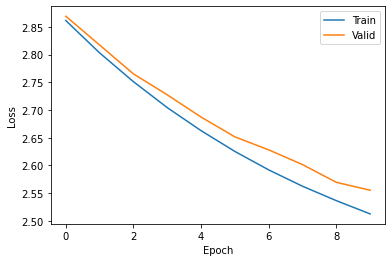

In [23]:
plt.plot(logger["train_loss"])
plt.plot(logger["validation_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

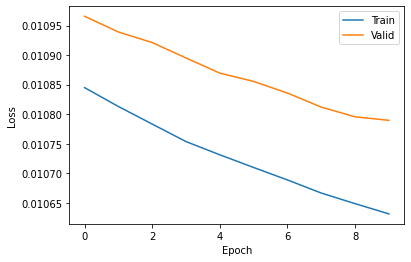

In [24]:
plt.plot(logger["train_gender_loss"])
plt.plot(logger["validation_gender_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

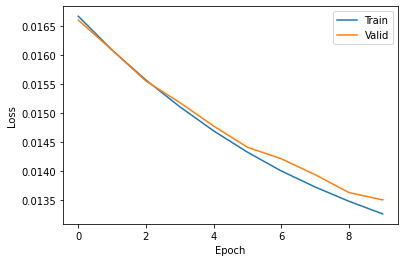

In [26]:
plt.plot(logger["train_mask_loss"])
plt.plot(logger["validation_mask_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

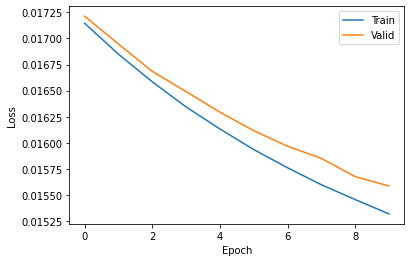

In [27]:
plt.plot(logger["train_age_loss"])
plt.plot(logger["validation_age_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [28]:
torch.save(model.state_dict(), "checkpoint/resnet50_10epochs.pth")

In [37]:
net(torch.Tensor(trainset[0]['image']).unsqueeze(0).to(device))

(tensor([[ 0.1680,  0.1683, -0.3452]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.1573]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.4176, -0.2435, -0.2517]], device='cuda:0', grad_fn=<AddmmBackward>))

---

## 이후 수정 중. 코드 오류

## 2. Test Dataset 정의

In [63]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image=np.array(image))['image']
        return image

    def __len__(self):
        return len(self.img_paths)

## 3. Inference

In [75]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
print(image_paths)
transform = get_transforms(mean=mean, std=std, img_size=(224, 224))

dataset = TestDataset(image_paths, transform['val'])

testloader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
net.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(testloader):
    with torch.no_grad():
        images = images.to(device)
        age_output, gender_output, mask_output = net(images)
        print(mask_output, gender_output, age_output)
        age_pred = age_output.argmax(dim=-1)
        gender_pred = 0 if gender_output < 0.5 else 1
        mask_pred = mask_output.argmax(dim=-1)
        print(age_pred, gender_pred, mask_pred)
        pred = mask_label * 6 + gender_label * 3 + age_label
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

  0%|          | 3/12600 [00:00<07:57, 26.40it/s]

['/opt/ml/input/data/eval/images/cbc5c6e168e63498590db46022617123f1fe1268.jpg', '/opt/ml/input/data/eval/images/0e72482bf56b3581c081f7da2a6180b8792c7089.jpg', '/opt/ml/input/data/eval/images/b549040c49190cedc41327748aeb197c1670f14d.jpg', '/opt/ml/input/data/eval/images/4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg', '/opt/ml/input/data/eval/images/248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg', '/opt/ml/input/data/eval/images/7953c2e6e983bad91b89a0e4ad7eb69e6e43e56b.jpg', '/opt/ml/input/data/eval/images/1903db7dcc1262d0441677afa422e6a8371e5b37.jpg', '/opt/ml/input/data/eval/images/441419a874f4d031cd576850b68539ca7d35bedf.jpg', '/opt/ml/input/data/eval/images/388856cd1ef99b1918273a827a75f2aff2478321.jpg', '/opt/ml/input/data/eval/images/795ba8ccc769a3f9da6a897f75df6706b729345b.jpg', '/opt/ml/input/data/eval/images/9028e8c54f80096bf4e43390caf003f64c90e5ce.jpg', '/opt/ml/input/data/eval/images/78900cfc8a2bb5cb69c60bdef92b173a8a48c8ec.jpg', '/opt/ml/input/data/eval/images/cba23bf8b02a8ddc470

  0%|          | 9/12600 [00:00<08:13, 25.50it/s]

tensor([[ 0.5480, -0.2891, -0.3018]], device='cuda:0') tensor([[0.1457]], device='cuda:0') tensor([[ 0.1785,  0.1311, -0.3901]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4954, -0.2618, -0.2658]], device='cuda:0') tensor([[0.1629]], device='cuda:0') tensor([[ 0.1905,  0.1067, -0.3328]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3533, -0.1912, -0.1887]], device='cuda:0') tensor([[0.1435]], device='cuda:0') tensor([[ 0.1168,  0.1292, -0.2857]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6042, -0.2820, -0.3683]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.2229,  0.1726, -0.4049]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6585, -0.3539, -0.4079]], device='cuda:0') tensor([[0.2098]], device='cuda:0') tensor([[ 0.2694,  0.1761, -0.4481]], device='cuda:0')
tensor([0], device='cuda:0') 0

  0%|          | 15/12600 [00:00<08:13, 25.48it/s]

tensor([[ 0.4398, -0.2607, -0.2805]], device='cuda:0') tensor([[0.1276]], device='cuda:0') tensor([[ 0.1886,  0.1023, -0.3595]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3663, -0.1728, -0.2120]], device='cuda:0') tensor([[0.1417]], device='cuda:0') tensor([[ 0.1360,  0.0978, -0.3004]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3394, -0.1738, -0.2181]], device='cuda:0') tensor([[0.1023]], device='cuda:0') tensor([[ 0.1058,  0.0945, -0.2933]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6242, -0.3153, -0.3546]], device='cuda:0') tensor([[0.1814]], device='cuda:0') tensor([[ 0.2365,  0.1949, -0.4591]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3961, -0.2293, -0.1996]], device='cuda:0') tensor([[0.1523]], device='cuda:0') tensor([[ 0.1265,  0.1190, -0.2767]], device='cuda:0')
tensor([0], device='cuda:0') 0

  0%|          | 21/12600 [00:00<08:23, 24.96it/s]

tensor([[ 0.4059, -0.2023, -0.2292]], device='cuda:0') tensor([[0.1492]], device='cuda:0') tensor([[ 0.1336,  0.0967, -0.2931]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7984, -0.3705, -0.4633]], device='cuda:0') tensor([[0.2064]], device='cuda:0') tensor([[ 0.3088,  0.1941, -0.5287]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4834, -0.2239, -0.2790]], device='cuda:0') tensor([[0.1405]], device='cuda:0') tensor([[ 0.1615,  0.1743, -0.3525]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4294, -0.2255, -0.2622]], device='cuda:0') tensor([[0.1543]], device='cuda:0') tensor([[ 0.1227,  0.1045, -0.2971]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3211, -0.1589, -0.2189]], device='cuda:0') tensor([[0.0976]], device='cuda:0') tensor([[ 0.1177,  0.0901, -0.2698]], device='cuda:0')
tensor([0], device='cuda:0') 0

  0%|          | 27/12600 [00:01<08:17, 25.29it/s]

tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5620, -0.2805, -0.3204]], device='cuda:0') tensor([[0.1888]], device='cuda:0') tensor([[ 0.1951,  0.1565, -0.4008]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3923, -0.2138, -0.2463]], device='cuda:0') tensor([[0.1420]], device='cuda:0') tensor([[ 0.1532,  0.0909, -0.3261]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6397, -0.3364, -0.3461]], device='cuda:0') tensor([[0.2000]], device='cuda:0') tensor([[ 0.2218,  0.1933, -0.4813]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6391, -0.3468, -0.3503]], device='cuda:0') tensor([[0.2096]], device='cuda:0') tensor([[ 0.2060,  0.1434, -0.4629]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3350, -0.1781, -0.2033]], device='cuda:0') tensor([[0.1476]], device='cuda:0') tensor([[ 0.1501,  0.1071

  0%|          | 33/12600 [00:01<08:12, 25.53it/s]

tensor([[ 0.6714, -0.3832, -0.3817]], device='cuda:0') tensor([[0.1960]], device='cuda:0') tensor([[ 0.1803,  0.1537, -0.4882]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7062, -0.3686, -0.4132]], device='cuda:0') tensor([[0.2406]], device='cuda:0') tensor([[ 0.2410,  0.2079, -0.4871]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5133, -0.2833, -0.3192]], device='cuda:0') tensor([[0.1569]], device='cuda:0') tensor([[ 0.1714,  0.1477, -0.3816]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4663, -0.2754, -0.2662]], device='cuda:0') tensor([[0.1630]], device='cuda:0') tensor([[ 0.1872,  0.1209, -0.3371]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5233, -0.3070, -0.3186]], device='cuda:0') tensor([[0.1608]], device='cuda:0') tensor([[ 0.1547,  0.1829, -0.3794]], device='cuda:0')
tensor([1], device='cuda:0') 0

  0%|          | 36/12600 [00:01<09:01, 23.19it/s]

tensor([[ 0.4427, -0.2383, -0.2525]], device='cuda:0') tensor([[0.1609]], device='cuda:0') tensor([[ 0.1264,  0.1427, -0.3639]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7230, -0.3774, -0.4125]], device='cuda:0') tensor([[0.2190]], device='cuda:0') tensor([[ 0.2289,  0.2135, -0.4818]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3239, -0.1585, -0.1953]], device='cuda:0') tensor([[0.1082]], device='cuda:0') tensor([[ 0.1185,  0.0892, -0.2649]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4233, -0.2209, -0.2258]], device='cuda:0') tensor([[0.1338]], device='cuda:0') tensor([[ 0.1395,  0.1070, -0.3183]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5900, -0.3274, -0.3207]], device='cuda:0') tensor([[0.2169]], device='cuda:0') tensor([[ 0.2034,  0.1612, -0.4541]], device='cuda:0')
tensor([0], device='cuda:0') 0

  0%|          | 42/12600 [00:01<08:55, 23.47it/s]

tensor([[ 0.7427, -0.3938, -0.3860]], device='cuda:0') tensor([[0.2527]], device='cuda:0') tensor([[ 0.2497,  0.2057, -0.5124]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3554, -0.1882, -0.2427]], device='cuda:0') tensor([[0.1165]], device='cuda:0') tensor([[ 0.1250,  0.0886, -0.2921]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7453, -0.4334, -0.4187]], device='cuda:0') tensor([[0.2685]], device='cuda:0') tensor([[ 0.2517,  0.2020, -0.5450]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5623, -0.3168, -0.2944]], device='cuda:0') tensor([[0.1878]], device='cuda:0') tensor([[ 0.1887,  0.1387, -0.4051]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4395, -0.2055, -0.2282]], device='cuda:0') tensor([[0.1663]], device='cuda:0') tensor([[ 0.1415,  0.1372, -0.3168]], device='cuda:0')
tensor([0], device='cuda:0') 0

  0%|          | 48/12600 [00:01<08:38, 24.21it/s]

tensor([[ 0.3816, -0.2068, -0.2346]], device='cuda:0') tensor([[0.1518]], device='cuda:0') tensor([[ 0.1280,  0.0920, -0.2595]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6016, -0.3083, -0.3038]], device='cuda:0') tensor([[0.2098]], device='cuda:0') tensor([[ 0.1753,  0.1454, -0.4038]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6382, -0.3180, -0.3997]], device='cuda:0') tensor([[0.1815]], device='cuda:0') tensor([[ 0.2343,  0.1701, -0.4688]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5773, -0.3174, -0.3085]], device='cuda:0') tensor([[0.1745]], device='cuda:0') tensor([[ 0.1769,  0.1783, -0.3900]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7690, -0.4104, -0.4219]], device='cuda:0') tensor([[0.2229]], device='cuda:0') tensor([[ 0.2381,  0.2173, -0.5156]], device='cuda:0')
tensor([0], device='cuda:0') 0

  0%|          | 54/12600 [00:02<08:26, 24.76it/s]

tensor([[0.1494]], device='cuda:0') tensor([[ 0.1641,  0.1392, -0.3305]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4839, -0.2564, -0.2664]], device='cuda:0') tensor([[0.1961]], device='cuda:0') tensor([[ 0.1511,  0.1241, -0.3381]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4469, -0.2300, -0.2747]], device='cuda:0') tensor([[0.1229]], device='cuda:0') tensor([[ 0.1578,  0.1429, -0.3347]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5281, -0.3018, -0.2989]], device='cuda:0') tensor([[0.1549]], device='cuda:0') tensor([[ 0.2428,  0.1407, -0.3528]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6960, -0.3406, -0.4028]], device='cuda:0') tensor([[0.2139]], device='cuda:0') tensor([[ 0.2264,  0.1526, -0.4601]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3443, -0.1630

  0%|          | 60/12600 [00:02<08:11, 25.50it/s]

tensor([[ 0.5656, -0.2856, -0.3376]], device='cuda:0') tensor([[0.1767]], device='cuda:0') tensor([[ 0.2294,  0.1352, -0.4016]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5202, -0.2337, -0.3016]], device='cuda:0') tensor([[0.1241]], device='cuda:0') tensor([[ 0.1715,  0.1720, -0.3475]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6154, -0.3945, -0.3465]], device='cuda:0') tensor([[0.1564]], device='cuda:0') tensor([[ 0.1671,  0.1345, -0.4466]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2703, -0.1524, -0.1679]], device='cuda:0') tensor([[0.1104]], device='cuda:0') tensor([[ 0.0909,  0.0754, -0.2319]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6152, -0.3391, -0.3597]], device='cuda:0') tensor([[0.2052]], device='cuda:0') tensor([[ 0.2256,  0.1753, -0.4372]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 66/12600 [00:02<08:05, 25.80it/s]

tensor([[ 0.4623, -0.2444, -0.2443]], device='cuda:0') tensor([[0.1442]], device='cuda:0') tensor([[ 0.1913,  0.1207, -0.3447]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5459, -0.2754, -0.3304]], device='cuda:0') tensor([[0.1588]], device='cuda:0') tensor([[ 0.1664,  0.1695, -0.4028]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7224, -0.3474, -0.3927]], device='cuda:0') tensor([[0.1999]], device='cuda:0') tensor([[ 0.2409,  0.2013, -0.4973]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4945, -0.2930, -0.2997]], device='cuda:0') tensor([[0.1334]], device='cuda:0') tensor([[ 0.1993,  0.1600, -0.3799]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7274, -0.4416, -0.4664]], device='cuda:0') tensor([[0.2527]], device='cuda:0') tensor([[ 0.2763,  0.1876, -0.5909]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 72/12600 [00:02<08:01, 25.99it/s]

tensor([[ 0.6197, -0.3372, -0.2737]], device='cuda:0') tensor([[0.2220]], device='cuda:0') tensor([[ 0.1750,  0.1606, -0.4108]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3182, -0.1693, -0.1871]], device='cuda:0') tensor([[0.1342]], device='cuda:0') tensor([[ 0.1353,  0.1120, -0.2474]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6684, -0.3218, -0.3853]], device='cuda:0') tensor([[0.1582]], device='cuda:0') tensor([[ 0.2681,  0.2043, -0.4966]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4613, -0.2437, -0.2596]], device='cuda:0') tensor([[0.1637]], device='cuda:0') tensor([[ 0.1468,  0.1380, -0.3293]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6622, -0.3825, -0.3791]], device='cuda:0') tensor([[0.2079]], device='cuda:0') tensor([[ 0.2517,  0.2160, -0.4828]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 78/12600 [00:03<08:00, 26.08it/s]

tensor([[ 0.6085, -0.2851, -0.3101]], device='cuda:0') tensor([[0.2015]], device='cuda:0') tensor([[ 0.2333,  0.1418, -0.4175]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5812, -0.3406, -0.3332]], device='cuda:0') tensor([[0.1999]], device='cuda:0') tensor([[ 0.1893,  0.1674, -0.4272]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5199, -0.3044, -0.3073]], device='cuda:0') tensor([[0.1406]], device='cuda:0') tensor([[ 0.1763,  0.1505, -0.3618]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6638, -0.3506, -0.3555]], device='cuda:0') tensor([[0.2405]], device='cuda:0') tensor([[ 0.2046,  0.1497, -0.4192]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5415, -0.2569, -0.3175]], device='cuda:0') tensor([[0.2087]], device='cuda:0') tensor([[ 0.1691,  0.1320, -0.3425]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 84/12600 [00:03<07:57, 26.21it/s]

tensor([[ 0.4889, -0.2395, -0.2578]], device='cuda:0') tensor([[0.1428]], device='cuda:0') tensor([[ 0.1446,  0.1043, -0.3388]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4829, -0.2247, -0.2676]], device='cuda:0') tensor([[0.1384]], device='cuda:0') tensor([[ 0.1769,  0.1144, -0.3128]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5356, -0.2564, -0.3183]], device='cuda:0') tensor([[0.1646]], device='cuda:0') tensor([[ 0.1955,  0.1728, -0.4074]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6836, -0.3757, -0.4085]], device='cuda:0') tensor([[0.2176]], device='cuda:0') tensor([[ 0.2457,  0.1719, -0.4728]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4836, -0.2816, -0.2793]], device='cuda:0') tensor([[0.1752]], device='cuda:0') tensor([[ 0.1918,  0.1321, -0.3687]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 87/12600 [00:03<07:56, 26.28it/s]

tensor([[ 0.5931, -0.3508, -0.3239]], device='cuda:0') tensor([[0.2130]], device='cuda:0') tensor([[ 0.2075,  0.1162, -0.4146]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3579, -0.1597, -0.1882]], device='cuda:0') tensor([[0.1387]], device='cuda:0') tensor([[ 0.1303,  0.0966, -0.2989]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3370, -0.1909, -0.2329]], device='cuda:0') tensor([[0.1141]], device='cuda:0') tensor([[ 0.1452,  0.1044, -0.2817]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4626, -0.2352, -0.2510]], device='cuda:0') tensor([[0.1729]], device='cuda:0') tensor([[ 0.1429,  0.1221, -0.3125]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7975, -0.3881, -0.4648]], device='cuda:0') tensor([[0.2541]], device='cuda:0') tensor([[ 0.2384,  0.2149, -0.5206]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 93/12600 [00:03<08:19, 25.05it/s]

tensor([[ 0.5926, -0.2788, -0.3186]], device='cuda:0') tensor([[0.2093]], device='cuda:0') tensor([[ 0.2044,  0.1199, -0.3710]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5339, -0.2848, -0.2854]], device='cuda:0') tensor([[0.1767]], device='cuda:0') tensor([[ 0.1974,  0.1193, -0.4131]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5098, -0.2465, -0.2816]], device='cuda:0') tensor([[0.1570]], device='cuda:0') tensor([[ 0.1304,  0.1592, -0.3865]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6406, -0.3489, -0.3396]], device='cuda:0') tensor([[0.2026]], device='cuda:0') tensor([[ 0.2604,  0.1909, -0.4913]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5179, -0.2657, -0.2761]], device='cuda:0') tensor([[0.1474]], device='cuda:0') tensor([[ 0.1797,  0.1407, -0.3564]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 99/12600 [00:03<08:07, 25.65it/s]

tensor([[ 0.7054, -0.3774, -0.3688]], device='cuda:0') tensor([[0.2076]], device='cuda:0') tensor([[ 0.2331,  0.1757, -0.4584]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4981, -0.2655, -0.2772]], device='cuda:0') tensor([[0.1535]], device='cuda:0') tensor([[ 0.1641,  0.1359, -0.3760]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5622, -0.2761, -0.3057]], device='cuda:0') tensor([[0.2305]], device='cuda:0') tensor([[ 0.2404,  0.1550, -0.4246]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5990, -0.2747, -0.3280]], device='cuda:0') tensor([[0.2000]], device='cuda:0') tensor([[ 0.2055,  0.1406, -0.3866]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4952, -0.2490, -0.3109]], device='cuda:0') tensor([[0.1362]], device='cuda:0') tensor([[ 0.1777,  0.1069, -0.3803]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 105/12600 [00:04<08:02, 25.87it/s]

tensor([[ 0.7866, -0.4351, -0.4738]], device='cuda:0') tensor([[0.2564]], device='cuda:0') tensor([[ 0.3015,  0.2387, -0.5945]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4932, -0.2484, -0.2954]], device='cuda:0') tensor([[0.1868]], device='cuda:0') tensor([[ 0.1331,  0.1387, -0.3339]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7658, -0.3634, -0.4230]], device='cuda:0') tensor([[0.2369]], device='cuda:0') tensor([[ 0.2791,  0.1864, -0.5157]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5546, -0.3077, -0.3391]], device='cuda:0') tensor([[0.1683]], device='cuda:0') tensor([[ 0.1645,  0.1898, -0.4015]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5226, -0.2876, -0.3155]], device='cuda:0') tensor([[0.1420]], device='cuda:0') tensor([[ 0.2753,  0.1612, -0.4177]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 111/12600 [00:04<07:58, 26.11it/s]

tensor([[ 0.3701, -0.1849, -0.2510]], device='cuda:0') tensor([[0.1049]], device='cuda:0') tensor([[ 0.1317,  0.1041, -0.3171]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5951, -0.2835, -0.2964]], device='cuda:0') tensor([[0.1974]], device='cuda:0') tensor([[ 0.2000,  0.1592, -0.3692]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5409, -0.2865, -0.3021]], device='cuda:0') tensor([[0.1419]], device='cuda:0') tensor([[ 0.1531,  0.1252, -0.3582]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4118, -0.2211, -0.2182]], device='cuda:0') tensor([[0.1352]], device='cuda:0') tensor([[ 0.1567,  0.1132, -0.3227]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3791, -0.1860, -0.2111]], device='cuda:0') tensor([[0.1420]], device='cuda:0') tensor([[ 0.1471,  0.1303, -0.2959]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 117/12600 [00:04<07:56, 26.19it/s]

tensor([[ 0.4653, -0.2549, -0.2640]], device='cuda:0') tensor([[0.1550]], device='cuda:0') tensor([[ 0.1802,  0.1079, -0.3415]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4549, -0.2503, -0.2619]], device='cuda:0') tensor([[0.1458]], device='cuda:0') tensor([[ 0.1664,  0.1612, -0.3536]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6310, -0.3387, -0.3572]], device='cuda:0') tensor([[0.2348]], device='cuda:0') tensor([[ 0.2094,  0.1772, -0.4246]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3491, -0.1777, -0.2002]], device='cuda:0') tensor([[0.1043]], device='cuda:0') tensor([[ 0.0976,  0.1115, -0.2718]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4280, -0.2445, -0.2467]], device='cuda:0') tensor([[0.1544]], device='cuda:0') tensor([[ 0.1229,  0.1313, -0.3167]], device='cuda:0')
tensor([1], device='cuda:0') 0

  1%|          | 123/12600 [00:04<07:54, 26.31it/s]

tensor([[ 0.3284, -0.1572, -0.1757]], device='cuda:0') tensor([[0.1123]], device='cuda:0') tensor([[ 0.1108,  0.1064, -0.2379]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6341, -0.3131, -0.3629]], device='cuda:0') tensor([[0.1873]], device='cuda:0') tensor([[ 0.2043,  0.1392, -0.4151]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4553, -0.2579, -0.2718]], device='cuda:0') tensor([[0.1517]], device='cuda:0') tensor([[ 0.1651,  0.1205, -0.3376]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3563, -0.1891, -0.1929]], device='cuda:0') tensor([[0.1143]], device='cuda:0') tensor([[ 0.1180,  0.1105, -0.2713]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5264, -0.2471, -0.2951]], device='cuda:0') tensor([[0.1929]], device='cuda:0') tensor([[ 0.2037,  0.1568, -0.3627]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 129/12600 [00:05<08:02, 25.84it/s]

tensor([[ 0.6277, -0.2896, -0.3239]], device='cuda:0') tensor([[0.2274]], device='cuda:0') tensor([[ 0.1947,  0.1584, -0.4172]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4548, -0.2372, -0.2827]], device='cuda:0') tensor([[0.1621]], device='cuda:0') tensor([[ 0.1388,  0.1600, -0.3380]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4134, -0.2182, -0.2434]], device='cuda:0') tensor([[0.1400]], device='cuda:0') tensor([[ 0.1476,  0.1415, -0.3171]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3651, -0.2005, -0.2308]], device='cuda:0') tensor([[0.1314]], device='cuda:0') tensor([[ 0.1273,  0.0800, -0.2796]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3761, -0.1897, -0.2309]], device='cuda:0') tensor([[0.1261]], device='cuda:0') tensor([[ 0.1325,  0.1512, -0.3250]], device='cuda:0')
tensor([1], device='cuda:0') 0

  1%|          | 135/12600 [00:05<07:59, 26.01it/s]

tensor([[ 0.1532,  0.1706, -0.3665]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6297, -0.3436, -0.3727]], device='cuda:0') tensor([[0.2061]], device='cuda:0') tensor([[ 0.2283,  0.1647, -0.4628]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3725, -0.1949, -0.2171]], device='cuda:0') tensor([[0.1113]], device='cuda:0') tensor([[ 0.1405,  0.0986, -0.2646]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6436, -0.3404, -0.3662]], device='cuda:0') tensor([[0.1778]], device='cuda:0') tensor([[ 0.2570,  0.2192, -0.4982]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5863, -0.2873, -0.3025]], device='cuda:0') tensor([[0.2038]], device='cuda:0') tensor([[ 0.2247,  0.1489, -0.3780]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4596, -0.2679, -0.2726]], device='cuda:0') tensor

  1%|          | 141/12600 [00:05<07:54, 26.27it/s]

tensor([[ 0.6169, -0.3665, -0.3658]], device='cuda:0') tensor([[0.1953]], device='cuda:0') tensor([[ 0.2207,  0.1621, -0.4430]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5005, -0.2414, -0.3205]], device='cuda:0') tensor([[0.2012]], device='cuda:0') tensor([[ 0.1851,  0.1709, -0.3879]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4356, -0.2073, -0.2533]], device='cuda:0') tensor([[0.1331]], device='cuda:0') tensor([[ 0.1571,  0.1230, -0.3275]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4542, -0.2667, -0.2798]], device='cuda:0') tensor([[0.1507]], device='cuda:0') tensor([[ 0.1673,  0.1526, -0.3813]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6206, -0.2766, -0.2879]], device='cuda:0') tensor([[0.1841]], device='cuda:0') tensor([[ 0.1665,  0.1610, -0.3940]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 147/12600 [00:05<08:15, 25.12it/s]

tensor([[ 0.4649, -0.2830, -0.3026]], device='cuda:0') tensor([[0.1580]], device='cuda:0') tensor([[ 0.1576,  0.1163, -0.3369]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3701, -0.2126, -0.2412]], device='cuda:0') tensor([[0.1140]], device='cuda:0') tensor([[ 0.1391,  0.1126, -0.2981]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5809, -0.3038, -0.3389]], device='cuda:0') tensor([[0.1535]], device='cuda:0') tensor([[ 0.2388,  0.1627, -0.4312]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7981, -0.3703, -0.4053]], device='cuda:0') tensor([[0.2007]], device='cuda:0') tensor([[ 0.2800,  0.1748, -0.5068]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4007, -0.1937, -0.2232]], device='cuda:0') tensor([[0.1151]], device='cuda:0') tensor([[ 0.1740,  0.0804, -0.3220]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|          | 153/12600 [00:06<08:06, 25.60it/s]

tensor([[ 0.5415, -0.2650, -0.3222]], device='cuda:0') tensor([[0.1593]], device='cuda:0') tensor([[ 0.1927,  0.1778, -0.3823]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6287, -0.2988, -0.3605]], device='cuda:0') tensor([[0.2241]], device='cuda:0') tensor([[ 0.2171,  0.1634, -0.4969]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3977, -0.2522, -0.2529]], device='cuda:0') tensor([[0.1451]], device='cuda:0') tensor([[ 0.1423,  0.1593, -0.3188]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6008, -0.3286, -0.3781]], device='cuda:0') tensor([[0.1520]], device='cuda:0') tensor([[ 0.1971,  0.1879, -0.4352]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5687, -0.2884, -0.3076]], device='cuda:0') tensor([[0.1939]], device='cuda:0') tensor([[ 0.1767,  0.1645, -0.3893]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|▏         | 159/12600 [00:06<08:00, 25.89it/s]

tensor([[ 0.3323, -0.1733, -0.1920]], device='cuda:0') tensor([[0.1153]], device='cuda:0') tensor([[ 0.1239,  0.0893, -0.2730]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2937, -0.1595, -0.1636]], device='cuda:0') tensor([[0.1184]], device='cuda:0') tensor([[ 0.0933,  0.1060, -0.2243]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3841, -0.1818, -0.2145]], device='cuda:0') tensor([[0.1101]], device='cuda:0') tensor([[ 0.1318,  0.1328, -0.3023]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5861, -0.3172, -0.3369]], device='cuda:0') tensor([[0.1765]], device='cuda:0') tensor([[ 0.2291,  0.1572, -0.3724]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6771, -0.3504, -0.3683]], device='cuda:0') tensor([[0.1853]], device='cuda:0') tensor([[ 0.2550,  0.1279, -0.4967]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|▏         | 165/12600 [00:06<08:01, 25.82it/s]

tensor([[ 0.3858, -0.1811, -0.2073]], device='cuda:0') tensor([[0.1297]], device='cuda:0') tensor([[ 0.1407,  0.1335, -0.2942]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2935, -0.1558, -0.1956]], device='cuda:0') tensor([[0.0963]], device='cuda:0') tensor([[ 0.1242,  0.0989, -0.2533]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4184, -0.2045, -0.2534]], device='cuda:0') tensor([[0.1587]], device='cuda:0') tensor([[ 0.1647,  0.1352, -0.3277]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3616, -0.1808, -0.2084]], device='cuda:0') tensor([[0.1269]], device='cuda:0') tensor([[ 0.0786,  0.0898, -0.2565]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6763, -0.3366, -0.3866]], device='cuda:0') tensor([[0.2275]], device='cuda:0') tensor([[ 0.2348,  0.2127, -0.4473]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|▏         | 171/12600 [00:06<07:56, 26.08it/s]

tensor([[ 0.4862, -0.2871, -0.2964]], device='cuda:0') tensor([[0.1500]], device='cuda:0') tensor([[ 0.1353,  0.0901, -0.3651]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3421, -0.2109, -0.1905]], device='cuda:0') tensor([[0.1307]], device='cuda:0') tensor([[ 0.1534,  0.1087, -0.3017]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6110, -0.3115, -0.3163]], device='cuda:0') tensor([[0.1705]], device='cuda:0') tensor([[ 0.2346,  0.1868, -0.4202]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4757, -0.2611, -0.2935]], device='cuda:0') tensor([[0.1685]], device='cuda:0') tensor([[ 0.1935,  0.1261, -0.3512]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4671, -0.2568, -0.2880]], device='cuda:0') tensor([[0.1813]], device='cuda:0') tensor([[ 0.1950,  0.1563, -0.3796]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|▏         | 174/12600 [00:06<07:55, 26.13it/s]

tensor([[ 0.6311, -0.3537, -0.3506]], device='cuda:0') tensor([[0.1782]], device='cuda:0') tensor([[ 0.2330,  0.1627, -0.4592]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7000, -0.3614, -0.3822]], device='cuda:0') tensor([[0.2510]], device='cuda:0') tensor([[ 0.2647,  0.2249, -0.4907]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6003, -0.2647, -0.3054]], device='cuda:0') tensor([[0.1782]], device='cuda:0') tensor([[ 0.2076,  0.1549, -0.4292]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5121, -0.2840, -0.2465]], device='cuda:0') tensor([[0.1502]], device='cuda:0') tensor([[ 0.1650,  0.1228, -0.4061]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3863, -0.2346, -0.2443]], device='cuda:0') tensor([[0.1452]], device='cuda:0') tensor([[ 0.1487,  0.1282, -0.3146]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|▏         | 180/12600 [00:07<08:13, 25.15it/s]

tensor([[ 0.4166, -0.2199, -0.2327]], device='cuda:0') tensor([[0.1071]], device='cuda:0') tensor([[ 0.1624,  0.1169, -0.3147]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5543, -0.2782, -0.2983]], device='cuda:0') tensor([[0.2101]], device='cuda:0') tensor([[ 0.1972,  0.1618, -0.4062]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4605, -0.2284, -0.2527]], device='cuda:0') tensor([[0.1327]], device='cuda:0') tensor([[ 0.1858,  0.1402, -0.3402]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4019, -0.1756, -0.2217]], device='cuda:0') tensor([[0.1195]], device='cuda:0') tensor([[ 0.1331,  0.1089, -0.2822]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4798, -0.2409, -0.2891]], device='cuda:0') tensor([[0.1645]], device='cuda:0') tensor([[ 0.1816,  0.1229, -0.3862]], device='cuda:0')
tensor([0], device='cuda:0') 0

  1%|▏         | 186/12600 [00:07<08:00, 25.83it/s]

tensor([[ 0.7341, -0.3331, -0.4251]], device='cuda:0') tensor([[0.2411]], device='cuda:0') tensor([[ 0.2388,  0.1939, -0.5102]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5135, -0.2772, -0.2724]], device='cuda:0') tensor([[0.1727]], device='cuda:0') tensor([[ 0.1669,  0.1203, -0.3648]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5557, -0.2865, -0.3224]], device='cuda:0') tensor([[0.1730]], device='cuda:0') tensor([[ 0.2313,  0.1409, -0.4017]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4258, -0.2471, -0.2625]], device='cuda:0') tensor([[0.1323]], device='cuda:0') tensor([[ 0.1687,  0.1124, -0.3209]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6125, -0.2968, -0.3151]], device='cuda:0') tensor([[0.1684]], device='cuda:0') tensor([[ 0.1676,  0.1425, -0.3625]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 192/12600 [00:07<07:52, 26.27it/s]

tensor([[ 0.4447, -0.2266, -0.2638]], device='cuda:0') tensor([[0.1248]], device='cuda:0') tensor([[ 0.1519,  0.1561, -0.3174]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4028, -0.2038, -0.2128]], device='cuda:0') tensor([[0.1425]], device='cuda:0') tensor([[ 0.1252,  0.1609, -0.2863]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4540, -0.2321, -0.2698]], device='cuda:0') tensor([[0.1924]], device='cuda:0') tensor([[ 0.1666,  0.1095, -0.3152]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4135, -0.2425, -0.2082]], device='cuda:0') tensor([[0.1223]], device='cuda:0') tensor([[ 0.1524,  0.1153, -0.3428]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5769, -0.3416, -0.3670]], device='cuda:0') tensor([[0.1562]], device='cuda:0') tensor([[ 0.1505,  0.1322, -0.4175]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 198/12600 [00:07<07:51, 26.28it/s]

tensor([[ 0.6390, -0.3185, -0.3684]], device='cuda:0') tensor([[0.1976]], device='cuda:0') tensor([[ 0.2322,  0.1486, -0.4795]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3739, -0.2117, -0.2403]], device='cuda:0') tensor([[0.1174]], device='cuda:0') tensor([[ 0.1356,  0.1019, -0.3050]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4696, -0.2443, -0.2669]], device='cuda:0') tensor([[0.1526]], device='cuda:0') tensor([[ 0.1992,  0.1396, -0.3476]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6553, -0.3243, -0.3211]], device='cuda:0') tensor([[0.2523]], device='cuda:0') tensor([[ 0.2112,  0.1544, -0.4515]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3245, -0.1689, -0.1869]], device='cuda:0') tensor([[0.1080]], device='cuda:0') tensor([[ 0.1010,  0.0777, -0.2586]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 204/12600 [00:07<07:49, 26.38it/s]

tensor([[ 0.5995, -0.3204, -0.2936]], device='cuda:0') tensor([[0.2101]], device='cuda:0') tensor([[ 0.1855,  0.1508, -0.3918]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3525, -0.1650, -0.1900]], device='cuda:0') tensor([[0.1314]], device='cuda:0') tensor([[ 0.1167,  0.1057, -0.2621]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5586, -0.2941, -0.3034]], device='cuda:0') tensor([[0.1698]], device='cuda:0') tensor([[ 0.2073,  0.1535, -0.4181]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4720, -0.2811, -0.2913]], device='cuda:0') tensor([[0.1338]], device='cuda:0') tensor([[ 0.1695,  0.1369, -0.3827]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4771, -0.2583, -0.2995]], device='cuda:0') tensor([[0.1486]], device='cuda:0') tensor([[ 0.1763,  0.1389, -0.3347]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 210/12600 [00:08<07:51, 26.30it/s]

tensor([[ 0.5716, -0.2818, -0.3154]], device='cuda:0') tensor([[0.1830]], device='cuda:0') tensor([[ 0.1557,  0.1644, -0.3917]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4711, -0.2500, -0.2570]], device='cuda:0') tensor([[0.1540]], device='cuda:0') tensor([[ 0.1477,  0.1032, -0.3120]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3340, -0.1943, -0.2050]], device='cuda:0') tensor([[0.1350]], device='cuda:0') tensor([[ 0.1238,  0.0921, -0.2752]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3374, -0.1500, -0.1865]], device='cuda:0') tensor([[0.1264]], device='cuda:0') tensor([[ 0.1081,  0.0923, -0.2529]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3129, -0.1683, -0.1621]], device='cuda:0') tensor([[0.0842]], device='cuda:0') tensor([[ 0.0936,  0.0994, -0.2521]], device='cuda:0')
tensor([1], device='cuda:0') 0

  2%|▏         | 216/12600 [00:08<07:48, 26.43it/s]

tensor([[ 0.6006, -0.3177, -0.3096]], device='cuda:0') tensor([[0.1742]], device='cuda:0') tensor([[ 0.2020,  0.1552, -0.3731]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4665, -0.2348, -0.2851]], device='cuda:0') tensor([[0.1438]], device='cuda:0') tensor([[ 0.1812,  0.1665, -0.3892]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4973, -0.2783, -0.3101]], device='cuda:0') tensor([[0.1437]], device='cuda:0') tensor([[ 0.1825,  0.1536, -0.3751]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5146, -0.2265, -0.2657]], device='cuda:0') tensor([[0.1643]], device='cuda:0') tensor([[ 0.1815,  0.1160, -0.3138]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4605, -0.2212, -0.2797]], device='cuda:0') tensor([[0.1327]], device='cuda:0') tensor([[ 0.1399,  0.1614, -0.3369]], device='cuda:0')
tensor([1], device='cuda:0') 0

  2%|▏         | 222/12600 [00:08<07:50, 26.33it/s]

tensor([[ 0.5780, -0.3164, -0.3247]], device='cuda:0') tensor([[0.1974]], device='cuda:0') tensor([[ 0.2026,  0.1405, -0.4022]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3782, -0.1883, -0.2427]], device='cuda:0') tensor([[0.1302]], device='cuda:0') tensor([[ 0.1271,  0.0983, -0.3040]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5307, -0.2602, -0.2811]], device='cuda:0') tensor([[0.1670]], device='cuda:0') tensor([[ 0.1723,  0.1194, -0.3668]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6638, -0.3423, -0.3672]], device='cuda:0') tensor([[0.1779]], device='cuda:0') tensor([[ 0.2559,  0.2053, -0.4948]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6545, -0.3084, -0.3807]], device='cuda:0') tensor([[0.2145]], device='cuda:0') tensor([[ 0.2031,  0.1679, -0.4568]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 228/12600 [00:08<07:51, 26.24it/s]

tensor([[ 0.5078, -0.2546, -0.2773]], device='cuda:0') tensor([[0.1335]], device='cuda:0') tensor([[ 0.1909,  0.1204, -0.3716]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5773, -0.3011, -0.3710]], device='cuda:0') tensor([[0.1802]], device='cuda:0') tensor([[ 0.1935,  0.1416, -0.4035]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6576, -0.3598, -0.3749]], device='cuda:0') tensor([[0.2127]], device='cuda:0') tensor([[ 0.2033,  0.1866, -0.4877]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4844, -0.2160, -0.2815]], device='cuda:0') tensor([[0.1522]], device='cuda:0') tensor([[ 0.1824,  0.1276, -0.3142]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5989, -0.3011, -0.3126]], device='cuda:0') tensor([[0.2386]], device='cuda:0') tensor([[ 0.2402,  0.1941, -0.4491]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 234/12600 [00:09<07:52, 26.18it/s]

tensor([[ 0.6213, -0.3274, -0.3696]], device='cuda:0') tensor([[0.2148]], device='cuda:0') tensor([[ 0.1908,  0.2098, -0.4598]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5010, -0.2849, -0.2634]], device='cuda:0') tensor([[0.1862]], device='cuda:0') tensor([[ 0.1841,  0.1546, -0.3976]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6049, -0.3217, -0.3327]], device='cuda:0') tensor([[0.2092]], device='cuda:0') tensor([[ 0.1912,  0.1925, -0.4199]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5752, -0.2950, -0.2711]], device='cuda:0') tensor([[0.1416]], device='cuda:0') tensor([[ 0.1988,  0.1546, -0.4035]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5615, -0.2904, -0.3158]], device='cuda:0') tensor([[0.1678]], device='cuda:0') tensor([[ 0.1652,  0.1544, -0.3954]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 240/12600 [00:09<07:53, 26.09it/s]

tensor([[ 0.5616, -0.2580, -0.3139]], device='cuda:0') tensor([[0.1703]], device='cuda:0') tensor([[ 0.1966,  0.1472, -0.4030]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2977, -0.1837, -0.1868]], device='cuda:0') tensor([[0.0879]], device='cuda:0') tensor([[ 0.1029,  0.0901, -0.2429]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4816, -0.2494, -0.2679]], device='cuda:0') tensor([[0.1441]], device='cuda:0') tensor([[ 0.1735,  0.1300, -0.3389]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4538, -0.2526, -0.2345]], device='cuda:0') tensor([[0.1390]], device='cuda:0') tensor([[ 0.1436,  0.1215, -0.3398]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4818, -0.2413, -0.2882]], device='cuda:0') tensor([[0.1505]], device='cuda:0') tensor([[ 0.1643,  0.1670, -0.3253]], device='cuda:0')
tensor([1], device='cuda:0') 0

  2%|▏         | 246/12600 [00:09<07:49, 26.33it/s]

tensor([[ 0.4818, -0.2293, -0.2724]], device='cuda:0') tensor([[0.1565]], device='cuda:0') tensor([[ 0.1858,  0.1411, -0.3409]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3189, -0.1815, -0.2018]], device='cuda:0') tensor([[0.1288]], device='cuda:0') tensor([[ 0.1253,  0.0850, -0.2753]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3516, -0.1865, -0.2374]], device='cuda:0') tensor([[0.1312]], device='cuda:0') tensor([[ 0.1434,  0.1140, -0.2966]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5487, -0.2857, -0.3634]], device='cuda:0') tensor([[0.1998]], device='cuda:0') tensor([[ 0.2275,  0.1599, -0.3828]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5218, -0.2831, -0.2840]], device='cuda:0') tensor([[0.1596]], device='cuda:0') tensor([[ 0.1619,  0.1375, -0.3630]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 252/12600 [00:09<07:46, 26.44it/s]

tensor([[ 0.4465, -0.2411, -0.2646]], device='cuda:0') tensor([[0.1285]], device='cuda:0') tensor([[ 0.1503,  0.1060, -0.3096]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3601, -0.1887, -0.2246]], device='cuda:0') tensor([[0.0940]], device='cuda:0') tensor([[ 0.1589,  0.0936, -0.3082]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5160, -0.2591, -0.3282]], device='cuda:0') tensor([[0.1677]], device='cuda:0') tensor([[ 0.1956,  0.1227, -0.3599]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6482, -0.2975, -0.3452]], device='cuda:0') tensor([[0.1873]], device='cuda:0') tensor([[ 0.2070,  0.1528, -0.4516]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3827, -0.1971, -0.1997]], device='cuda:0') tensor([[0.1334]], device='cuda:0') tensor([[ 0.1263,  0.1190, -0.2909]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 258/12600 [00:10<07:47, 26.41it/s]

tensor([[ 0.4237, -0.2362, -0.2705]], device='cuda:0') tensor([[0.1402]], device='cuda:0') tensor([[ 0.1216,  0.1115, -0.3148]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6680, -0.3664, -0.3520]], device='cuda:0') tensor([[0.2266]], device='cuda:0') tensor([[ 0.2217,  0.2285, -0.4301]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5044, -0.2940, -0.2665]], device='cuda:0') tensor([[0.1053]], device='cuda:0') tensor([[ 0.1902,  0.1223, -0.3667]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5067, -0.2760, -0.2722]], device='cuda:0') tensor([[0.1378]], device='cuda:0') tensor([[ 0.1686,  0.1404, -0.3850]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3854, -0.1949, -0.2123]], device='cuda:0') tensor([[0.1374]], device='cuda:0') tensor([[ 0.1070,  0.1195, -0.2748]], device='cuda:0')
tensor([1], device='cuda:0') 0

  2%|▏         | 264/12600 [00:10<07:52, 26.13it/s]

tensor([[ 0.5260, -0.2724, -0.3039]], device='cuda:0') tensor([[0.1815]], device='cuda:0') tensor([[ 0.1950,  0.1647, -0.3300]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4900, -0.2607, -0.3163]], device='cuda:0') tensor([[0.1911]], device='cuda:0') tensor([[ 0.1740,  0.1171, -0.3395]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4525, -0.2477, -0.2797]], device='cuda:0') tensor([[0.1459]], device='cuda:0') tensor([[ 0.1681,  0.1123, -0.3332]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5665, -0.2709, -0.3248]], device='cuda:0') tensor([[0.1893]], device='cuda:0') tensor([[ 0.1863,  0.1537, -0.3959]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4104, -0.2300, -0.2454]], device='cuda:0') tensor([[0.1508]], device='cuda:0') tensor([[ 0.1581,  0.1179, -0.3494]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 270/12600 [00:10<07:47, 26.38it/s]

tensor([[ 0.8159, -0.4047, -0.4348]], device='cuda:0') tensor([[0.2825]], device='cuda:0') tensor([[ 0.2789,  0.2083, -0.5764]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3524, -0.1975, -0.2527]], device='cuda:0') tensor([[0.1356]], device='cuda:0') tensor([[ 0.1436,  0.0958, -0.2762]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3104, -0.1701, -0.2032]], device='cuda:0') tensor([[0.1166]], device='cuda:0') tensor([[ 0.1121,  0.1083, -0.2571]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4970, -0.2673, -0.3181]], device='cuda:0') tensor([[0.1448]], device='cuda:0') tensor([[ 0.1746,  0.1252, -0.3572]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4279, -0.2453, -0.2398]], device='cuda:0') tensor([[0.1319]], device='cuda:0') tensor([[ 0.1609,  0.1219, -0.3391]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 276/12600 [00:10<07:52, 26.07it/s]

tensor([[ 0.5056, -0.2842, -0.3084]], device='cuda:0') tensor([[0.1758]], device='cuda:0') tensor([[ 0.1834,  0.1490, -0.4206]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4510, -0.2179, -0.2627]], device='cuda:0') tensor([[0.1629]], device='cuda:0') tensor([[ 0.1560,  0.1312, -0.3126]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4778, -0.2751, -0.2443]], device='cuda:0') tensor([[0.1479]], device='cuda:0') tensor([[ 0.2213,  0.1374, -0.4040]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4620, -0.2376, -0.2697]], device='cuda:0') tensor([[0.1323]], device='cuda:0') tensor([[ 0.1792,  0.1298, -0.3689]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.9527, -0.4357, -0.4710]], device='cuda:0') tensor([[0.2542]], device='cuda:0') tensor([[ 0.3290,  0.1940, -0.5565]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 282/12600 [00:10<07:52, 26.07it/s]

tensor([[ 0.5187, -0.2983, -0.3027]], device='cuda:0') tensor([[0.2038]], device='cuda:0') tensor([[ 0.1750,  0.1678, -0.4186]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4684, -0.2536, -0.2962]], device='cuda:0') tensor([[0.1730]], device='cuda:0') tensor([[ 0.1469,  0.1459, -0.3327]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5627, -0.3115, -0.2962]], device='cuda:0') tensor([[0.1711]], device='cuda:0') tensor([[ 0.2076,  0.1305, -0.3996]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5275, -0.2697, -0.2887]], device='cuda:0') tensor([[0.2052]], device='cuda:0') tensor([[ 0.1643,  0.1417, -0.4102]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4753, -0.2525, -0.2728]], device='cuda:0') tensor([[0.1943]], device='cuda:0') tensor([[ 0.1887,  0.1638, -0.3633]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 288/12600 [00:11<07:56, 25.82it/s]

tensor([[ 0.6250, -0.3141, -0.3468]], device='cuda:0') tensor([[0.1712]], device='cuda:0') tensor([[ 0.2223,  0.1750, -0.4449]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5216, -0.2922, -0.2819]], device='cuda:0') tensor([[0.1728]], device='cuda:0') tensor([[ 0.1970,  0.1543, -0.3969]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7050, -0.3742, -0.4498]], device='cuda:0') tensor([[0.2253]], device='cuda:0') tensor([[ 0.2653,  0.2113, -0.5125]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5446, -0.2874, -0.2874]], device='cuda:0') tensor([[0.1747]], device='cuda:0') tensor([[ 0.1699,  0.1569, -0.3666]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5728, -0.3176, -0.3259]], device='cuda:0') tensor([[0.1732]], device='cuda:0') tensor([[ 0.1980,  0.1659, -0.4171]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 294/12600 [00:11<08:00, 25.63it/s]

tensor([[ 0.5856, -0.3106, -0.3304]], device='cuda:0') tensor([[0.1768]], device='cuda:0') tensor([[ 0.2362,  0.1260, -0.4524]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4785, -0.2532, -0.2707]], device='cuda:0') tensor([[0.1304]], device='cuda:0') tensor([[ 0.1954,  0.1114, -0.3739]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5685, -0.3096, -0.3707]], device='cuda:0') tensor([[0.1670]], device='cuda:0') tensor([[ 0.1699,  0.1350, -0.4357]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6467, -0.3724, -0.4358]], device='cuda:0') tensor([[0.2083]], device='cuda:0') tensor([[ 0.2255,  0.1673, -0.4930]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7149, -0.3633, -0.3950]], device='cuda:0') tensor([[0.1709]], device='cuda:0') tensor([[ 0.2395,  0.1870, -0.5329]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 300/12600 [00:11<07:56, 25.82it/s]

tensor([[ 0.3363, -0.1842, -0.1971]], device='cuda:0') tensor([[0.1083]], device='cuda:0') tensor([[ 0.1350,  0.0788, -0.2767]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5495, -0.3007, -0.3146]], device='cuda:0') tensor([[0.1488]], device='cuda:0') tensor([[ 0.1969,  0.1572, -0.4015]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4270, -0.2053, -0.2419]], device='cuda:0') tensor([[0.1393]], device='cuda:0') tensor([[ 0.1487,  0.1272, -0.3225]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5297, -0.2400, -0.2640]], device='cuda:0') tensor([[0.1848]], device='cuda:0') tensor([[ 0.1620,  0.1215, -0.3490]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5944, -0.3025, -0.3154]], device='cuda:0') tensor([[0.1828]], device='cuda:0') tensor([[ 0.1467,  0.1830, -0.4088]], device='cuda:0')
tensor([1], device='cuda:0') 0

  2%|▏         | 306/12600 [00:11<07:55, 25.83it/s]

tensor([[ 0.4722, -0.2369, -0.2900]], device='cuda:0') tensor([[0.1453]], device='cuda:0') tensor([[ 0.1618,  0.1070, -0.3665]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3919, -0.2262, -0.2473]], device='cuda:0') tensor([[0.1053]], device='cuda:0') tensor([[ 0.1084,  0.1433, -0.3020]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4670, -0.2780, -0.3203]], device='cuda:0') tensor([[0.1703]], device='cuda:0') tensor([[ 0.1988,  0.1282, -0.4034]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5747, -0.2860, -0.3255]], device='cuda:0') tensor([[0.2204]], device='cuda:0') tensor([[ 0.1883,  0.1434, -0.3759]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5769, -0.2835, -0.3209]], device='cuda:0') tensor([[0.1981]], device='cuda:0') tensor([[ 0.2100,  0.1368, -0.4017]], device='cuda:0')
tensor([0], device='cuda:0') 0

  2%|▏         | 312/12600 [00:12<07:52, 26.01it/s]

tensor([[ 0.6208, -0.3467, -0.3539]], device='cuda:0') tensor([[0.2033]], device='cuda:0') tensor([[ 0.1931,  0.1565, -0.3784]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4901, -0.2761, -0.2961]], device='cuda:0') tensor([[0.1670]], device='cuda:0') tensor([[ 0.1400,  0.1860, -0.3987]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6159, -0.2995, -0.3437]], device='cuda:0') tensor([[0.1936]], device='cuda:0') tensor([[ 0.2152,  0.1457, -0.4540]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5539, -0.2824, -0.2814]], device='cuda:0') tensor([[0.1604]], device='cuda:0') tensor([[ 0.1854,  0.1554, -0.3655]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6189, -0.3205, -0.3475]], device='cuda:0') tensor([[0.1665]], device='cuda:0') tensor([[ 0.2075,  0.1573, -0.4374]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 318/12600 [00:12<07:50, 26.09it/s]

tensor([[ 0.5772, -0.3255, -0.3508]], device='cuda:0') tensor([[0.1839]], device='cuda:0') tensor([[ 0.2381,  0.1501, -0.4147]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7253, -0.4305, -0.4553]], device='cuda:0') tensor([[0.2328]], device='cuda:0') tensor([[ 0.2795,  0.2027, -0.5223]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4673, -0.2752, -0.3028]], device='cuda:0') tensor([[0.1567]], device='cuda:0') tensor([[ 0.1358,  0.1143, -0.3386]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6893, -0.3505, -0.3948]], device='cuda:0') tensor([[0.2129]], device='cuda:0') tensor([[ 0.2457,  0.1720, -0.5488]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3590, -0.2066, -0.2037]], device='cuda:0') tensor([[0.1250]], device='cuda:0') tensor([[ 0.1258,  0.0996, -0.2749]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 324/12600 [00:12<08:05, 25.31it/s]

tensor([[ 0.3482, -0.2242, -0.2041]], device='cuda:0') tensor([[0.1087]], device='cuda:0') tensor([[ 0.1335,  0.0894, -0.2743]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3985, -0.2078, -0.2153]], device='cuda:0') tensor([[0.1359]], device='cuda:0') tensor([[ 0.1336,  0.0994, -0.2920]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6906, -0.3429, -0.3887]], device='cuda:0') tensor([[0.2089]], device='cuda:0') tensor([[ 0.2380,  0.1917, -0.5390]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5695, -0.2657, -0.3147]], device='cuda:0') tensor([[0.1955]], device='cuda:0') tensor([[ 0.2132,  0.1625, -0.4493]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6649, -0.3107, -0.3812]], device='cuda:0') tensor([[0.1763]], device='cuda:0') tensor([[ 0.2197,  0.1823, -0.4174]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 330/12600 [00:12<07:56, 25.73it/s]

tensor([[ 0.6048, -0.3450, -0.3427]], device='cuda:0') tensor([[0.1369]], device='cuda:0') tensor([[ 0.1993,  0.1529, -0.4269]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4429, -0.2195, -0.2373]], device='cuda:0') tensor([[0.1529]], device='cuda:0') tensor([[ 0.1793,  0.1275, -0.3018]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4178, -0.2233, -0.2216]], device='cuda:0') tensor([[0.1332]], device='cuda:0') tensor([[ 0.1514,  0.0985, -0.3212]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5263, -0.2520, -0.2926]], device='cuda:0') tensor([[0.1633]], device='cuda:0') tensor([[ 0.1324,  0.1432, -0.3303]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3143, -0.1789, -0.1875]], device='cuda:0') tensor([[0.0854]], device='cuda:0') tensor([[ 0.1174,  0.1017, -0.2424]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 336/12600 [00:13<07:51, 25.99it/s]

tensor([[ 0.5952, -0.3401, -0.4107]], device='cuda:0') tensor([[0.2403]], device='cuda:0') tensor([[ 0.2149,  0.1994, -0.4457]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4499, -0.2764, -0.2954]], device='cuda:0') tensor([[0.1321]], device='cuda:0') tensor([[ 0.1612,  0.1140, -0.3688]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2977, -0.1508, -0.1696]], device='cuda:0') tensor([[0.0974]], device='cuda:0') tensor([[ 0.1185,  0.0834, -0.2594]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3341, -0.1771, -0.2097]], device='cuda:0') tensor([[0.1166]], device='cuda:0') tensor([[ 0.1344,  0.1024, -0.2647]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5638, -0.3040, -0.3208]], device='cuda:0') tensor([[0.1729]], device='cuda:0') tensor([[ 0.2240,  0.1889, -0.4183]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 342/12600 [00:13<07:51, 26.01it/s]

tensor([[ 0.4211, -0.2175, -0.2456]], device='cuda:0') tensor([[0.1701]], device='cuda:0') tensor([[ 0.1124,  0.1473, -0.3340]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3701, -0.2068, -0.2206]], device='cuda:0') tensor([[0.1251]], device='cuda:0') tensor([[ 0.1185,  0.1243, -0.2807]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4307, -0.2187, -0.2342]], device='cuda:0') tensor([[0.1614]], device='cuda:0') tensor([[ 0.1420,  0.1455, -0.2943]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3687, -0.2036, -0.2398]], device='cuda:0') tensor([[0.1581]], device='cuda:0') tensor([[ 0.0984,  0.1275, -0.3043]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4192, -0.2460, -0.2268]], device='cuda:0') tensor([[0.1374]], device='cuda:0') tensor([[ 0.1645,  0.1389, -0.3549]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 348/12600 [00:13<07:43, 26.42it/s]

tensor([[ 0.5364, -0.2869, -0.3236]], device='cuda:0') tensor([[0.1396]], device='cuda:0') tensor([[ 0.1839,  0.2214, -0.4208]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4517, -0.2178, -0.2486]], device='cuda:0') tensor([[0.1673]], device='cuda:0') tensor([[ 0.1672,  0.0964, -0.3216]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6756, -0.3294, -0.3844]], device='cuda:0') tensor([[0.2034]], device='cuda:0') tensor([[ 0.2480,  0.1325, -0.4552]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6088, -0.3319, -0.3422]], device='cuda:0') tensor([[0.1644]], device='cuda:0') tensor([[ 0.1984,  0.1438, -0.4076]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6926, -0.3923, -0.3809]], device='cuda:0') tensor([[0.2594]], device='cuda:0') tensor([[ 0.2257,  0.1863, -0.5140]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 354/12600 [00:13<07:45, 26.32it/s]

tensor([[ 0.6595, -0.3738, -0.3911]], device='cuda:0') tensor([[0.2027]], device='cuda:0') tensor([[ 0.2666,  0.1719, -0.4300]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3092, -0.1535, -0.1458]], device='cuda:0') tensor([[0.1163]], device='cuda:0') tensor([[ 0.1250,  0.0990, -0.2547]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8015, -0.3682, -0.4091]], device='cuda:0') tensor([[0.2156]], device='cuda:0') tensor([[ 0.2813,  0.2070, -0.5238]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3013, -0.1527, -0.1828]], device='cuda:0') tensor([[0.0862]], device='cuda:0') tensor([[ 0.1096,  0.1006, -0.2584]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3673, -0.1834, -0.2339]], device='cuda:0') tensor([[0.1465]], device='cuda:0') tensor([[ 0.1510,  0.0952, -0.3156]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 360/12600 [00:13<07:46, 26.24it/s]

tensor([[ 0.6627, -0.3147, -0.3680]], device='cuda:0') tensor([[0.1901]], device='cuda:0') tensor([[ 0.2471,  0.1803, -0.4593]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6487, -0.3297, -0.3707]], device='cuda:0') tensor([[0.2002]], device='cuda:0') tensor([[ 0.2292,  0.1886, -0.4760]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5110, -0.2327, -0.2932]], device='cuda:0') tensor([[0.1519]], device='cuda:0') tensor([[ 0.2078,  0.1236, -0.3718]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3644, -0.1958, -0.2184]], device='cuda:0') tensor([[0.1303]], device='cuda:0') tensor([[ 0.1228,  0.0801, -0.2662]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4741, -0.2557, -0.2709]], device='cuda:0') tensor([[0.1423]], device='cuda:0') tensor([[ 0.1687,  0.1268, -0.3494]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 366/12600 [00:14<07:54, 25.80it/s]

tensor([[ 0.4140, -0.2377, -0.2683]], device='cuda:0') tensor([[0.1405]], device='cuda:0') tensor([[ 0.1396,  0.1065, -0.3223]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4971, -0.2394, -0.2997]], device='cuda:0') tensor([[0.1188]], device='cuda:0') tensor([[ 0.1736,  0.1522, -0.3553]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4179, -0.2305, -0.2628]], device='cuda:0') tensor([[0.1451]], device='cuda:0') tensor([[ 0.1683,  0.1295, -0.3097]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4064, -0.1968, -0.2214]], device='cuda:0') tensor([[0.1375]], device='cuda:0') tensor([[ 0.1220,  0.1365, -0.3043]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5817, -0.3192, -0.3487]], device='cuda:0') tensor([[0.2596]], device='cuda:0') tensor([[ 0.1870,  0.1496, -0.3982]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 372/12600 [00:14<07:48, 26.08it/s]

tensor([[ 0.5976, -0.3031, -0.3498]], device='cuda:0') tensor([[0.2164]], device='cuda:0') tensor([[ 0.2273,  0.1744, -0.3922]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6165, -0.3168, -0.3722]], device='cuda:0') tensor([[0.1846]], device='cuda:0') tensor([[ 0.2400,  0.1961, -0.4584]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3313, -0.1667, -0.1910]], device='cuda:0') tensor([[0.1206]], device='cuda:0') tensor([[ 0.0843,  0.1018, -0.2443]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6179, -0.3263, -0.3656]], device='cuda:0') tensor([[0.1845]], device='cuda:0') tensor([[ 0.2013,  0.1961, -0.4640]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5589, -0.2992, -0.3324]], device='cuda:0') tensor([[0.1861]], device='cuda:0') tensor([[ 0.2202,  0.1637, -0.4011]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 378/12600 [00:14<07:46, 26.20it/s]

tensor([[ 0.5470, -0.2954, -0.3112]], device='cuda:0') tensor([[0.1655]], device='cuda:0') tensor([[ 0.2154,  0.1640, -0.4006]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3300, -0.1935, -0.1674]], device='cuda:0') tensor([[0.1327]], device='cuda:0') tensor([[ 0.0921,  0.1028, -0.2600]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5003, -0.2765, -0.2832]], device='cuda:0') tensor([[0.1674]], device='cuda:0') tensor([[ 0.1814,  0.1481, -0.3393]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5299, -0.2695, -0.2983]], device='cuda:0') tensor([[0.1612]], device='cuda:0') tensor([[ 0.1730,  0.1529, -0.4058]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6636, -0.3092, -0.3964]], device='cuda:0') tensor([[0.1841]], device='cuda:0') tensor([[ 0.2382,  0.1631, -0.4739]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 384/12600 [00:14<08:04, 25.21it/s]

tensor([[ 0.5831, -0.3108, -0.3624]], device='cuda:0') tensor([[0.1789]], device='cuda:0') tensor([[ 0.1918,  0.1713, -0.4063]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4795, -0.2357, -0.2683]], device='cuda:0') tensor([[0.1561]], device='cuda:0') tensor([[ 0.1408,  0.1400, -0.3430]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7170, -0.3347, -0.3861]], device='cuda:0') tensor([[0.2350]], device='cuda:0') tensor([[ 0.2655,  0.2286, -0.5008]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4346, -0.2101, -0.2411]], device='cuda:0') tensor([[0.1356]], device='cuda:0') tensor([[ 0.1408,  0.1054, -0.3152]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5477, -0.2846, -0.3041]], device='cuda:0') tensor([[0.1829]], device='cuda:0') tensor([[ 0.1817,  0.1107, -0.3999]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 390/12600 [00:15<07:57, 25.59it/s]

tensor([[ 0.5293, -0.2470, -0.3049]], device='cuda:0') tensor([[0.1518]], device='cuda:0') tensor([[ 0.2050,  0.1570, -0.3710]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5752, -0.2690, -0.3133]], device='cuda:0') tensor([[0.1707]], device='cuda:0') tensor([[ 0.2060,  0.1503, -0.4061]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4115, -0.2152, -0.2522]], device='cuda:0') tensor([[0.1125]], device='cuda:0') tensor([[ 0.1601,  0.0916, -0.3563]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4527, -0.2596, -0.2555]], device='cuda:0') tensor([[0.1150]], device='cuda:0') tensor([[ 0.1604,  0.1278, -0.3299]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3685, -0.2113, -0.1936]], device='cuda:0') tensor([[0.1215]], device='cuda:0') tensor([[ 0.1399,  0.0823, -0.2943]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 396/12600 [00:15<07:48, 26.05it/s]

tensor([[ 0.2869, -0.1547, -0.1779]], device='cuda:0') tensor([[0.1086]], device='cuda:0') tensor([[ 0.1081,  0.0788, -0.2452]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6209, -0.3724, -0.3660]], device='cuda:0') tensor([[0.2058]], device='cuda:0') tensor([[ 0.2444,  0.2035, -0.4559]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3548, -0.2141, -0.1998]], device='cuda:0') tensor([[0.1004]], device='cuda:0') tensor([[ 0.1041,  0.1025, -0.2571]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4168, -0.2231, -0.2267]], device='cuda:0') tensor([[0.0997]], device='cuda:0') tensor([[ 0.1687,  0.0834, -0.3162]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3893, -0.2544, -0.2309]], device='cuda:0') tensor([[0.1429]], device='cuda:0') tensor([[ 0.1302,  0.0930, -0.2987]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 402/12600 [00:15<07:41, 26.43it/s]

tensor([[ 0.3909, -0.1967, -0.2196]], device='cuda:0') tensor([[0.1547]], device='cuda:0') tensor([[ 0.1200,  0.1190, -0.3235]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6556, -0.3408, -0.3523]], device='cuda:0') tensor([[0.1935]], device='cuda:0') tensor([[ 0.2043,  0.1586, -0.4149]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6835, -0.3147, -0.4140]], device='cuda:0') tensor([[0.1915]], device='cuda:0') tensor([[ 0.2539,  0.1770, -0.4894]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7085, -0.3781, -0.3665]], device='cuda:0') tensor([[0.2309]], device='cuda:0') tensor([[ 0.2245,  0.1832, -0.4812]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6970, -0.3504, -0.3870]], device='cuda:0') tensor([[0.2369]], device='cuda:0') tensor([[ 0.2536,  0.1782, -0.5157]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 405/12600 [00:15<07:54, 25.68it/s]

tensor([[ 0.5507, -0.2659, -0.3048]], device='cuda:0') tensor([[0.1956]], device='cuda:0') tensor([[ 0.2012,  0.1327, -0.3750]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5593, -0.2747, -0.3175]], device='cuda:0') tensor([[0.1273]], device='cuda:0') tensor([[ 0.1856,  0.1598, -0.4089]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6572, -0.3097, -0.3436]], device='cuda:0') tensor([[0.1874]], device='cuda:0') tensor([[ 0.2119,  0.1594, -0.3924]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5061, -0.3025, -0.3047]], device='cuda:0') tensor([[0.1418]], device='cuda:0') tensor([[ 0.2014,  0.1382, -0.3762]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5149, -0.2607, -0.2977]], device='cuda:0') tensor([[0.1581]], device='cuda:0') tensor([[ 0.1878,  0.1613, -0.3914]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 411/12600 [00:15<07:48, 26.00it/s]

tensor([[0.1489]], device='cuda:0') tensor([[ 0.1648,  0.1030, -0.3253]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5672, -0.2757, -0.3280]], device='cuda:0') tensor([[0.1728]], device='cuda:0') tensor([[ 0.2083,  0.1707, -0.3861]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2971, -0.1643, -0.1688]], device='cuda:0') tensor([[0.1134]], device='cuda:0') tensor([[ 0.1012,  0.1042, -0.2629]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3551, -0.1988, -0.2137]], device='cuda:0') tensor([[0.1318]], device='cuda:0') tensor([[ 0.1006,  0.1136, -0.2836]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4652, -0.2210, -0.2697]], device='cuda:0') tensor([[0.1563]], device='cuda:0') tensor([[ 0.1380,  0.1201, -0.3287]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4909, -0.2775

  3%|▎         | 417/12600 [00:16<07:44, 26.23it/s]

tensor([[ 0.6227, -0.3040, -0.3382]], device='cuda:0') tensor([[0.1806]], device='cuda:0') tensor([[ 0.2245,  0.1756, -0.4293]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5602, -0.2796, -0.2943]], device='cuda:0') tensor([[0.1734]], device='cuda:0') tensor([[ 0.1964,  0.1640, -0.3908]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5068, -0.2318, -0.2932]], device='cuda:0') tensor([[0.1548]], device='cuda:0') tensor([[ 0.1733,  0.1424, -0.3868]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7434, -0.3777, -0.4324]], device='cuda:0') tensor([[0.2137]], device='cuda:0') tensor([[ 0.2188,  0.2036, -0.4656]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5278, -0.2426, -0.3027]], device='cuda:0') tensor([[0.1817]], device='cuda:0') tensor([[ 0.1915,  0.1479, -0.3376]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 423/12600 [00:16<07:39, 26.51it/s]

tensor([[ 0.6409, -0.3395, -0.4133]], device='cuda:0') tensor([[0.1914]], device='cuda:0') tensor([[ 0.2432,  0.1634, -0.4456]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6127, -0.2941, -0.3369]], device='cuda:0') tensor([[0.1635]], device='cuda:0') tensor([[ 0.2255,  0.1915, -0.4319]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6925, -0.4045, -0.4364]], device='cuda:0') tensor([[0.2265]], device='cuda:0') tensor([[ 0.1996,  0.1733, -0.5177]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5049, -0.2146, -0.2484]], device='cuda:0') tensor([[0.1584]], device='cuda:0') tensor([[ 0.1494,  0.1640, -0.3382]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3569, -0.1930, -0.2156]], device='cuda:0') tensor([[0.1504]], device='cuda:0') tensor([[ 0.1228,  0.1479, -0.2695]], device='cuda:0')
tensor([1], device='cuda:0') 0

  3%|▎         | 429/12600 [00:16<07:36, 26.69it/s]

tensor([[ 0.3708, -0.1787, -0.2394]], device='cuda:0') tensor([[0.1280]], device='cuda:0') tensor([[ 0.1366,  0.0957, -0.2763]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4617, -0.2513, -0.2671]], device='cuda:0') tensor([[0.1449]], device='cuda:0') tensor([[ 0.1603,  0.1244, -0.3159]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2863, -0.1678, -0.2000]], device='cuda:0') tensor([[0.1134]], device='cuda:0') tensor([[ 0.1078,  0.0932, -0.2582]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4793, -0.2824, -0.2998]], device='cuda:0') tensor([[0.1340]], device='cuda:0') tensor([[ 0.1969,  0.1303, -0.3758]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3327, -0.1727, -0.1872]], device='cuda:0') tensor([[0.1415]], device='cuda:0') tensor([[ 0.1185,  0.1075, -0.3012]], device='cuda:0')
tensor([0], device='cuda:0') 0

  3%|▎         | 435/12600 [00:16<07:42, 26.32it/s]

tensor([[ 0.6701, -0.3474, -0.3292]], device='cuda:0') tensor([[0.1925]], device='cuda:0') tensor([[ 0.2067,  0.1698, -0.4516]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5454, -0.2880, -0.2706]], device='cuda:0') tensor([[0.2073]], device='cuda:0') tensor([[ 0.1679,  0.1656, -0.3560]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3326, -0.1840, -0.1942]], device='cuda:0') tensor([[0.1088]], device='cuda:0') tensor([[ 0.1238,  0.0713, -0.2785]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4984, -0.2574, -0.2989]], device='cuda:0') tensor([[0.1847]], device='cuda:0') tensor([[ 0.1821,  0.1411, -0.3894]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6659, -0.3453, -0.4338]], device='cuda:0') tensor([[0.2065]], device='cuda:0') tensor([[ 0.2352,  0.1992, -0.4680]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▎         | 441/12600 [00:17<07:39, 26.46it/s]

tensor([[ 0.4913, -0.2270, -0.2762]], device='cuda:0') tensor([[0.1282]], device='cuda:0') tensor([[ 0.1653,  0.1161, -0.3693]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3851, -0.2134, -0.2166]], device='cuda:0') tensor([[0.1290]], device='cuda:0') tensor([[ 0.1296,  0.1130, -0.3287]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4141, -0.2161, -0.2612]], device='cuda:0') tensor([[0.1284]], device='cuda:0') tensor([[ 0.1740,  0.1167, -0.3186]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6999, -0.3784, -0.3628]], device='cuda:0') tensor([[0.1864]], device='cuda:0') tensor([[ 0.2365,  0.1412, -0.4976]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5358, -0.2760, -0.3341]], device='cuda:0') tensor([[0.1711]], device='cuda:0') tensor([[ 0.1705,  0.1413, -0.3506]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▎         | 447/12600 [00:17<08:03, 25.13it/s]

tensor([[ 0.6551, -0.3220, -0.3919]], device='cuda:0') tensor([[0.2358]], device='cuda:0') tensor([[ 0.2423,  0.1762, -0.4426]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3825, -0.1813, -0.1700]], device='cuda:0') tensor([[0.1445]], device='cuda:0') tensor([[ 0.1194,  0.0971, -0.2688]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8483, -0.4509, -0.4937]], device='cuda:0') tensor([[0.2489]], device='cuda:0') tensor([[ 0.3108,  0.2265, -0.5294]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4339, -0.2621, -0.2876]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.1644,  0.1464, -0.3281]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3834, -0.1707, -0.2180]], device='cuda:0') tensor([[0.0967]], device='cuda:0') tensor([[ 0.1275,  0.1206, -0.3124]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▎         | 453/12600 [00:17<07:48, 25.92it/s]

tensor([[ 0.4295, -0.2149, -0.2627]], device='cuda:0') tensor([[0.1636]], device='cuda:0') tensor([[ 0.1696,  0.1196, -0.3328]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3636, -0.2010, -0.2266]], device='cuda:0') tensor([[0.1302]], device='cuda:0') tensor([[ 0.0910,  0.1140, -0.2784]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4617, -0.2200, -0.2597]], device='cuda:0') tensor([[0.1493]], device='cuda:0') tensor([[ 0.1713,  0.1247, -0.3163]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2732, -0.1369, -0.1835]], device='cuda:0') tensor([[0.0980]], device='cuda:0') tensor([[ 0.1102,  0.0802, -0.2351]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4100, -0.2237, -0.2407]], device='cuda:0') tensor([[0.1733]], device='cuda:0') tensor([[ 0.1008,  0.1239, -0.3048]], device='cuda:0')
tensor([1], device='cuda:0') 0

  4%|▎         | 459/12600 [00:17<07:46, 26.05it/s]

tensor([[ 0.3653, -0.2284, -0.2166]], device='cuda:0') tensor([[0.1312]], device='cuda:0') tensor([[ 0.1240,  0.1103, -0.3031]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4306, -0.2093, -0.2535]], device='cuda:0') tensor([[0.1356]], device='cuda:0') tensor([[ 0.1321,  0.1250, -0.2989]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5213, -0.2498, -0.3026]], device='cuda:0') tensor([[0.1671]], device='cuda:0') tensor([[ 0.2125,  0.1734, -0.3821]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7379, -0.4048, -0.4608]], device='cuda:0') tensor([[0.2498]], device='cuda:0') tensor([[ 0.2353,  0.2179, -0.4874]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6467, -0.3705, -0.3676]], device='cuda:0') tensor([[0.2167]], device='cuda:0') tensor([[ 0.2024,  0.1766, -0.4804]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▎         | 465/12600 [00:17<07:56, 25.44it/s]

tensor([[ 0.5220, -0.2623, -0.2636]], device='cuda:0') tensor([[0.1753]], device='cuda:0') tensor([[ 0.1902,  0.1687, -0.4030]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4901, -0.2444, -0.2891]], device='cuda:0') tensor([[0.1644]], device='cuda:0') tensor([[ 0.1166,  0.1492, -0.3150]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5346, -0.3091, -0.3368]], device='cuda:0') tensor([[0.1548]], device='cuda:0') tensor([[ 0.2299,  0.1214, -0.3795]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3566, -0.1891, -0.2039]], device='cuda:0') tensor([[0.1235]], device='cuda:0') tensor([[ 0.1161,  0.0946, -0.2716]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4783, -0.2639, -0.3073]], device='cuda:0') tensor([[0.1535]], device='cuda:0') tensor([[ 0.1890,  0.1206, -0.3800]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▎         | 471/12600 [00:18<07:54, 25.55it/s]

tensor([[ 0.5082, -0.3017, -0.2971]], device='cuda:0') tensor([[0.1682]], device='cuda:0') tensor([[ 0.1839,  0.1123, -0.3697]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3300, -0.1539, -0.2048]], device='cuda:0') tensor([[0.1081]], device='cuda:0') tensor([[ 0.1417,  0.1106, -0.2478]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5978, -0.3339, -0.3084]], device='cuda:0') tensor([[0.2047]], device='cuda:0') tensor([[ 0.2213,  0.2034, -0.4141]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7754, -0.3405, -0.3930]], device='cuda:0') tensor([[0.2402]], device='cuda:0') tensor([[ 0.2540,  0.1912, -0.4517]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5296, -0.2641, -0.3141]], device='cuda:0') tensor([[0.1952]], device='cuda:0') tensor([[ 0.1894,  0.1643, -0.3790]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 477/12600 [00:18<07:42, 26.22it/s]

tensor([[ 0.4717, -0.2137, -0.2699]], device='cuda:0') tensor([[0.1561]], device='cuda:0') tensor([[ 0.1730,  0.1307, -0.3352]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6349, -0.3881, -0.3541]], device='cuda:0') tensor([[0.2229]], device='cuda:0') tensor([[ 0.2224,  0.1757, -0.4190]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4324, -0.2330, -0.2423]], device='cuda:0') tensor([[0.1543]], device='cuda:0') tensor([[ 0.1498,  0.1023, -0.3295]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3009, -0.1567, -0.2056]], device='cuda:0') tensor([[0.0982]], device='cuda:0') tensor([[ 0.1079,  0.0808, -0.2613]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4865, -0.2525, -0.2721]], device='cuda:0') tensor([[0.1524]], device='cuda:0') tensor([[ 0.1207,  0.1314, -0.3537]], device='cuda:0')
tensor([1], device='cuda:0') 0

  4%|▍         | 483/12600 [00:18<07:44, 26.11it/s]

tensor([[ 0.3938, -0.1982, -0.2317]], device='cuda:0') tensor([[0.1450]], device='cuda:0') tensor([[ 0.1432,  0.1201, -0.2898]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5498, -0.2916, -0.3361]], device='cuda:0') tensor([[0.1672]], device='cuda:0') tensor([[ 0.1894,  0.1752, -0.4366]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5234, -0.2719, -0.3213]], device='cuda:0') tensor([[0.1413]], device='cuda:0') tensor([[ 0.2085,  0.1053, -0.3945]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7161, -0.3838, -0.4310]], device='cuda:0') tensor([[0.2004]], device='cuda:0') tensor([[ 0.2165,  0.2180, -0.4824]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4914, -0.2394, -0.2747]], device='cuda:0') tensor([[0.1485]], device='cuda:0') tensor([[ 0.1740,  0.1191, -0.3305]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 489/12600 [00:18<07:45, 26.04it/s]

tensor([[ 0.4314, -0.2310, -0.2532]], device='cuda:0') tensor([[0.1272]], device='cuda:0') tensor([[ 0.1467,  0.1234, -0.3218]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5512, -0.3081, -0.3385]], device='cuda:0') tensor([[0.1684]], device='cuda:0') tensor([[ 0.2173,  0.1164, -0.4137]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6667, -0.2877, -0.3408]], device='cuda:0') tensor([[0.2512]], device='cuda:0') tensor([[ 0.2810,  0.1637, -0.4566]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5000, -0.2842, -0.2628]], device='cuda:0') tensor([[0.1500]], device='cuda:0') tensor([[ 0.1660,  0.1328, -0.3491]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3492, -0.1552, -0.2242]], device='cuda:0') tensor([[0.1349]], device='cuda:0') tensor([[ 0.1322,  0.1186, -0.2727]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 495/12600 [00:19<07:40, 26.26it/s]

tensor([[ 0.6073, -0.3122, -0.3346]], device='cuda:0') tensor([[0.2300]], device='cuda:0') tensor([[ 0.1918,  0.1504, -0.3904]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5345, -0.2380, -0.3218]], device='cuda:0') tensor([[0.2061]], device='cuda:0') tensor([[ 0.1816,  0.1752, -0.3710]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4126, -0.2129, -0.2355]], device='cuda:0') tensor([[0.1417]], device='cuda:0') tensor([[ 0.1527,  0.1403, -0.3067]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6068, -0.3476, -0.3801]], device='cuda:0') tensor([[0.1630]], device='cuda:0') tensor([[ 0.2386,  0.1787, -0.4356]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4669, -0.2459, -0.2835]], device='cuda:0') tensor([[0.1629]], device='cuda:0') tensor([[ 0.1660,  0.1105, -0.3284]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 501/12600 [00:19<07:38, 26.36it/s]

tensor([[ 0.4726, -0.2644, -0.2818]], device='cuda:0') tensor([[0.1609]], device='cuda:0') tensor([[ 0.1760,  0.1271, -0.3493]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4797, -0.2306, -0.2843]], device='cuda:0') tensor([[0.1584]], device='cuda:0') tensor([[ 0.1940,  0.1302, -0.3496]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6548, -0.3628, -0.3720]], device='cuda:0') tensor([[0.1982]], device='cuda:0') tensor([[ 0.2559,  0.1814, -0.4324]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4170, -0.2057, -0.2300]], device='cuda:0') tensor([[0.1223]], device='cuda:0') tensor([[ 0.1117,  0.1232, -0.3076]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3158, -0.1877, -0.2098]], device='cuda:0') tensor([[0.1140]], device='cuda:0') tensor([[ 0.1158,  0.0866, -0.2717]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 507/12600 [00:19<07:35, 26.54it/s]

tensor([[ 0.4762, -0.2234, -0.2645]], device='cuda:0') tensor([[0.1495]], device='cuda:0') tensor([[ 0.1921,  0.1075, -0.3750]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6157, -0.3256, -0.3896]], device='cuda:0') tensor([[0.1779]], device='cuda:0') tensor([[ 0.2404,  0.1742, -0.4629]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6480, -0.3359, -0.3791]], device='cuda:0') tensor([[0.1981]], device='cuda:0') tensor([[ 0.2361,  0.1954, -0.4377]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6681, -0.3488, -0.3611]], device='cuda:0') tensor([[0.1852]], device='cuda:0') tensor([[ 0.2116,  0.1620, -0.4762]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4365, -0.2491, -0.2641]], device='cuda:0') tensor([[0.1570]], device='cuda:0') tensor([[ 0.1793,  0.1029, -0.3161]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 513/12600 [00:19<07:38, 26.35it/s]

tensor([[ 0.8325, -0.4336, -0.4618]], device='cuda:0') tensor([[0.2732]], device='cuda:0') tensor([[ 0.2203,  0.1973, -0.5422]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6792, -0.3235, -0.3978]], device='cuda:0') tensor([[0.1757]], device='cuda:0') tensor([[ 0.2375,  0.1832, -0.4707]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3653, -0.2110, -0.2277]], device='cuda:0') tensor([[0.0969]], device='cuda:0') tensor([[ 0.1535,  0.1474, -0.3005]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8488, -0.3811, -0.4459]], device='cuda:0') tensor([[0.2698]], device='cuda:0') tensor([[ 0.2608,  0.2064, -0.5978]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5205, -0.2585, -0.3025]], device='cuda:0') tensor([[0.1444]], device='cuda:0') tensor([[ 0.1638,  0.1690, -0.3707]], device='cuda:0')
tensor([1], device='cuda:0') 0

  4%|▍         | 519/12600 [00:20<07:36, 26.46it/s]

tensor([[ 0.6012, -0.2872, -0.3312]], device='cuda:0') tensor([[0.1920]], device='cuda:0') tensor([[ 0.1820,  0.1806, -0.4157]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5364, -0.3009, -0.3254]], device='cuda:0') tensor([[0.1526]], device='cuda:0') tensor([[ 0.1946,  0.1319, -0.3918]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7259, -0.4177, -0.3981]], device='cuda:0') tensor([[0.2451]], device='cuda:0') tensor([[ 0.2346,  0.1716, -0.5095]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5281, -0.2549, -0.2899]], device='cuda:0') tensor([[0.2060]], device='cuda:0') tensor([[ 0.1875,  0.1663, -0.3706]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5848, -0.2680, -0.3425]], device='cuda:0') tensor([[0.1686]], device='cuda:0') tensor([[ 0.1984,  0.1547, -0.3781]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 525/12600 [00:20<07:35, 26.51it/s]

tensor([[ 0.4618, -0.2177, -0.2567]], device='cuda:0') tensor([[0.1446]], device='cuda:0') tensor([[ 0.1562,  0.1163, -0.2791]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3272, -0.1733, -0.1956]], device='cuda:0') tensor([[0.1038]], device='cuda:0') tensor([[ 0.1199,  0.0830, -0.2628]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3503, -0.2043, -0.2410]], device='cuda:0') tensor([[0.1230]], device='cuda:0') tensor([[ 0.1408,  0.0936, -0.2974]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4092, -0.1920, -0.2509]], device='cuda:0') tensor([[0.1335]], device='cuda:0') tensor([[ 0.1673,  0.0938, -0.3164]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4921, -0.2618, -0.2879]], device='cuda:0') tensor([[0.1477]], device='cuda:0') tensor([[ 0.1691,  0.1390, -0.3783]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 531/12600 [00:20<07:31, 26.72it/s]

tensor([[ 0.6135, -0.3412, -0.3589]], device='cuda:0') tensor([[0.1374]], device='cuda:0') tensor([[ 0.1928,  0.1840, -0.3888]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5064, -0.2434, -0.2885]], device='cuda:0') tensor([[0.1782]], device='cuda:0') tensor([[ 0.1854,  0.1538, -0.3595]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3502, -0.1890, -0.2343]], device='cuda:0') tensor([[0.1065]], device='cuda:0') tensor([[ 0.1175,  0.0833, -0.2861]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4805, -0.2463, -0.2793]], device='cuda:0') tensor([[0.1558]], device='cuda:0') tensor([[ 0.1735,  0.1359, -0.3552]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2920, -0.1622, -0.1592]], device='cuda:0') tensor([[0.1009]], device='cuda:0') tensor([[ 0.0825,  0.1055, -0.2215]], device='cuda:0')
tensor([1], device='cuda:0') 0

  4%|▍         | 537/12600 [00:20<07:35, 26.48it/s]

tensor([[ 0.6036, -0.2489, -0.3143]], device='cuda:0') tensor([[0.1464]], device='cuda:0') tensor([[ 0.2135,  0.1521, -0.4191]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5726, -0.2902, -0.3458]], device='cuda:0') tensor([[0.1792]], device='cuda:0') tensor([[ 0.2064,  0.1747, -0.4111]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5130, -0.2735, -0.3056]], device='cuda:0') tensor([[0.1804]], device='cuda:0') tensor([[ 0.1898,  0.1349, -0.3915]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4573, -0.2649, -0.2679]], device='cuda:0') tensor([[0.1262]], device='cuda:0') tensor([[ 0.1838,  0.1100, -0.3731]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4774, -0.2472, -0.2575]], device='cuda:0') tensor([[0.1415]], device='cuda:0') tensor([[ 0.1631,  0.1217, -0.3647]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 543/12600 [00:20<07:39, 26.27it/s]

tensor([[ 0.4419, -0.2205, -0.2569]], device='cuda:0') tensor([[0.1300]], device='cuda:0') tensor([[ 0.1521,  0.1334, -0.3416]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4820, -0.2364, -0.2654]], device='cuda:0') tensor([[0.1655]], device='cuda:0') tensor([[ 0.1475,  0.1293, -0.3363]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3008, -0.1552, -0.1656]], device='cuda:0') tensor([[0.1148]], device='cuda:0') tensor([[ 0.1042,  0.1174, -0.2284]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8854, -0.4726, -0.4948]], device='cuda:0') tensor([[0.2469]], device='cuda:0') tensor([[ 0.2955,  0.1640, -0.5529]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3692, -0.1860, -0.2138]], device='cuda:0') tensor([[0.1296]], device='cuda:0') tensor([[ 0.1196,  0.1018, -0.2788]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 549/12600 [00:21<07:39, 26.23it/s]

tensor([[ 0.5497, -0.3214, -0.3116]], device='cuda:0') tensor([[0.1654]], device='cuda:0') tensor([[ 0.1681,  0.1416, -0.3509]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5218, -0.2622, -0.2963]], device='cuda:0') tensor([[0.1811]], device='cuda:0') tensor([[ 0.1937,  0.1512, -0.3932]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3155, -0.1678, -0.1656]], device='cuda:0') tensor([[0.1333]], device='cuda:0') tensor([[ 0.1174,  0.0968, -0.2463]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4155, -0.2195, -0.2549]], device='cuda:0') tensor([[0.1421]], device='cuda:0') tensor([[ 0.1496,  0.1027, -0.3090]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3996, -0.2202, -0.2413]], device='cuda:0') tensor([[0.1238]], device='cuda:0') tensor([[ 0.1439,  0.1144, -0.3154]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 555/12600 [00:21<07:36, 26.38it/s]

tensor([[ 0.3574, -0.1845, -0.2100]], device='cuda:0') tensor([[0.1096]], device='cuda:0') tensor([[ 0.1172,  0.1036, -0.2481]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3756, -0.2085, -0.2164]], device='cuda:0') tensor([[0.1373]], device='cuda:0') tensor([[ 0.1337,  0.1084, -0.3203]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4069, -0.1970, -0.2472]], device='cuda:0') tensor([[0.1348]], device='cuda:0') tensor([[ 0.1795,  0.1385, -0.3145]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3071, -0.1665, -0.1937]], device='cuda:0') tensor([[0.1232]], device='cuda:0') tensor([[ 0.1026,  0.0909, -0.2532]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5238, -0.2731, -0.2822]], device='cuda:0') tensor([[0.1782]], device='cuda:0') tensor([[ 0.1765,  0.1527, -0.3577]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 561/12600 [00:21<07:38, 26.27it/s]

tensor([[ 0.5616, -0.2652, -0.3310]], device='cuda:0') tensor([[0.1728]], device='cuda:0') tensor([[ 0.1878,  0.1651, -0.3516]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5798, -0.3184, -0.2888]], device='cuda:0') tensor([[0.1975]], device='cuda:0') tensor([[ 0.1767,  0.1367, -0.4240]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5677, -0.2333, -0.3262]], device='cuda:0') tensor([[0.1763]], device='cuda:0') tensor([[ 0.2098,  0.1573, -0.3758]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5585, -0.2824, -0.2918]], device='cuda:0') tensor([[0.1863]], device='cuda:0') tensor([[ 0.2371,  0.1558, -0.4190]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4059, -0.2280, -0.2494]], device='cuda:0') tensor([[0.1358]], device='cuda:0') tensor([[ 0.1674,  0.1157, -0.3284]], device='cuda:0')
tensor([0], device='cuda:0') 0

  4%|▍         | 567/12600 [00:21<07:42, 26.02it/s]

tensor([[ 0.4273, -0.2214, -0.2558]], device='cuda:0') tensor([[0.1386]], device='cuda:0') tensor([[ 0.1789,  0.1554, -0.3650]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4561, -0.2336, -0.2466]], device='cuda:0') tensor([[0.1226]], device='cuda:0') tensor([[ 0.1636,  0.1257, -0.3340]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3725, -0.2057, -0.2233]], device='cuda:0') tensor([[0.0966]], device='cuda:0') tensor([[ 0.1537,  0.1037, -0.3239]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3436, -0.1753, -0.2065]], device='cuda:0') tensor([[0.1147]], device='cuda:0') tensor([[ 0.1428,  0.0733, -0.2519]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5175, -0.2603, -0.3001]], device='cuda:0') tensor([[0.1570]], device='cuda:0') tensor([[ 0.1417,  0.1876, -0.3485]], device='cuda:0')
tensor([1], device='cuda:0') 0

  5%|▍         | 573/12600 [00:22<07:39, 26.16it/s]

tensor([[ 0.4177, -0.1964, -0.2765]], device='cuda:0') tensor([[0.1178]], device='cuda:0') tensor([[ 0.1556,  0.1097, -0.3430]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4693, -0.2218, -0.2852]], device='cuda:0') tensor([[0.1547]], device='cuda:0') tensor([[ 0.1649,  0.1698, -0.3694]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5575, -0.2752, -0.2972]], device='cuda:0') tensor([[0.1602]], device='cuda:0') tensor([[ 0.1966,  0.1550, -0.3928]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5590, -0.2725, -0.2978]], device='cuda:0') tensor([[0.1627]], device='cuda:0') tensor([[ 0.2019,  0.1840, -0.3958]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3413, -0.1923, -0.1990]], device='cuda:0') tensor([[0.1377]], device='cuda:0') tensor([[ 0.1126,  0.0870, -0.2766]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▍         | 579/12600 [00:22<07:38, 26.24it/s]

tensor([[ 0.6514, -0.3760, -0.3792]], device='cuda:0') tensor([[0.2150]], device='cuda:0') tensor([[ 0.2078,  0.1938, -0.4682]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5207, -0.2699, -0.2901]], device='cuda:0') tensor([[0.1833]], device='cuda:0') tensor([[ 0.2149,  0.1395, -0.4083]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3118, -0.1833, -0.1829]], device='cuda:0') tensor([[0.1054]], device='cuda:0') tensor([[ 0.1213,  0.0752, -0.2556]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5871, -0.3082, -0.3104]], device='cuda:0') tensor([[0.2078]], device='cuda:0') tensor([[ 0.2683,  0.1330, -0.3972]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5544, -0.2968, -0.3066]], device='cuda:0') tensor([[0.1641]], device='cuda:0') tensor([[ 0.1752,  0.1415, -0.3704]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▍         | 585/12600 [00:22<07:33, 26.48it/s]

tensor([[ 0.3531, -0.1986, -0.1839]], device='cuda:0') tensor([[0.1282]], device='cuda:0') tensor([[ 0.1057,  0.1025, -0.2722]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6008, -0.2640, -0.3208]], device='cuda:0') tensor([[0.2092]], device='cuda:0') tensor([[ 0.1921,  0.1605, -0.3911]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5584, -0.2783, -0.2867]], device='cuda:0') tensor([[0.1613]], device='cuda:0') tensor([[ 0.1981,  0.1361, -0.4129]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3787, -0.1824, -0.2111]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.1135,  0.0975, -0.3010]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3817, -0.2033, -0.2509]], device='cuda:0') tensor([[0.1124]], device='cuda:0') tensor([[ 0.1484,  0.0884, -0.2954]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▍         | 588/12600 [00:22<07:37, 26.28it/s]

tensor([[ 0.5014, -0.2519, -0.2798]], device='cuda:0') tensor([[0.1693]], device='cuda:0') tensor([[ 0.1868,  0.1329, -0.3861]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6193, -0.3266, -0.3302]], device='cuda:0') tensor([[0.1956]], device='cuda:0') tensor([[ 0.2337,  0.1637, -0.5069]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4718, -0.2561, -0.2743]], device='cuda:0') tensor([[0.1621]], device='cuda:0') tensor([[ 0.1468,  0.1350, -0.3697]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4953, -0.2812, -0.2859]], device='cuda:0') tensor([[0.1467]], device='cuda:0') tensor([[ 0.1782,  0.1286, -0.3392]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5182, -0.2602, -0.2899]], device='cuda:0') tensor([[0.1904]], device='cuda:0') tensor([[ 0.1558,  0.1311, -0.3702]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▍         | 594/12600 [00:22<07:49, 25.58it/s]

tensor([[ 0.3604, -0.1853, -0.1902]], device='cuda:0') tensor([[0.1033]], device='cuda:0') tensor([[ 0.1323,  0.0961, -0.2874]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6319, -0.3090, -0.3382]], device='cuda:0') tensor([[0.1953]], device='cuda:0') tensor([[ 0.2336,  0.1441, -0.4642]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3946, -0.2015, -0.2226]], device='cuda:0') tensor([[0.1209]], device='cuda:0') tensor([[ 0.1244,  0.0935, -0.2998]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4942, -0.2360, -0.2748]], device='cuda:0') tensor([[0.1730]], device='cuda:0') tensor([[ 0.2054,  0.1636, -0.3635]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7770, -0.4345, -0.4217]], device='cuda:0') tensor([[0.2171]], device='cuda:0') tensor([[ 0.2192,  0.2484, -0.5189]], device='cuda:0')
tensor([1], device='cuda:0') 0

  5%|▍         | 600/12600 [00:23<07:43, 25.87it/s]

tensor([[ 0.6069, -0.3175, -0.3573]], device='cuda:0') tensor([[0.1778]], device='cuda:0') tensor([[ 0.2090,  0.1418, -0.3830]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6289, -0.3137, -0.3231]], device='cuda:0') tensor([[0.1994]], device='cuda:0') tensor([[ 0.2364,  0.1405, -0.4509]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5188, -0.2801, -0.3057]], device='cuda:0') tensor([[0.1523]], device='cuda:0') tensor([[ 0.1921,  0.1211, -0.3729]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6370, -0.3087, -0.3574]], device='cuda:0') tensor([[0.1898]], device='cuda:0') tensor([[ 0.2015,  0.1719, -0.4483]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3282, -0.1796, -0.2230]], device='cuda:0') tensor([[0.1254]], device='cuda:0') tensor([[ 0.1168,  0.0966, -0.2635]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▍         | 606/12600 [00:23<07:41, 26.01it/s]

tensor([[ 0.4140, -0.2483, -0.2659]], device='cuda:0') tensor([[0.1368]], device='cuda:0') tensor([[ 0.1708,  0.0801, -0.3149]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4619, -0.2566, -0.2749]], device='cuda:0') tensor([[0.1379]], device='cuda:0') tensor([[ 0.1369,  0.1341, -0.3650]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4967, -0.2703, -0.2683]], device='cuda:0') tensor([[0.1879]], device='cuda:0') tensor([[ 0.1624,  0.1406, -0.3382]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4320, -0.2305, -0.2244]], device='cuda:0') tensor([[0.1414]], device='cuda:0') tensor([[ 0.1389,  0.1299, -0.3003]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6379, -0.3238, -0.3945]], device='cuda:0') tensor([[0.2109]], device='cuda:0') tensor([[ 0.2312,  0.1902, -0.4298]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▍         | 612/12600 [00:23<08:09, 24.51it/s]

tensor([[ 0.4310, -0.1781, -0.2193]], device='cuda:0') tensor([[0.1635]], device='cuda:0') tensor([[ 0.1331,  0.1228, -0.2955]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5930, -0.2691, -0.3513]], device='cuda:0') tensor([[0.1638]], device='cuda:0') tensor([[ 0.2058,  0.1654, -0.4084]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4415, -0.2190, -0.2233]], device='cuda:0') tensor([[0.1625]], device='cuda:0') tensor([[ 0.1501,  0.1435, -0.3275]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3922, -0.1924, -0.2187]], device='cuda:0') tensor([[0.1499]], device='cuda:0') tensor([[ 0.1293,  0.1314, -0.2815]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5794, -0.3236, -0.3357]], device='cuda:0') tensor([[0.1900]], device='cuda:0') tensor([[ 0.2259,  0.1579, -0.4372]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▍         | 618/12600 [00:23<07:57, 25.09it/s]

tensor([[ 0.4411, -0.1915, -0.2459]], device='cuda:0') tensor([[0.1347]], device='cuda:0') tensor([[ 0.1248,  0.1481, -0.3109]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3731, -0.1836, -0.2005]], device='cuda:0') tensor([[0.1533]], device='cuda:0') tensor([[ 0.1163,  0.0857, -0.2969]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4310, -0.2393, -0.2285]], device='cuda:0') tensor([[0.1452]], device='cuda:0') tensor([[ 0.1324,  0.1336, -0.2897]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2729, -0.1375, -0.1881]], device='cuda:0') tensor([[0.1008]], device='cuda:0') tensor([[ 0.0955,  0.1063, -0.2454]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5503, -0.3192, -0.3250]], device='cuda:0') tensor([[0.1812]], device='cuda:0') tensor([[ 0.2300,  0.1476, -0.4381]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▍         | 624/12600 [00:24<07:47, 25.62it/s]

tensor([[ 0.6132, -0.3332, -0.3404]], device='cuda:0') tensor([[0.1665]], device='cuda:0') tensor([[ 0.1957,  0.1744, -0.3890]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3300, -0.1720, -0.2045]], device='cuda:0') tensor([[0.1190]], device='cuda:0') tensor([[ 0.1262,  0.1172, -0.2707]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7643, -0.4008, -0.4133]], device='cuda:0') tensor([[0.2704]], device='cuda:0') tensor([[ 0.2406,  0.1898, -0.4656]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3915, -0.1977, -0.2420]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.1774,  0.0971, -0.3191]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4335, -0.2269, -0.2807]], device='cuda:0') tensor([[0.1274]], device='cuda:0') tensor([[ 0.1807,  0.0761, -0.3133]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 630/12600 [00:24<07:42, 25.87it/s]

tensor([[ 0.5837, -0.3140, -0.3187]], device='cuda:0') tensor([[0.1519]], device='cuda:0') tensor([[ 0.2214,  0.1548, -0.3791]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7879, -0.3670, -0.4633]], device='cuda:0') tensor([[0.2379]], device='cuda:0') tensor([[ 0.2916,  0.2241, -0.5205]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7381, -0.3815, -0.4048]], device='cuda:0') tensor([[0.2383]], device='cuda:0') tensor([[ 0.2608,  0.1740, -0.4612]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6731, -0.3745, -0.3734]], device='cuda:0') tensor([[0.2015]], device='cuda:0') tensor([[ 0.2137,  0.1597, -0.4332]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2567, -0.1614, -0.1672]], device='cuda:0') tensor([[0.0935]], device='cuda:0') tensor([[ 0.0945,  0.0910, -0.2411]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 636/12600 [00:24<07:36, 26.20it/s]

tensor([[ 0.5566, -0.3007, -0.3277]], device='cuda:0') tensor([[0.1600]], device='cuda:0') tensor([[ 0.1919,  0.1438, -0.3978]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5685, -0.3271, -0.2764]], device='cuda:0') tensor([[0.1424]], device='cuda:0') tensor([[ 0.1315,  0.1388, -0.3690]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4516, -0.2409, -0.2386]], device='cuda:0') tensor([[0.1453]], device='cuda:0') tensor([[ 0.1559,  0.1211, -0.3221]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3700, -0.1874, -0.2361]], device='cuda:0') tensor([[0.1309]], device='cuda:0') tensor([[ 0.1466,  0.1031, -0.3078]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3650, -0.1817, -0.2139]], device='cuda:0') tensor([[0.1125]], device='cuda:0') tensor([[ 0.1043,  0.1077, -0.2647]], device='cuda:0')
tensor([1], device='cuda:0') 0

  5%|▌         | 642/12600 [00:24<07:39, 26.02it/s]

tensor([[ 0.6205, -0.3146, -0.3168]], device='cuda:0') tensor([[0.1639]], device='cuda:0') tensor([[ 0.1915,  0.1791, -0.4338]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4252, -0.2376, -0.2481]], device='cuda:0') tensor([[0.1445]], device='cuda:0') tensor([[ 0.1460,  0.0938, -0.3213]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4417, -0.2441, -0.2641]], device='cuda:0') tensor([[0.1035]], device='cuda:0') tensor([[ 0.1493,  0.1315, -0.3289]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4595, -0.2618, -0.2741]], device='cuda:0') tensor([[0.1446]], device='cuda:0') tensor([[ 0.1971,  0.0949, -0.3497]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5268, -0.2683, -0.2987]], device='cuda:0') tensor([[0.1493]], device='cuda:0') tensor([[ 0.1922,  0.1424, -0.3870]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 648/12600 [00:24<07:38, 26.08it/s]

tensor([[ 0.6282, -0.3157, -0.3298]], device='cuda:0') tensor([[0.1726]], device='cuda:0') tensor([[ 0.2273,  0.1945, -0.4345]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5852, -0.3020, -0.3276]], device='cuda:0') tensor([[0.2066]], device='cuda:0') tensor([[ 0.1705,  0.1381, -0.4305]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3937, -0.2158, -0.2260]], device='cuda:0') tensor([[0.1335]], device='cuda:0') tensor([[ 0.1600,  0.1036, -0.3162]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4809, -0.2225, -0.3421]], device='cuda:0') tensor([[0.1868]], device='cuda:0') tensor([[ 0.1690,  0.1485, -0.3662]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5436, -0.2519, -0.3049]], device='cuda:0') tensor([[0.1640]], device='cuda:0') tensor([[ 0.1752,  0.1503, -0.3410]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 654/12600 [00:25<07:37, 26.09it/s]

tensor([[ 0.6235, -0.3386, -0.3260]], device='cuda:0') tensor([[0.1756]], device='cuda:0') tensor([[ 0.2060,  0.1641, -0.4316]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6600, -0.3216, -0.3763]], device='cuda:0') tensor([[0.2012]], device='cuda:0') tensor([[ 0.2232,  0.1799, -0.4628]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4003, -0.2189, -0.2348]], device='cuda:0') tensor([[0.1448]], device='cuda:0') tensor([[ 0.1221,  0.1013, -0.2818]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6310, -0.3091, -0.3469]], device='cuda:0') tensor([[0.2203]], device='cuda:0') tensor([[ 0.2115,  0.1698, -0.4095]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4602, -0.2479, -0.2650]], device='cuda:0') tensor([[0.1736]], device='cuda:0') tensor([[ 0.2084,  0.1169, -0.3454]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 660/12600 [00:25<07:34, 26.29it/s]

tensor([[ 0.3459, -0.1849, -0.2134]], device='cuda:0') tensor([[0.1075]], device='cuda:0') tensor([[ 0.1001,  0.0742, -0.2268]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5556, -0.2608, -0.3512]], device='cuda:0') tensor([[0.2125]], device='cuda:0') tensor([[ 0.1961,  0.1581, -0.3502]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4395, -0.2155, -0.2343]], device='cuda:0') tensor([[0.1561]], device='cuda:0') tensor([[ 0.1275,  0.1169, -0.2857]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3779, -0.1885, -0.2237]], device='cuda:0') tensor([[0.1246]], device='cuda:0') tensor([[ 0.1387,  0.1001, -0.3156]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5377, -0.2851, -0.3116]], device='cuda:0') tensor([[0.1573]], device='cuda:0') tensor([[ 0.1856,  0.1563, -0.4067]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 666/12600 [00:25<07:40, 25.94it/s]

tensor([[ 0.3275, -0.1763, -0.2078]], device='cuda:0') tensor([[0.1253]], device='cuda:0') tensor([[ 0.1120,  0.1240, -0.2291]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4218, -0.1856, -0.2658]], device='cuda:0') tensor([[0.1628]], device='cuda:0') tensor([[ 0.1261,  0.0958, -0.3053]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4876, -0.2623, -0.2884]], device='cuda:0') tensor([[0.1793]], device='cuda:0') tensor([[ 0.1568,  0.1134, -0.3568]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3116, -0.1850, -0.1963]], device='cuda:0') tensor([[0.1078]], device='cuda:0') tensor([[ 0.1076,  0.1094, -0.2594]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4010, -0.2028, -0.2218]], device='cuda:0') tensor([[0.1550]], device='cuda:0') tensor([[ 0.1747,  0.1167, -0.2935]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 672/12600 [00:25<07:38, 26.03it/s]

tensor([[ 0.3732, -0.2304, -0.2228]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.1314,  0.1053, -0.2880]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4493, -0.2461, -0.2790]], device='cuda:0') tensor([[0.1347]], device='cuda:0') tensor([[ 0.1949,  0.1191, -0.3675]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7288, -0.3519, -0.3915]], device='cuda:0') tensor([[0.2071]], device='cuda:0') tensor([[ 0.2552,  0.1862, -0.4787]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7715, -0.3899, -0.4389]], device='cuda:0') tensor([[0.2795]], device='cuda:0') tensor([[ 0.2587,  0.2056, -0.4962]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7045, -0.3632, -0.3994]], device='cuda:0') tensor([[0.1960]], device='cuda:0') tensor([[ 0.2426,  0.2189, -0.4947]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 678/12600 [00:26<07:36, 26.12it/s]

tensor([[ 0.4752, -0.2300, -0.3076]], device='cuda:0') tensor([[0.1464]], device='cuda:0') tensor([[ 0.1512,  0.1597, -0.3380]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5353, -0.2429, -0.3202]], device='cuda:0') tensor([[0.2007]], device='cuda:0') tensor([[ 0.1653,  0.1408, -0.3516]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4192, -0.2201, -0.2341]], device='cuda:0') tensor([[0.1276]], device='cuda:0') tensor([[ 0.1519,  0.1117, -0.3476]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3772, -0.2164, -0.2395]], device='cuda:0') tensor([[0.1282]], device='cuda:0') tensor([[ 0.1513,  0.1366, -0.3041]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6717, -0.3767, -0.3705]], device='cuda:0') tensor([[0.1761]], device='cuda:0') tensor([[ 0.2263,  0.2426, -0.4706]], device='cuda:0')
tensor([1], device='cuda:0') 0

  5%|▌         | 684/12600 [00:26<07:34, 26.19it/s]

tensor([[ 0.5058, -0.2694, -0.2933]], device='cuda:0') tensor([[0.1653]], device='cuda:0') tensor([[ 0.1765,  0.1093, -0.3448]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5078, -0.2367, -0.2916]], device='cuda:0') tensor([[0.1555]], device='cuda:0') tensor([[ 0.1595,  0.1675, -0.3622]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4900, -0.2739, -0.2507]], device='cuda:0') tensor([[0.1686]], device='cuda:0') tensor([[ 0.1243,  0.1209, -0.3159]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4484, -0.2506, -0.2534]], device='cuda:0') tensor([[0.1403]], device='cuda:0') tensor([[ 0.1691,  0.1056, -0.3250]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4423, -0.1949, -0.2432]], device='cuda:0') tensor([[0.1400]], device='cuda:0') tensor([[ 0.1384,  0.1116, -0.3113]], device='cuda:0')
tensor([0], device='cuda:0') 0

  5%|▌         | 690/12600 [00:26<07:33, 26.23it/s]

tensor([[ 0.5823, -0.3191, -0.3633]], device='cuda:0') tensor([[0.1909]], device='cuda:0') tensor([[ 0.2027,  0.1837, -0.4614]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3062, -0.1630, -0.2081]], device='cuda:0') tensor([[0.1210]], device='cuda:0') tensor([[ 0.1234,  0.0854, -0.2544]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7093, -0.3869, -0.3835]], device='cuda:0') tensor([[0.2191]], device='cuda:0') tensor([[ 0.2389,  0.2061, -0.4966]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6773, -0.3509, -0.3482]], device='cuda:0') tensor([[0.2439]], device='cuda:0') tensor([[ 0.1960,  0.1764, -0.4573]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3387, -0.1736, -0.2268]], device='cuda:0') tensor([[0.1028]], device='cuda:0') tensor([[ 0.1270,  0.0919, -0.2748]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 696/12600 [00:26<07:41, 25.79it/s]

tensor([[ 0.3630, -0.2148, -0.2413]], device='cuda:0') tensor([[0.1354]], device='cuda:0') tensor([[ 0.1373,  0.1084, -0.2668]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5820, -0.3129, -0.3247]], device='cuda:0') tensor([[0.1835]], device='cuda:0') tensor([[ 0.2050,  0.1790, -0.4143]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6593, -0.3417, -0.3532]], device='cuda:0') tensor([[0.1846]], device='cuda:0') tensor([[ 0.2077,  0.1883, -0.4562]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5103, -0.2572, -0.2911]], device='cuda:0') tensor([[0.1685]], device='cuda:0') tensor([[ 0.1867,  0.1150, -0.3497]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3576, -0.1850, -0.2222]], device='cuda:0') tensor([[0.1138]], device='cuda:0') tensor([[ 0.1182,  0.1128, -0.2876]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 702/12600 [00:27<07:34, 26.15it/s]

tensor([[ 0.8820, -0.4282, -0.4750]], device='cuda:0') tensor([[0.3202]], device='cuda:0') tensor([[ 0.3612,  0.2235, -0.6451]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5884, -0.2856, -0.3329]], device='cuda:0') tensor([[0.1586]], device='cuda:0') tensor([[ 0.2271,  0.1892, -0.4303]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3546, -0.1929, -0.2123]], device='cuda:0') tensor([[0.1135]], device='cuda:0') tensor([[ 0.1190,  0.0873, -0.2735]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5857, -0.2990, -0.3480]], device='cuda:0') tensor([[0.1740]], device='cuda:0') tensor([[ 0.2654,  0.1634, -0.4231]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5103, -0.2712, -0.2705]], device='cuda:0') tensor([[0.1246]], device='cuda:0') tensor([[ 0.1859,  0.1396, -0.3709]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 708/12600 [00:27<07:30, 26.41it/s]

tensor([[ 0.3532, -0.1695, -0.2494]], device='cuda:0') tensor([[0.1268]], device='cuda:0') tensor([[ 0.1268,  0.1169, -0.2843]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6952, -0.3653, -0.4057]], device='cuda:0') tensor([[0.2159]], device='cuda:0') tensor([[ 0.2586,  0.1877, -0.4902]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5972, -0.3339, -0.3695]], device='cuda:0') tensor([[0.2139]], device='cuda:0') tensor([[ 0.1697,  0.1330, -0.4336]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5512, -0.2588, -0.3368]], device='cuda:0') tensor([[0.1520]], device='cuda:0') tensor([[ 0.2077,  0.1859, -0.4158]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5381, -0.2845, -0.3350]], device='cuda:0') tensor([[0.1257]], device='cuda:0') tensor([[ 0.1816,  0.1435, -0.3916]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 714/12600 [00:27<07:24, 26.73it/s]

tensor([[ 0.7510, -0.3410, -0.4153]], device='cuda:0') tensor([[0.2256]], device='cuda:0') tensor([[ 0.2717,  0.1837, -0.5373]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7146, -0.3602, -0.4017]], device='cuda:0') tensor([[0.2308]], device='cuda:0') tensor([[ 0.2339,  0.1628, -0.4633]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5581, -0.2873, -0.2934]], device='cuda:0') tensor([[0.1822]], device='cuda:0') tensor([[ 0.1750,  0.1414, -0.3926]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7344, -0.3561, -0.4137]], device='cuda:0') tensor([[0.2428]], device='cuda:0') tensor([[ 0.2432,  0.2052, -0.5559]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6732, -0.3160, -0.3656]], device='cuda:0') tensor([[0.1997]], device='cuda:0') tensor([[ 0.2250,  0.1662, -0.4480]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 720/12600 [00:27<07:27, 26.52it/s]

tensor([[ 0.4346, -0.2115, -0.2270]], device='cuda:0') tensor([[0.1188]], device='cuda:0') tensor([[ 0.1404,  0.1086, -0.2945]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4074, -0.2087, -0.2527]], device='cuda:0') tensor([[0.1297]], device='cuda:0') tensor([[ 0.1235,  0.1198, -0.3079]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5651, -0.2706, -0.2784]], device='cuda:0') tensor([[0.1949]], device='cuda:0') tensor([[ 0.1484,  0.1343, -0.3348]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2852, -0.1440, -0.1512]], device='cuda:0') tensor([[0.1150]], device='cuda:0') tensor([[ 0.1020,  0.0893, -0.2214]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5623, -0.2881, -0.3101]], device='cuda:0') tensor([[0.1637]], device='cuda:0') tensor([[ 0.1873,  0.1412, -0.3669]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 726/12600 [00:27<07:27, 26.56it/s]

tensor([[ 0.4945, -0.2750, -0.2652]], device='cuda:0') tensor([[0.1671]], device='cuda:0') tensor([[ 0.1549,  0.1094, -0.3608]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3358, -0.1620, -0.1975]], device='cuda:0') tensor([[0.1480]], device='cuda:0') tensor([[ 0.1196,  0.1048, -0.2582]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4716, -0.2731, -0.2831]], device='cuda:0') tensor([[0.1071]], device='cuda:0') tensor([[ 0.1752,  0.1156, -0.3616]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4339, -0.2128, -0.2511]], device='cuda:0') tensor([[0.1499]], device='cuda:0') tensor([[ 0.1264,  0.0831, -0.3184]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2697, -0.1527, -0.1737]], device='cuda:0') tensor([[0.1046]], device='cuda:0') tensor([[ 0.0822,  0.1078, -0.2286]], device='cuda:0')
tensor([1], device='cuda:0') 0

  6%|▌         | 732/12600 [00:28<07:26, 26.56it/s]

tensor([[ 0.3688, -0.1865, -0.2449]], device='cuda:0') tensor([[0.1056]], device='cuda:0') tensor([[ 0.1097,  0.1259, -0.2914]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5699, -0.3086, -0.3454]], device='cuda:0') tensor([[0.1702]], device='cuda:0') tensor([[ 0.1863,  0.1641, -0.3471]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5621, -0.2834, -0.3295]], device='cuda:0') tensor([[0.1927]], device='cuda:0') tensor([[ 0.1977,  0.1429, -0.3677]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7301, -0.3667, -0.3997]], device='cuda:0') tensor([[0.2004]], device='cuda:0') tensor([[ 0.1883,  0.2065, -0.4725]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6112, -0.2970, -0.3117]], device='cuda:0') tensor([[0.1918]], device='cuda:0') tensor([[ 0.1875,  0.1890, -0.3861]], device='cuda:0')
tensor([1], device='cuda:0') 0

  6%|▌         | 738/12600 [00:28<07:24, 26.71it/s]

tensor([[ 0.4328, -0.2242, -0.2724]], device='cuda:0') tensor([[0.1441]], device='cuda:0') tensor([[ 0.1352,  0.1173, -0.3356]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5583, -0.2792, -0.2866]], device='cuda:0') tensor([[0.1727]], device='cuda:0') tensor([[ 0.1804,  0.1796, -0.3784]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4069, -0.2052, -0.2254]], device='cuda:0') tensor([[0.1637]], device='cuda:0') tensor([[ 0.1633,  0.1062, -0.2830]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4229, -0.2250, -0.2383]], device='cuda:0') tensor([[0.1658]], device='cuda:0') tensor([[ 0.1386,  0.1286, -0.3329]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4976, -0.2806, -0.3109]], device='cuda:0') tensor([[0.1928]], device='cuda:0') tensor([[ 0.1464,  0.1483, -0.3187]], device='cuda:0')
tensor([1], device='cuda:0') 0

  6%|▌         | 744/12600 [00:28<07:45, 25.49it/s]

tensor([[ 0.4246, -0.2214, -0.2485]], device='cuda:0') tensor([[0.1572]], device='cuda:0') tensor([[ 0.1669,  0.1193, -0.3299]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3773, -0.1908, -0.2220]], device='cuda:0') tensor([[0.1265]], device='cuda:0') tensor([[ 0.1177,  0.1150, -0.3263]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4028, -0.2040, -0.2505]], device='cuda:0') tensor([[0.1358]], device='cuda:0') tensor([[ 0.1252,  0.1000, -0.2959]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3953, -0.1967, -0.2433]], device='cuda:0') tensor([[0.1369]], device='cuda:0') tensor([[ 0.1294,  0.1053, -0.3115]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4765, -0.2230, -0.2921]], device='cuda:0') tensor([[0.1369]], device='cuda:0') tensor([[ 0.1657,  0.1389, -0.3627]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 747/12600 [00:28<07:51, 25.12it/s]

tensor([[ 0.3593, -0.2243, -0.2196]], device='cuda:0') tensor([[0.1316]], device='cuda:0') tensor([[ 0.1005,  0.1046, -0.2923]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4724, -0.2204, -0.2620]], device='cuda:0') tensor([[0.1321]], device='cuda:0') tensor([[ 0.1568,  0.1510, -0.3358]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5653, -0.2747, -0.3443]], device='cuda:0') tensor([[0.2113]], device='cuda:0') tensor([[ 0.1830,  0.1592, -0.4005]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5364, -0.2920, -0.3380]], device='cuda:0') tensor([[0.1888]], device='cuda:0') tensor([[ 0.1562,  0.1820, -0.4115]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3309, -0.1929, -0.2387]], device='cuda:0') tensor([[0.1039]], device='cuda:0') tensor([[ 0.1260,  0.0762, -0.2515]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 753/12600 [00:29<07:51, 25.14it/s]

tensor([[ 0.2232,  0.2063, -0.4934]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5622, -0.3060, -0.3132]], device='cuda:0') tensor([[0.1722]], device='cuda:0') tensor([[ 0.1709,  0.1479, -0.4137]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3843, -0.2120, -0.2357]], device='cuda:0') tensor([[0.1045]], device='cuda:0') tensor([[ 0.1132,  0.1286, -0.3036]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7238, -0.4262, -0.4364]], device='cuda:0') tensor([[0.2250]], device='cuda:0') tensor([[ 0.2473,  0.1777, -0.5051]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5841, -0.3031, -0.3474]], device='cuda:0') tensor([[0.2075]], device='cuda:0') tensor([[ 0.2509,  0.1933, -0.4106]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2572, -0.1567, -0.1814]], device='cuda:0') tensor

  6%|▌         | 759/12600 [00:29<07:48, 25.27it/s]

tensor([[ 0.6450, -0.3583, -0.4316]], device='cuda:0') tensor([[0.2488]], device='cuda:0') tensor([[ 0.2156,  0.2049, -0.4722]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3992, -0.1939, -0.2305]], device='cuda:0') tensor([[0.1277]], device='cuda:0') tensor([[ 0.1589,  0.1132, -0.3047]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3522, -0.1865, -0.2259]], device='cuda:0') tensor([[0.0987]], device='cuda:0') tensor([[ 0.1297,  0.1003, -0.3157]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6044, -0.3031, -0.3494]], device='cuda:0') tensor([[0.1890]], device='cuda:0') tensor([[ 0.2197,  0.2172, -0.4389]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7016, -0.3220, -0.3605]], device='cuda:0') tensor([[0.1874]], device='cuda:0') tensor([[ 0.2228,  0.1497, -0.4521]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 765/12600 [00:29<07:36, 25.90it/s]

tensor([[ 0.3333, -0.1806, -0.2252]], device='cuda:0') tensor([[0.1240]], device='cuda:0') tensor([[ 0.1313,  0.0817, -0.2672]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4426, -0.2535, -0.2910]], device='cuda:0') tensor([[0.1109]], device='cuda:0') tensor([[ 0.1741,  0.1217, -0.3551]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4420, -0.2215, -0.2458]], device='cuda:0') tensor([[0.1515]], device='cuda:0') tensor([[ 0.1381,  0.1154, -0.3369]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6002, -0.2709, -0.3197]], device='cuda:0') tensor([[0.1717]], device='cuda:0') tensor([[ 0.2070,  0.1923, -0.3890]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7043, -0.3409, -0.4087]], device='cuda:0') tensor([[0.2675]], device='cuda:0') tensor([[ 0.2690,  0.1743, -0.4636]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 771/12600 [00:29<07:36, 25.88it/s]

tensor([[ 0.6461, -0.3190, -0.3729]], device='cuda:0') tensor([[0.2535]], device='cuda:0') tensor([[ 0.2127,  0.1796, -0.4025]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4278, -0.2079, -0.2627]], device='cuda:0') tensor([[0.1468]], device='cuda:0') tensor([[ 0.1518,  0.1211, -0.3210]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4703, -0.2347, -0.2330]], device='cuda:0') tensor([[0.1709]], device='cuda:0') tensor([[ 0.1800,  0.1211, -0.3123]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4120, -0.2511, -0.2613]], device='cuda:0') tensor([[0.1352]], device='cuda:0') tensor([[ 0.1779,  0.0868, -0.3373]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5008, -0.3032, -0.3179]], device='cuda:0') tensor([[0.1457]], device='cuda:0') tensor([[ 0.2029,  0.1471, -0.4105]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 777/12600 [00:29<07:31, 26.16it/s]

tensor([[ 0.6472, -0.3060, -0.3406]], device='cuda:0') tensor([[0.1802]], device='cuda:0') tensor([[ 0.2040,  0.1813, -0.4276]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4670, -0.2514, -0.2636]], device='cuda:0') tensor([[0.1287]], device='cuda:0') tensor([[ 0.2042,  0.1220, -0.3752]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3269, -0.1787, -0.2035]], device='cuda:0') tensor([[0.1222]], device='cuda:0') tensor([[ 0.1100,  0.1162, -0.2730]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3713, -0.1820, -0.2211]], device='cuda:0') tensor([[0.1259]], device='cuda:0') tensor([[ 0.1299,  0.1125, -0.2813]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5543, -0.3059, -0.2819]], device='cuda:0') tensor([[0.1262]], device='cuda:0') tensor([[ 0.2096,  0.1141, -0.4242]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▌         | 783/12600 [00:30<07:27, 26.40it/s]

tensor([[ 0.6840, -0.3665, -0.3926]], device='cuda:0') tensor([[0.2033]], device='cuda:0') tensor([[ 0.1940,  0.1954, -0.4456]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4310, -0.2360, -0.2852]], device='cuda:0') tensor([[0.1223]], device='cuda:0') tensor([[ 0.1400,  0.1425, -0.2972]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5529, -0.2871, -0.3073]], device='cuda:0') tensor([[0.1780]], device='cuda:0') tensor([[ 0.1762,  0.1552, -0.3966]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3365, -0.2230, -0.2397]], device='cuda:0') tensor([[0.1201]], device='cuda:0') tensor([[ 0.0820,  0.1251, -0.2869]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5012, -0.2410, -0.3019]], device='cuda:0') tensor([[0.1735]], device='cuda:0') tensor([[ 0.1859,  0.1657, -0.4149]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▋         | 789/12600 [00:30<07:24, 26.55it/s]

tensor([[ 0.5580, -0.2965, -0.2769]], device='cuda:0') tensor([[0.1351]], device='cuda:0') tensor([[ 0.2225,  0.1696, -0.4049]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4518, -0.2486, -0.2800]], device='cuda:0') tensor([[0.1532]], device='cuda:0') tensor([[ 0.1861,  0.1193, -0.3301]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7386, -0.3926, -0.3975]], device='cuda:0') tensor([[0.1875]], device='cuda:0') tensor([[ 0.2602,  0.2073, -0.5259]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2600, -0.1467, -0.1805]], device='cuda:0') tensor([[0.0923]], device='cuda:0') tensor([[ 0.0922,  0.1088, -0.2226]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6939, -0.3532, -0.3994]], device='cuda:0') tensor([[0.1875]], device='cuda:0') tensor([[ 0.2307,  0.1693, -0.4440]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▋         | 795/12600 [00:30<07:22, 26.71it/s]

tensor([[ 0.4132, -0.2492, -0.2445]], device='cuda:0') tensor([[0.1441]], device='cuda:0') tensor([[ 0.1454,  0.0875, -0.3206]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3553, -0.1973, -0.2357]], device='cuda:0') tensor([[0.1428]], device='cuda:0') tensor([[ 0.1565,  0.0910, -0.3002]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4519, -0.2204, -0.2414]], device='cuda:0') tensor([[0.1578]], device='cuda:0') tensor([[ 0.1348,  0.1436, -0.3005]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3309, -0.1899, -0.2087]], device='cuda:0') tensor([[0.1052]], device='cuda:0') tensor([[ 0.1040,  0.0952, -0.2478]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6544, -0.3392, -0.3422]], device='cuda:0') tensor([[0.2011]], device='cuda:0') tensor([[ 0.1895,  0.1615, -0.4591]], device='cuda:0')
tensor([0], device='cuda:0') 0

  6%|▋         | 801/12600 [00:30<07:29, 26.25it/s]

tensor([[ 0.5868, -0.3166, -0.3322]], device='cuda:0') tensor([[0.2040]], device='cuda:0') tensor([[ 0.2182,  0.1219, -0.4559]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4206, -0.2262, -0.2371]], device='cuda:0') tensor([[0.1279]], device='cuda:0') tensor([[ 0.1446,  0.0954, -0.2963]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7391, -0.4152, -0.4515]], device='cuda:0') tensor([[0.2139]], device='cuda:0') tensor([[ 0.2326,  0.2298, -0.5595]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7098, -0.3823, -0.4207]], device='cuda:0') tensor([[0.2530]], device='cuda:0') tensor([[ 0.2443,  0.2028, -0.4931]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5920, -0.3007, -0.2949]], device='cuda:0') tensor([[0.1484]], device='cuda:0') tensor([[ 0.1963,  0.2009, -0.4206]], device='cuda:0')
tensor([1], device='cuda:0') 0

  6%|▋         | 807/12600 [00:31<07:26, 26.44it/s]

tensor([[ 0.5161, -0.2812, -0.3324]], device='cuda:0') tensor([[0.1916]], device='cuda:0') tensor([[ 0.1924,  0.1183, -0.4049]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4697, -0.2488, -0.2507]], device='cuda:0') tensor([[0.1469]], device='cuda:0') tensor([[ 0.1672,  0.1131, -0.3445]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2640, -0.1511, -0.1687]], device='cuda:0') tensor([[0.0921]], device='cuda:0') tensor([[ 0.1152,  0.0872, -0.2365]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3334, -0.1544, -0.2412]], device='cuda:0') tensor([[0.1291]], device='cuda:0') tensor([[ 0.1242,  0.1083, -0.2813]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3917, -0.1987, -0.2007]], device='cuda:0') tensor([[0.1569]], device='cuda:0') tensor([[ 0.1150,  0.1303, -0.2942]], device='cuda:0')
tensor([1], device='cuda:0') 0

  6%|▋         | 813/12600 [00:31<07:25, 26.44it/s]

tensor([[ 0.5805, -0.3187, -0.3389]], device='cuda:0') tensor([[0.1569]], device='cuda:0') tensor([[ 0.2265,  0.1568, -0.4219]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3160, -0.1577, -0.2025]], device='cuda:0') tensor([[0.1015]], device='cuda:0') tensor([[ 0.0995,  0.0946, -0.2642]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6280, -0.3236, -0.3544]], device='cuda:0') tensor([[0.1745]], device='cuda:0') tensor([[ 0.2260,  0.1495, -0.4457]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3618, -0.1871, -0.2392]], device='cuda:0') tensor([[0.1184]], device='cuda:0') tensor([[ 0.1224,  0.1145, -0.2783]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4622, -0.2203, -0.2392]], device='cuda:0') tensor([[0.1762]], device='cuda:0') tensor([[ 0.1347,  0.1417, -0.3124]], device='cuda:0')
tensor([1], device='cuda:0') 0

  6%|▋         | 819/12600 [00:31<07:22, 26.64it/s]

tensor([[ 0.5626, -0.2736, -0.2720]], device='cuda:0') tensor([[0.1908]], device='cuda:0') tensor([[ 0.1921,  0.1259, -0.3718]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5432, -0.2722, -0.2919]], device='cuda:0') tensor([[0.1286]], device='cuda:0') tensor([[ 0.2094,  0.1451, -0.3784]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7909, -0.4205, -0.4781]], device='cuda:0') tensor([[0.2781]], device='cuda:0') tensor([[ 0.2471,  0.2074, -0.5735]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5385, -0.3101, -0.3205]], device='cuda:0') tensor([[0.1722]], device='cuda:0') tensor([[ 0.2018,  0.1628, -0.3871]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3467, -0.1862, -0.2199]], device='cuda:0') tensor([[0.0996]], device='cuda:0') tensor([[ 0.1292,  0.1264, -0.2778]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 825/12600 [00:31<07:27, 26.29it/s]

tensor([[ 0.3773, -0.1985, -0.2180]], device='cuda:0') tensor([[0.1361]], device='cuda:0') tensor([[ 0.1452,  0.1054, -0.2783]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3263, -0.1568, -0.1917]], device='cuda:0') tensor([[0.1305]], device='cuda:0') tensor([[ 0.1368,  0.1140, -0.2533]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7060, -0.3514, -0.4158]], device='cuda:0') tensor([[0.1909]], device='cuda:0') tensor([[ 0.2086,  0.2112, -0.5082]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8306, -0.4805, -0.5327]], device='cuda:0') tensor([[0.2294]], device='cuda:0') tensor([[ 0.2227,  0.2299, -0.6078]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3573, -0.1908, -0.2118]], device='cuda:0') tensor([[0.1306]], device='cuda:0') tensor([[ 0.1238,  0.1120, -0.2791]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 831/12600 [00:31<07:28, 26.26it/s]

tensor([[ 0.4065, -0.1887, -0.2310]], device='cuda:0') tensor([[0.1387]], device='cuda:0') tensor([[ 0.1496,  0.1130, -0.3035]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5867, -0.2982, -0.3290]], device='cuda:0') tensor([[0.2361]], device='cuda:0') tensor([[ 0.2204,  0.1590, -0.4092]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6311, -0.3267, -0.3496]], device='cuda:0') tensor([[0.1724]], device='cuda:0') tensor([[ 0.1820,  0.1934, -0.4116]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5229, -0.2837, -0.2993]], device='cuda:0') tensor([[0.1569]], device='cuda:0') tensor([[ 0.1701,  0.1499, -0.4038]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4563, -0.2527, -0.2675]], device='cuda:0') tensor([[0.1469]], device='cuda:0') tensor([[ 0.1616,  0.1086, -0.3348]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 837/12600 [00:32<07:25, 26.41it/s]

tensor([[ 0.5726, -0.3257, -0.3285]], device='cuda:0') tensor([[0.2227]], device='cuda:0') tensor([[ 0.2189,  0.1890, -0.4751]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6182, -0.2930, -0.3194]], device='cuda:0') tensor([[0.2010]], device='cuda:0') tensor([[ 0.2221,  0.1524, -0.4109]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4628, -0.2405, -0.2902]], device='cuda:0') tensor([[0.1655]], device='cuda:0') tensor([[ 0.1779,  0.1478, -0.3768]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4410, -0.2024, -0.2623]], device='cuda:0') tensor([[0.1480]], device='cuda:0') tensor([[ 0.1337,  0.1199, -0.3017]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4801, -0.2561, -0.2939]], device='cuda:0') tensor([[0.1409]], device='cuda:0') tensor([[ 0.1578,  0.1024, -0.3369]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 843/12600 [00:32<07:20, 26.69it/s]

tensor([[ 0.2942, -0.1520, -0.1831]], device='cuda:0') tensor([[0.1084]], device='cuda:0') tensor([[ 0.1157,  0.1062, -0.2301]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3616, -0.2000, -0.2216]], device='cuda:0') tensor([[0.1314]], device='cuda:0') tensor([[ 0.1288,  0.1301, -0.2551]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5751, -0.2934, -0.3370]], device='cuda:0') tensor([[0.1628]], device='cuda:0') tensor([[ 0.1982,  0.2024, -0.4514]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4176, -0.2356, -0.2644]], device='cuda:0') tensor([[0.1489]], device='cuda:0') tensor([[ 0.1290,  0.1075, -0.3113]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5749, -0.2948, -0.3305]], device='cuda:0') tensor([[0.2105]], device='cuda:0') tensor([[ 0.2245,  0.1614, -0.3584]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 849/12600 [00:32<07:23, 26.51it/s]

tensor([[ 0.6582, -0.3233, -0.3560]], device='cuda:0') tensor([[0.1580]], device='cuda:0') tensor([[ 0.2171,  0.1959, -0.4378]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2509, -0.1364, -0.1829]], device='cuda:0') tensor([[0.1111]], device='cuda:0') tensor([[ 0.1127,  0.0856, -0.2403]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5970, -0.2831, -0.3217]], device='cuda:0') tensor([[0.1626]], device='cuda:0') tensor([[ 0.2138,  0.1964, -0.4245]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5611, -0.3157, -0.3089]], device='cuda:0') tensor([[0.1743]], device='cuda:0') tensor([[ 0.2147,  0.1486, -0.3672]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3982, -0.1843, -0.2302]], device='cuda:0') tensor([[0.1403]], device='cuda:0') tensor([[ 0.1274,  0.1477, -0.3042]], device='cuda:0')
tensor([1], device='cuda:0') 0

  7%|▋         | 855/12600 [00:32<07:23, 26.47it/s]

tensor([[ 0.3843, -0.2113, -0.2167]], device='cuda:0') tensor([[0.1528]], device='cuda:0') tensor([[ 0.1512,  0.0996, -0.2791]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5162, -0.2466, -0.2891]], device='cuda:0') tensor([[0.1719]], device='cuda:0') tensor([[ 0.1719,  0.1288, -0.3460]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4470, -0.2127, -0.2333]], device='cuda:0') tensor([[0.1392]], device='cuda:0') tensor([[ 0.1730,  0.1388, -0.3221]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3991, -0.2038, -0.2413]], device='cuda:0') tensor([[0.1373]], device='cuda:0') tensor([[ 0.1326,  0.1255, -0.2819]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7109, -0.3632, -0.4316]], device='cuda:0') tensor([[0.2337]], device='cuda:0') tensor([[ 0.2140,  0.1889, -0.4822]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 861/12600 [00:33<07:22, 26.52it/s]

tensor([[ 0.5329, -0.2868, -0.3005]], device='cuda:0') tensor([[0.1891]], device='cuda:0') tensor([[ 0.1977,  0.1274, -0.3826]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6808, -0.3509, -0.3591]], device='cuda:0') tensor([[0.1740]], device='cuda:0') tensor([[ 0.2504,  0.2073, -0.4955]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8507, -0.4598, -0.4700]], device='cuda:0') tensor([[0.2834]], device='cuda:0') tensor([[ 0.2835,  0.2004, -0.5896]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5008, -0.2524, -0.2811]], device='cuda:0') tensor([[0.1678]], device='cuda:0') tensor([[ 0.1538,  0.1413, -0.3521]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2463, -0.1457, -0.1282]], device='cuda:0') tensor([[0.1026]], device='cuda:0') tensor([[ 0.0810,  0.1104, -0.2014]], device='cuda:0')
tensor([1], device='cuda:0') 0

  7%|▋         | 867/12600 [00:33<07:21, 26.59it/s]

tensor([[ 0.3795, -0.2315, -0.2215]], device='cuda:0') tensor([[0.1543]], device='cuda:0') tensor([[ 0.1441,  0.0990, -0.2848]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3686, -0.2123, -0.2271]], device='cuda:0') tensor([[0.1346]], device='cuda:0') tensor([[ 0.1058,  0.1340, -0.2828]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6864, -0.3604, -0.4385]], device='cuda:0') tensor([[0.2338]], device='cuda:0') tensor([[ 0.2209,  0.2072, -0.4540]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4363, -0.2292, -0.2414]], device='cuda:0') tensor([[0.1497]], device='cuda:0') tensor([[ 0.1589,  0.0890, -0.3025]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5003, -0.2479, -0.3049]], device='cuda:0') tensor([[0.1565]], device='cuda:0') tensor([[ 0.1683,  0.1415, -0.3490]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 873/12600 [00:33<07:17, 26.79it/s]

tensor([[ 0.4595, -0.2145, -0.2455]], device='cuda:0') tensor([[0.1450]], device='cuda:0') tensor([[ 0.1796,  0.1382, -0.2849]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4140, -0.2022, -0.2335]], device='cuda:0') tensor([[0.1474]], device='cuda:0') tensor([[ 0.1484,  0.1083, -0.3195]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5409, -0.3045, -0.3008]], device='cuda:0') tensor([[0.1259]], device='cuda:0') tensor([[ 0.1777,  0.1600, -0.3918]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5065, -0.2899, -0.2654]], device='cuda:0') tensor([[0.1338]], device='cuda:0') tensor([[ 0.1852,  0.1440, -0.3999]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4859, -0.3021, -0.3050]], device='cuda:0') tensor([[0.1567]], device='cuda:0') tensor([[ 0.1882,  0.1221, -0.3978]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 879/12600 [00:33<07:25, 26.29it/s]

tensor([[ 0.6848, -0.3860, -0.4195]], device='cuda:0') tensor([[0.2446]], device='cuda:0') tensor([[ 0.2245,  0.2234, -0.4657]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4560, -0.2417, -0.2514]], device='cuda:0') tensor([[0.1351]], device='cuda:0') tensor([[ 0.1693,  0.1328, -0.3449]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5443, -0.3415, -0.3170]], device='cuda:0') tensor([[0.1860]], device='cuda:0') tensor([[ 0.2169,  0.1586, -0.4151]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5733, -0.3032, -0.3223]], device='cuda:0') tensor([[0.1668]], device='cuda:0') tensor([[ 0.2335,  0.1798, -0.4211]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5290, -0.2523, -0.3371]], device='cuda:0') tensor([[0.1941]], device='cuda:0') tensor([[ 0.1630,  0.1619, -0.3407]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 885/12600 [00:34<07:25, 26.32it/s]

tensor([[ 0.4767, -0.2118, -0.2525]], device='cuda:0') tensor([[0.1504]], device='cuda:0') tensor([[ 0.1305,  0.1320, -0.3055]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5553, -0.2465, -0.3116]], device='cuda:0') tensor([[0.1791]], device='cuda:0') tensor([[ 0.2253,  0.1673, -0.4362]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5005, -0.2457, -0.3262]], device='cuda:0') tensor([[0.1602]], device='cuda:0') tensor([[ 0.1879,  0.1615, -0.3317]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4007, -0.2326, -0.2586]], device='cuda:0') tensor([[0.1212]], device='cuda:0') tensor([[ 0.1450,  0.1025, -0.3093]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5236, -0.2750, -0.3018]], device='cuda:0') tensor([[0.1503]], device='cuda:0') tensor([[ 0.1465,  0.1444, -0.3680]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 891/12600 [00:34<07:22, 26.44it/s]

tensor([[ 0.2876, -0.1473, -0.1915]], device='cuda:0') tensor([[0.0949]], device='cuda:0') tensor([[ 0.1215,  0.0659, -0.2641]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2946, -0.1683, -0.1929]], device='cuda:0') tensor([[0.1066]], device='cuda:0') tensor([[ 0.0997,  0.0907, -0.2475]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5739, -0.2794, -0.3130]], device='cuda:0') tensor([[0.1647]], device='cuda:0') tensor([[ 0.1656,  0.1990, -0.3655]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4473, -0.2554, -0.2966]], device='cuda:0') tensor([[0.1200]], device='cuda:0') tensor([[ 0.1423,  0.1351, -0.3223]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5343, -0.2613, -0.3317]], device='cuda:0') tensor([[0.1647]], device='cuda:0') tensor([[ 0.1572,  0.1523, -0.3516]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 897/12600 [00:34<07:18, 26.72it/s]

tensor([[ 0.5038, -0.2116, -0.2653]], device='cuda:0') tensor([[0.1829]], device='cuda:0') tensor([[ 0.1493,  0.1328, -0.3125]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4841, -0.2411, -0.2715]], device='cuda:0') tensor([[0.1326]], device='cuda:0') tensor([[ 0.1796,  0.1530, -0.3739]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5032, -0.2614, -0.2916]], device='cuda:0') tensor([[0.1804]], device='cuda:0') tensor([[ 0.1978,  0.1381, -0.3830]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3799, -0.1748, -0.2465]], device='cuda:0') tensor([[0.1405]], device='cuda:0') tensor([[ 0.1493,  0.0844, -0.2647]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5610, -0.2776, -0.3120]], device='cuda:0') tensor([[0.1571]], device='cuda:0') tensor([[ 0.2001,  0.1390, -0.4224]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 903/12600 [00:34<07:24, 26.33it/s]

tensor([[ 0.3875, -0.1729, -0.2090]], device='cuda:0') tensor([[0.1253]], device='cuda:0') tensor([[ 0.1435,  0.1309, -0.3103]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5691, -0.2733, -0.3175]], device='cuda:0') tensor([[0.1609]], device='cuda:0') tensor([[ 0.2053,  0.1480, -0.3881]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6388, -0.3172, -0.3688]], device='cuda:0') tensor([[0.1725]], device='cuda:0') tensor([[ 0.2383,  0.1776, -0.4357]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2727, -0.1812, -0.1800]], device='cuda:0') tensor([[0.1149]], device='cuda:0') tensor([[ 0.0843,  0.1003, -0.2326]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4160, -0.2124, -0.2578]], device='cuda:0') tensor([[0.1290]], device='cuda:0') tensor([[ 0.1391,  0.1254, -0.3494]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 909/12600 [00:34<07:23, 26.34it/s]

tensor([[ 0.3420, -0.1873, -0.2159]], device='cuda:0') tensor([[0.1280]], device='cuda:0') tensor([[ 0.1301,  0.0785, -0.2911]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3876, -0.2208, -0.2558]], device='cuda:0') tensor([[0.1457]], device='cuda:0') tensor([[ 0.1553,  0.0921, -0.3429]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3895, -0.1644, -0.2038]], device='cuda:0') tensor([[0.1588]], device='cuda:0') tensor([[ 0.1182,  0.1121, -0.2887]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3948, -0.2011, -0.2258]], device='cuda:0') tensor([[0.1183]], device='cuda:0') tensor([[ 0.1393,  0.0956, -0.2835]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3371, -0.2012, -0.2082]], device='cuda:0') tensor([[0.1297]], device='cuda:0') tensor([[ 0.0946,  0.1196, -0.2620]], device='cuda:0')
tensor([1], device='cuda:0') 0

  7%|▋         | 915/12600 [00:35<07:22, 26.40it/s]

tensor([[ 0.3539, -0.2116, -0.2008]], device='cuda:0') tensor([[0.1296]], device='cuda:0') tensor([[ 0.1351,  0.1040, -0.2583]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5596, -0.2471, -0.3308]], device='cuda:0') tensor([[0.1897]], device='cuda:0') tensor([[ 0.2069,  0.1408, -0.3556]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4337, -0.2410, -0.2352]], device='cuda:0') tensor([[0.1431]], device='cuda:0') tensor([[ 0.1225,  0.1407, -0.3481]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5528, -0.2957, -0.2906]], device='cuda:0') tensor([[0.1805]], device='cuda:0') tensor([[ 0.2491,  0.1470, -0.4238]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4491, -0.2463, -0.2886]], device='cuda:0') tensor([[0.1247]], device='cuda:0') tensor([[ 0.1472,  0.1342, -0.3316]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 921/12600 [00:35<07:26, 26.17it/s]

tensor([[ 0.6873, -0.3627, -0.3416]], device='cuda:0') tensor([[0.2177]], device='cuda:0') tensor([[ 0.2511,  0.1659, -0.4569]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6638, -0.3335, -0.3603]], device='cuda:0') tensor([[0.2100]], device='cuda:0') tensor([[ 0.2120,  0.1644, -0.4515]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3618, -0.2063, -0.1973]], device='cuda:0') tensor([[0.1369]], device='cuda:0') tensor([[ 0.1466,  0.0985, -0.2661]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7848, -0.3889, -0.4756]], device='cuda:0') tensor([[0.2346]], device='cuda:0') tensor([[ 0.2708,  0.2302, -0.5221]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5865, -0.3218, -0.3490]], device='cuda:0') tensor([[0.1848]], device='cuda:0') tensor([[ 0.2106,  0.1604, -0.4438]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 927/12600 [00:35<07:24, 26.28it/s]

tensor([[ 0.3346, -0.1955, -0.2193]], device='cuda:0') tensor([[0.1206]], device='cuda:0') tensor([[ 0.1409,  0.0971, -0.2694]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3380, -0.1995, -0.1863]], device='cuda:0') tensor([[0.0972]], device='cuda:0') tensor([[ 0.0808,  0.0887, -0.2795]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5330, -0.3123, -0.2926]], device='cuda:0') tensor([[0.1409]], device='cuda:0') tensor([[ 0.1794,  0.1390, -0.3836]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5482, -0.3156, -0.3049]], device='cuda:0') tensor([[0.1875]], device='cuda:0') tensor([[ 0.2184,  0.1391, -0.4405]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3803, -0.1782, -0.2485]], device='cuda:0') tensor([[0.1183]], device='cuda:0') tensor([[ 0.1426,  0.0793, -0.2854]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 933/12600 [00:35<07:27, 26.06it/s]

tensor([[ 0.3581, -0.1914, -0.2232]], device='cuda:0') tensor([[0.1166]], device='cuda:0') tensor([[ 0.1464,  0.1269, -0.2766]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3391, -0.1679, -0.2400]], device='cuda:0') tensor([[0.1247]], device='cuda:0') tensor([[ 0.1088,  0.1043, -0.2552]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6123, -0.3038, -0.3489]], device='cuda:0') tensor([[0.1746]], device='cuda:0') tensor([[ 0.1689,  0.1875, -0.3994]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7812, -0.3568, -0.4218]], device='cuda:0') tensor([[0.2423]], device='cuda:0') tensor([[ 0.2709,  0.2116, -0.5470]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3598, -0.1802, -0.2364]], device='cuda:0') tensor([[0.1168]], device='cuda:0') tensor([[ 0.1267,  0.0894, -0.3093]], device='cuda:0')
tensor([0], device='cuda:0') 0

  7%|▋         | 939/12600 [00:36<07:38, 25.45it/s]

tensor([[ 0.2800,  0.1791, -0.5406]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5406, -0.2538, -0.3004]], device='cuda:0') tensor([[0.1827]], device='cuda:0') tensor([[ 0.1909,  0.1455, -0.3692]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5741, -0.2739, -0.3011]], device='cuda:0') tensor([[0.1942]], device='cuda:0') tensor([[ 0.1904,  0.1524, -0.3770]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5669, -0.2750, -0.3250]], device='cuda:0') tensor([[0.1869]], device='cuda:0') tensor([[ 0.2310,  0.1517, -0.4169]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6270, -0.3339, -0.3423]], device='cuda:0') tensor([[0.1933]], device='cuda:0') tensor([[ 0.1981,  0.1227, -0.3859]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7132, -0.3573, -0.3556]], device='cuda:0') tensor

  8%|▊         | 945/12600 [00:36<07:37, 25.50it/s]

tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6170, -0.2580, -0.3463]], device='cuda:0') tensor([[0.1711]], device='cuda:0') tensor([[ 0.1883,  0.1505, -0.4329]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5186, -0.2633, -0.2962]], device='cuda:0') tensor([[0.1589]], device='cuda:0') tensor([[ 0.1294,  0.1443, -0.3760]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7479, -0.3651, -0.3995]], device='cuda:0') tensor([[0.2167]], device='cuda:0') tensor([[ 0.2324,  0.1744, -0.4934]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 1.0029, -0.5014, -0.4921]], device='cuda:0') tensor([[0.3442]], device='cuda:0') tensor([[ 0.3254,  0.2492, -0.6391]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4346, -0.2417, -0.2501]], device='cuda:0') tensor([[0.1422]], device='cuda:0') tensor([[ 0.2134,  0.1151

  8%|▊         | 951/12600 [00:36<07:27, 26.04it/s]

tensor([[ 0.6146, -0.3320, -0.3608]], device='cuda:0') tensor([[0.2105]], device='cuda:0') tensor([[ 0.2032,  0.1875, -0.4746]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5784, -0.2952, -0.3474]], device='cuda:0') tensor([[0.1444]], device='cuda:0') tensor([[ 0.2164,  0.1172, -0.3842]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5333, -0.3065, -0.3150]], device='cuda:0') tensor([[0.2050]], device='cuda:0') tensor([[ 0.2095,  0.1475, -0.3988]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4313, -0.2351, -0.2301]], device='cuda:0') tensor([[0.1467]], device='cuda:0') tensor([[ 0.1326,  0.1149, -0.3106]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5527, -0.2785, -0.3000]], device='cuda:0') tensor([[0.1960]], device='cuda:0') tensor([[ 0.1941,  0.1861, -0.3810]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 957/12600 [00:36<07:26, 26.08it/s]

tensor([[ 0.5567, -0.2928, -0.3394]], device='cuda:0') tensor([[0.1598]], device='cuda:0') tensor([[ 0.1768,  0.2006, -0.4234]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3550, -0.1760, -0.1905]], device='cuda:0') tensor([[0.1585]], device='cuda:0') tensor([[ 0.1182,  0.1259, -0.2513]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3998, -0.2194, -0.2324]], device='cuda:0') tensor([[0.1217]], device='cuda:0') tensor([[ 0.1580,  0.1245, -0.3322]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6849, -0.3763, -0.3905]], device='cuda:0') tensor([[0.2400]], device='cuda:0') tensor([[ 0.2500,  0.1768, -0.4922]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7631, -0.4031, -0.4703]], device='cuda:0') tensor([[0.2104]], device='cuda:0') tensor([[ 0.2483,  0.2097, -0.5338]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 963/12600 [00:36<07:24, 26.18it/s]

tensor([[ 0.3287, -0.1919, -0.2047]], device='cuda:0') tensor([[0.1347]], device='cuda:0') tensor([[ 0.1390,  0.0915, -0.2808]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5885, -0.2727, -0.3158]], device='cuda:0') tensor([[0.1778]], device='cuda:0') tensor([[ 0.2041,  0.1430, -0.4646]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4127, -0.2122, -0.2240]], device='cuda:0') tensor([[0.1389]], device='cuda:0') tensor([[ 0.1651,  0.1181, -0.2984]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3737, -0.1629, -0.2161]], device='cuda:0') tensor([[0.1175]], device='cuda:0') tensor([[ 0.1600,  0.1364, -0.2835]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5636, -0.2808, -0.3116]], device='cuda:0') tensor([[0.1581]], device='cuda:0') tensor([[ 0.1988,  0.1761, -0.4277]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 969/12600 [00:37<07:24, 26.19it/s]

tensor([[ 0.4689, -0.2732, -0.2795]], device='cuda:0') tensor([[0.1265]], device='cuda:0') tensor([[ 0.1757,  0.1376, -0.3587]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4847, -0.2889, -0.2543]], device='cuda:0') tensor([[0.1424]], device='cuda:0') tensor([[ 0.1653,  0.1222, -0.3617]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4287, -0.2431, -0.2588]], device='cuda:0') tensor([[0.1598]], device='cuda:0') tensor([[ 0.1495,  0.1287, -0.3127]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5934, -0.2900, -0.3254]], device='cuda:0') tensor([[0.2068]], device='cuda:0') tensor([[ 0.2235,  0.1613, -0.4076]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5037, -0.2292, -0.2756]], device='cuda:0') tensor([[0.1768]], device='cuda:0') tensor([[ 0.2062,  0.1867, -0.3954]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 975/12600 [00:37<07:21, 26.35it/s]

tensor([[ 0.2899, -0.1727, -0.2051]], device='cuda:0') tensor([[0.1084]], device='cuda:0') tensor([[ 0.1031,  0.1032, -0.2613]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7621, -0.3684, -0.3728]], device='cuda:0') tensor([[0.2199]], device='cuda:0') tensor([[ 0.2697,  0.1843, -0.4593]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4097, -0.2340, -0.2662]], device='cuda:0') tensor([[0.1523]], device='cuda:0') tensor([[ 0.1679,  0.1167, -0.3448]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2527, -0.1329, -0.1684]], device='cuda:0') tensor([[0.0916]], device='cuda:0') tensor([[ 0.0966,  0.0906, -0.2148]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5561, -0.2799, -0.3493]], device='cuda:0') tensor([[0.1831]], device='cuda:0') tensor([[ 0.1885,  0.1765, -0.4006]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 981/12600 [00:37<07:24, 26.16it/s]

tensor([[ 0.2446, -0.1215, -0.1544]], device='cuda:0') tensor([[0.0811]], device='cuda:0') tensor([[ 0.0915,  0.0823, -0.2180]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3514, -0.1957, -0.2203]], device='cuda:0') tensor([[0.1292]], device='cuda:0') tensor([[ 0.1258,  0.1043, -0.2869]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5276, -0.2728, -0.2699]], device='cuda:0') tensor([[0.1555]], device='cuda:0') tensor([[ 0.2123,  0.1245, -0.3624]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3232, -0.1889, -0.2112]], device='cuda:0') tensor([[0.1126]], device='cuda:0') tensor([[ 0.1125,  0.1040, -0.2630]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7044, -0.3774, -0.3858]], device='cuda:0') tensor([[0.2152]], device='cuda:0') tensor([[ 0.2179,  0.1676, -0.5048]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 987/12600 [00:37<07:24, 26.15it/s]

tensor([[ 0.5149, -0.2628, -0.3044]], device='cuda:0') tensor([[0.1782]], device='cuda:0') tensor([[ 0.1697,  0.1384, -0.3749]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5727, -0.3018, -0.3348]], device='cuda:0') tensor([[0.2143]], device='cuda:0') tensor([[ 0.2210,  0.1483, -0.4320]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3770, -0.2145, -0.2233]], device='cuda:0') tensor([[0.1087]], device='cuda:0') tensor([[ 0.1085,  0.1237, -0.3295]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6759, -0.3642, -0.3336]], device='cuda:0') tensor([[0.2203]], device='cuda:0') tensor([[ 0.1973,  0.1641, -0.4645]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7632, -0.3974, -0.4115]], device='cuda:0') tensor([[0.2485]], device='cuda:0') tensor([[ 0.2977,  0.1903, -0.5286]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 993/12600 [00:38<07:23, 26.19it/s]

tensor([[ 0.4395, -0.2254, -0.2493]], device='cuda:0') tensor([[0.1485]], device='cuda:0') tensor([[ 0.1133,  0.1372, -0.3004]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6838, -0.4094, -0.4076]], device='cuda:0') tensor([[0.2234]], device='cuda:0') tensor([[ 0.2351,  0.2027, -0.4905]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5840, -0.2975, -0.3040]], device='cuda:0') tensor([[0.1669]], device='cuda:0') tensor([[ 0.1845,  0.1299, -0.3876]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3801, -0.1902, -0.1944]], device='cuda:0') tensor([[0.1490]], device='cuda:0') tensor([[ 0.1507,  0.1144, -0.3089]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3994, -0.2448, -0.2337]], device='cuda:0') tensor([[0.1582]], device='cuda:0') tensor([[ 0.1265,  0.1084, -0.3286]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 999/12600 [00:38<07:22, 26.23it/s]

tensor([[ 0.3207, -0.1649, -0.1871]], device='cuda:0') tensor([[0.1101]], device='cuda:0') tensor([[ 0.1388,  0.0956, -0.2609]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3470, -0.2042, -0.2038]], device='cuda:0') tensor([[0.1447]], device='cuda:0') tensor([[ 0.1167,  0.1003, -0.3095]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5055, -0.2664, -0.3011]], device='cuda:0') tensor([[0.1374]], device='cuda:0') tensor([[ 0.1594,  0.1402, -0.3552]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6036, -0.3030, -0.3562]], device='cuda:0') tensor([[0.2199]], device='cuda:0') tensor([[ 0.2169,  0.1780, -0.4197]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4638, -0.2479, -0.2521]], device='cuda:0') tensor([[0.1555]], device='cuda:0') tensor([[ 0.1244,  0.1153, -0.3326]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1005/12600 [00:38<07:19, 26.36it/s]

tensor([[ 0.5640, -0.3118, -0.3387]], device='cuda:0') tensor([[0.1718]], device='cuda:0') tensor([[ 0.1775,  0.1556, -0.4251]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6820, -0.3790, -0.3657]], device='cuda:0') tensor([[0.1835]], device='cuda:0') tensor([[ 0.2220,  0.1922, -0.4464]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4303, -0.2526, -0.2256]], device='cuda:0') tensor([[0.1514]], device='cuda:0') tensor([[ 0.1439,  0.1237, -0.3009]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4098, -0.2170, -0.2490]], device='cuda:0') tensor([[0.1159]], device='cuda:0') tensor([[ 0.1616,  0.1166, -0.3307]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7695, -0.3356, -0.3989]], device='cuda:0') tensor([[0.2219]], device='cuda:0') tensor([[ 0.2606,  0.1778, -0.5232]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1008/12600 [00:38<07:43, 25.00it/s]

tensor([[ 0.5793, -0.3150, -0.3583]], device='cuda:0') tensor([[0.1707]], device='cuda:0') tensor([[ 0.2049,  0.1622, -0.4216]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5344, -0.2986, -0.3048]], device='cuda:0') tensor([[0.1699]], device='cuda:0') tensor([[ 0.1766,  0.1399, -0.4116]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7681, -0.3846, -0.4189]], device='cuda:0') tensor([[0.1791]], device='cuda:0') tensor([[ 0.2706,  0.2091, -0.5333]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6041, -0.3382, -0.3839]], device='cuda:0') tensor([[0.2155]], device='cuda:0') tensor([[ 0.1961,  0.1936, -0.4556]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3504, -0.1649, -0.2249]], device='cuda:0') tensor([[0.1020]], device='cuda:0') tensor([[ 0.1382,  0.1091, -0.2821]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1014/12600 [00:38<07:38, 25.28it/s]

tensor([[ 0.3842, -0.2045, -0.2368]], device='cuda:0') tensor([[0.1410]], device='cuda:0') tensor([[ 0.1600,  0.0949, -0.3274]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6859, -0.3653, -0.3670]], device='cuda:0') tensor([[0.1663]], device='cuda:0') tensor([[ 0.2548,  0.1748, -0.5058]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5271, -0.2646, -0.2759]], device='cuda:0') tensor([[0.1695]], device='cuda:0') tensor([[ 0.1667,  0.1310, -0.3777]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3436, -0.2016, -0.2240]], device='cuda:0') tensor([[0.1372]], device='cuda:0') tensor([[ 0.0770,  0.1166, -0.2672]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6372, -0.3025, -0.3599]], device='cuda:0') tensor([[0.2043]], device='cuda:0') tensor([[ 0.1672,  0.1873, -0.4444]], device='cuda:0')
tensor([1], device='cuda:0') 0

  8%|▊         | 1020/12600 [00:39<07:31, 25.64it/s]

tensor([[ 0.4331, -0.2210, -0.2338]], device='cuda:0') tensor([[0.1622]], device='cuda:0') tensor([[ 0.1334,  0.1250, -0.3122]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5718, -0.2499, -0.2908]], device='cuda:0') tensor([[0.1913]], device='cuda:0') tensor([[ 0.1626,  0.1519, -0.3610]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4320, -0.2206, -0.2761]], device='cuda:0') tensor([[0.1432]], device='cuda:0') tensor([[ 0.1348,  0.1247, -0.3337]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6001, -0.3066, -0.3654]], device='cuda:0') tensor([[0.1960]], device='cuda:0') tensor([[ 0.2277,  0.2075, -0.4477]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3725, -0.1801, -0.2390]], device='cuda:0') tensor([[0.1192]], device='cuda:0') tensor([[ 0.1012,  0.1329, -0.2965]], device='cuda:0')
tensor([1], device='cuda:0') 0

  8%|▊         | 1026/12600 [00:39<07:27, 25.87it/s]

tensor([[ 0.9526, -0.4098, -0.4655]], device='cuda:0') tensor([[0.2755]], device='cuda:0') tensor([[ 0.3971,  0.2257, -0.6547]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4288, -0.2184, -0.2482]], device='cuda:0') tensor([[0.1640]], device='cuda:0') tensor([[ 0.1611,  0.0998, -0.3317]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4327, -0.2333, -0.2700]], device='cuda:0') tensor([[0.1223]], device='cuda:0') tensor([[ 0.1641,  0.1294, -0.3014]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4680, -0.2487, -0.2955]], device='cuda:0') tensor([[0.1428]], device='cuda:0') tensor([[ 0.1509,  0.1450, -0.3651]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4791, -0.2683, -0.2906]], device='cuda:0') tensor([[0.1568]], device='cuda:0') tensor([[ 0.1766,  0.1274, -0.3433]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1032/12600 [00:39<07:35, 25.41it/s]

tensor([[ 0.5595, -0.3037, -0.3375]], device='cuda:0') tensor([[0.1915]], device='cuda:0') tensor([[ 0.1734,  0.1827, -0.4120]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3403, -0.1838, -0.1951]], device='cuda:0') tensor([[0.1326]], device='cuda:0') tensor([[ 0.1298,  0.0802, -0.2700]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3263, -0.1763, -0.1820]], device='cuda:0') tensor([[0.1165]], device='cuda:0') tensor([[ 0.1150,  0.1344, -0.2538]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4631, -0.2810, -0.2705]], device='cuda:0') tensor([[0.1644]], device='cuda:0') tensor([[ 0.1608,  0.1306, -0.3456]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8466, -0.4481, -0.4781]], device='cuda:0') tensor([[0.2866]], device='cuda:0') tensor([[ 0.2394,  0.2398, -0.5080]], device='cuda:0')
tensor([1], device='cuda:0') 0

  8%|▊         | 1038/12600 [00:39<07:30, 25.69it/s]

tensor([[ 0.3205, -0.1812, -0.1857]], device='cuda:0') tensor([[0.1279]], device='cuda:0') tensor([[ 0.1086,  0.1078, -0.2508]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4082, -0.2206, -0.2347]], device='cuda:0') tensor([[0.1210]], device='cuda:0') tensor([[ 0.1255,  0.1281, -0.3316]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3384, -0.1740, -0.1947]], device='cuda:0') tensor([[0.1366]], device='cuda:0') tensor([[ 0.1219,  0.0924, -0.2831]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4605, -0.2023, -0.2600]], device='cuda:0') tensor([[0.1481]], device='cuda:0') tensor([[ 0.1696,  0.1371, -0.3828]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7083, -0.3635, -0.4069]], device='cuda:0') tensor([[0.2458]], device='cuda:0') tensor([[ 0.2274,  0.2059, -0.4872]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1044/12600 [00:40<07:26, 25.89it/s]

tensor([[ 0.3904, -0.2248, -0.2110]], device='cuda:0') tensor([[0.1455]], device='cuda:0') tensor([[ 0.1312,  0.1050, -0.3321]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6241, -0.3294, -0.3648]], device='cuda:0') tensor([[0.2033]], device='cuda:0') tensor([[ 0.2181,  0.1703, -0.4679]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5257, -0.2515, -0.3090]], device='cuda:0') tensor([[0.1816]], device='cuda:0') tensor([[ 0.1348,  0.1510, -0.3721]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4085, -0.2282, -0.2307]], device='cuda:0') tensor([[0.1268]], device='cuda:0') tensor([[ 0.1470,  0.0978, -0.3277]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3709, -0.1942, -0.2160]], device='cuda:0') tensor([[0.1227]], device='cuda:0') tensor([[ 0.1129,  0.1013, -0.2895]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1050/12600 [00:40<07:24, 25.97it/s]

tensor([[ 0.4037, -0.2190, -0.2693]], device='cuda:0') tensor([[0.1593]], device='cuda:0') tensor([[ 0.1393,  0.1013, -0.3042]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5918, -0.3115, -0.3512]], device='cuda:0') tensor([[0.2061]], device='cuda:0') tensor([[ 0.2168,  0.1802, -0.4501]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6017, -0.2941, -0.3265]], device='cuda:0') tensor([[0.1513]], device='cuda:0') tensor([[ 0.2070,  0.1581, -0.4108]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3718, -0.1829, -0.2390]], device='cuda:0') tensor([[0.1483]], device='cuda:0') tensor([[ 0.1486,  0.1043, -0.3014]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5454, -0.2911, -0.3023]], device='cuda:0') tensor([[0.1765]], device='cuda:0') tensor([[ 0.1554,  0.1373, -0.3619]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1056/12600 [00:40<07:23, 26.02it/s]

tensor([[ 0.5812, -0.3024, -0.3138]], device='cuda:0') tensor([[0.1939]], device='cuda:0') tensor([[ 0.2048,  0.1557, -0.4007]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5245, -0.2845, -0.3148]], device='cuda:0') tensor([[0.1725]], device='cuda:0') tensor([[ 0.1606,  0.1467, -0.4122]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4893, -0.2808, -0.2745]], device='cuda:0') tensor([[0.1427]], device='cuda:0') tensor([[ 0.2116,  0.1483, -0.3725]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6957, -0.3502, -0.3913]], device='cuda:0') tensor([[0.1728]], device='cuda:0') tensor([[ 0.2719,  0.1983, -0.5109]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7405, -0.4116, -0.4967]], device='cuda:0') tensor([[0.2128]], device='cuda:0') tensor([[ 0.2666,  0.1999, -0.4694]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1062/12600 [00:40<07:28, 25.75it/s]

tensor([[ 0.4162, -0.2270, -0.2331]], device='cuda:0') tensor([[0.1082]], device='cuda:0') tensor([[ 0.1985,  0.0980, -0.3470]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4982, -0.2764, -0.2891]], device='cuda:0') tensor([[0.1346]], device='cuda:0') tensor([[ 0.1705,  0.1774, -0.3840]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4843, -0.2500, -0.2891]], device='cuda:0') tensor([[0.1627]], device='cuda:0') tensor([[ 0.1535,  0.1436, -0.3884]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3919, -0.1809, -0.2344]], device='cuda:0') tensor([[0.1329]], device='cuda:0') tensor([[ 0.1261,  0.1018, -0.2918]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3285, -0.1624, -0.1877]], device='cuda:0') tensor([[0.1022]], device='cuda:0') tensor([[ 0.1176,  0.0885, -0.2631]], device='cuda:0')
tensor([0], device='cuda:0') 0

  8%|▊         | 1068/12600 [00:41<07:24, 25.96it/s]

tensor([[ 0.4639, -0.2404, -0.2546]], device='cuda:0') tensor([[0.1445]], device='cuda:0') tensor([[ 0.1472,  0.1250, -0.3243]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4189, -0.2248, -0.2544]], device='cuda:0') tensor([[0.1246]], device='cuda:0') tensor([[ 0.1518,  0.1127, -0.3199]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6248, -0.2989, -0.3431]], device='cuda:0') tensor([[0.2139]], device='cuda:0') tensor([[ 0.2120,  0.1673, -0.3741]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.9187, -0.4696, -0.5539]], device='cuda:0') tensor([[0.2950]], device='cuda:0') tensor([[ 0.3144,  0.2442, -0.5817]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3972, -0.1977, -0.2400]], device='cuda:0') tensor([[0.1379]], device='cuda:0') tensor([[ 0.1328,  0.1396, -0.3254]], device='cuda:0')
tensor([1], device='cuda:0') 0

  9%|▊         | 1074/12600 [00:41<07:21, 26.11it/s]

tensor([[ 0.4019, -0.2096, -0.2118]], device='cuda:0') tensor([[0.1347]], device='cuda:0') tensor([[ 0.1256,  0.1151, -0.3041]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6618, -0.3308, -0.3893]], device='cuda:0') tensor([[0.2339]], device='cuda:0') tensor([[ 0.2095,  0.1404, -0.4193]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4433, -0.2683, -0.2872]], device='cuda:0') tensor([[0.1309]], device='cuda:0') tensor([[ 0.1765,  0.1161, -0.3657]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5740, -0.2601, -0.3103]], device='cuda:0') tensor([[0.1621]], device='cuda:0') tensor([[ 0.2006,  0.1452, -0.4033]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3703, -0.2327, -0.2491]], device='cuda:0') tensor([[0.1187]], device='cuda:0') tensor([[ 0.1538,  0.1080, -0.3073]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▊         | 1080/12600 [00:41<07:19, 26.24it/s]

tensor([[ 0.3790, -0.1769, -0.2210]], device='cuda:0') tensor([[0.1198]], device='cuda:0') tensor([[ 0.1016,  0.1018, -0.2643]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3804, -0.2311, -0.2089]], device='cuda:0') tensor([[0.1506]], device='cuda:0') tensor([[ 0.1048,  0.0984, -0.2796]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3138, -0.1758, -0.1994]], device='cuda:0') tensor([[0.1030]], device='cuda:0') tensor([[ 0.1005,  0.1204, -0.2517]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4776, -0.2704, -0.2983]], device='cuda:0') tensor([[0.1502]], device='cuda:0') tensor([[ 0.1568,  0.1642, -0.3606]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3330, -0.1595, -0.2065]], device='cuda:0') tensor([[0.1363]], device='cuda:0') tensor([[ 0.1365,  0.0926, -0.2518]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▊         | 1086/12600 [00:41<07:25, 25.85it/s]

tensor([[ 0.4325, -0.2479, -0.2506]], device='cuda:0') tensor([[0.1396]], device='cuda:0') tensor([[ 0.1614,  0.1280, -0.3454]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2893, -0.1763, -0.1611]], device='cuda:0') tensor([[0.0969]], device='cuda:0') tensor([[ 0.1119,  0.1030, -0.2383]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6481, -0.3390, -0.3836]], device='cuda:0') tensor([[0.1967]], device='cuda:0') tensor([[ 0.2785,  0.2092, -0.4588]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5986, -0.3583, -0.3332]], device='cuda:0') tensor([[0.2051]], device='cuda:0') tensor([[ 0.2059,  0.1829, -0.4455]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5989, -0.3057, -0.4014]], device='cuda:0') tensor([[0.1876]], device='cuda:0') tensor([[ 0.2086,  0.2033, -0.4209]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▊         | 1092/12600 [00:41<07:23, 25.93it/s]

tensor([[ 0.5092, -0.3086, -0.2975]], device='cuda:0') tensor([[0.1799]], device='cuda:0') tensor([[ 0.1632,  0.1488, -0.3750]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6289, -0.3030, -0.3416]], device='cuda:0') tensor([[0.1837]], device='cuda:0') tensor([[ 0.2168,  0.1514, -0.4095]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4481, -0.2684, -0.2811]], device='cuda:0') tensor([[0.1657]], device='cuda:0') tensor([[ 0.1365,  0.1377, -0.3671]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4045, -0.2252, -0.2547]], device='cuda:0') tensor([[0.1206]], device='cuda:0') tensor([[ 0.1346,  0.1134, -0.3152]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4667, -0.2000, -0.2803]], device='cuda:0') tensor([[0.1740]], device='cuda:0') tensor([[ 0.1966,  0.1493, -0.3468]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▊         | 1098/12600 [00:42<07:22, 25.99it/s]

tensor([[ 0.3833, -0.2337, -0.2349]], device='cuda:0') tensor([[0.1380]], device='cuda:0') tensor([[ 0.1190,  0.1148, -0.3133]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5709, -0.2481, -0.3293]], device='cuda:0') tensor([[0.1644]], device='cuda:0') tensor([[ 0.2189,  0.1726, -0.4143]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3444, -0.1699, -0.2091]], device='cuda:0') tensor([[0.1354]], device='cuda:0') tensor([[ 0.1358,  0.1055, -0.3140]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4688, -0.2520, -0.2614]], device='cuda:0') tensor([[0.1309]], device='cuda:0') tensor([[ 0.1379,  0.1462, -0.3835]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5206, -0.2672, -0.2994]], device='cuda:0') tensor([[0.1747]], device='cuda:0') tensor([[ 0.1407,  0.1323, -0.3998]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1104/12600 [00:42<07:19, 26.17it/s]

tensor([[ 0.5460, -0.3284, -0.3222]], device='cuda:0') tensor([[0.1764]], device='cuda:0') tensor([[ 0.1907,  0.1769, -0.4508]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5719, -0.3197, -0.3273]], device='cuda:0') tensor([[0.1902]], device='cuda:0') tensor([[ 0.2026,  0.1847, -0.4513]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5088, -0.2960, -0.2886]], device='cuda:0') tensor([[0.1633]], device='cuda:0') tensor([[ 0.1783,  0.1266, -0.3789]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4338, -0.2549, -0.2658]], device='cuda:0') tensor([[0.1299]], device='cuda:0') tensor([[ 0.1486,  0.1249, -0.3211]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4795, -0.2780, -0.2775]], device='cuda:0') tensor([[0.1549]], device='cuda:0') tensor([[ 0.1792,  0.1335, -0.3523]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1110/12600 [00:42<07:20, 26.07it/s]

tensor([[ 0.4582, -0.2355, -0.2259]], device='cuda:0') tensor([[0.1627]], device='cuda:0') tensor([[ 0.1683,  0.1122, -0.3243]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5461, -0.2703, -0.2971]], device='cuda:0') tensor([[0.1714]], device='cuda:0') tensor([[ 0.2028,  0.1324, -0.3722]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5561, -0.2759, -0.3425]], device='cuda:0') tensor([[0.1959]], device='cuda:0') tensor([[ 0.1813,  0.1436, -0.3782]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3453, -0.1956, -0.2164]], device='cuda:0') tensor([[0.1296]], device='cuda:0') tensor([[ 0.1472,  0.1099, -0.2788]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3990, -0.2369, -0.2322]], device='cuda:0') tensor([[0.1790]], device='cuda:0') tensor([[ 0.1468,  0.1313, -0.3366]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1116/12600 [00:42<07:22, 25.97it/s]

tensor([[ 0.4974, -0.2587, -0.3468]], device='cuda:0') tensor([[0.2023]], device='cuda:0') tensor([[ 0.2012,  0.1568, -0.3746]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5025, -0.2977, -0.3162]], device='cuda:0') tensor([[0.1563]], device='cuda:0') tensor([[ 0.1622,  0.1582, -0.3776]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5286, -0.3133, -0.3449]], device='cuda:0') tensor([[0.2085]], device='cuda:0') tensor([[ 0.1605,  0.1954, -0.3877]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3451, -0.2164, -0.2470]], device='cuda:0') tensor([[0.1042]], device='cuda:0') tensor([[ 0.1295,  0.0935, -0.2771]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4490, -0.2220, -0.3016]], device='cuda:0') tensor([[0.1329]], device='cuda:0') tensor([[ 0.2131,  0.0995, -0.3414]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1122/12600 [00:43<07:19, 26.10it/s]

tensor([[ 0.6170, -0.3240, -0.3495]], device='cuda:0') tensor([[0.1986]], device='cuda:0') tensor([[ 0.1987,  0.1533, -0.4042]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4732, -0.2071, -0.2531]], device='cuda:0') tensor([[0.1175]], device='cuda:0') tensor([[ 0.1675,  0.1285, -0.3237]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4791, -0.2394, -0.2752]], device='cuda:0') tensor([[0.1755]], device='cuda:0') tensor([[ 0.2045,  0.1218, -0.3295]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5374, -0.2543, -0.2998]], device='cuda:0') tensor([[0.1803]], device='cuda:0') tensor([[ 0.2029,  0.1642, -0.3744]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5071, -0.2262, -0.2550]], device='cuda:0') tensor([[0.1507]], device='cuda:0') tensor([[ 0.1638,  0.1627, -0.3293]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1128/12600 [00:43<07:19, 26.09it/s]

tensor([[ 0.4829, -0.2388, -0.2915]], device='cuda:0') tensor([[0.1081]], device='cuda:0') tensor([[ 0.1484,  0.1910, -0.3984]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3469, -0.1916, -0.1974]], device='cuda:0') tensor([[0.0988]], device='cuda:0') tensor([[ 0.1232,  0.0548, -0.2673]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2773, -0.1550, -0.1566]], device='cuda:0') tensor([[0.0911]], device='cuda:0') tensor([[ 0.0941,  0.0963, -0.2169]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4318, -0.2053, -0.2256]], device='cuda:0') tensor([[0.1470]], device='cuda:0') tensor([[ 0.1508,  0.1391, -0.2874]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5070, -0.2525, -0.2798]], device='cuda:0') tensor([[0.1848]], device='cuda:0') tensor([[ 0.1606,  0.1493, -0.3597]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1134/12600 [00:43<07:28, 25.58it/s]

tensor([[ 0.4486, -0.2501, -0.2937]], device='cuda:0') tensor([[0.1544]], device='cuda:0') tensor([[ 0.1787,  0.1050, -0.3487]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5213, -0.2562, -0.3431]], device='cuda:0') tensor([[0.1781]], device='cuda:0') tensor([[ 0.2214,  0.1797, -0.3820]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4304, -0.2437, -0.2591]], device='cuda:0') tensor([[0.1007]], device='cuda:0') tensor([[ 0.1552,  0.1381, -0.3625]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6225, -0.3382, -0.3381]], device='cuda:0') tensor([[0.1896]], device='cuda:0') tensor([[ 0.2255,  0.1602, -0.4669]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3514, -0.1646, -0.1825]], device='cuda:0') tensor([[0.1379]], device='cuda:0') tensor([[ 0.1048,  0.1127, -0.2615]], device='cuda:0')
tensor([1], device='cuda:0') 0

  9%|▉         | 1140/12600 [00:43<07:20, 26.02it/s]

tensor([[ 0.5935, -0.2954, -0.3179]], device='cuda:0') tensor([[0.1669]], device='cuda:0') tensor([[ 0.1970,  0.1572, -0.4052]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3763, -0.2023, -0.2366]], device='cuda:0') tensor([[0.1177]], device='cuda:0') tensor([[ 0.1534,  0.1130, -0.2873]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3557, -0.1937, -0.2143]], device='cuda:0') tensor([[0.1321]], device='cuda:0') tensor([[ 0.1346,  0.0752, -0.2994]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5101, -0.2493, -0.2388]], device='cuda:0') tensor([[0.1712]], device='cuda:0') tensor([[ 0.1480,  0.1170, -0.3206]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3559, -0.1883, -0.2491]], device='cuda:0') tensor([[0.1564]], device='cuda:0') tensor([[ 0.1502,  0.0826, -0.3113]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1146/12600 [00:44<07:15, 26.30it/s]

tensor([[ 0.6788, -0.3415, -0.4049]], device='cuda:0') tensor([[0.2076]], device='cuda:0') tensor([[ 0.2242,  0.1469, -0.4688]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5793, -0.2538, -0.3469]], device='cuda:0') tensor([[0.1599]], device='cuda:0') tensor([[ 0.1528,  0.1626, -0.3985]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3533, -0.1880, -0.2099]], device='cuda:0') tensor([[0.1427]], device='cuda:0') tensor([[ 0.1304,  0.1073, -0.2796]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7484, -0.3893, -0.4070]], device='cuda:0') tensor([[0.2349]], device='cuda:0') tensor([[ 0.2634,  0.1682, -0.4620]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6849, -0.3934, -0.4304]], device='cuda:0') tensor([[0.1783]], device='cuda:0') tensor([[ 0.2428,  0.2298, -0.5181]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1152/12600 [00:44<07:13, 26.39it/s]

tensor([[ 0.5084, -0.2677, -0.3117]], device='cuda:0') tensor([[0.1650]], device='cuda:0') tensor([[ 0.1562,  0.1595, -0.3451]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7556, -0.3778, -0.3987]], device='cuda:0') tensor([[0.2733]], device='cuda:0') tensor([[ 0.2568,  0.2032, -0.5219]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3536, -0.1784, -0.2390]], device='cuda:0') tensor([[0.1124]], device='cuda:0') tensor([[ 0.1113,  0.1122, -0.2954]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5223, -0.3178, -0.3093]], device='cuda:0') tensor([[0.1642]], device='cuda:0') tensor([[ 0.1782,  0.1654, -0.3624]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5647, -0.3053, -0.3200]], device='cuda:0') tensor([[0.1498]], device='cuda:0') tensor([[ 0.2232,  0.1294, -0.4330]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1158/12600 [00:44<07:13, 26.40it/s]

tensor([[ 0.5596, -0.3124, -0.3120]], device='cuda:0') tensor([[0.1957]], device='cuda:0') tensor([[ 0.1998,  0.1902, -0.4387]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5576, -0.3284, -0.3148]], device='cuda:0') tensor([[0.1292]], device='cuda:0') tensor([[ 0.2374,  0.1321, -0.4436]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4151, -0.2034, -0.2460]], device='cuda:0') tensor([[0.1485]], device='cuda:0') tensor([[ 0.1207,  0.1182, -0.2905]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5881, -0.3212, -0.3340]], device='cuda:0') tensor([[0.1874]], device='cuda:0') tensor([[ 0.1823,  0.1389, -0.4025]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5263, -0.2845, -0.2951]], device='cuda:0') tensor([[0.1436]], device='cuda:0') tensor([[ 0.2101,  0.1319, -0.3774]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1164/12600 [00:44<07:11, 26.51it/s]

tensor([[ 0.5417, -0.2491, -0.2888]], device='cuda:0') tensor([[0.1669]], device='cuda:0') tensor([[ 0.1365,  0.1220, -0.3644]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5682, -0.3120, -0.3148]], device='cuda:0') tensor([[0.1944]], device='cuda:0') tensor([[ 0.1971,  0.1591, -0.4177]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3450, -0.2286, -0.2146]], device='cuda:0') tensor([[0.1483]], device='cuda:0') tensor([[ 0.1182,  0.1365, -0.3356]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5982, -0.3308, -0.3761]], device='cuda:0') tensor([[0.2100]], device='cuda:0') tensor([[ 0.2288,  0.2145, -0.4268]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5031, -0.2594, -0.3043]], device='cuda:0') tensor([[0.1680]], device='cuda:0') tensor([[ 0.1893,  0.1365, -0.3747]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1170/12600 [00:44<07:11, 26.50it/s]

tensor([[ 0.6006, -0.3468, -0.3355]], device='cuda:0') tensor([[0.1658]], device='cuda:0') tensor([[ 0.1778,  0.1658, -0.3966]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3700, -0.1780, -0.2186]], device='cuda:0') tensor([[0.1259]], device='cuda:0') tensor([[ 0.1402,  0.0884, -0.2709]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5722, -0.2826, -0.3175]], device='cuda:0') tensor([[0.1927]], device='cuda:0') tensor([[ 0.2123,  0.1706, -0.3917]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5162, -0.2949, -0.3355]], device='cuda:0') tensor([[0.1467]], device='cuda:0') tensor([[ 0.2124,  0.1308, -0.4329]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4709, -0.2394, -0.2626]], device='cuda:0') tensor([[0.1602]], device='cuda:0') tensor([[ 0.1601,  0.1578, -0.3865]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1176/12600 [00:45<07:10, 26.56it/s]

tensor([[ 0.3490, -0.1961, -0.2239]], device='cuda:0') tensor([[0.1381]], device='cuda:0') tensor([[ 0.1210,  0.1016, -0.2861]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3702, -0.1874, -0.1700]], device='cuda:0') tensor([[0.1446]], device='cuda:0') tensor([[ 0.1183,  0.1047, -0.2804]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4680, -0.2535, -0.3045]], device='cuda:0') tensor([[0.1411]], device='cuda:0') tensor([[ 0.1983,  0.1265, -0.3519]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3849, -0.2444, -0.2232]], device='cuda:0') tensor([[0.1433]], device='cuda:0') tensor([[ 0.1014,  0.1129, -0.2952]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3720, -0.2080, -0.2460]], device='cuda:0') tensor([[0.1307]], device='cuda:0') tensor([[ 0.1498,  0.1069, -0.2980]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1182/12600 [00:45<07:10, 26.55it/s]

tensor([[ 0.3323, -0.2122, -0.2210]], device='cuda:0') tensor([[0.1141]], device='cuda:0') tensor([[ 0.0887,  0.1001, -0.2733]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5545, -0.2414, -0.3172]], device='cuda:0') tensor([[0.1803]], device='cuda:0') tensor([[ 0.2008,  0.1786, -0.4346]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4004, -0.2108, -0.2401]], device='cuda:0') tensor([[0.1290]], device='cuda:0') tensor([[ 0.1469,  0.1260, -0.3067]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4465, -0.2305, -0.2934]], device='cuda:0') tensor([[0.1452]], device='cuda:0') tensor([[ 0.1663,  0.1049, -0.3417]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5162, -0.2924, -0.3205]], device='cuda:0') tensor([[0.1572]], device='cuda:0') tensor([[ 0.1925,  0.0906, -0.3930]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1188/12600 [00:45<07:09, 26.57it/s]

tensor([[ 0.4116, -0.1979, -0.2144]], device='cuda:0') tensor([[0.1380]], device='cuda:0') tensor([[ 0.1281,  0.1143, -0.2879]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4388, -0.2200, -0.2394]], device='cuda:0') tensor([[0.1525]], device='cuda:0') tensor([[ 0.1358,  0.1348, -0.2969]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7372, -0.3713, -0.3721]], device='cuda:0') tensor([[0.2731]], device='cuda:0') tensor([[ 0.2329,  0.1895, -0.4821]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4999, -0.2713, -0.2979]], device='cuda:0') tensor([[0.1711]], device='cuda:0') tensor([[ 0.1906,  0.1379, -0.3784]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6838, -0.3521, -0.3654]], device='cuda:0') tensor([[0.1911]], device='cuda:0') tensor([[ 0.2127,  0.1684, -0.4881]], device='cuda:0')
tensor([0], device='cuda:0') 0

  9%|▉         | 1194/12600 [00:45<07:12, 26.39it/s]

tensor([[ 0.4084, -0.1934, -0.2471]], device='cuda:0') tensor([[0.1381]], device='cuda:0') tensor([[ 0.1462,  0.1072, -0.3129]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4099, -0.2287, -0.2542]], device='cuda:0') tensor([[0.1247]], device='cuda:0') tensor([[ 0.1335,  0.1406, -0.3362]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4684, -0.2393, -0.2566]], device='cuda:0') tensor([[0.1463]], device='cuda:0') tensor([[ 0.1643,  0.1112, -0.3565]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4363, -0.2019, -0.2437]], device='cuda:0') tensor([[0.1456]], device='cuda:0') tensor([[ 0.1366,  0.0872, -0.3362]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4766, -0.2409, -0.3086]], device='cuda:0') tensor([[0.1559]], device='cuda:0') tensor([[ 0.1594,  0.1827, -0.3249]], device='cuda:0')
tensor([1], device='cuda:0') 0

 10%|▉         | 1200/12600 [00:46<07:10, 26.45it/s]

tensor([[ 0.3775, -0.1944, -0.2561]], device='cuda:0') tensor([[0.1200]], device='cuda:0') tensor([[ 0.1608,  0.0926, -0.2914]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3371, -0.1715, -0.2098]], device='cuda:0') tensor([[0.1063]], device='cuda:0') tensor([[ 0.1246,  0.0825, -0.2879]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3101, -0.1620, -0.1774]], device='cuda:0') tensor([[0.1343]], device='cuda:0') tensor([[ 0.1072,  0.0892, -0.2244]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5568, -0.3259, -0.3216]], device='cuda:0') tensor([[0.1332]], device='cuda:0') tensor([[ 0.2360,  0.1436, -0.4367]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4835, -0.2354, -0.3118]], device='cuda:0') tensor([[0.1342]], device='cuda:0') tensor([[ 0.1768,  0.1384, -0.3718]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|▉         | 1206/12600 [00:46<07:09, 26.51it/s]

tensor([[ 0.3537, -0.1846, -0.2205]], device='cuda:0') tensor([[0.1328]], device='cuda:0') tensor([[ 0.1186,  0.1181, -0.2699]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6260, -0.3410, -0.3756]], device='cuda:0') tensor([[0.1890]], device='cuda:0') tensor([[ 0.1672,  0.1426, -0.4265]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5345, -0.2754, -0.2868]], device='cuda:0') tensor([[0.1549]], device='cuda:0') tensor([[ 0.1797,  0.1406, -0.3652]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3187, -0.1942, -0.1986]], device='cuda:0') tensor([[0.1445]], device='cuda:0') tensor([[ 0.1381,  0.0782, -0.2596]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4755, -0.2618, -0.2793]], device='cuda:0') tensor([[0.1556]], device='cuda:0') tensor([[ 0.1515,  0.1358, -0.3239]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|▉         | 1212/12600 [00:46<07:08, 26.57it/s]

tensor([[ 0.4274, -0.2162, -0.2621]], device='cuda:0') tensor([[0.1700]], device='cuda:0') tensor([[ 0.1520,  0.1450, -0.3152]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5795, -0.3126, -0.3499]], device='cuda:0') tensor([[0.1674]], device='cuda:0') tensor([[ 0.1868,  0.1570, -0.4439]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3741, -0.1924, -0.2484]], device='cuda:0') tensor([[0.1395]], device='cuda:0') tensor([[ 0.1107,  0.0828, -0.2850]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3952, -0.1763, -0.2182]], device='cuda:0') tensor([[0.1263]], device='cuda:0') tensor([[ 0.1490,  0.1464, -0.2877]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5712, -0.3021, -0.2963]], device='cuda:0') tensor([[0.1450]], device='cuda:0') tensor([[ 0.1866,  0.1543, -0.4184]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|▉         | 1218/12600 [00:46<07:08, 26.54it/s]

tensor([[ 0.4145, -0.2372, -0.2597]], device='cuda:0') tensor([[0.1411]], device='cuda:0') tensor([[ 0.1499,  0.1090, -0.2907]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6951, -0.3876, -0.4560]], device='cuda:0') tensor([[0.2081]], device='cuda:0') tensor([[ 0.2549,  0.1522, -0.5041]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4385, -0.2406, -0.2895]], device='cuda:0') tensor([[0.1367]], device='cuda:0') tensor([[ 0.1510,  0.0891, -0.3315]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3817, -0.2071, -0.2417]], device='cuda:0') tensor([[0.1276]], device='cuda:0') tensor([[ 0.1335,  0.1380, -0.2784]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2824, -0.1570, -0.1696]], device='cuda:0') tensor([[0.0985]], device='cuda:0') tensor([[ 0.0975,  0.1070, -0.2572]], device='cuda:0')
tensor([1], device='cuda:0') 0

 10%|▉         | 1224/12600 [00:46<07:08, 26.55it/s]

tensor([[ 0.4012, -0.2040, -0.2233]], device='cuda:0') tensor([[0.1407]], device='cuda:0') tensor([[ 0.1391,  0.1084, -0.3214]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5356, -0.2537, -0.3077]], device='cuda:0') tensor([[0.2049]], device='cuda:0') tensor([[ 0.1984,  0.1426, -0.4093]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3885, -0.1946, -0.2294]], device='cuda:0') tensor([[0.1428]], device='cuda:0') tensor([[ 0.1364,  0.1230, -0.2761]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3479, -0.1815, -0.1980]], device='cuda:0') tensor([[0.1296]], device='cuda:0') tensor([[ 0.1169,  0.0805, -0.2563]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5879, -0.3209, -0.3199]], device='cuda:0') tensor([[0.2003]], device='cuda:0') tensor([[ 0.1966,  0.1855, -0.3851]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|▉         | 1230/12600 [00:47<07:08, 26.54it/s]

tensor([[ 0.3942, -0.1950, -0.2548]], device='cuda:0') tensor([[0.1279]], device='cuda:0') tensor([[ 0.1621,  0.1293, -0.3094]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5596, -0.2774, -0.3613]], device='cuda:0') tensor([[0.1816]], device='cuda:0') tensor([[ 0.2000,  0.1357, -0.3621]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6551, -0.3119, -0.3666]], device='cuda:0') tensor([[0.1857]], device='cuda:0') tensor([[ 0.2463,  0.1638, -0.4599]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6329, -0.3600, -0.3782]], device='cuda:0') tensor([[0.1832]], device='cuda:0') tensor([[ 0.2397,  0.1291, -0.4835]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5602, -0.3020, -0.3221]], device='cuda:0') tensor([[0.1802]], device='cuda:0') tensor([[ 0.2081,  0.1309, -0.4399]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|▉         | 1236/12600 [00:47<07:07, 26.60it/s]

tensor([[ 0.6582, -0.3121, -0.3426]], device='cuda:0') tensor([[0.2061]], device='cuda:0') tensor([[ 0.2378,  0.1816, -0.4671]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5462, -0.3075, -0.2962]], device='cuda:0') tensor([[0.1742]], device='cuda:0') tensor([[ 0.1988,  0.1701, -0.4078]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5435, -0.2759, -0.3409]], device='cuda:0') tensor([[0.1707]], device='cuda:0') tensor([[ 0.1350,  0.1493, -0.3703]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5916, -0.2985, -0.3292]], device='cuda:0') tensor([[0.1615]], device='cuda:0') tensor([[ 0.2442,  0.1432, -0.3881]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5985, -0.2851, -0.3378]], device='cuda:0') tensor([[0.1903]], device='cuda:0') tensor([[ 0.2454,  0.1678, -0.4650]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|▉         | 1242/12600 [00:47<07:09, 26.46it/s]

tensor([[ 0.3602, -0.1530, -0.1953]], device='cuda:0') tensor([[0.1479]], device='cuda:0') tensor([[ 0.1064,  0.1276, -0.2466]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3526, -0.1766, -0.1822]], device='cuda:0') tensor([[0.1291]], device='cuda:0') tensor([[ 0.1335,  0.1341, -0.2805]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7096, -0.4185, -0.4591]], device='cuda:0') tensor([[0.2462]], device='cuda:0') tensor([[ 0.2131,  0.2452, -0.5314]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5095, -0.2641, -0.3171]], device='cuda:0') tensor([[0.1704]], device='cuda:0') tensor([[ 0.1915,  0.1680, -0.4115]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5371, -0.2515, -0.3137]], device='cuda:0') tensor([[0.1817]], device='cuda:0') tensor([[ 0.1610,  0.1701, -0.3841]], device='cuda:0')
tensor([1], device='cuda:0') 0

 10%|▉         | 1248/12600 [00:47<07:08, 26.47it/s]

tensor([[ 0.3144, -0.1485, -0.1516]], device='cuda:0') tensor([[0.1309]], device='cuda:0') tensor([[ 0.0899,  0.1216, -0.2406]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5225, -0.2650, -0.3038]], device='cuda:0') tensor([[0.1564]], device='cuda:0') tensor([[ 0.1768,  0.1058, -0.3909]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3461, -0.1993, -0.2004]], device='cuda:0') tensor([[0.1423]], device='cuda:0') tensor([[ 0.1079,  0.0892, -0.2569]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3792, -0.2250, -0.2415]], device='cuda:0') tensor([[0.1342]], device='cuda:0') tensor([[ 0.1592,  0.1025, -0.3231]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3935, -0.2111, -0.2339]], device='cuda:0') tensor([[0.1137]], device='cuda:0') tensor([[ 0.1397,  0.0918, -0.2891]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|▉         | 1254/12600 [00:48<07:06, 26.62it/s]

tensor([[ 0.3797, -0.2100, -0.2084]], device='cuda:0') tensor([[0.1365]], device='cuda:0') tensor([[ 0.0991,  0.1299, -0.2930]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4300, -0.2334, -0.2839]], device='cuda:0') tensor([[0.1237]], device='cuda:0') tensor([[ 0.1493,  0.1494, -0.3270]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4494, -0.2477, -0.2892]], device='cuda:0') tensor([[0.1416]], device='cuda:0') tensor([[ 0.2074,  0.1109, -0.3737]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4113, -0.2259, -0.2463]], device='cuda:0') tensor([[0.1300]], device='cuda:0') tensor([[ 0.1525,  0.1084, -0.3256]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6788, -0.3373, -0.4117]], device='cuda:0') tensor([[0.2453]], device='cuda:0') tensor([[ 0.2840,  0.1785, -0.4615]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|█         | 1260/12600 [00:48<07:05, 26.65it/s]

tensor([[ 0.5499, -0.2674, -0.3050]], device='cuda:0') tensor([[0.1765]], device='cuda:0') tensor([[ 0.2119,  0.1330, -0.4069]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7036, -0.3649, -0.3830]], device='cuda:0') tensor([[0.2333]], device='cuda:0') tensor([[ 0.2054,  0.1815, -0.4524]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6414, -0.2971, -0.3574]], device='cuda:0') tensor([[0.2115]], device='cuda:0') tensor([[ 0.2559,  0.1519, -0.4506]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3834, -0.2089, -0.2669]], device='cuda:0') tensor([[0.1718]], device='cuda:0') tensor([[ 0.1299,  0.1084, -0.2950]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5597, -0.2852, -0.2938]], device='cuda:0') tensor([[0.1818]], device='cuda:0') tensor([[ 0.1727,  0.1522, -0.3838]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|█         | 1266/12600 [00:48<07:05, 26.61it/s]

tensor([[ 0.4258, -0.2394, -0.2441]], device='cuda:0') tensor([[0.1632]], device='cuda:0') tensor([[ 0.1398,  0.1291, -0.3212]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5677, -0.2653, -0.3028]], device='cuda:0') tensor([[0.1347]], device='cuda:0') tensor([[ 0.2203,  0.1424, -0.3979]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4070, -0.2062, -0.1975]], device='cuda:0') tensor([[0.1108]], device='cuda:0') tensor([[ 0.1343,  0.1150, -0.2830]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5290, -0.2717, -0.3171]], device='cuda:0') tensor([[0.1687]], device='cuda:0') tensor([[ 0.1174,  0.1917, -0.3651]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4666, -0.2341, -0.2775]], device='cuda:0') tensor([[0.1176]], device='cuda:0') tensor([[ 0.1788,  0.0898, -0.3706]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|█         | 1272/12600 [00:48<07:06, 26.53it/s]

tensor([[ 0.6015, -0.2877, -0.3523]], device='cuda:0') tensor([[0.2221]], device='cuda:0') tensor([[ 0.2550,  0.2107, -0.5011]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4547, -0.2422, -0.2816]], device='cuda:0') tensor([[0.1575]], device='cuda:0') tensor([[ 0.1773,  0.1378, -0.3568]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6089, -0.3313, -0.3123]], device='cuda:0') tensor([[0.2315]], device='cuda:0') tensor([[ 0.1974,  0.1589, -0.4146]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3840, -0.2137, -0.2477]], device='cuda:0') tensor([[0.1178]], device='cuda:0') tensor([[ 0.1455,  0.0797, -0.3141]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3876, -0.2030, -0.2436]], device='cuda:0') tensor([[0.1456]], device='cuda:0') tensor([[ 0.1522,  0.1576, -0.3127]], device='cuda:0')
tensor([1], device='cuda:0') 0

 10%|█         | 1278/12600 [00:49<07:06, 26.55it/s]

tensor([[ 0.5059, -0.2817, -0.3206]], device='cuda:0') tensor([[0.1931]], device='cuda:0') tensor([[ 0.1656,  0.1309, -0.3646]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3398, -0.1720, -0.2068]], device='cuda:0') tensor([[0.1180]], device='cuda:0') tensor([[ 0.1090,  0.0973, -0.2587]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3122, -0.1279, -0.1534]], device='cuda:0') tensor([[0.1273]], device='cuda:0') tensor([[ 0.0974,  0.0959, -0.2353]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4005, -0.2133, -0.2601]], device='cuda:0') tensor([[0.1217]], device='cuda:0') tensor([[ 0.1328,  0.1175, -0.3056]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6936, -0.3113, -0.3790]], device='cuda:0') tensor([[0.1950]], device='cuda:0') tensor([[ 0.1877,  0.2134, -0.4275]], device='cuda:0')
tensor([1], device='cuda:0') 0

 10%|█         | 1284/12600 [00:49<07:05, 26.57it/s]

tensor([[ 0.2996, -0.1617, -0.1944]], device='cuda:0') tensor([[0.0903]], device='cuda:0') tensor([[ 0.1311,  0.0712, -0.2679]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3861, -0.2100, -0.2314]], device='cuda:0') tensor([[0.1137]], device='cuda:0') tensor([[ 0.1638,  0.1027, -0.2933]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3568, -0.1768, -0.2030]], device='cuda:0') tensor([[0.1094]], device='cuda:0') tensor([[ 0.1382,  0.0870, -0.3003]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5459, -0.2595, -0.2841]], device='cuda:0') tensor([[0.1539]], device='cuda:0') tensor([[ 0.2045,  0.1332, -0.3970]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5896, -0.3394, -0.3577]], device='cuda:0') tensor([[0.1772]], device='cuda:0') tensor([[ 0.1663,  0.1575, -0.4210]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|█         | 1290/12600 [00:49<07:06, 26.53it/s]

tensor([[ 0.2638, -0.1411, -0.1669]], device='cuda:0') tensor([[0.1171]], device='cuda:0') tensor([[ 0.1219,  0.0695, -0.2122]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6776, -0.3670, -0.3887]], device='cuda:0') tensor([[0.2003]], device='cuda:0') tensor([[ 0.2014,  0.1775, -0.4506]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4328, -0.2381, -0.2746]], device='cuda:0') tensor([[0.1632]], device='cuda:0') tensor([[ 0.1556,  0.1316, -0.3337]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5462, -0.2891, -0.3159]], device='cuda:0') tensor([[0.1757]], device='cuda:0') tensor([[ 0.1845,  0.1603, -0.4124]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4317, -0.2008, -0.2288]], device='cuda:0') tensor([[0.1708]], device='cuda:0') tensor([[ 0.1271,  0.1491, -0.2956]], device='cuda:0')
tensor([1], device='cuda:0') 0

 10%|█         | 1296/12600 [00:49<07:05, 26.55it/s]

tensor([[ 0.4353, -0.2617, -0.2498]], device='cuda:0') tensor([[0.1703]], device='cuda:0') tensor([[ 0.1876,  0.1168, -0.3675]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.9063, -0.4282, -0.4844]], device='cuda:0') tensor([[0.2873]], device='cuda:0') tensor([[ 0.2895,  0.2323, -0.5795]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2562, -0.1419, -0.1620]], device='cuda:0') tensor([[0.0717]], device='cuda:0') tensor([[ 0.1075,  0.0618, -0.2271]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7802, -0.3725, -0.4374]], device='cuda:0') tensor([[0.2084]], device='cuda:0') tensor([[ 0.2888,  0.1914, -0.5171]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5743, -0.3001, -0.3293]], device='cuda:0') tensor([[0.1603]], device='cuda:0') tensor([[ 0.1875,  0.1529, -0.4138]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|█         | 1302/12600 [00:49<07:06, 26.51it/s]

tensor([[ 0.6866, -0.3361, -0.4304]], device='cuda:0') tensor([[0.1870]], device='cuda:0') tensor([[ 0.2182,  0.1841, -0.4852]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7413, -0.3719, -0.4095]], device='cuda:0') tensor([[0.2080]], device='cuda:0') tensor([[ 0.2548,  0.2063, -0.4772]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5074, -0.2659, -0.2892]], device='cuda:0') tensor([[0.1553]], device='cuda:0') tensor([[ 0.1803,  0.1496, -0.3845]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4837, -0.2432, -0.2437]], device='cuda:0') tensor([[0.1497]], device='cuda:0') tensor([[ 0.1805,  0.1698, -0.3374]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4966, -0.2653, -0.2966]], device='cuda:0') tensor([[0.1464]], device='cuda:0') tensor([[ 0.1682,  0.1293, -0.3173]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|█         | 1308/12600 [00:50<07:05, 26.52it/s]

tensor([[ 0.3915, -0.2096, -0.2341]], device='cuda:0') tensor([[0.1389]], device='cuda:0') tensor([[ 0.1604,  0.1108, -0.3636]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5068, -0.2983, -0.3168]], device='cuda:0') tensor([[0.1632]], device='cuda:0') tensor([[ 0.1426,  0.1092, -0.3646]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5590, -0.2584, -0.2877]], device='cuda:0') tensor([[0.1724]], device='cuda:0') tensor([[ 0.2165,  0.1680, -0.3560]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7083, -0.3758, -0.4272]], device='cuda:0') tensor([[0.2073]], device='cuda:0') tensor([[ 0.2661,  0.1983, -0.4786]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4161, -0.2062, -0.2119]], device='cuda:0') tensor([[0.1374]], device='cuda:0') tensor([[ 0.1083,  0.1122, -0.2837]], device='cuda:0')
tensor([1], device='cuda:0') 0

 10%|█         | 1314/12600 [00:50<07:05, 26.49it/s]

tensor([[ 0.4844, -0.2348, -0.2573]], device='cuda:0') tensor([[0.1679]], device='cuda:0') tensor([[ 0.1422,  0.1426, -0.3540]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6156, -0.3160, -0.3447]], device='cuda:0') tensor([[0.2020]], device='cuda:0') tensor([[ 0.2165,  0.1712, -0.4461]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5070, -0.2442, -0.2867]], device='cuda:0') tensor([[0.1762]], device='cuda:0') tensor([[ 0.2046,  0.1850, -0.3949]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6441, -0.3375, -0.3693]], device='cuda:0') tensor([[0.1911]], device='cuda:0') tensor([[ 0.2648,  0.1681, -0.4424]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6042, -0.2988, -0.3430]], device='cuda:0') tensor([[0.2007]], device='cuda:0') tensor([[ 0.1738,  0.1702, -0.4211]], device='cuda:0')
tensor([0], device='cuda:0') 0

 10%|█         | 1320/12600 [00:50<07:06, 26.46it/s]

tensor([[ 0.7280, -0.3663, -0.4126]], device='cuda:0') tensor([[0.2554]], device='cuda:0') tensor([[ 0.2221,  0.2334, -0.4846]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6033, -0.3029, -0.3575]], device='cuda:0') tensor([[0.2016]], device='cuda:0') tensor([[ 0.2264,  0.1853, -0.4371]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3818, -0.2189, -0.2692]], device='cuda:0') tensor([[0.1299]], device='cuda:0') tensor([[ 0.1564,  0.1087, -0.3062]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6252, -0.3315, -0.3675]], device='cuda:0') tensor([[0.2320]], device='cuda:0') tensor([[ 0.2156,  0.1651, -0.4421]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3308, -0.1812, -0.2198]], device='cuda:0') tensor([[0.0973]], device='cuda:0') tensor([[ 0.1259,  0.0965, -0.2556]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1326/12600 [00:50<07:04, 26.54it/s]

tensor([[ 0.5946, -0.3044, -0.3489]], device='cuda:0') tensor([[0.2316]], device='cuda:0') tensor([[ 0.1771,  0.1414, -0.4116]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4000, -0.2126, -0.2406]], device='cuda:0') tensor([[0.1169]], device='cuda:0') tensor([[ 0.1568,  0.0868, -0.3148]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4712, -0.2505, -0.2513]], device='cuda:0') tensor([[0.1461]], device='cuda:0') tensor([[ 0.1712,  0.1263, -0.3426]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2603, -0.1512, -0.1541]], device='cuda:0') tensor([[0.1313]], device='cuda:0') tensor([[ 0.0902,  0.0782, -0.2328]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2648, -0.1283, -0.1613]], device='cuda:0') tensor([[0.0955]], device='cuda:0') tensor([[ 0.1093,  0.0831, -0.2159]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1332/12600 [00:51<07:04, 26.54it/s]

tensor([[ 0.3747, -0.2007, -0.2316]], device='cuda:0') tensor([[0.1490]], device='cuda:0') tensor([[ 0.1505,  0.0895, -0.2909]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6238, -0.3167, -0.3055]], device='cuda:0') tensor([[0.1428]], device='cuda:0') tensor([[ 0.2552,  0.1067, -0.4625]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4193, -0.2523, -0.2904]], device='cuda:0') tensor([[0.1097]], device='cuda:0') tensor([[ 0.1634,  0.0954, -0.3330]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7955, -0.3088, -0.3948]], device='cuda:0') tensor([[0.2604]], device='cuda:0') tensor([[ 0.2504,  0.1803, -0.5487]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6627, -0.3206, -0.3710]], device='cuda:0') tensor([[0.2135]], device='cuda:0') tensor([[ 0.2271,  0.1748, -0.4607]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1338/12600 [00:51<07:04, 26.50it/s]

tensor([[ 0.6146, -0.2918, -0.3312]], device='cuda:0') tensor([[0.1870]], device='cuda:0') tensor([[ 0.2094,  0.1456, -0.4054]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5830, -0.2952, -0.3256]], device='cuda:0') tensor([[0.1845]], device='cuda:0') tensor([[ 0.2049,  0.1402, -0.3959]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5556, -0.2516, -0.3049]], device='cuda:0') tensor([[0.2062]], device='cuda:0') tensor([[ 0.1677,  0.1665, -0.3683]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6313, -0.3379, -0.3902]], device='cuda:0') tensor([[0.2059]], device='cuda:0') tensor([[ 0.2005,  0.1513, -0.4652]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4974, -0.2498, -0.2887]], device='cuda:0') tensor([[0.1719]], device='cuda:0') tensor([[ 0.1580,  0.1434, -0.3663]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1344/12600 [00:51<07:05, 26.47it/s]

tensor([[ 0.5216, -0.2682, -0.3125]], device='cuda:0') tensor([[0.1473]], device='cuda:0') tensor([[ 0.1809,  0.1591, -0.4029]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4559, -0.2544, -0.2773]], device='cuda:0') tensor([[0.1473]], device='cuda:0') tensor([[ 0.1669,  0.1065, -0.3539]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5386, -0.2643, -0.3250]], device='cuda:0') tensor([[0.2090]], device='cuda:0') tensor([[ 0.1752,  0.1708, -0.3553]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4425, -0.2174, -0.2501]], device='cuda:0') tensor([[0.1362]], device='cuda:0') tensor([[ 0.1692,  0.1476, -0.3554]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4386, -0.2488, -0.2777]], device='cuda:0') tensor([[0.1222]], device='cuda:0') tensor([[ 0.1895,  0.1119, -0.3348]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1350/12600 [00:51<07:05, 26.44it/s]

tensor([[ 0.4049, -0.2275, -0.2140]], device='cuda:0') tensor([[0.1319]], device='cuda:0') tensor([[ 0.1143,  0.0918, -0.3129]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5665, -0.2761, -0.3306]], device='cuda:0') tensor([[0.1476]], device='cuda:0') tensor([[ 0.2358,  0.1189, -0.4350]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5179, -0.2499, -0.2809]], device='cuda:0') tensor([[0.1648]], device='cuda:0') tensor([[ 0.1928,  0.1325, -0.3678]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6371, -0.3191, -0.3682]], device='cuda:0') tensor([[0.2124]], device='cuda:0') tensor([[ 0.2115,  0.1780, -0.4699]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6062, -0.3325, -0.3524]], device='cuda:0') tensor([[0.1817]], device='cuda:0') tensor([[ 0.2227,  0.1818, -0.4286]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1356/12600 [00:51<07:04, 26.47it/s]

tensor([[ 0.3200, -0.1589, -0.1997]], device='cuda:0') tensor([[0.1140]], device='cuda:0') tensor([[ 0.1016,  0.1107, -0.2617]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4246, -0.2069, -0.2262]], device='cuda:0') tensor([[0.1381]], device='cuda:0') tensor([[ 0.1145,  0.0926, -0.2950]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3822, -0.1874, -0.2183]], device='cuda:0') tensor([[0.1468]], device='cuda:0') tensor([[ 0.0828,  0.0954, -0.2541]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4755, -0.2706, -0.2899]], device='cuda:0') tensor([[0.1587]], device='cuda:0') tensor([[ 0.1196,  0.1538, -0.3066]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7294, -0.3212, -0.3918]], device='cuda:0') tensor([[0.2395]], device='cuda:0') tensor([[ 0.2060,  0.1946, -0.4922]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1362/12600 [00:52<07:03, 26.52it/s]

tensor([[ 0.7315, -0.3720, -0.3885]], device='cuda:0') tensor([[0.2461]], device='cuda:0') tensor([[ 0.2751,  0.1959, -0.4877]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4577, -0.2528, -0.2640]], device='cuda:0') tensor([[0.1621]], device='cuda:0') tensor([[ 0.1837,  0.1126, -0.3241]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3369, -0.1750, -0.1929]], device='cuda:0') tensor([[0.0961]], device='cuda:0') tensor([[ 0.1472,  0.1013, -0.3000]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4209, -0.2231, -0.2336]], device='cuda:0') tensor([[0.1363]], device='cuda:0') tensor([[ 0.1660,  0.1245, -0.3218]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5412, -0.2884, -0.3039]], device='cuda:0') tensor([[0.1791]], device='cuda:0') tensor([[ 0.1680,  0.1443, -0.3638]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1368/12600 [00:52<07:03, 26.54it/s]

tensor([[ 0.5972, -0.3129, -0.3626]], device='cuda:0') tensor([[0.1648]], device='cuda:0') tensor([[ 0.2211,  0.1509, -0.4055]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4943, -0.2508, -0.2711]], device='cuda:0') tensor([[0.1501]], device='cuda:0') tensor([[ 0.1558,  0.1399, -0.3264]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6265, -0.2846, -0.3306]], device='cuda:0') tensor([[0.1696]], device='cuda:0') tensor([[ 0.2035,  0.1455, -0.4273]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4951, -0.2923, -0.2719]], device='cuda:0') tensor([[0.1897]], device='cuda:0') tensor([[ 0.1743,  0.1417, -0.3903]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6138, -0.3490, -0.3452]], device='cuda:0') tensor([[0.2171]], device='cuda:0') tensor([[ 0.2148,  0.1581, -0.4396]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1374/12600 [00:52<07:01, 26.61it/s]

tensor([[ 0.6536, -0.3428, -0.3459]], device='cuda:0') tensor([[0.2002]], device='cuda:0') tensor([[ 0.2137,  0.1965, -0.4822]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3022, -0.1273, -0.1463]], device='cuda:0') tensor([[0.1234]], device='cuda:0') tensor([[ 0.0871,  0.1083, -0.2173]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4533, -0.2749, -0.2729]], device='cuda:0') tensor([[0.1508]], device='cuda:0') tensor([[ 0.1830,  0.1143, -0.3771]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7440, -0.3661, -0.3618]], device='cuda:0') tensor([[0.2085]], device='cuda:0') tensor([[ 0.2775,  0.1872, -0.4789]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7464, -0.4015, -0.4177]], device='cuda:0') tensor([[0.2000]], device='cuda:0') tensor([[ 0.2023,  0.1953, -0.5277]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1380/12600 [00:52<07:01, 26.63it/s]

tensor([[ 0.3151, -0.1568, -0.1914]], device='cuda:0') tensor([[0.1353]], device='cuda:0') tensor([[ 0.1430,  0.0978, -0.2611]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6484, -0.3011, -0.3948]], device='cuda:0') tensor([[0.2102]], device='cuda:0') tensor([[ 0.2298,  0.2061, -0.4512]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2926, -0.1620, -0.1909]], device='cuda:0') tensor([[0.1091]], device='cuda:0') tensor([[ 0.1414,  0.1070, -0.2495]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6130, -0.3388, -0.3352]], device='cuda:0') tensor([[0.2070]], device='cuda:0') tensor([[ 0.2274,  0.1948, -0.4621]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6063, -0.3033, -0.3992]], device='cuda:0') tensor([[0.2151]], device='cuda:0') tensor([[ 0.2365,  0.1725, -0.4118]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1386/12600 [00:53<07:01, 26.60it/s]

tensor([[ 0.5262, -0.2450, -0.3038]], device='cuda:0') tensor([[0.2224]], device='cuda:0') tensor([[ 0.1737,  0.1374, -0.3669]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3897, -0.1937, -0.2399]], device='cuda:0') tensor([[0.1091]], device='cuda:0') tensor([[ 0.1466,  0.1427, -0.3149]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5659, -0.2879, -0.3016]], device='cuda:0') tensor([[0.1781]], device='cuda:0') tensor([[ 0.2379,  0.1462, -0.4191]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5477, -0.2836, -0.3088]], device='cuda:0') tensor([[0.1882]], device='cuda:0') tensor([[ 0.2007,  0.1442, -0.3696]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7127, -0.3264, -0.3561]], device='cuda:0') tensor([[0.2128]], device='cuda:0') tensor([[ 0.2841,  0.2144, -0.5036]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1392/12600 [00:53<07:01, 26.60it/s]

tensor([[ 0.5422, -0.2598, -0.3373]], device='cuda:0') tensor([[0.1614]], device='cuda:0') tensor([[ 0.2024,  0.1962, -0.4215]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6011, -0.3077, -0.2966]], device='cuda:0') tensor([[0.2040]], device='cuda:0') tensor([[ 0.1774,  0.1481, -0.3790]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4179, -0.2385, -0.2872]], device='cuda:0') tensor([[0.1294]], device='cuda:0') tensor([[ 0.1410,  0.1086, -0.3120]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5065, -0.2767, -0.2988]], device='cuda:0') tensor([[0.1978]], device='cuda:0') tensor([[ 0.1826,  0.1640, -0.4014]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5452, -0.2910, -0.3378]], device='cuda:0') tensor([[0.1590]], device='cuda:0') tensor([[ 0.1678,  0.1704, -0.3659]], device='cuda:0')
tensor([1], device='cuda:0') 0

 11%|█         | 1398/12600 [00:53<07:04, 26.38it/s]

tensor([[ 0.5547, -0.2637, -0.2817]], device='cuda:0') tensor([[0.1611]], device='cuda:0') tensor([[ 0.1856,  0.1443, -0.3925]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6163, -0.3529, -0.3811]], device='cuda:0') tensor([[0.1927]], device='cuda:0') tensor([[ 0.1747,  0.2033, -0.4485]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5229, -0.2477, -0.2848]], device='cuda:0') tensor([[0.1625]], device='cuda:0') tensor([[ 0.1935,  0.1700, -0.4243]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4531, -0.2495, -0.2569]], device='cuda:0') tensor([[0.1498]], device='cuda:0') tensor([[ 0.1429,  0.1498, -0.3419]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4725, -0.2720, -0.2830]], device='cuda:0') tensor([[0.1681]], device='cuda:0') tensor([[ 0.1798,  0.1557, -0.3630]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1404/12600 [00:53<07:03, 26.47it/s]

tensor([[ 0.5507, -0.2879, -0.3094]], device='cuda:0') tensor([[0.1398]], device='cuda:0') tensor([[ 0.1690,  0.1410, -0.3904]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5017, -0.2800, -0.2830]], device='cuda:0') tensor([[0.1684]], device='cuda:0') tensor([[ 0.1760,  0.1318, -0.3803]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5461, -0.3124, -0.3067]], device='cuda:0') tensor([[0.1670]], device='cuda:0') tensor([[ 0.2266,  0.1563, -0.3911]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5167, -0.2902, -0.2842]], device='cuda:0') tensor([[0.1685]], device='cuda:0') tensor([[ 0.1533,  0.1243, -0.3601]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6819, -0.3669, -0.3589]], device='cuda:0') tensor([[0.2095]], device='cuda:0') tensor([[ 0.2148,  0.2183, -0.5208]], device='cuda:0')
tensor([1], device='cuda:0') 0

 11%|█         | 1410/12600 [00:54<07:02, 26.50it/s]

tensor([[ 0.6894, -0.3699, -0.4145]], device='cuda:0') tensor([[0.1917]], device='cuda:0') tensor([[ 0.2221,  0.2137, -0.4827]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3014, -0.1822, -0.1939]], device='cuda:0') tensor([[0.1366]], device='cuda:0') tensor([[ 0.1191,  0.1009, -0.2659]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3220, -0.2106, -0.2166]], device='cuda:0') tensor([[0.1044]], device='cuda:0') tensor([[ 0.0876,  0.1186, -0.2849]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2809, -0.1692, -0.1792]], device='cuda:0') tensor([[0.1177]], device='cuda:0') tensor([[ 0.0908,  0.0582, -0.2303]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4054, -0.2085, -0.2346]], device='cuda:0') tensor([[0.1205]], device='cuda:0') tensor([[ 0.1629,  0.1347, -0.3242]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█         | 1416/12600 [00:54<07:01, 26.55it/s]

tensor([[ 0.4040, -0.2285, -0.1787]], device='cuda:0') tensor([[0.1169]], device='cuda:0') tensor([[ 0.1501,  0.1334, -0.3106]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6438, -0.3423, -0.3729]], device='cuda:0') tensor([[0.2235]], device='cuda:0') tensor([[ 0.2596,  0.2024, -0.4982]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5831, -0.3002, -0.3409]], device='cuda:0') tensor([[0.1489]], device='cuda:0') tensor([[ 0.2044,  0.2106, -0.4248]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3918, -0.2198, -0.2504]], device='cuda:0') tensor([[0.1355]], device='cuda:0') tensor([[ 0.1533,  0.1365, -0.3267]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6840, -0.3294, -0.4112]], device='cuda:0') tensor([[0.2390]], device='cuda:0') tensor([[ 0.2577,  0.1853, -0.5041]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█▏        | 1422/12600 [00:54<07:02, 26.48it/s]

tensor([[ 0.4561, -0.2504, -0.2865]], device='cuda:0') tensor([[0.1370]], device='cuda:0') tensor([[ 0.1628,  0.0936, -0.3405]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6388, -0.3502, -0.3515]], device='cuda:0') tensor([[0.1932]], device='cuda:0') tensor([[ 0.2240,  0.1499, -0.4378]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5284, -0.2551, -0.3276]], device='cuda:0') tensor([[0.1815]], device='cuda:0') tensor([[ 0.2093,  0.1464, -0.3786]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3940, -0.2060, -0.2174]], device='cuda:0') tensor([[0.1270]], device='cuda:0') tensor([[ 0.1249,  0.1069, -0.2676]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5500, -0.3013, -0.3101]], device='cuda:0') tensor([[0.1993]], device='cuda:0') tensor([[ 0.1987,  0.1493, -0.4240]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█▏        | 1428/12600 [00:54<07:01, 26.49it/s]

tensor([[ 0.4293, -0.2513, -0.2566]], device='cuda:0') tensor([[0.1340]], device='cuda:0') tensor([[ 0.1343,  0.1106, -0.3394]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5098, -0.2813, -0.3049]], device='cuda:0') tensor([[0.1637]], device='cuda:0') tensor([[ 0.2068,  0.1538, -0.3764]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6254, -0.2996, -0.3598]], device='cuda:0') tensor([[0.1938]], device='cuda:0') tensor([[ 0.2469,  0.1672, -0.4287]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5958, -0.3525, -0.3403]], device='cuda:0') tensor([[0.2193]], device='cuda:0') tensor([[ 0.2111,  0.1810, -0.4371]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5141, -0.2662, -0.2791]], device='cuda:0') tensor([[0.1730]], device='cuda:0') tensor([[ 0.1472,  0.1395, -0.3803]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█▏        | 1434/12600 [00:54<07:00, 26.58it/s]

tensor([[ 0.5659, -0.3338, -0.3119]], device='cuda:0') tensor([[0.1534]], device='cuda:0') tensor([[ 0.2205,  0.1397, -0.4135]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6677, -0.3700, -0.3666]], device='cuda:0') tensor([[0.1928]], device='cuda:0') tensor([[ 0.2413,  0.1632, -0.4573]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5484, -0.2537, -0.3521]], device='cuda:0') tensor([[0.1688]], device='cuda:0') tensor([[ 0.1808,  0.1581, -0.4193]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5007, -0.2476, -0.3199]], device='cuda:0') tensor([[0.1696]], device='cuda:0') tensor([[ 0.1844,  0.1474, -0.4000]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3035, -0.1769, -0.1820]], device='cuda:0') tensor([[0.1212]], device='cuda:0') tensor([[ 0.1165,  0.0974, -0.2582]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█▏        | 1440/12600 [00:55<06:59, 26.58it/s]

tensor([[ 0.5330, -0.2496, -0.2858]], device='cuda:0') tensor([[0.1642]], device='cuda:0') tensor([[ 0.1990,  0.1644, -0.3764]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3037, -0.1530, -0.2015]], device='cuda:0') tensor([[0.1210]], device='cuda:0') tensor([[ 0.1404,  0.0952, -0.2602]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5078, -0.2792, -0.3003]], device='cuda:0') tensor([[0.1729]], device='cuda:0') tensor([[ 0.1577,  0.1364, -0.3608]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4188, -0.2031, -0.2354]], device='cuda:0') tensor([[0.1565]], device='cuda:0') tensor([[ 0.1505,  0.1216, -0.3126]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6417, -0.3133, -0.3725]], device='cuda:0') tensor([[0.1955]], device='cuda:0') tensor([[ 0.1893,  0.1885, -0.4323]], device='cuda:0')
tensor([0], device='cuda:0') 0

 11%|█▏        | 1446/12600 [00:55<07:00, 26.54it/s]

tensor([[ 0.4801, -0.2423, -0.2598]], device='cuda:0') tensor([[0.1541]], device='cuda:0') tensor([[ 0.1375,  0.1446, -0.3595]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3786, -0.2044, -0.2226]], device='cuda:0') tensor([[0.1165]], device='cuda:0') tensor([[ 0.1355,  0.0741, -0.2919]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6433, -0.3455, -0.3665]], device='cuda:0') tensor([[0.1894]], device='cuda:0') tensor([[ 0.2270,  0.1683, -0.4771]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4642, -0.2433, -0.2466]], device='cuda:0') tensor([[0.1574]], device='cuda:0') tensor([[ 0.1682,  0.1558, -0.3630]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5512, -0.2228, -0.3574]], device='cuda:0') tensor([[0.1783]], device='cuda:0') tensor([[ 0.1988,  0.1297, -0.3674]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1452/12600 [00:55<06:59, 26.59it/s]

tensor([[ 0.5784, -0.3063, -0.3190]], device='cuda:0') tensor([[0.1600]], device='cuda:0') tensor([[ 0.2092,  0.1461, -0.3764]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7636, -0.3835, -0.4439]], device='cuda:0') tensor([[0.2546]], device='cuda:0') tensor([[ 0.2576,  0.2101, -0.5495]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4997, -0.2679, -0.3135]], device='cuda:0') tensor([[0.1671]], device='cuda:0') tensor([[ 0.1732,  0.1411, -0.3542]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3826, -0.2205, -0.2388]], device='cuda:0') tensor([[0.1127]], device='cuda:0') tensor([[ 0.1461,  0.0994, -0.3132]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3455, -0.1839, -0.1869]], device='cuda:0') tensor([[0.1265]], device='cuda:0') tensor([[ 0.1279,  0.1214, -0.2919]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1458/12600 [00:55<06:59, 26.59it/s]

tensor([[ 0.4612, -0.2535, -0.3026]], device='cuda:0') tensor([[0.1620]], device='cuda:0') tensor([[ 0.1310,  0.1086, -0.3463]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7523, -0.3514, -0.3973]], device='cuda:0') tensor([[0.2621]], device='cuda:0') tensor([[ 0.2424,  0.2195, -0.5004]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5244, -0.2946, -0.3296]], device='cuda:0') tensor([[0.2171]], device='cuda:0') tensor([[ 0.2206,  0.1450, -0.4045]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5732, -0.2937, -0.3463]], device='cuda:0') tensor([[0.1918]], device='cuda:0') tensor([[ 0.1950,  0.1472, -0.3978]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5913, -0.3220, -0.3571]], device='cuda:0') tensor([[0.2061]], device='cuda:0') tensor([[ 0.2386,  0.1453, -0.4256]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1464/12600 [00:56<06:58, 26.58it/s]

tensor([[ 0.6854, -0.3408, -0.3612]], device='cuda:0') tensor([[0.2347]], device='cuda:0') tensor([[ 0.2834,  0.1727, -0.4756]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5686, -0.2796, -0.3269]], device='cuda:0') tensor([[0.1521]], device='cuda:0') tensor([[ 0.1890,  0.1420, -0.3707]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5636, -0.2790, -0.2935]], device='cuda:0') tensor([[0.1496]], device='cuda:0') tensor([[ 0.1983,  0.1460, -0.4431]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4958, -0.2550, -0.2802]], device='cuda:0') tensor([[0.1457]], device='cuda:0') tensor([[ 0.1751,  0.1485, -0.3343]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4059, -0.1991, -0.2268]], device='cuda:0') tensor([[0.1155]], device='cuda:0') tensor([[ 0.1634,  0.1238, -0.2782]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1470/12600 [00:56<07:00, 26.48it/s]

tensor([[ 0.4588, -0.1987, -0.2413]], device='cuda:0') tensor([[0.1335]], device='cuda:0') tensor([[ 0.1282,  0.1211, -0.3047]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7962, -0.3883, -0.4089]], device='cuda:0') tensor([[0.2580]], device='cuda:0') tensor([[ 0.2654,  0.1980, -0.4934]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5489, -0.2643, -0.2895]], device='cuda:0') tensor([[0.1736]], device='cuda:0') tensor([[ 0.2138,  0.1616, -0.4041]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4681, -0.2270, -0.2794]], device='cuda:0') tensor([[0.1343]], device='cuda:0') tensor([[ 0.1939,  0.0913, -0.3146]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6300, -0.3548, -0.3788]], device='cuda:0') tensor([[0.1834]], device='cuda:0') tensor([[ 0.2445,  0.2139, -0.4647]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1476/12600 [00:56<06:58, 26.55it/s]

tensor([[ 0.6011, -0.3109, -0.3994]], device='cuda:0') tensor([[0.1738]], device='cuda:0') tensor([[ 0.2118,  0.1854, -0.4450]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5176, -0.2820, -0.3225]], device='cuda:0') tensor([[0.1589]], device='cuda:0') tensor([[ 0.2110,  0.0946, -0.4115]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4460, -0.2337, -0.2681]], device='cuda:0') tensor([[0.1632]], device='cuda:0') tensor([[ 0.1792,  0.0838, -0.3366]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7153, -0.3958, -0.4296]], device='cuda:0') tensor([[0.2303]], device='cuda:0') tensor([[ 0.2507,  0.1766, -0.4810]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5107, -0.2721, -0.2697]], device='cuda:0') tensor([[0.1672]], device='cuda:0') tensor([[ 0.1524,  0.1530, -0.3781]], device='cuda:0')
tensor([1], device='cuda:0') 0

 12%|█▏        | 1482/12600 [00:56<06:59, 26.53it/s]

tensor([[ 0.2848, -0.1490, -0.1852]], device='cuda:0') tensor([[0.1115]], device='cuda:0') tensor([[ 0.1158,  0.1020, -0.2590]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4463, -0.2428, -0.2827]], device='cuda:0') tensor([[0.1201]], device='cuda:0') tensor([[ 0.1531,  0.0849, -0.3489]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6665, -0.3196, -0.3576]], device='cuda:0') tensor([[0.2143]], device='cuda:0') tensor([[ 0.2236,  0.1454, -0.4153]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6235, -0.3285, -0.3417]], device='cuda:0') tensor([[0.1864]], device='cuda:0') tensor([[ 0.2334,  0.1625, -0.4426]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2908, -0.1557, -0.1746]], device='cuda:0') tensor([[0.0937]], device='cuda:0') tensor([[ 0.1119,  0.1078, -0.2455]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1488/12600 [00:56<06:58, 26.56it/s]

tensor([[ 0.6475, -0.3215, -0.3473]], device='cuda:0') tensor([[0.2182]], device='cuda:0') tensor([[ 0.1776,  0.1985, -0.4198]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4125, -0.2514, -0.2415]], device='cuda:0') tensor([[0.1179]], device='cuda:0') tensor([[ 0.1408,  0.1307, -0.3362]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4158, -0.1955, -0.2342]], device='cuda:0') tensor([[0.1177]], device='cuda:0') tensor([[ 0.1649,  0.0885, -0.3159]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.9352, -0.4749, -0.4862]], device='cuda:0') tensor([[0.2770]], device='cuda:0') tensor([[ 0.3328,  0.2503, -0.6209]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5382, -0.2890, -0.3140]], device='cuda:0') tensor([[0.1498]], device='cuda:0') tensor([[ 0.2167,  0.0929, -0.4056]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1494/12600 [00:57<06:58, 26.55it/s]

tensor([[ 0.6187, -0.3202, -0.3394]], device='cuda:0') tensor([[0.1998]], device='cuda:0') tensor([[ 0.2290,  0.1506, -0.4652]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5892, -0.3031, -0.3304]], device='cuda:0') tensor([[0.1778]], device='cuda:0') tensor([[ 0.2155,  0.1449, -0.4354]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2720, -0.1585, -0.1685]], device='cuda:0') tensor([[0.1002]], device='cuda:0') tensor([[ 0.1078,  0.0834, -0.2410]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5764, -0.3092, -0.3187]], device='cuda:0') tensor([[0.1687]], device='cuda:0') tensor([[ 0.1865,  0.1764, -0.4202]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4186, -0.2153, -0.2538]], device='cuda:0') tensor([[0.1141]], device='cuda:0') tensor([[ 0.1627,  0.1027, -0.3076]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1500/12600 [00:57<06:57, 26.57it/s]

tensor([[ 0.6118, -0.2955, -0.3158]], device='cuda:0') tensor([[0.2087]], device='cuda:0') tensor([[ 0.2111,  0.1366, -0.4145]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4205, -0.2157, -0.2469]], device='cuda:0') tensor([[0.1057]], device='cuda:0') tensor([[ 0.1829,  0.0732, -0.3228]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4569, -0.2434, -0.2917]], device='cuda:0') tensor([[0.1289]], device='cuda:0') tensor([[ 0.1819,  0.1420, -0.3645]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3860, -0.2133, -0.2531]], device='cuda:0') tensor([[0.1312]], device='cuda:0') tensor([[ 0.1000,  0.1052, -0.2943]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4220, -0.1786, -0.2394]], device='cuda:0') tensor([[0.1486]], device='cuda:0') tensor([[ 0.1348,  0.1025, -0.2938]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1506/12600 [00:57<06:58, 26.53it/s]

tensor([[ 0.3150, -0.1921, -0.1659]], device='cuda:0') tensor([[0.1048]], device='cuda:0') tensor([[ 0.0976,  0.0778, -0.2525]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3657, -0.1831, -0.2235]], device='cuda:0') tensor([[0.1097]], device='cuda:0') tensor([[ 0.1253,  0.1109, -0.3089]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3805, -0.1716, -0.2264]], device='cuda:0') tensor([[0.1159]], device='cuda:0') tensor([[ 0.1120,  0.1077, -0.2498]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4493, -0.2384, -0.2626]], device='cuda:0') tensor([[0.1585]], device='cuda:0') tensor([[ 0.1576,  0.0983, -0.3187]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5663, -0.3221, -0.3224]], device='cuda:0') tensor([[0.1852]], device='cuda:0') tensor([[ 0.1751,  0.1694, -0.4146]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1512/12600 [00:57<06:56, 26.61it/s]

tensor([[ 0.6634, -0.3092, -0.3843]], device='cuda:0') tensor([[0.2079]], device='cuda:0') tensor([[ 0.2358,  0.1445, -0.4387]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4833, -0.3048, -0.2834]], device='cuda:0') tensor([[0.1558]], device='cuda:0') tensor([[ 0.1911,  0.1539, -0.4251]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3793, -0.2136, -0.2295]], device='cuda:0') tensor([[0.1249]], device='cuda:0') tensor([[ 0.1456,  0.1186, -0.2873]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6745, -0.3853, -0.3773]], device='cuda:0') tensor([[0.2203]], device='cuda:0') tensor([[ 0.1860,  0.1773, -0.4957]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5577, -0.3030, -0.2896]], device='cuda:0') tensor([[0.2101]], device='cuda:0') tensor([[ 0.1721,  0.1905, -0.4048]], device='cuda:0')
tensor([1], device='cuda:0') 0

 12%|█▏        | 1518/12600 [00:58<06:57, 26.56it/s]

tensor([[ 0.7022, -0.4040, -0.4237]], device='cuda:0') tensor([[0.1895]], device='cuda:0') tensor([[ 0.2545,  0.1341, -0.4941]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4236, -0.2405, -0.2569]], device='cuda:0') tensor([[0.1293]], device='cuda:0') tensor([[ 0.1389,  0.1155, -0.3344]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4103, -0.2030, -0.2262]], device='cuda:0') tensor([[0.1381]], device='cuda:0') tensor([[ 0.1288,  0.1221, -0.2876]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5376, -0.2468, -0.3573]], device='cuda:0') tensor([[0.1629]], device='cuda:0') tensor([[ 0.1830,  0.1335, -0.3719]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5490, -0.2729, -0.2806]], device='cuda:0') tensor([[0.1486]], device='cuda:0') tensor([[ 0.1961,  0.1340, -0.3654]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1524/12600 [00:58<06:56, 26.60it/s]

tensor([[ 0.4845, -0.2650, -0.3038]], device='cuda:0') tensor([[0.1521]], device='cuda:0') tensor([[ 0.1721,  0.1337, -0.3537]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5217, -0.2801, -0.2524]], device='cuda:0') tensor([[0.1531]], device='cuda:0') tensor([[ 0.1567,  0.1315, -0.3392]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5947, -0.3116, -0.3183]], device='cuda:0') tensor([[0.1634]], device='cuda:0') tensor([[ 0.1862,  0.1642, -0.4541]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4854, -0.2752, -0.2996]], device='cuda:0') tensor([[0.1271]], device='cuda:0') tensor([[ 0.1993,  0.1162, -0.3593]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3811, -0.2306, -0.2219]], device='cuda:0') tensor([[0.1341]], device='cuda:0') tensor([[ 0.1235,  0.1314, -0.2763]], device='cuda:0')
tensor([1], device='cuda:0') 0

 12%|█▏        | 1530/12600 [00:58<06:57, 26.52it/s]

tensor([[ 0.4390, -0.1688, -0.2180]], device='cuda:0') tensor([[0.0993]], device='cuda:0') tensor([[ 0.1614,  0.1015, -0.3022]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5995, -0.3207, -0.3438]], device='cuda:0') tensor([[0.1816]], device='cuda:0') tensor([[ 0.1910,  0.1895, -0.3732]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5813, -0.2731, -0.2928]], device='cuda:0') tensor([[0.1671]], device='cuda:0') tensor([[ 0.2176,  0.1741, -0.4150]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4875, -0.2533, -0.2597]], device='cuda:0') tensor([[0.1584]], device='cuda:0') tensor([[ 0.1632,  0.1325, -0.3461]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3669, -0.1732, -0.2170]], device='cuda:0') tensor([[0.1499]], device='cuda:0') tensor([[ 0.1293,  0.0974, -0.2574]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1536/12600 [00:58<06:55, 26.60it/s]

tensor([[ 0.4296, -0.2459, -0.2592]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.1722,  0.1012, -0.3177]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3913, -0.2215, -0.2694]], device='cuda:0') tensor([[0.1212]], device='cuda:0') tensor([[ 0.1405,  0.0828, -0.2978]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3838, -0.1993, -0.2263]], device='cuda:0') tensor([[0.1275]], device='cuda:0') tensor([[ 0.1405,  0.1067, -0.3059]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7891, -0.3702, -0.4661]], device='cuda:0') tensor([[0.2224]], device='cuda:0') tensor([[ 0.2554,  0.2389, -0.5359]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3475, -0.2122, -0.2184]], device='cuda:0') tensor([[0.1315]], device='cuda:0') tensor([[ 0.1402,  0.1099, -0.2838]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1542/12600 [00:58<06:57, 26.50it/s]

tensor([[ 0.5723, -0.2883, -0.3436]], device='cuda:0') tensor([[0.1899]], device='cuda:0') tensor([[ 0.1730,  0.1220, -0.3666]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5824, -0.3147, -0.3355]], device='cuda:0') tensor([[0.1732]], device='cuda:0') tensor([[ 0.2138,  0.1488, -0.4017]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4373, -0.2230, -0.3043]], device='cuda:0') tensor([[0.1103]], device='cuda:0') tensor([[ 0.1604,  0.1471, -0.3465]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6829, -0.3642, -0.4307]], device='cuda:0') tensor([[0.2243]], device='cuda:0') tensor([[ 0.2259,  0.2225, -0.4784]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6334, -0.3363, -0.4128]], device='cuda:0') tensor([[0.1934]], device='cuda:0') tensor([[ 0.1911,  0.1271, -0.4801]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1548/12600 [00:59<06:55, 26.57it/s]

tensor([[ 0.3792, -0.2084, -0.2398]], device='cuda:0') tensor([[0.1348]], device='cuda:0') tensor([[ 0.1844,  0.1102, -0.3100]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2506, -0.1397, -0.1742]], device='cuda:0') tensor([[0.1243]], device='cuda:0') tensor([[ 0.0893,  0.0812, -0.2247]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6047, -0.3093, -0.3467]], device='cuda:0') tensor([[0.2035]], device='cuda:0') tensor([[ 0.2324,  0.1712, -0.4008]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4161, -0.1867, -0.2161]], device='cuda:0') tensor([[0.1468]], device='cuda:0') tensor([[ 0.1263,  0.1289, -0.3020]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6521, -0.3113, -0.3594]], device='cuda:0') tensor([[0.2275]], device='cuda:0') tensor([[ 0.2240,  0.1565, -0.4414]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1554/12600 [00:59<06:56, 26.52it/s]

tensor([[ 0.4707, -0.2489, -0.2821]], device='cuda:0') tensor([[0.1677]], device='cuda:0') tensor([[ 0.1602,  0.1392, -0.3685]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7577, -0.3190, -0.4153]], device='cuda:0') tensor([[0.2209]], device='cuda:0') tensor([[ 0.2328,  0.2127, -0.4420]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7645, -0.3711, -0.4348]], device='cuda:0') tensor([[0.2686]], device='cuda:0') tensor([[ 0.2368,  0.2236, -0.4894]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4311, -0.2614, -0.2386]], device='cuda:0') tensor([[0.1402]], device='cuda:0') tensor([[ 0.1767,  0.1204, -0.3260]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6973, -0.3719, -0.3765]], device='cuda:0') tensor([[0.2302]], device='cuda:0') tensor([[ 0.2054,  0.1830, -0.4563]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1560/12600 [00:59<06:55, 26.58it/s]

tensor([[ 0.5296, -0.2746, -0.2829]], device='cuda:0') tensor([[0.1565]], device='cuda:0') tensor([[ 0.1931,  0.1729, -0.3921]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3292, -0.1856, -0.1920]], device='cuda:0') tensor([[0.1096]], device='cuda:0') tensor([[ 0.1185,  0.0970, -0.2664]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4046, -0.2242, -0.2309]], device='cuda:0') tensor([[0.1334]], device='cuda:0') tensor([[ 0.1553,  0.0932, -0.3365]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5610, -0.3174, -0.2964]], device='cuda:0') tensor([[0.1876]], device='cuda:0') tensor([[ 0.1791,  0.1057, -0.3847]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6380, -0.2866, -0.3360]], device='cuda:0') tensor([[0.1821]], device='cuda:0') tensor([[ 0.2317,  0.1695, -0.4489]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1566/12600 [00:59<06:55, 26.58it/s]

tensor([[ 0.3764, -0.2157, -0.1988]], device='cuda:0') tensor([[0.1333]], device='cuda:0') tensor([[ 0.1520,  0.1181, -0.3231]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2672, -0.1369, -0.1800]], device='cuda:0') tensor([[0.1115]], device='cuda:0') tensor([[ 0.1053,  0.0941, -0.2058]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5457, -0.2710, -0.3040]], device='cuda:0') tensor([[0.1613]], device='cuda:0') tensor([[ 0.1812,  0.1330, -0.3705]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6764, -0.3619, -0.3412]], device='cuda:0') tensor([[0.2165]], device='cuda:0') tensor([[ 0.2294,  0.1972, -0.4741]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4204, -0.2066, -0.2407]], device='cuda:0') tensor([[0.1133]], device='cuda:0') tensor([[ 0.1397,  0.0883, -0.3220]], device='cuda:0')
tensor([0], device='cuda:0') 0

 12%|█▏        | 1572/12600 [01:00<06:54, 26.59it/s]

tensor([[ 0.6405, -0.2892, -0.4179]], device='cuda:0') tensor([[0.1925]], device='cuda:0') tensor([[ 0.1869,  0.1574, -0.4272]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3641, -0.2039, -0.2054]], device='cuda:0') tensor([[0.1263]], device='cuda:0') tensor([[ 0.1438,  0.0930, -0.2818]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3507, -0.1984, -0.2375]], device='cuda:0') tensor([[0.1333]], device='cuda:0') tensor([[ 0.1230,  0.1300, -0.2755]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5957, -0.2636, -0.3536]], device='cuda:0') tensor([[0.1700]], device='cuda:0') tensor([[ 0.2355,  0.1571, -0.4324]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3655, -0.1901, -0.2488]], device='cuda:0') tensor([[0.1164]], device='cuda:0') tensor([[ 0.1443,  0.1069, -0.3052]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1578/12600 [01:00<06:55, 26.54it/s]

tensor([[ 0.6565, -0.3483, -0.3865]], device='cuda:0') tensor([[0.2055]], device='cuda:0') tensor([[ 0.2489,  0.1542, -0.4558]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3117, -0.1690, -0.1896]], device='cuda:0') tensor([[0.1185]], device='cuda:0') tensor([[ 0.0929,  0.1059, -0.2611]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5615, -0.2570, -0.3003]], device='cuda:0') tensor([[0.1726]], device='cuda:0') tensor([[ 0.2090,  0.1501, -0.4111]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3494, -0.1976, -0.2239]], device='cuda:0') tensor([[0.1219]], device='cuda:0') tensor([[ 0.1005,  0.0977, -0.2668]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5661, -0.2928, -0.2788]], device='cuda:0') tensor([[0.1613]], device='cuda:0') tensor([[ 0.1863,  0.1518, -0.3762]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1584/12600 [01:00<06:54, 26.56it/s]

tensor([[ 0.2495, -0.1604, -0.1616]], device='cuda:0') tensor([[0.0867]], device='cuda:0') tensor([[ 0.0928,  0.0769, -0.2289]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5479, -0.2478, -0.2946]], device='cuda:0') tensor([[0.1883]], device='cuda:0') tensor([[ 0.2042,  0.1369, -0.3443]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4439, -0.2286, -0.2632]], device='cuda:0') tensor([[0.1540]], device='cuda:0') tensor([[ 0.1569,  0.1391, -0.3438]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3389, -0.1950, -0.2229]], device='cuda:0') tensor([[0.1114]], device='cuda:0') tensor([[ 0.1188,  0.1068, -0.2665]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6010, -0.3356, -0.3741]], device='cuda:0') tensor([[0.2178]], device='cuda:0') tensor([[ 0.2291,  0.1948, -0.4280]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1590/12600 [01:00<06:54, 26.58it/s]

tensor([[ 0.5612, -0.2958, -0.3201]], device='cuda:0') tensor([[0.1743]], device='cuda:0') tensor([[ 0.1494,  0.1432, -0.3787]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5978, -0.3102, -0.3052]], device='cuda:0') tensor([[0.1789]], device='cuda:0') tensor([[ 0.1838,  0.1800, -0.3912]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6034, -0.3394, -0.3298]], device='cuda:0') tensor([[0.1650]], device='cuda:0') tensor([[ 0.2296,  0.1975, -0.4485]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3372, -0.1460, -0.1937]], device='cuda:0') tensor([[0.1208]], device='cuda:0') tensor([[ 0.1019,  0.1324, -0.2376]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5442, -0.2440, -0.3333]], device='cuda:0') tensor([[0.1927]], device='cuda:0') tensor([[ 0.2061,  0.1292, -0.3598]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1596/12600 [01:01<06:54, 26.52it/s]

tensor([[ 0.7346, -0.4007, -0.4349]], device='cuda:0') tensor([[0.2345]], device='cuda:0') tensor([[ 0.2705,  0.2283, -0.5079]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5724, -0.2753, -0.3309]], device='cuda:0') tensor([[0.1840]], device='cuda:0') tensor([[ 0.1849,  0.1980, -0.4200]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4693, -0.2487, -0.2747]], device='cuda:0') tensor([[0.1704]], device='cuda:0') tensor([[ 0.1602,  0.1431, -0.3726]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3876, -0.2080, -0.2364]], device='cuda:0') tensor([[0.1172]], device='cuda:0') tensor([[ 0.1270,  0.1391, -0.2993]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5987, -0.2879, -0.3235]], device='cuda:0') tensor([[0.1872]], device='cuda:0') tensor([[ 0.2144,  0.1549, -0.4083]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1602/12600 [01:01<06:53, 26.58it/s]

tensor([[ 0.4576, -0.2416, -0.2570]], device='cuda:0') tensor([[0.1288]], device='cuda:0') tensor([[ 0.1394,  0.1257, -0.3379]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4486, -0.2408, -0.2619]], device='cuda:0') tensor([[0.1451]], device='cuda:0') tensor([[ 0.1238,  0.1610, -0.2929]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3971, -0.2456, -0.2607]], device='cuda:0') tensor([[0.1101]], device='cuda:0') tensor([[ 0.1415,  0.1189, -0.2981]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3232, -0.1961, -0.2281]], device='cuda:0') tensor([[0.1072]], device='cuda:0') tensor([[ 0.1394,  0.1032, -0.2749]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4331, -0.2196, -0.2371]], device='cuda:0') tensor([[0.1302]], device='cuda:0') tensor([[ 0.1593,  0.1055, -0.3030]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1608/12600 [01:01<06:52, 26.62it/s]

tensor([[ 0.3178, -0.1941, -0.1840]], device='cuda:0') tensor([[0.1092]], device='cuda:0') tensor([[ 0.1296,  0.0937, -0.2865]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5547, -0.2974, -0.3336]], device='cuda:0') tensor([[0.1909]], device='cuda:0') tensor([[ 0.2039,  0.1746, -0.4186]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5158, -0.2718, -0.2920]], device='cuda:0') tensor([[0.1715]], device='cuda:0') tensor([[ 0.1455,  0.1462, -0.3754]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6659, -0.3491, -0.4066]], device='cuda:0') tensor([[0.1700]], device='cuda:0') tensor([[ 0.2697,  0.1727, -0.5149]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5515, -0.2725, -0.3034]], device='cuda:0') tensor([[0.1704]], device='cuda:0') tensor([[ 0.1763,  0.1493, -0.3714]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1614/12600 [01:01<06:53, 26.59it/s]

tensor([[ 0.4318, -0.2447, -0.2872]], device='cuda:0') tensor([[0.1262]], device='cuda:0') tensor([[ 0.1454,  0.1310, -0.3385]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7003, -0.3624, -0.3706]], device='cuda:0') tensor([[0.2165]], device='cuda:0') tensor([[ 0.2051,  0.2122, -0.5003]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4219, -0.1905, -0.2311]], device='cuda:0') tensor([[0.1323]], device='cuda:0') tensor([[ 0.1148,  0.1460, -0.2732]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6495, -0.3452, -0.3913]], device='cuda:0') tensor([[0.2166]], device='cuda:0') tensor([[ 0.2443,  0.1849, -0.4348]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6522, -0.2922, -0.3818]], device='cuda:0') tensor([[0.2137]], device='cuda:0') tensor([[ 0.2754,  0.2224, -0.4822]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1620/12600 [01:01<06:52, 26.63it/s]

tensor([[ 0.3431, -0.1985, -0.2109]], device='cuda:0') tensor([[0.1045]], device='cuda:0') tensor([[ 0.1091,  0.0898, -0.2532]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5506, -0.2965, -0.2918]], device='cuda:0') tensor([[0.1840]], device='cuda:0') tensor([[ 0.1629,  0.1720, -0.3634]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4197, -0.2343, -0.2351]], device='cuda:0') tensor([[0.1305]], device='cuda:0') tensor([[ 0.1427,  0.1006, -0.3182]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4647, -0.2399, -0.2477]], device='cuda:0') tensor([[0.1711]], device='cuda:0') tensor([[ 0.1469,  0.1422, -0.3280]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4620, -0.2681, -0.2538]], device='cuda:0') tensor([[0.1304]], device='cuda:0') tensor([[ 0.1653,  0.1295, -0.3553]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1626/12600 [01:02<06:52, 26.62it/s]

tensor([[ 0.3764, -0.2033, -0.2632]], device='cuda:0') tensor([[0.1141]], device='cuda:0') tensor([[ 0.1402,  0.0653, -0.2865]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3281, -0.1839, -0.1927]], device='cuda:0') tensor([[0.0952]], device='cuda:0') tensor([[ 0.1177,  0.1128, -0.2724]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3698, -0.1911, -0.1860]], device='cuda:0') tensor([[0.1209]], device='cuda:0') tensor([[ 0.1396,  0.1199, -0.2967]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3817, -0.1979, -0.2013]], device='cuda:0') tensor([[0.1349]], device='cuda:0') tensor([[ 0.1469,  0.1376, -0.3023]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6931, -0.3586, -0.3930]], device='cuda:0') tensor([[0.1980]], device='cuda:0') tensor([[ 0.2667,  0.1681, -0.5296]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1632/12600 [01:02<06:52, 26.58it/s]

tensor([[ 0.2807, -0.1487, -0.1560]], device='cuda:0') tensor([[0.0877]], device='cuda:0') tensor([[ 0.1150,  0.0866, -0.2005]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4439, -0.2292, -0.2779]], device='cuda:0') tensor([[0.1460]], device='cuda:0') tensor([[ 0.1536,  0.1658, -0.3250]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4249, -0.2199, -0.2306]], device='cuda:0') tensor([[0.1415]], device='cuda:0') tensor([[ 0.1645,  0.1396, -0.3487]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5358, -0.3062, -0.3179]], device='cuda:0') tensor([[0.1944]], device='cuda:0') tensor([[ 0.1743,  0.1549, -0.3710]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4766, -0.2552, -0.3010]], device='cuda:0') tensor([[0.1732]], device='cuda:0') tensor([[ 0.1723,  0.1482, -0.3619]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1638/12600 [01:02<06:51, 26.61it/s]

tensor([[ 0.5426, -0.2933, -0.3266]], device='cuda:0') tensor([[0.1656]], device='cuda:0') tensor([[ 0.1667,  0.1549, -0.4359]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5257, -0.2774, -0.3140]], device='cuda:0') tensor([[0.1826]], device='cuda:0') tensor([[ 0.1965,  0.1642, -0.3863]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4904, -0.2761, -0.2936]], device='cuda:0') tensor([[0.1735]], device='cuda:0') tensor([[ 0.2052,  0.1565, -0.3793]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6593, -0.2931, -0.3775]], device='cuda:0') tensor([[0.2055]], device='cuda:0') tensor([[ 0.2009,  0.1434, -0.4441]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4461, -0.2467, -0.2882]], device='cuda:0') tensor([[0.1694]], device='cuda:0') tensor([[ 0.1700,  0.1471, -0.3616]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1644/12600 [01:02<06:52, 26.59it/s]

tensor([[ 0.5188, -0.2423, -0.2878]], device='cuda:0') tensor([[0.1484]], device='cuda:0') tensor([[ 0.1592,  0.1361, -0.3849]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6124, -0.3140, -0.3492]], device='cuda:0') tensor([[0.2005]], device='cuda:0') tensor([[ 0.2358,  0.1520, -0.4362]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4170, -0.2055, -0.2668]], device='cuda:0') tensor([[0.1223]], device='cuda:0') tensor([[ 0.1375,  0.1051, -0.2998]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2778, -0.1561, -0.1680]], device='cuda:0') tensor([[0.0974]], device='cuda:0') tensor([[ 0.0735,  0.0894, -0.2266]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6926, -0.3449, -0.3843]], device='cuda:0') tensor([[0.1899]], device='cuda:0') tensor([[ 0.3050,  0.2026, -0.5046]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1650/12600 [01:03<06:49, 26.71it/s]

tensor([[ 0.4088, -0.2302, -0.2255]], device='cuda:0') tensor([[0.1096]], device='cuda:0') tensor([[ 0.1794,  0.0892, -0.3314]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5343, -0.2443, -0.3073]], device='cuda:0') tensor([[0.1807]], device='cuda:0') tensor([[ 0.1815,  0.1418, -0.3723]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4142, -0.2246, -0.2153]], device='cuda:0') tensor([[0.1546]], device='cuda:0') tensor([[ 0.1471,  0.1534, -0.3199]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3008, -0.1892, -0.1848]], device='cuda:0') tensor([[0.0865]], device='cuda:0') tensor([[ 0.1216,  0.1052, -0.2761]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6124, -0.3353, -0.3640]], device='cuda:0') tensor([[0.1850]], device='cuda:0') tensor([[ 0.2323,  0.1388, -0.4542]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1656/12600 [01:03<06:50, 26.69it/s]

tensor([[ 0.3829, -0.2058, -0.2160]], device='cuda:0') tensor([[0.1268]], device='cuda:0') tensor([[ 0.1473,  0.1133, -0.2943]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4495, -0.2584, -0.2709]], device='cuda:0') tensor([[0.1281]], device='cuda:0') tensor([[ 0.1870,  0.1042, -0.3396]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4367, -0.2458, -0.2944]], device='cuda:0') tensor([[0.1544]], device='cuda:0') tensor([[ 0.1594,  0.1145, -0.3358]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5847, -0.2579, -0.3624]], device='cuda:0') tensor([[0.1974]], device='cuda:0') tensor([[ 0.2279,  0.1730, -0.4234]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5645, -0.3214, -0.3306]], device='cuda:0') tensor([[0.1493]], device='cuda:0') tensor([[ 0.1709,  0.1932, -0.3597]], device='cuda:0')
tensor([1], device='cuda:0') 0

 13%|█▎        | 1662/12600 [01:03<06:49, 26.73it/s]

tensor([[ 0.4506, -0.2385, -0.2585]], device='cuda:0') tensor([[0.1659]], device='cuda:0') tensor([[ 0.1578,  0.1232, -0.3024]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5292, -0.2379, -0.3151]], device='cuda:0') tensor([[0.1805]], device='cuda:0') tensor([[ 0.1733,  0.1744, -0.3883]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4498, -0.2283, -0.2498]], device='cuda:0') tensor([[0.1370]], device='cuda:0') tensor([[ 0.1330,  0.1186, -0.3290]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4055, -0.2320, -0.2184]], device='cuda:0') tensor([[0.1517]], device='cuda:0') tensor([[ 0.1680,  0.1057, -0.3319]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4621, -0.2209, -0.2640]], device='cuda:0') tensor([[0.1715]], device='cuda:0') tensor([[ 0.1390,  0.1655, -0.3210]], device='cuda:0')
tensor([1], device='cuda:0') 0

 13%|█▎        | 1668/12600 [01:03<06:46, 26.86it/s]

tensor([[ 0.4578, -0.2248, -0.2424]], device='cuda:0') tensor([[0.1775]], device='cuda:0') tensor([[ 0.1267,  0.1584, -0.3177]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5055, -0.2679, -0.2478]], device='cuda:0') tensor([[0.1466]], device='cuda:0') tensor([[ 0.1311,  0.1256, -0.3275]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7118, -0.3795, -0.3869]], device='cuda:0') tensor([[0.2311]], device='cuda:0') tensor([[ 0.2546,  0.1552, -0.5094]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3973, -0.1943, -0.2294]], device='cuda:0') tensor([[0.1339]], device='cuda:0') tensor([[ 0.1126,  0.1015, -0.2763]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7937, -0.3814, -0.4554]], device='cuda:0') tensor([[0.2659]], device='cuda:0') tensor([[ 0.3108,  0.2047, -0.5668]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1674/12600 [01:03<06:46, 26.88it/s]

tensor([[ 0.5316, -0.2728, -0.2882]], device='cuda:0') tensor([[0.1700]], device='cuda:0') tensor([[ 0.1932,  0.1375, -0.3975]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4052, -0.2129, -0.2464]], device='cuda:0') tensor([[0.1304]], device='cuda:0') tensor([[ 0.1303,  0.1765, -0.3020]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5548, -0.3149, -0.3573]], device='cuda:0') tensor([[0.2171]], device='cuda:0') tensor([[ 0.2037,  0.1895, -0.4352]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5096, -0.2507, -0.2902]], device='cuda:0') tensor([[0.1749]], device='cuda:0') tensor([[ 0.1881,  0.1675, -0.3639]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6953, -0.3475, -0.3816]], device='cuda:0') tensor([[0.1886]], device='cuda:0') tensor([[ 0.1874,  0.1828, -0.4627]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1680/12600 [01:04<06:45, 26.94it/s]

tensor([[ 0.5233, -0.2570, -0.2754]], device='cuda:0') tensor([[0.1472]], device='cuda:0') tensor([[ 0.1779,  0.1514, -0.3630]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3652, -0.2098, -0.2507]], device='cuda:0') tensor([[0.1069]], device='cuda:0') tensor([[ 0.1483,  0.0898, -0.3194]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3849, -0.1910, -0.2216]], device='cuda:0') tensor([[0.1400]], device='cuda:0') tensor([[ 0.1419,  0.1070, -0.2816]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4165, -0.2301, -0.2388]], device='cuda:0') tensor([[0.1619]], device='cuda:0') tensor([[ 0.1766,  0.0948, -0.3018]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6745, -0.3505, -0.4149]], device='cuda:0') tensor([[0.1894]], device='cuda:0') tensor([[ 0.1792,  0.1835, -0.4373]], device='cuda:0')
tensor([1], device='cuda:0') 0

 13%|█▎        | 1686/12600 [01:04<06:44, 27.01it/s]

tensor([[ 0.5114, -0.2357, -0.2917]], device='cuda:0') tensor([[0.1448]], device='cuda:0') tensor([[ 0.1929,  0.1482, -0.3620]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3018, -0.1605, -0.1717]], device='cuda:0') tensor([[0.1175]], device='cuda:0') tensor([[ 0.0987,  0.0909, -0.2155]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3897, -0.1926, -0.2546]], device='cuda:0') tensor([[0.1189]], device='cuda:0') tensor([[ 0.1465,  0.1032, -0.3387]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5110, -0.2327, -0.2826]], device='cuda:0') tensor([[0.1346]], device='cuda:0') tensor([[ 0.1685,  0.1147, -0.3405]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3196, -0.1672, -0.2073]], device='cuda:0') tensor([[0.1087]], device='cuda:0') tensor([[ 0.1363,  0.1062, -0.2682]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1692/12600 [01:04<06:43, 27.02it/s]

tensor([[ 0.5929, -0.3131, -0.3308]], device='cuda:0') tensor([[0.1944]], device='cuda:0') tensor([[ 0.1667,  0.1890, -0.4405]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7983, -0.3695, -0.4528]], device='cuda:0') tensor([[0.2298]], device='cuda:0') tensor([[ 0.2854,  0.2227, -0.5242]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4930, -0.2768, -0.3086]], device='cuda:0') tensor([[0.1411]], device='cuda:0') tensor([[ 0.2092,  0.1254, -0.4021]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5602, -0.2949, -0.3118]], device='cuda:0') tensor([[0.2166]], device='cuda:0') tensor([[ 0.2311,  0.1474, -0.3918]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3578, -0.1938, -0.2254]], device='cuda:0') tensor([[0.1157]], device='cuda:0') tensor([[ 0.1485,  0.0850, -0.2828]], device='cuda:0')
tensor([0], device='cuda:0') 0

 13%|█▎        | 1698/12600 [01:04<06:43, 27.04it/s]

tensor([[ 0.6867, -0.3858, -0.3947]], device='cuda:0') tensor([[0.2178]], device='cuda:0') tensor([[ 0.1859,  0.2201, -0.4802]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6061, -0.2729, -0.3079]], device='cuda:0') tensor([[0.1854]], device='cuda:0') tensor([[ 0.2201,  0.1560, -0.4205]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5844, -0.3157, -0.3291]], device='cuda:0') tensor([[0.1849]], device='cuda:0') tensor([[ 0.1781,  0.1764, -0.4306]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4785, -0.2490, -0.2821]], device='cuda:0') tensor([[0.1541]], device='cuda:0') tensor([[ 0.1736,  0.1152, -0.3760]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5969, -0.3781, -0.3871]], device='cuda:0') tensor([[0.1666]], device='cuda:0') tensor([[ 0.2159,  0.1473, -0.4475]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▎        | 1704/12600 [01:05<06:43, 26.99it/s]

tensor([[ 0.6249, -0.2862, -0.3116]], device='cuda:0') tensor([[0.1865]], device='cuda:0') tensor([[ 0.2061,  0.1637, -0.4118]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2824, -0.1639, -0.1813]], device='cuda:0') tensor([[0.1214]], device='cuda:0') tensor([[ 0.0793,  0.0889, -0.2388]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3744, -0.2069, -0.2146]], device='cuda:0') tensor([[0.1301]], device='cuda:0') tensor([[ 0.1411,  0.1186, -0.2989]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3566, -0.2068, -0.2313]], device='cuda:0') tensor([[0.1055]], device='cuda:0') tensor([[ 0.1253,  0.1142, -0.3084]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3121, -0.1524, -0.1700]], device='cuda:0') tensor([[0.1479]], device='cuda:0') tensor([[ 0.1065,  0.0977, -0.2399]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▎        | 1710/12600 [01:05<06:42, 27.04it/s]

tensor([[ 0.2676, -0.1605, -0.1883]], device='cuda:0') tensor([[0.1067]], device='cuda:0') tensor([[ 0.1205,  0.0918, -0.2254]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3911, -0.2036, -0.2426]], device='cuda:0') tensor([[0.1338]], device='cuda:0') tensor([[ 0.1448,  0.1114, -0.2868]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4140, -0.1922, -0.2088]], device='cuda:0') tensor([[0.1595]], device='cuda:0') tensor([[ 0.1471,  0.1035, -0.3324]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4103, -0.2429, -0.2643]], device='cuda:0') tensor([[0.1219]], device='cuda:0') tensor([[ 0.1733,  0.1011, -0.3150]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3759, -0.1886, -0.2119]], device='cuda:0') tensor([[0.1300]], device='cuda:0') tensor([[ 0.1123,  0.1188, -0.2626]], device='cuda:0')
tensor([1], device='cuda:0') 0

 14%|█▎        | 1716/12600 [01:05<06:42, 27.06it/s]

tensor([[ 0.4099, -0.2219, -0.2201]], device='cuda:0') tensor([[0.1290]], device='cuda:0') tensor([[ 0.1381,  0.1151, -0.2984]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5881, -0.3425, -0.3378]], device='cuda:0') tensor([[0.1732]], device='cuda:0') tensor([[ 0.2099,  0.1501, -0.4091]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3855, -0.1995, -0.2544]], device='cuda:0') tensor([[0.1382]], device='cuda:0') tensor([[ 0.1320,  0.1011, -0.2918]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4109, -0.2238, -0.2811]], device='cuda:0') tensor([[0.1491]], device='cuda:0') tensor([[ 0.1686,  0.1020, -0.3299]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4902, -0.2381, -0.2794]], device='cuda:0') tensor([[0.1463]], device='cuda:0') tensor([[ 0.1679,  0.1582, -0.3516]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▎        | 1722/12600 [01:05<06:41, 27.06it/s]

tensor([[ 0.4466, -0.2144, -0.2543]], device='cuda:0') tensor([[0.1978]], device='cuda:0') tensor([[ 0.1687,  0.1549, -0.3298]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5130, -0.2837, -0.2842]], device='cuda:0') tensor([[0.1580]], device='cuda:0') tensor([[ 0.1580,  0.1689, -0.3879]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4341, -0.2433, -0.2439]], device='cuda:0') tensor([[0.1308]], device='cuda:0') tensor([[ 0.1376,  0.0946, -0.3071]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5071, -0.2695, -0.2966]], device='cuda:0') tensor([[0.1470]], device='cuda:0') tensor([[ 0.1787,  0.1196, -0.3616]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6014, -0.3117, -0.3090]], device='cuda:0') tensor([[0.1816]], device='cuda:0') tensor([[ 0.2696,  0.1460, -0.4615]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▎        | 1728/12600 [01:05<06:43, 26.96it/s]

tensor([[ 0.6494, -0.3396, -0.3773]], device='cuda:0') tensor([[0.1870]], device='cuda:0') tensor([[ 0.2425,  0.1962, -0.4141]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5288, -0.2660, -0.2775]], device='cuda:0') tensor([[0.2268]], device='cuda:0') tensor([[ 0.1692,  0.1455, -0.3357]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3780, -0.2097, -0.2219]], device='cuda:0') tensor([[0.1364]], device='cuda:0') tensor([[ 0.1151,  0.1259, -0.3008]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2851, -0.1502, -0.1894]], device='cuda:0') tensor([[0.1455]], device='cuda:0') tensor([[ 0.1050,  0.1155, -0.2406]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3833, -0.1955, -0.2190]], device='cuda:0') tensor([[0.1425]], device='cuda:0') tensor([[ 0.1115,  0.1046, -0.2853]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1734/12600 [01:06<06:41, 27.03it/s]

tensor([[ 0.3960, -0.2173, -0.2636]], device='cuda:0') tensor([[0.1265]], device='cuda:0') tensor([[ 0.1545,  0.1094, -0.3018]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5574, -0.2897, -0.3434]], device='cuda:0') tensor([[0.1764]], device='cuda:0') tensor([[ 0.2159,  0.1438, -0.3618]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4473, -0.2527, -0.2591]], device='cuda:0') tensor([[0.1169]], device='cuda:0') tensor([[ 0.1795,  0.1123, -0.3990]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5489, -0.2906, -0.3185]], device='cuda:0') tensor([[0.1397]], device='cuda:0') tensor([[ 0.2246,  0.1335, -0.3757]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5395, -0.2638, -0.3312]], device='cuda:0') tensor([[0.1897]], device='cuda:0') tensor([[ 0.1830,  0.1650, -0.3831]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1740/12600 [01:06<06:41, 27.03it/s]

tensor([[ 0.3975, -0.1760, -0.2257]], device='cuda:0') tensor([[0.1101]], device='cuda:0') tensor([[ 0.1332,  0.1069, -0.2994]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4775, -0.2543, -0.2971]], device='cuda:0') tensor([[0.1438]], device='cuda:0') tensor([[ 0.1870,  0.1484, -0.3594]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6253, -0.3514, -0.3761]], device='cuda:0') tensor([[0.1877]], device='cuda:0') tensor([[ 0.2175,  0.1965, -0.4126]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3280, -0.1942, -0.2098]], device='cuda:0') tensor([[0.1094]], device='cuda:0') tensor([[ 0.1037,  0.1174, -0.2754]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5281, -0.2815, -0.2873]], device='cuda:0') tensor([[0.1843]], device='cuda:0') tensor([[ 0.1278,  0.1441, -0.3823]], device='cuda:0')
tensor([1], device='cuda:0') 0

 14%|█▍        | 1746/12600 [01:06<06:42, 26.99it/s]

tensor([[ 0.3779, -0.1785, -0.2396]], device='cuda:0') tensor([[0.1397]], device='cuda:0') tensor([[ 0.1532,  0.0983, -0.3326]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4375, -0.2740, -0.2584]], device='cuda:0') tensor([[0.1417]], device='cuda:0') tensor([[ 0.1841,  0.1185, -0.3557]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5422, -0.2890, -0.3080]], device='cuda:0') tensor([[0.1622]], device='cuda:0') tensor([[ 0.2320,  0.1328, -0.3946]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4119, -0.2299, -0.2287]], device='cuda:0') tensor([[0.1468]], device='cuda:0') tensor([[ 0.1463,  0.1251, -0.3394]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3056, -0.1879, -0.1697]], device='cuda:0') tensor([[0.1110]], device='cuda:0') tensor([[ 0.0874,  0.1177, -0.2620]], device='cuda:0')
tensor([1], device='cuda:0') 0

 14%|█▍        | 1752/12600 [01:06<06:42, 26.96it/s]

tensor([[ 0.5049, -0.2475, -0.2927]], device='cuda:0') tensor([[0.1485]], device='cuda:0') tensor([[ 0.1887,  0.1457, -0.3646]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3974, -0.2217, -0.2546]], device='cuda:0') tensor([[0.1382]], device='cuda:0') tensor([[ 0.1575,  0.0975, -0.3272]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6307, -0.3813, -0.3675]], device='cuda:0') tensor([[0.2082]], device='cuda:0') tensor([[ 0.1982,  0.1664, -0.4621]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7094, -0.3580, -0.4032]], device='cuda:0') tensor([[0.2239]], device='cuda:0') tensor([[ 0.2551,  0.1865, -0.4984]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6644, -0.3462, -0.3266]], device='cuda:0') tensor([[0.2033]], device='cuda:0') tensor([[ 0.2526,  0.1395, -0.4498]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1758/12600 [01:07<06:41, 26.98it/s]

tensor([[ 0.6367, -0.3296, -0.3240]], device='cuda:0') tensor([[0.2275]], device='cuda:0') tensor([[ 0.1787,  0.1342, -0.3912]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4833, -0.2437, -0.2665]], device='cuda:0') tensor([[0.1122]], device='cuda:0') tensor([[ 0.2075,  0.1259, -0.3884]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4862, -0.2455, -0.2864]], device='cuda:0') tensor([[0.1695]], device='cuda:0') tensor([[ 0.1431,  0.1089, -0.3069]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4328, -0.2183, -0.2548]], device='cuda:0') tensor([[0.1572]], device='cuda:0') tensor([[ 0.1500,  0.1100, -0.3138]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8266, -0.4042, -0.4473]], device='cuda:0') tensor([[0.2422]], device='cuda:0') tensor([[ 0.2775,  0.2044, -0.5123]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1764/12600 [01:07<06:41, 26.97it/s]

tensor([[ 0.3480, -0.1768, -0.2049]], device='cuda:0') tensor([[0.1405]], device='cuda:0') tensor([[ 0.1176,  0.1239, -0.2768]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5935, -0.3236, -0.3389]], device='cuda:0') tensor([[0.1798]], device='cuda:0') tensor([[ 0.2190,  0.1783, -0.4271]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5556, -0.2956, -0.3053]], device='cuda:0') tensor([[0.1726]], device='cuda:0') tensor([[ 0.1783,  0.1610, -0.4055]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5053, -0.2712, -0.2502]], device='cuda:0') tensor([[0.1438]], device='cuda:0') tensor([[ 0.1630,  0.1305, -0.3421]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7058, -0.3648, -0.4148]], device='cuda:0') tensor([[0.1789]], device='cuda:0') tensor([[ 0.2329,  0.2059, -0.4777]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1770/12600 [01:07<06:41, 26.97it/s]

tensor([[ 0.5406, -0.2920, -0.2993]], device='cuda:0') tensor([[0.1512]], device='cuda:0') tensor([[ 0.2159,  0.1604, -0.3973]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4121, -0.2346, -0.2156]], device='cuda:0') tensor([[0.1358]], device='cuda:0') tensor([[ 0.1001,  0.1144, -0.2983]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3926, -0.1938, -0.2099]], device='cuda:0') tensor([[0.1566]], device='cuda:0') tensor([[ 0.1442,  0.1492, -0.2806]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6823, -0.3332, -0.3934]], device='cuda:0') tensor([[0.2007]], device='cuda:0') tensor([[ 0.1960,  0.2195, -0.5076]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5360, -0.3187, -0.3238]], device='cuda:0') tensor([[0.1584]], device='cuda:0') tensor([[ 0.1926,  0.1455, -0.4046]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1776/12600 [01:07<06:41, 26.94it/s]

tensor([[ 0.4275, -0.2327, -0.2627]], device='cuda:0') tensor([[0.1572]], device='cuda:0') tensor([[ 0.1492,  0.1103, -0.3152]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5637, -0.2993, -0.3566]], device='cuda:0') tensor([[0.1973]], device='cuda:0') tensor([[ 0.1588,  0.2016, -0.4431]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5518, -0.2894, -0.3325]], device='cuda:0') tensor([[0.1778]], device='cuda:0') tensor([[ 0.2219,  0.1459, -0.4150]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5628, -0.2724, -0.3240]], device='cuda:0') tensor([[0.1862]], device='cuda:0') tensor([[ 0.2020,  0.1431, -0.3734]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5215, -0.3193, -0.3544]], device='cuda:0') tensor([[0.1755]], device='cuda:0') tensor([[ 0.1778,  0.1798, -0.4137]], device='cuda:0')
tensor([1], device='cuda:0') 0

 14%|█▍        | 1782/12600 [01:07<06:40, 26.98it/s]

tensor([[ 0.4660, -0.2705, -0.2879]], device='cuda:0') tensor([[0.1379]], device='cuda:0') tensor([[ 0.1556,  0.1251, -0.3658]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6131, -0.3413, -0.3487]], device='cuda:0') tensor([[0.1878]], device='cuda:0') tensor([[ 0.2316,  0.1659, -0.4290]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4529, -0.1981, -0.2518]], device='cuda:0') tensor([[0.1528]], device='cuda:0') tensor([[ 0.1476,  0.1371, -0.3249]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3368, -0.1805, -0.1895]], device='cuda:0') tensor([[0.1493]], device='cuda:0') tensor([[ 0.1333,  0.1147, -0.2754]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4373, -0.2105, -0.2570]], device='cuda:0') tensor([[0.1076]], device='cuda:0') tensor([[ 0.1596,  0.1207, -0.3200]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1788/12600 [01:08<06:40, 26.98it/s]

tensor([[ 0.3586, -0.1698, -0.1971]], device='cuda:0') tensor([[0.1394]], device='cuda:0') tensor([[ 0.1387,  0.0963, -0.2647]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7262, -0.3695, -0.4306]], device='cuda:0') tensor([[0.2034]], device='cuda:0') tensor([[ 0.2720,  0.1357, -0.4872]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5484, -0.2645, -0.2792]], device='cuda:0') tensor([[0.1334]], device='cuda:0') tensor([[ 0.2046,  0.1706, -0.4139]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4398, -0.2316, -0.2629]], device='cuda:0') tensor([[0.1099]], device='cuda:0') tensor([[ 0.1617,  0.1324, -0.3328]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4170, -0.2366, -0.2610]], device='cuda:0') tensor([[0.1260]], device='cuda:0') tensor([[ 0.1435,  0.1052, -0.3132]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1794/12600 [01:08<06:40, 26.96it/s]

tensor([[ 0.2953, -0.1781, -0.2039]], device='cuda:0') tensor([[0.1141]], device='cuda:0') tensor([[ 0.1234,  0.0865, -0.2743]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6233, -0.3504, -0.3633]], device='cuda:0') tensor([[0.1927]], device='cuda:0') tensor([[ 0.1928,  0.1483, -0.4598]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6504, -0.3685, -0.3127]], device='cuda:0') tensor([[0.2146]], device='cuda:0') tensor([[ 0.2098,  0.1496, -0.4306]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5313, -0.2732, -0.3194]], device='cuda:0') tensor([[0.1790]], device='cuda:0') tensor([[ 0.2046,  0.1669, -0.4410]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2736, -0.1631, -0.1618]], device='cuda:0') tensor([[0.1159]], device='cuda:0') tensor([[ 0.0768,  0.1357, -0.2393]], device='cuda:0')
tensor([1], device='cuda:0') 0

 14%|█▍        | 1800/12600 [01:08<06:39, 27.00it/s]

tensor([[ 0.5208, -0.2771, -0.3034]], device='cuda:0') tensor([[0.2041]], device='cuda:0') tensor([[ 0.1835,  0.1570, -0.4031]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6269, -0.3191, -0.3331]], device='cuda:0') tensor([[0.2157]], device='cuda:0') tensor([[ 0.2533,  0.1684, -0.4229]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5060, -0.2558, -0.3128]], device='cuda:0') tensor([[0.1720]], device='cuda:0') tensor([[ 0.1722,  0.1393, -0.3876]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7170, -0.3576, -0.3528]], device='cuda:0') tensor([[0.2131]], device='cuda:0') tensor([[ 0.2031,  0.1592, -0.4643]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6128, -0.3488, -0.3432]], device='cuda:0') tensor([[0.1924]], device='cuda:0') tensor([[ 0.2589,  0.1424, -0.4519]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1806/12600 [01:08<06:53, 26.11it/s]

tensor([[ 0.5087, -0.2973, -0.3120]], device='cuda:0') tensor([[0.1374]], device='cuda:0') tensor([[ 0.1809,  0.1755, -0.3997]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5342, -0.2774, -0.3261]], device='cuda:0') tensor([[0.1934]], device='cuda:0') tensor([[ 0.2120,  0.1511, -0.4190]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6052, -0.2789, -0.3233]], device='cuda:0') tensor([[0.1780]], device='cuda:0') tensor([[ 0.1993,  0.1290, -0.4174]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4350, -0.2438, -0.2549]], device='cuda:0') tensor([[0.1067]], device='cuda:0') tensor([[ 0.1589,  0.1068, -0.3033]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5588, -0.3165, -0.3217]], device='cuda:0') tensor([[0.2069]], device='cuda:0') tensor([[ 0.1678,  0.2017, -0.4127]], device='cuda:0')
tensor([1], device='cuda:0') 0

 14%|█▍        | 1809/12600 [01:08<07:06, 25.29it/s]

tensor([[ 0.4106, -0.2443, -0.2493]], device='cuda:0') tensor([[0.1324]], device='cuda:0') tensor([[ 0.1410,  0.1152, -0.3356]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4853, -0.2526, -0.2691]], device='cuda:0') tensor([[0.1629]], device='cuda:0') tensor([[ 0.1711,  0.1875, -0.3854]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7212, -0.3844, -0.4004]], device='cuda:0') tensor([[0.1969]], device='cuda:0') tensor([[ 0.2477,  0.2224, -0.4744]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6790, -0.3308, -0.3600]], device='cuda:0') tensor([[0.2207]], device='cuda:0') tensor([[ 0.2448,  0.1790, -0.4836]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2910, -0.1441, -0.1999]], device='cuda:0') tensor([[0.1068]], device='cuda:0') tensor([[ 0.1315,  0.1073, -0.2629]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1815/12600 [01:09<07:21, 24.44it/s]

tensor([[ 0.4597, -0.2496, -0.2674]], device='cuda:0') tensor([[0.1647]], device='cuda:0') tensor([[ 0.1692,  0.1171, -0.3347]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3749, -0.2026, -0.2148]], device='cuda:0') tensor([[0.1338]], device='cuda:0') tensor([[ 0.1111,  0.1084, -0.2936]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5054, -0.2565, -0.2767]], device='cuda:0') tensor([[0.1607]], device='cuda:0') tensor([[ 0.1483,  0.1417, -0.3178]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4299, -0.2203, -0.2993]], device='cuda:0') tensor([[0.1187]], device='cuda:0') tensor([[ 0.1569,  0.0962, -0.3368]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3939, -0.2143, -0.2211]], device='cuda:0') tensor([[0.1381]], device='cuda:0') tensor([[ 0.1477,  0.1124, -0.2899]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1821/12600 [01:09<07:28, 24.05it/s]

tensor([[ 0.6140, -0.3265, -0.3564]], device='cuda:0') tensor([[0.2085]], device='cuda:0') tensor([[ 0.2113,  0.2111, -0.4459]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4224, -0.2582, -0.2339]], device='cuda:0') tensor([[0.1621]], device='cuda:0') tensor([[ 0.1759,  0.1349, -0.3299]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6782, -0.3947, -0.3760]], device='cuda:0') tensor([[0.2198]], device='cuda:0') tensor([[ 0.2765,  0.1882, -0.5260]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3777, -0.2114, -0.2187]], device='cuda:0') tensor([[0.1106]], device='cuda:0') tensor([[ 0.1427,  0.1042, -0.3117]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3726, -0.1997, -0.2261]], device='cuda:0') tensor([[0.1198]], device='cuda:0') tensor([[ 0.1330,  0.1012, -0.2743]], device='cuda:0')
tensor([0], device='cuda:0') 0

 14%|█▍        | 1824/12600 [01:09<07:30, 23.90it/s]

tensor([[ 0.5856, -0.3184, -0.3436]], device='cuda:0') tensor([[0.1895]], device='cuda:0') tensor([[ 0.1732,  0.1566, -0.4151]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5684, -0.2945, -0.3200]], device='cuda:0') tensor([[0.1936]], device='cuda:0') tensor([[ 0.1985,  0.1550, -0.4166]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3771, -0.2266, -0.2288]], device='cuda:0') tensor([[0.1099]], device='cuda:0') tensor([[ 0.1538,  0.0953, -0.3122]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4596, -0.2392, -0.2927]], device='cuda:0') tensor([[0.1741]], device='cuda:0') tensor([[ 0.1615,  0.1749, -0.3654]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3045, -0.1653, -0.1718]], device='cuda:0') tensor([[0.1185]], device='cuda:0') tensor([[ 0.1259,  0.1183, -0.2599]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1830/12600 [01:09<07:33, 23.75it/s]

tensor([[ 0.3691, -0.1924, -0.2265]], device='cuda:0') tensor([[0.1384]], device='cuda:0') tensor([[ 0.1466,  0.1031, -0.3163]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5907, -0.2989, -0.3824]], device='cuda:0') tensor([[0.1755]], device='cuda:0') tensor([[ 0.2274,  0.1505, -0.4373]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5237, -0.2873, -0.2965]], device='cuda:0') tensor([[0.1578]], device='cuda:0') tensor([[ 0.1829,  0.1173, -0.3878]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5496, -0.3263, -0.3339]], device='cuda:0') tensor([[0.1817]], device='cuda:0') tensor([[ 0.1979,  0.1185, -0.3979]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6485, -0.3648, -0.3494]], device='cuda:0') tensor([[0.1809]], device='cuda:0') tensor([[ 0.2317,  0.1564, -0.4208]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1836/12600 [01:10<07:34, 23.69it/s]

tensor([[ 0.3508, -0.1741, -0.2162]], device='cuda:0') tensor([[0.1156]], device='cuda:0') tensor([[ 0.1262,  0.1013, -0.2720]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3453, -0.1934, -0.2005]], device='cuda:0') tensor([[0.1133]], device='cuda:0') tensor([[ 0.1227,  0.1101, -0.2765]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3185, -0.1886, -0.1907]], device='cuda:0') tensor([[0.0951]], device='cuda:0') tensor([[ 0.1349,  0.0827, -0.2564]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4704, -0.2211, -0.2900]], device='cuda:0') tensor([[0.1603]], device='cuda:0') tensor([[ 0.1391,  0.1609, -0.3405]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4249, -0.2539, -0.2379]], device='cuda:0') tensor([[0.1387]], device='cuda:0') tensor([[ 0.1706,  0.1402, -0.3539]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1839/12600 [01:10<07:35, 23.61it/s]

tensor([[ 0.4300, -0.2416, -0.2694]], device='cuda:0') tensor([[0.1618]], device='cuda:0') tensor([[ 0.1731,  0.1440, -0.3684]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4532, -0.2051, -0.2623]], device='cuda:0') tensor([[0.1552]], device='cuda:0') tensor([[ 0.1392,  0.1259, -0.3116]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3823, -0.1761, -0.2072]], device='cuda:0') tensor([[0.1643]], device='cuda:0') tensor([[ 0.1141,  0.0724, -0.2677]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3162, -0.1324, -0.1791]], device='cuda:0') tensor([[0.1324]], device='cuda:0') tensor([[ 0.1165,  0.1261, -0.2204]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5211, -0.2867, -0.3339]], device='cuda:0') tensor([[0.1871]], device='cuda:0') tensor([[ 0.1668,  0.1801, -0.3755]], device='cuda:0')
tensor([1], device='cuda:0') 0

 15%|█▍        | 1845/12600 [01:10<07:35, 23.60it/s]

tensor([[ 0.6339, -0.3052, -0.3107]], device='cuda:0') tensor([[0.2040]], device='cuda:0') tensor([[ 0.2253,  0.1412, -0.4290]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4416, -0.2552, -0.2264]], device='cuda:0') tensor([[0.1487]], device='cuda:0') tensor([[ 0.1539,  0.1336, -0.3261]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4255, -0.2400, -0.2415]], device='cuda:0') tensor([[0.1278]], device='cuda:0') tensor([[ 0.1438,  0.1160, -0.3346]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4759, -0.2904, -0.2480]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.1806,  0.1534, -0.3774]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7475, -0.3776, -0.4464]], device='cuda:0') tensor([[0.2566]], device='cuda:0') tensor([[ 0.2384,  0.1842, -0.5233]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1851/12600 [01:10<07:35, 23.60it/s]

tensor([[ 0.4986, -0.2411, -0.2697]], device='cuda:0') tensor([[0.2009]], device='cuda:0') tensor([[ 0.1438,  0.1558, -0.3144]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5336, -0.2629, -0.3158]], device='cuda:0') tensor([[0.1508]], device='cuda:0') tensor([[ 0.2286,  0.1177, -0.3846]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3573, -0.1790, -0.2057]], device='cuda:0') tensor([[0.1138]], device='cuda:0') tensor([[ 0.1444,  0.1286, -0.2615]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4490, -0.2355, -0.2831]], device='cuda:0') tensor([[0.1421]], device='cuda:0') tensor([[ 0.1684,  0.1357, -0.3699]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2669, -0.1424, -0.1605]], device='cuda:0') tensor([[0.1125]], device='cuda:0') tensor([[ 0.0985,  0.1248, -0.2437]], device='cuda:0')
tensor([1], device='cuda:0') 0

 15%|█▍        | 1854/12600 [01:10<07:35, 23.60it/s]

tensor([[ 0.3697, -0.2127, -0.2323]], device='cuda:0') tensor([[0.1152]], device='cuda:0') tensor([[ 0.1416,  0.1115, -0.2804]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5351, -0.2722, -0.3398]], device='cuda:0') tensor([[0.1789]], device='cuda:0') tensor([[ 0.2169,  0.1460, -0.3889]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4141, -0.2129, -0.2435]], device='cuda:0') tensor([[0.1343]], device='cuda:0') tensor([[ 0.1644,  0.0983, -0.2949]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3059, -0.1528, -0.1723]], device='cuda:0') tensor([[0.0985]], device='cuda:0') tensor([[ 0.1178,  0.0640, -0.2366]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7305, -0.3737, -0.3909]], device='cuda:0') tensor([[0.2438]], device='cuda:0') tensor([[ 0.2255,  0.2115, -0.4579]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1860/12600 [01:11<07:34, 23.62it/s]

tensor([[ 0.4427, -0.2226, -0.2498]], device='cuda:0') tensor([[0.1653]], device='cuda:0') tensor([[ 0.1679,  0.1360, -0.3494]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5119, -0.2672, -0.2673]], device='cuda:0') tensor([[0.1630]], device='cuda:0') tensor([[ 0.1734,  0.1247, -0.3545]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6503, -0.3263, -0.3532]], device='cuda:0') tensor([[0.1904]], device='cuda:0') tensor([[ 0.2546,  0.1825, -0.4535]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3856, -0.2170, -0.2244]], device='cuda:0') tensor([[0.1385]], device='cuda:0') tensor([[ 0.1275,  0.0994, -0.3256]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6502, -0.3444, -0.3831]], device='cuda:0') tensor([[0.2110]], device='cuda:0') tensor([[ 0.1995,  0.1609, -0.4326]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1866/12600 [01:11<07:34, 23.62it/s]

tensor([[ 0.3305, -0.1893, -0.1861]], device='cuda:0') tensor([[0.0928]], device='cuda:0') tensor([[ 0.1322,  0.0856, -0.2420]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4400, -0.2016, -0.2496]], device='cuda:0') tensor([[0.1221]], device='cuda:0') tensor([[ 0.1519,  0.1092, -0.3259]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5614, -0.2427, -0.3227]], device='cuda:0') tensor([[0.1652]], device='cuda:0') tensor([[ 0.1855,  0.1421, -0.3465]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4140, -0.2239, -0.2625]], device='cuda:0') tensor([[0.1471]], device='cuda:0') tensor([[ 0.1510,  0.1531, -0.3351]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5414, -0.2520, -0.2946]], device='cuda:0') tensor([[0.1469]], device='cuda:0') tensor([[ 0.1995,  0.1562, -0.3904]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1869/12600 [01:11<07:34, 23.61it/s]

tensor([[ 0.7263, -0.3382, -0.4156]], device='cuda:0') tensor([[0.1997]], device='cuda:0') tensor([[ 0.2355,  0.1687, -0.4886]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3114, -0.1505, -0.1957]], device='cuda:0') tensor([[0.1249]], device='cuda:0') tensor([[ 0.1063,  0.0928, -0.2366]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5306, -0.3119, -0.3212]], device='cuda:0') tensor([[0.1860]], device='cuda:0') tensor([[ 0.1984,  0.1432, -0.3723]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7468, -0.3526, -0.4145]], device='cuda:0') tensor([[0.2450]], device='cuda:0') tensor([[ 0.2431,  0.1959, -0.5269]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6771, -0.2950, -0.3762]], device='cuda:0') tensor([[0.1829]], device='cuda:0') tensor([[ 0.2264,  0.1645, -0.4842]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1875/12600 [01:11<07:34, 23.58it/s]

tensor([[ 0.6379, -0.3194, -0.3454]], device='cuda:0') tensor([[0.1857]], device='cuda:0') tensor([[ 0.2196,  0.1251, -0.4454]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6129, -0.3393, -0.3267]], device='cuda:0') tensor([[0.1969]], device='cuda:0') tensor([[ 0.1938,  0.2077, -0.4183]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6058, -0.3169, -0.3285]], device='cuda:0') tensor([[0.1925]], device='cuda:0') tensor([[ 0.1955,  0.1579, -0.4067]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7331, -0.4302, -0.4143]], device='cuda:0') tensor([[0.2275]], device='cuda:0') tensor([[ 0.2267,  0.2227, -0.4771]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5186, -0.2746, -0.3014]], device='cuda:0') tensor([[0.1517]], device='cuda:0') tensor([[ 0.2190,  0.1307, -0.3746]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1881/12600 [01:12<07:34, 23.61it/s]

tensor([[ 0.5168, -0.3007, -0.2938]], device='cuda:0') tensor([[0.1839]], device='cuda:0') tensor([[ 0.2268,  0.1013, -0.4113]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4332, -0.1973, -0.2560]], device='cuda:0') tensor([[0.1705]], device='cuda:0') tensor([[ 0.1842,  0.1363, -0.3432]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5130, -0.2980, -0.3054]], device='cuda:0') tensor([[0.1712]], device='cuda:0') tensor([[ 0.1980,  0.1300, -0.3707]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3798, -0.1816, -0.2157]], device='cuda:0') tensor([[0.1292]], device='cuda:0') tensor([[ 0.1325,  0.1012, -0.2916]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4670, -0.2412, -0.2384]], device='cuda:0') tensor([[0.1576]], device='cuda:0') tensor([[ 0.1585,  0.1067, -0.2929]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▍        | 1884/12600 [01:12<07:33, 23.61it/s]

tensor([[ 0.6632, -0.3766, -0.4488]], device='cuda:0') tensor([[0.2044]], device='cuda:0') tensor([[ 0.2523,  0.2042, -0.4541]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5846, -0.3146, -0.3128]], device='cuda:0') tensor([[0.1759]], device='cuda:0') tensor([[ 0.2315,  0.1321, -0.4567]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6628, -0.3399, -0.3745]], device='cuda:0') tensor([[0.2032]], device='cuda:0') tensor([[ 0.2043,  0.1722, -0.4563]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4026, -0.1710, -0.2212]], device='cuda:0') tensor([[0.1309]], device='cuda:0') tensor([[ 0.1337,  0.0998, -0.2843]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3449, -0.1867, -0.1838]], device='cuda:0') tensor([[0.0945]], device='cuda:0') tensor([[ 0.1193,  0.1081, -0.2952]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1890/12600 [01:12<07:33, 23.61it/s]

tensor([[ 0.6328, -0.3441, -0.3610]], device='cuda:0') tensor([[0.2040]], device='cuda:0') tensor([[ 0.2007,  0.1672, -0.4746]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4121, -0.2552, -0.2568]], device='cuda:0') tensor([[0.1281]], device='cuda:0') tensor([[ 0.1686,  0.0940, -0.3297]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5152, -0.2657, -0.3210]], device='cuda:0') tensor([[0.1989]], device='cuda:0') tensor([[ 0.1878,  0.1514, -0.3548]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4409, -0.2193, -0.2233]], device='cuda:0') tensor([[0.1408]], device='cuda:0') tensor([[ 0.1658,  0.1280, -0.3626]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5306, -0.2912, -0.2905]], device='cuda:0') tensor([[0.1789]], device='cuda:0') tensor([[ 0.2058,  0.1665, -0.4072]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1896/12600 [01:12<07:33, 23.61it/s]

tensor([[ 0.5982, -0.2964, -0.3442]], device='cuda:0') tensor([[0.1792]], device='cuda:0') tensor([[ 0.2028,  0.1412, -0.4509]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4395, -0.2118, -0.2531]], device='cuda:0') tensor([[0.1751]], device='cuda:0') tensor([[ 0.1436,  0.1093, -0.3134]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4111, -0.1793, -0.2655]], device='cuda:0') tensor([[0.1299]], device='cuda:0') tensor([[ 0.1770,  0.1216, -0.3263]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5303, -0.2734, -0.2933]], device='cuda:0') tensor([[0.1509]], device='cuda:0') tensor([[ 0.2005,  0.1478, -0.4430]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5018, -0.2819, -0.3063]], device='cuda:0') tensor([[0.1465]], device='cuda:0') tensor([[ 0.1858,  0.1152, -0.3426]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1899/12600 [01:12<07:33, 23.60it/s]

tensor([[ 0.4930, -0.2552, -0.2827]], device='cuda:0') tensor([[0.1560]], device='cuda:0') tensor([[ 0.1733,  0.1754, -0.3667]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6508, -0.3418, -0.3972]], device='cuda:0') tensor([[0.1647]], device='cuda:0') tensor([[ 0.2521,  0.1513, -0.4463]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5765, -0.3168, -0.3279]], device='cuda:0') tensor([[0.1740]], device='cuda:0') tensor([[ 0.2488,  0.1339, -0.4082]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3536, -0.1853, -0.2070]], device='cuda:0') tensor([[0.1141]], device='cuda:0') tensor([[ 0.1518,  0.1324, -0.2988]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6641, -0.3010, -0.3735]], device='cuda:0') tensor([[0.2054]], device='cuda:0') tensor([[ 0.1952,  0.1740, -0.4563]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1905/12600 [01:13<07:33, 23.61it/s]

tensor([[ 0.4332, -0.2294, -0.2549]], device='cuda:0') tensor([[0.1028]], device='cuda:0') tensor([[ 0.1571,  0.1104, -0.3442]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3998, -0.2458, -0.2434]], device='cuda:0') tensor([[0.1283]], device='cuda:0') tensor([[ 0.1580,  0.1065, -0.3133]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7222, -0.3613, -0.4625]], device='cuda:0') tensor([[0.2239]], device='cuda:0') tensor([[ 0.2525,  0.2127, -0.4904]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4679, -0.2511, -0.2607]], device='cuda:0') tensor([[0.1181]], device='cuda:0') tensor([[ 0.1729,  0.1162, -0.3390]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5754, -0.2917, -0.3184]], device='cuda:0') tensor([[0.2097]], device='cuda:0') tensor([[ 0.1534,  0.1508, -0.3807]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1911/12600 [01:13<07:33, 23.56it/s]

tensor([[ 0.4089, -0.2031, -0.2172]], device='cuda:0') tensor([[0.1361]], device='cuda:0') tensor([[ 0.1601,  0.0898, -0.2840]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3556, -0.1900, -0.1907]], device='cuda:0') tensor([[0.1391]], device='cuda:0') tensor([[ 0.1143,  0.0908, -0.2511]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6588, -0.3139, -0.3970]], device='cuda:0') tensor([[0.2300]], device='cuda:0') tensor([[ 0.1863,  0.1836, -0.4332]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5256, -0.2580, -0.2864]], device='cuda:0') tensor([[0.1533]], device='cuda:0') tensor([[ 0.1490,  0.1345, -0.3513]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4862, -0.2741, -0.3166]], device='cuda:0') tensor([[0.1477]], device='cuda:0') tensor([[ 0.1298,  0.1430, -0.3444]], device='cuda:0')
tensor([1], device='cuda:0') 0

 15%|█▌        | 1914/12600 [01:13<07:34, 23.53it/s]

tensor([[ 0.3715, -0.2153, -0.2118]], device='cuda:0') tensor([[0.1428]], device='cuda:0') tensor([[ 0.1490,  0.1020, -0.2837]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5073, -0.2399, -0.3154]], device='cuda:0') tensor([[0.1327]], device='cuda:0') tensor([[ 0.2080,  0.1677, -0.3804]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4495, -0.2717, -0.3036]], device='cuda:0') tensor([[0.1800]], device='cuda:0') tensor([[ 0.1759,  0.1592, -0.3701]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4385, -0.2401, -0.2839]], device='cuda:0') tensor([[0.1479]], device='cuda:0') tensor([[ 0.1476,  0.1534, -0.3269]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3915, -0.1728, -0.2122]], device='cuda:0') tensor([[0.1161]], device='cuda:0') tensor([[ 0.1335,  0.1274, -0.2941]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1920/12600 [01:13<07:33, 23.54it/s]

tensor([[ 0.3091, -0.1809, -0.1817]], device='cuda:0') tensor([[0.1321]], device='cuda:0') tensor([[ 0.1076,  0.1121, -0.2433]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4866, -0.2740, -0.3005]], device='cuda:0') tensor([[0.1763]], device='cuda:0') tensor([[ 0.1730,  0.1458, -0.3669]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3511, -0.1888, -0.1977]], device='cuda:0') tensor([[0.1160]], device='cuda:0') tensor([[ 0.1167,  0.1104, -0.2879]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3925, -0.2517, -0.2497]], device='cuda:0') tensor([[0.1188]], device='cuda:0') tensor([[ 0.1533,  0.1010, -0.3099]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5442, -0.2482, -0.3326]], device='cuda:0') tensor([[0.1615]], device='cuda:0') tensor([[ 0.1747,  0.1865, -0.3835]], device='cuda:0')
tensor([1], device='cuda:0') 0

 15%|█▌        | 1926/12600 [01:13<07:34, 23.50it/s]

tensor([[ 0.3498, -0.1953, -0.2267]], device='cuda:0') tensor([[0.1475]], device='cuda:0') tensor([[ 0.1424,  0.1066, -0.2954]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4969, -0.2551, -0.3107]], device='cuda:0') tensor([[0.1496]], device='cuda:0') tensor([[ 0.1937,  0.1268, -0.3792]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5233, -0.2592, -0.2554]], device='cuda:0') tensor([[0.1612]], device='cuda:0') tensor([[ 0.1789,  0.1227, -0.3579]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4041, -0.2111, -0.2388]], device='cuda:0') tensor([[0.1171]], device='cuda:0') tensor([[ 0.1464,  0.1020, -0.2873]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6721, -0.3358, -0.3872]], device='cuda:0') tensor([[0.2195]], device='cuda:0') tensor([[ 0.2190,  0.1932, -0.4402]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1929/12600 [01:14<07:35, 23.41it/s]

tensor([[ 0.6814, -0.3199, -0.3782]], device='cuda:0') tensor([[0.2216]], device='cuda:0') tensor([[ 0.2397,  0.1753, -0.4735]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4212, -0.2292, -0.2664]], device='cuda:0') tensor([[0.1196]], device='cuda:0') tensor([[ 0.1591,  0.1202, -0.3624]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5306, -0.2914, -0.2733]], device='cuda:0') tensor([[0.1971]], device='cuda:0') tensor([[ 0.1962,  0.0985, -0.3685]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5202, -0.2638, -0.2915]], device='cuda:0') tensor([[0.1360]], device='cuda:0') tensor([[ 0.2076,  0.1143, -0.3894]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5206, -0.3066, -0.3086]], device='cuda:0') tensor([[0.1747]], device='cuda:0') tensor([[ 0.1597,  0.1176, -0.3998]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1935/12600 [01:14<07:34, 23.47it/s]

tensor([[ 0.3997, -0.2490, -0.2647]], device='cuda:0') tensor([[0.1483]], device='cuda:0') tensor([[ 0.1528,  0.1096, -0.2969]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6604, -0.3924, -0.3826]], device='cuda:0') tensor([[0.2268]], device='cuda:0') tensor([[ 0.2219,  0.1659, -0.4502]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4458, -0.2236, -0.2393]], device='cuda:0') tensor([[0.1726]], device='cuda:0') tensor([[ 0.1312,  0.1259, -0.3048]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4698, -0.2534, -0.2626]], device='cuda:0') tensor([[0.1709]], device='cuda:0') tensor([[ 0.1587,  0.1447, -0.3501]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5307, -0.2707, -0.3069]], device='cuda:0') tensor([[0.1881]], device='cuda:0') tensor([[ 0.1597,  0.1478, -0.3618]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1941/12600 [01:14<07:33, 23.48it/s]

tensor([[ 0.4509, -0.2313, -0.2894]], device='cuda:0') tensor([[0.1613]], device='cuda:0') tensor([[ 0.1812,  0.1332, -0.3266]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6005, -0.3049, -0.3343]], device='cuda:0') tensor([[0.1576]], device='cuda:0') tensor([[ 0.2051,  0.1588, -0.4264]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4746, -0.2655, -0.2667]], device='cuda:0') tensor([[0.1646]], device='cuda:0') tensor([[ 0.1797,  0.1179, -0.3413]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4808, -0.2660, -0.2782]], device='cuda:0') tensor([[0.1710]], device='cuda:0') tensor([[ 0.1906,  0.1701, -0.3952]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6335, -0.3287, -0.3630]], device='cuda:0') tensor([[0.1681]], device='cuda:0') tensor([[ 0.2372,  0.1878, -0.4684]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1944/12600 [01:14<07:34, 23.47it/s]

tensor([[ 0.6026, -0.3125, -0.3417]], device='cuda:0') tensor([[0.1891]], device='cuda:0') tensor([[ 0.2001,  0.1620, -0.3920]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4191, -0.2135, -0.2644]], device='cuda:0') tensor([[0.1319]], device='cuda:0') tensor([[ 0.1518,  0.0959, -0.3212]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4958, -0.2402, -0.2850]], device='cuda:0') tensor([[0.1500]], device='cuda:0') tensor([[ 0.2069,  0.1773, -0.3822]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6344, -0.3096, -0.3164]], device='cuda:0') tensor([[0.2114]], device='cuda:0') tensor([[ 0.1835,  0.1815, -0.4017]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6755, -0.3831, -0.3798]], device='cuda:0') tensor([[0.1977]], device='cuda:0') tensor([[ 0.2344,  0.1556, -0.4866]], device='cuda:0')
tensor([0], device='cuda:0') 0

 15%|█▌        | 1950/12600 [01:14<07:34, 23.45it/s]

tensor([[ 0.4266, -0.2139, -0.2209]], device='cuda:0') tensor([[0.1428]], device='cuda:0') tensor([[ 0.1495,  0.1392, -0.3512]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5185, -0.2815, -0.2869]], device='cuda:0') tensor([[0.1775]], device='cuda:0') tensor([[ 0.1615,  0.1901, -0.3518]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8016, -0.4111, -0.4175]], device='cuda:0') tensor([[0.2625]], device='cuda:0') tensor([[ 0.3036,  0.1895, -0.5464]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7478, -0.3583, -0.3922]], device='cuda:0') tensor([[0.2611]], device='cuda:0') tensor([[ 0.2075,  0.1980, -0.4935]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6698, -0.3230, -0.3840]], device='cuda:0') tensor([[0.1814]], device='cuda:0') tensor([[ 0.2173,  0.1566, -0.3959]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1956/12600 [01:15<07:32, 23.54it/s]

tensor([[ 0.3819, -0.2090, -0.2306]], device='cuda:0') tensor([[0.1159]], device='cuda:0') tensor([[ 0.1459,  0.1286, -0.2983]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3265, -0.1855, -0.2196]], device='cuda:0') tensor([[0.1078]], device='cuda:0') tensor([[ 0.0903,  0.1086, -0.2644]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7620, -0.3500, -0.3929]], device='cuda:0') tensor([[0.2600]], device='cuda:0') tensor([[ 0.2916,  0.1994, -0.5183]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4971, -0.2441, -0.2832]], device='cuda:0') tensor([[0.1545]], device='cuda:0') tensor([[ 0.1803,  0.1169, -0.3485]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5139, -0.2822, -0.2835]], device='cuda:0') tensor([[0.1657]], device='cuda:0') tensor([[ 0.1674,  0.1350, -0.3578]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1959/12600 [01:15<07:32, 23.52it/s]

tensor([[ 0.3421, -0.1964, -0.2027]], device='cuda:0') tensor([[0.1235]], device='cuda:0') tensor([[ 0.1251,  0.1136, -0.2774]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3441, -0.1751, -0.2110]], device='cuda:0') tensor([[0.1419]], device='cuda:0') tensor([[ 0.1415,  0.1119, -0.2912]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3935, -0.1985, -0.2436]], device='cuda:0') tensor([[0.1331]], device='cuda:0') tensor([[ 0.1601,  0.1004, -0.3347]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5283, -0.3138, -0.3068]], device='cuda:0') tensor([[0.1579]], device='cuda:0') tensor([[ 0.1834,  0.1532, -0.3759]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4461, -0.2327, -0.2808]], device='cuda:0') tensor([[0.1279]], device='cuda:0') tensor([[ 0.1594,  0.1195, -0.3806]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1965/12600 [01:15<07:31, 23.53it/s]

tensor([[ 0.3261, -0.1789, -0.2168]], device='cuda:0') tensor([[0.1316]], device='cuda:0') tensor([[ 0.1417,  0.0848, -0.2791]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2993, -0.1501, -0.1903]], device='cuda:0') tensor([[0.1120]], device='cuda:0') tensor([[ 0.1118,  0.0947, -0.2448]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5716, -0.2738, -0.3573]], device='cuda:0') tensor([[0.1793]], device='cuda:0') tensor([[ 0.2121,  0.1532, -0.4139]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5117, -0.2469, -0.2786]], device='cuda:0') tensor([[0.1548]], device='cuda:0') tensor([[ 0.1763,  0.1472, -0.3656]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4303, -0.2259, -0.2049]], device='cuda:0') tensor([[0.1589]], device='cuda:0') tensor([[ 0.1472,  0.1432, -0.3319]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1971/12600 [01:15<07:31, 23.56it/s]

tensor([[ 0.6367, -0.3293, -0.3424]], device='cuda:0') tensor([[0.1900]], device='cuda:0') tensor([[ 0.2234,  0.1827, -0.4148]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4548, -0.2577, -0.2707]], device='cuda:0') tensor([[0.1417]], device='cuda:0') tensor([[ 0.1528,  0.1432, -0.3432]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4444, -0.2528, -0.2357]], device='cuda:0') tensor([[0.1562]], device='cuda:0') tensor([[ 0.1694,  0.1470, -0.3141]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5363, -0.2673, -0.3406]], device='cuda:0') tensor([[0.2001]], device='cuda:0') tensor([[ 0.2294,  0.1200, -0.3902]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5761, -0.2594, -0.2944]], device='cuda:0') tensor([[0.1635]], device='cuda:0') tensor([[ 0.2346,  0.1521, -0.4194]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1974/12600 [01:15<07:31, 23.56it/s]

tensor([[ 0.5783, -0.3148, -0.3156]], device='cuda:0') tensor([[0.1632]], device='cuda:0') tensor([[ 0.1953,  0.1165, -0.4117]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8022, -0.3958, -0.3993]], device='cuda:0') tensor([[0.2740]], device='cuda:0') tensor([[ 0.2388,  0.2336, -0.5081]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7176, -0.4088, -0.4291]], device='cuda:0') tensor([[0.2224]], device='cuda:0') tensor([[ 0.2733,  0.1794, -0.5070]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6798, -0.2958, -0.3837]], device='cuda:0') tensor([[0.2313]], device='cuda:0') tensor([[ 0.2470,  0.2189, -0.5040]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4838, -0.2647, -0.2961]], device='cuda:0') tensor([[0.1481]], device='cuda:0') tensor([[ 0.1737,  0.1441, -0.3545]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1980/12600 [01:16<07:30, 23.60it/s]

tensor([[ 0.3580, -0.1875, -0.2396]], device='cuda:0') tensor([[0.1027]], device='cuda:0') tensor([[ 0.1708,  0.0781, -0.3117]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5279, -0.2864, -0.3036]], device='cuda:0') tensor([[0.1808]], device='cuda:0') tensor([[ 0.1713,  0.1270, -0.3742]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3695, -0.1872, -0.2108]], device='cuda:0') tensor([[0.1279]], device='cuda:0') tensor([[ 0.1159,  0.0949, -0.2780]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4048, -0.2194, -0.2485]], device='cuda:0') tensor([[0.1255]], device='cuda:0') tensor([[ 0.1342,  0.1137, -0.2961]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4905, -0.2516, -0.3072]], device='cuda:0') tensor([[0.1600]], device='cuda:0') tensor([[ 0.1966,  0.1465, -0.3877]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1986/12600 [01:16<07:30, 23.59it/s]

tensor([[ 0.5836, -0.2837, -0.3139]], device='cuda:0') tensor([[0.1726]], device='cuda:0') tensor([[ 0.2004,  0.2083, -0.4261]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3665, -0.2237, -0.2403]], device='cuda:0') tensor([[0.1417]], device='cuda:0') tensor([[ 0.1567,  0.0760, -0.3057]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5312, -0.2535, -0.2929]], device='cuda:0') tensor([[0.1152]], device='cuda:0') tensor([[ 0.1777,  0.1368, -0.3626]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4749, -0.2808, -0.2589]], device='cuda:0') tensor([[0.1334]], device='cuda:0') tensor([[ 0.1885,  0.1559, -0.3518]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3833, -0.2123, -0.2564]], device='cuda:0') tensor([[0.1372]], device='cuda:0') tensor([[ 0.1584,  0.0945, -0.3015]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1989/12600 [01:16<07:31, 23.53it/s]

tensor([[ 0.5578, -0.2565, -0.3298]], device='cuda:0') tensor([[0.1852]], device='cuda:0') tensor([[ 0.1950,  0.1440, -0.4013]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3803, -0.1953, -0.2174]], device='cuda:0') tensor([[0.1442]], device='cuda:0') tensor([[ 0.0932,  0.1382, -0.2746]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4467, -0.2357, -0.2359]], device='cuda:0') tensor([[0.1592]], device='cuda:0') tensor([[ 0.1331,  0.1221, -0.2925]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6454, -0.3561, -0.3731]], device='cuda:0') tensor([[0.2122]], device='cuda:0') tensor([[ 0.2353,  0.1766, -0.4562]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3730, -0.1935, -0.2697]], device='cuda:0') tensor([[0.1351]], device='cuda:0') tensor([[ 0.1375,  0.0968, -0.3020]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 1995/12600 [01:16<07:29, 23.59it/s]

tensor([[ 0.3949, -0.2073, -0.2381]], device='cuda:0') tensor([[0.1439]], device='cuda:0') tensor([[ 0.1473,  0.1111, -0.2858]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5007, -0.2750, -0.2517]], device='cuda:0') tensor([[0.1719]], device='cuda:0') tensor([[ 0.1709,  0.1238, -0.3724]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3808, -0.2106, -0.2195]], device='cuda:0') tensor([[0.1286]], device='cuda:0') tensor([[ 0.1440,  0.1359, -0.3431]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5480, -0.3256, -0.2979]], device='cuda:0') tensor([[0.2006]], device='cuda:0') tensor([[ 0.1754,  0.1478, -0.3866]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6309, -0.2665, -0.3468]], device='cuda:0') tensor([[0.1953]], device='cuda:0') tensor([[ 0.2067,  0.1763, -0.4519]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 2001/12600 [01:17<07:29, 23.60it/s]

tensor([[ 0.3912, -0.2178, -0.2337]], device='cuda:0') tensor([[0.1595]], device='cuda:0') tensor([[ 0.1439,  0.1021, -0.2959]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6873, -0.3224, -0.3830]], device='cuda:0') tensor([[0.2008]], device='cuda:0') tensor([[ 0.2293,  0.2211, -0.4642]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5185, -0.2634, -0.3122]], device='cuda:0') tensor([[0.1372]], device='cuda:0') tensor([[ 0.2209,  0.1377, -0.3832]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7119, -0.3316, -0.4077]], device='cuda:0') tensor([[0.2202]], device='cuda:0') tensor([[ 0.2807,  0.1780, -0.4617]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3673, -0.1855, -0.2316]], device='cuda:0') tensor([[0.1280]], device='cuda:0') tensor([[ 0.1570,  0.0938, -0.2956]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 2004/12600 [01:17<07:29, 23.59it/s]

tensor([[ 0.4633, -0.2455, -0.2383]], device='cuda:0') tensor([[0.1498]], device='cuda:0') tensor([[ 0.1745,  0.1187, -0.3498]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5045, -0.2576, -0.3362]], device='cuda:0') tensor([[0.1507]], device='cuda:0') tensor([[ 0.1981,  0.1023, -0.3744]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4308, -0.2321, -0.2689]], device='cuda:0') tensor([[0.1606]], device='cuda:0') tensor([[ 0.1728,  0.1266, -0.3305]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4027, -0.2129, -0.2105]], device='cuda:0') tensor([[0.1171]], device='cuda:0') tensor([[ 0.1475,  0.1483, -0.3005]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6824, -0.4250, -0.4235]], device='cuda:0') tensor([[0.2010]], device='cuda:0') tensor([[ 0.2301,  0.1495, -0.4849]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 2010/12600 [01:17<07:29, 23.56it/s]

tensor([[ 0.2611, -0.1399, -0.1837]], device='cuda:0') tensor([[0.1045]], device='cuda:0') tensor([[ 0.0868,  0.0975, -0.2093]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4731, -0.2317, -0.2642]], device='cuda:0') tensor([[0.1524]], device='cuda:0') tensor([[ 0.1413,  0.1170, -0.3121]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5151, -0.2573, -0.2981]], device='cuda:0') tensor([[0.1717]], device='cuda:0') tensor([[ 0.1895,  0.1372, -0.3785]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7135, -0.3227, -0.3756]], device='cuda:0') tensor([[0.2364]], device='cuda:0') tensor([[ 0.2314,  0.2120, -0.4657]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6656, -0.3338, -0.3567]], device='cuda:0') tensor([[0.2136]], device='cuda:0') tensor([[ 0.1933,  0.1914, -0.4629]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 2016/12600 [01:17<07:32, 23.40it/s]

tensor([[ 0.4835, -0.2734, -0.2785]], device='cuda:0') tensor([[0.1517]], device='cuda:0') tensor([[ 0.1594,  0.1406, -0.3647]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2737, -0.1448, -0.1966]], device='cuda:0') tensor([[0.1248]], device='cuda:0') tensor([[ 0.0962,  0.0828, -0.2123]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7805, -0.4070, -0.4161]], device='cuda:0') tensor([[0.2365]], device='cuda:0') tensor([[ 0.2422,  0.1554, -0.5316]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5623, -0.2766, -0.3043]], device='cuda:0') tensor([[0.1601]], device='cuda:0') tensor([[ 0.1997,  0.1373, -0.4140]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3658, -0.1790, -0.2111]], device='cuda:0') tensor([[0.1347]], device='cuda:0') tensor([[ 0.1356,  0.1363, -0.2738]], device='cuda:0')
tensor([1], device='cuda:0') 0

 16%|█▌        | 2019/12600 [01:17<07:33, 23.34it/s]

tensor([[ 0.3172, -0.1558, -0.2302]], device='cuda:0') tensor([[0.1150]], device='cuda:0') tensor([[ 0.1202,  0.0946, -0.2572]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5604, -0.2854, -0.2974]], device='cuda:0') tensor([[0.1329]], device='cuda:0') tensor([[ 0.2056,  0.1409, -0.3889]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3556, -0.1979, -0.2409]], device='cuda:0') tensor([[0.1518]], device='cuda:0') tensor([[ 0.1459,  0.1156, -0.2910]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4450, -0.2332, -0.2650]], device='cuda:0') tensor([[0.1204]], device='cuda:0') tensor([[ 0.1797,  0.0900, -0.3496]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3053, -0.1835, -0.1841]], device='cuda:0') tensor([[0.1292]], device='cuda:0') tensor([[ 0.1245,  0.0841, -0.2451]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 2025/12600 [01:18<08:01, 21.97it/s]

tensor([[ 0.7143, -0.3814, -0.3961]], device='cuda:0') tensor([[0.1991]], device='cuda:0') tensor([[ 0.2432,  0.1741, -0.5009]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5704, -0.3017, -0.3299]], device='cuda:0') tensor([[0.2046]], device='cuda:0') tensor([[ 0.1880,  0.1749, -0.3900]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4281, -0.2295, -0.2567]], device='cuda:0') tensor([[0.1306]], device='cuda:0') tensor([[ 0.1630,  0.1045, -0.3086]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6858, -0.3492, -0.3699]], device='cuda:0') tensor([[0.1951]], device='cuda:0') tensor([[ 0.2323,  0.1823, -0.4849]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4529, -0.2683, -0.2763]], device='cuda:0') tensor([[0.1691]], device='cuda:0') tensor([[ 0.1842,  0.1280, -0.3391]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 2031/12600 [01:18<07:48, 22.57it/s]

tensor([[ 0.5983, -0.3273, -0.3407]], device='cuda:0') tensor([[0.1827]], device='cuda:0') tensor([[ 0.1853,  0.1904, -0.4647]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5652, -0.3033, -0.3326]], device='cuda:0') tensor([[0.1920]], device='cuda:0') tensor([[ 0.1968,  0.1786, -0.3887]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3163, -0.1706, -0.1822]], device='cuda:0') tensor([[0.1373]], device='cuda:0') tensor([[ 0.1214,  0.1014, -0.2407]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6515, -0.2950, -0.3494]], device='cuda:0') tensor([[0.2169]], device='cuda:0') tensor([[ 0.2222,  0.1740, -0.4382]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6046, -0.3622, -0.3389]], device='cuda:0') tensor([[0.1801]], device='cuda:0') tensor([[ 0.1449,  0.1610, -0.4182]], device='cuda:0')
tensor([1], device='cuda:0') 0

 16%|█▌        | 2034/12600 [01:18<07:42, 22.83it/s]

tensor([[ 0.5240, -0.2741, -0.2874]], device='cuda:0') tensor([[0.1460]], device='cuda:0') tensor([[ 0.1662,  0.1309, -0.3973]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4450, -0.2268, -0.3027]], device='cuda:0') tensor([[0.1547]], device='cuda:0') tensor([[ 0.1670,  0.1007, -0.3709]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5496, -0.3236, -0.3073]], device='cuda:0') tensor([[0.1687]], device='cuda:0') tensor([[ 0.1467,  0.1335, -0.3866]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4334, -0.2158, -0.2378]], device='cuda:0') tensor([[0.1347]], device='cuda:0') tensor([[ 0.1378,  0.1189, -0.3165]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5115, -0.2751, -0.3136]], device='cuda:0') tensor([[0.1675]], device='cuda:0') tensor([[ 0.1805,  0.1064, -0.3550]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 2040/12600 [01:18<07:35, 23.17it/s]

tensor([[ 0.5198, -0.2701, -0.2934]], device='cuda:0') tensor([[0.2037]], device='cuda:0') tensor([[ 0.1539,  0.1566, -0.3479]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6016, -0.2684, -0.3071]], device='cuda:0') tensor([[0.1933]], device='cuda:0') tensor([[ 0.2121,  0.1453, -0.4287]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4762, -0.2594, -0.2566]], device='cuda:0') tensor([[0.1206]], device='cuda:0') tensor([[ 0.1555,  0.1219, -0.3517]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5826, -0.3063, -0.3235]], device='cuda:0') tensor([[0.1899]], device='cuda:0') tensor([[ 0.2162,  0.1341, -0.4200]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3668, -0.2264, -0.2386]], device='cuda:0') tensor([[0.1287]], device='cuda:0') tensor([[ 0.1197,  0.1027, -0.3214]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▌        | 2046/12600 [01:19<07:31, 23.38it/s]

tensor([[ 0.5692, -0.3158, -0.3402]], device='cuda:0') tensor([[0.2079]], device='cuda:0') tensor([[ 0.2417,  0.1949, -0.4200]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4323, -0.2212, -0.2342]], device='cuda:0') tensor([[0.1274]], device='cuda:0') tensor([[ 0.1546,  0.1116, -0.3156]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2915, -0.1553, -0.2041]], device='cuda:0') tensor([[0.0884]], device='cuda:0') tensor([[ 0.1292,  0.0843, -0.2402]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6263, -0.3778, -0.3628]], device='cuda:0') tensor([[0.1736]], device='cuda:0') tensor([[ 0.2097,  0.2003, -0.4430]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7625, -0.3426, -0.4332]], device='cuda:0') tensor([[0.2473]], device='cuda:0') tensor([[ 0.2639,  0.1767, -0.5586]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▋        | 2049/12600 [01:19<07:29, 23.45it/s]

tensor([[ 0.7008, -0.3718, -0.3948]], device='cuda:0') tensor([[0.2344]], device='cuda:0') tensor([[ 0.2961,  0.2177, -0.5108]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4654, -0.2448, -0.2608]], device='cuda:0') tensor([[0.1460]], device='cuda:0') tensor([[ 0.1980,  0.1211, -0.3838]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5251, -0.2949, -0.3133]], device='cuda:0') tensor([[0.1888]], device='cuda:0') tensor([[ 0.2038,  0.1543, -0.3996]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3655, -0.2063, -0.2054]], device='cuda:0') tensor([[0.1348]], device='cuda:0') tensor([[ 0.1322,  0.1415, -0.3134]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6066, -0.2853, -0.3410]], device='cuda:0') tensor([[0.1262]], device='cuda:0') tensor([[ 0.2165,  0.1362, -0.4139]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▋        | 2055/12600 [01:19<07:28, 23.51it/s]

tensor([[ 0.6648, -0.3653, -0.3954]], device='cuda:0') tensor([[0.2216]], device='cuda:0') tensor([[ 0.2053,  0.1885, -0.4635]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5632, -0.3375, -0.2920]], device='cuda:0') tensor([[0.2047]], device='cuda:0') tensor([[ 0.2006,  0.1286, -0.3952]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6826, -0.3724, -0.3679]], device='cuda:0') tensor([[0.2133]], device='cuda:0') tensor([[ 0.1980,  0.1862, -0.4876]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5165, -0.3161, -0.2999]], device='cuda:0') tensor([[0.1598]], device='cuda:0') tensor([[ 0.1878,  0.1139, -0.4011]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7253, -0.4227, -0.4024]], device='cuda:0') tensor([[0.2073]], device='cuda:0') tensor([[ 0.2492,  0.1872, -0.4877]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▋        | 2061/12600 [01:19<07:28, 23.51it/s]

tensor([[ 0.6005, -0.2826, -0.2846]], device='cuda:0') tensor([[0.2016]], device='cuda:0') tensor([[ 0.2502,  0.1617, -0.4220]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4160, -0.2414, -0.2415]], device='cuda:0') tensor([[0.1233]], device='cuda:0') tensor([[ 0.1239,  0.1174, -0.3037]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4968, -0.2363, -0.3060]], device='cuda:0') tensor([[0.1499]], device='cuda:0') tensor([[ 0.1909,  0.1400, -0.3432]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2777, -0.1697, -0.1865]], device='cuda:0') tensor([[0.1088]], device='cuda:0') tensor([[ 0.1150,  0.1218, -0.2294]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4435, -0.2439, -0.2644]], device='cuda:0') tensor([[0.1434]], device='cuda:0') tensor([[ 0.1453,  0.1128, -0.3306]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▋        | 2064/12600 [01:19<07:27, 23.52it/s]

tensor([[ 0.5065, -0.2484, -0.2682]], device='cuda:0') tensor([[0.1679]], device='cuda:0') tensor([[ 0.1683,  0.1249, -0.3550]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4108, -0.2208, -0.2594]], device='cuda:0') tensor([[0.1435]], device='cuda:0') tensor([[ 0.1536,  0.1158, -0.3021]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3484, -0.1929, -0.2329]], device='cuda:0') tensor([[0.1406]], device='cuda:0') tensor([[ 0.1225,  0.1154, -0.2674]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4595, -0.2439, -0.2954]], device='cuda:0') tensor([[0.1496]], device='cuda:0') tensor([[ 0.1813,  0.1377, -0.3700]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5243, -0.2528, -0.2840]], device='cuda:0') tensor([[0.1685]], device='cuda:0') tensor([[ 0.1844,  0.1722, -0.3947]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▋        | 2070/12600 [01:20<07:26, 23.57it/s]

tensor([[ 0.6048, -0.3186, -0.4027]], device='cuda:0') tensor([[0.1827]], device='cuda:0') tensor([[ 0.2083,  0.1752, -0.4711]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7810, -0.3776, -0.4644]], device='cuda:0') tensor([[0.2441]], device='cuda:0') tensor([[ 0.2382,  0.1839, -0.4776]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7604, -0.3706, -0.4269]], device='cuda:0') tensor([[0.2291]], device='cuda:0') tensor([[ 0.2680,  0.2299, -0.5071]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6330, -0.3488, -0.3353]], device='cuda:0') tensor([[0.1801]], device='cuda:0') tensor([[ 0.1949,  0.1561, -0.4449]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7147, -0.4106, -0.4373]], device='cuda:0') tensor([[0.1962]], device='cuda:0') tensor([[ 0.2479,  0.2046, -0.4609]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▋        | 2076/12600 [01:20<07:27, 23.54it/s]

tensor([[ 0.5406, -0.2984, -0.3307]], device='cuda:0') tensor([[0.1840]], device='cuda:0') tensor([[ 0.1669,  0.2110, -0.4156]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5234, -0.2820, -0.2927]], device='cuda:0') tensor([[0.1491]], device='cuda:0') tensor([[ 0.1887,  0.1544, -0.3630]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7128, -0.3670, -0.4114]], device='cuda:0') tensor([[0.2143]], device='cuda:0') tensor([[ 0.2002,  0.2233, -0.5423]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5921, -0.3005, -0.3269]], device='cuda:0') tensor([[0.1659]], device='cuda:0') tensor([[ 0.2357,  0.1575, -0.4012]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4983, -0.2852, -0.3022]], device='cuda:0') tensor([[0.1668]], device='cuda:0') tensor([[ 0.1577,  0.1433, -0.3661]], device='cuda:0')
tensor([0], device='cuda:0') 0

 16%|█▋        | 2079/12600 [01:20<07:27, 23.54it/s]

tensor([[ 0.6209, -0.2882, -0.3783]], device='cuda:0') tensor([[0.2056]], device='cuda:0') tensor([[ 0.2062,  0.1746, -0.4475]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4323, -0.2346, -0.2670]], device='cuda:0') tensor([[0.1050]], device='cuda:0') tensor([[ 0.1140,  0.1084, -0.3203]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5185, -0.2747, -0.2985]], device='cuda:0') tensor([[0.1822]], device='cuda:0') tensor([[ 0.2079,  0.1835, -0.3915]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5778, -0.3310, -0.3246]], device='cuda:0') tensor([[0.1787]], device='cuda:0') tensor([[ 0.1959,  0.1659, -0.4532]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6634, -0.3259, -0.3850]], device='cuda:0') tensor([[0.2374]], device='cuda:0') tensor([[ 0.2631,  0.1795, -0.4531]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2085/12600 [01:20<07:25, 23.60it/s]

tensor([[ 0.4127, -0.2289, -0.2513]], device='cuda:0') tensor([[0.0857]], device='cuda:0') tensor([[ 0.1656,  0.1482, -0.3487]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2987, -0.1801, -0.2054]], device='cuda:0') tensor([[0.1069]], device='cuda:0') tensor([[ 0.1154,  0.0839, -0.2744]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4582, -0.2137, -0.2623]], device='cuda:0') tensor([[0.1604]], device='cuda:0') tensor([[ 0.1831,  0.1518, -0.3713]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3319, -0.1839, -0.2207]], device='cuda:0') tensor([[0.1282]], device='cuda:0') tensor([[ 0.1201,  0.0888, -0.2619]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4445, -0.2432, -0.2498]], device='cuda:0') tensor([[0.1371]], device='cuda:0') tensor([[ 0.1259,  0.1212, -0.3234]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2091/12600 [01:20<07:26, 23.56it/s]

tensor([[ 0.5538, -0.3290, -0.3088]], device='cuda:0') tensor([[0.1994]], device='cuda:0') tensor([[ 0.1772,  0.1656, -0.4159]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3728, -0.1913, -0.2003]], device='cuda:0') tensor([[0.1106]], device='cuda:0') tensor([[ 0.1097,  0.0956, -0.2745]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6708, -0.3277, -0.3766]], device='cuda:0') tensor([[0.2356]], device='cuda:0') tensor([[ 0.2369,  0.2023, -0.4979]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5020, -0.2462, -0.2781]], device='cuda:0') tensor([[0.1645]], device='cuda:0') tensor([[ 0.1665,  0.1314, -0.3445]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6273, -0.3736, -0.3705]], device='cuda:0') tensor([[0.2013]], device='cuda:0') tensor([[ 0.1989,  0.1852, -0.4553]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2094/12600 [01:21<07:25, 23.59it/s]

tensor([[ 0.4312, -0.2145, -0.2289]], device='cuda:0') tensor([[0.1229]], device='cuda:0') tensor([[ 0.1656,  0.1144, -0.2956]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4451, -0.2470, -0.2723]], device='cuda:0') tensor([[0.1647]], device='cuda:0') tensor([[ 0.1688,  0.0992, -0.3524]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3400, -0.2075, -0.2122]], device='cuda:0') tensor([[0.1178]], device='cuda:0') tensor([[ 0.1232,  0.0898, -0.2899]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6087, -0.3029, -0.3104]], device='cuda:0') tensor([[0.1939]], device='cuda:0') tensor([[ 0.1863,  0.1797, -0.4190]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6634, -0.3192, -0.3520]], device='cuda:0') tensor([[0.1886]], device='cuda:0') tensor([[ 0.2068,  0.2135, -0.4594]], device='cuda:0')
tensor([1], device='cuda:0') 0

 17%|█▋        | 2100/12600 [01:21<07:25, 23.57it/s]

tensor([[ 0.4038, -0.2254, -0.2480]], device='cuda:0') tensor([[0.1291]], device='cuda:0') tensor([[ 0.1393,  0.1008, -0.3044]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4251, -0.2034, -0.2477]], device='cuda:0') tensor([[0.1373]], device='cuda:0') tensor([[ 0.1477,  0.1319, -0.3166]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3857, -0.2175, -0.2093]], device='cuda:0') tensor([[0.1421]], device='cuda:0') tensor([[ 0.1474,  0.0994, -0.2920]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3327, -0.1886, -0.1753]], device='cuda:0') tensor([[0.1267]], device='cuda:0') tensor([[ 0.1365,  0.1121, -0.2663]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5103, -0.2682, -0.2921]], device='cuda:0') tensor([[0.1487]], device='cuda:0') tensor([[ 0.1953,  0.1422, -0.3623]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2106/12600 [01:21<07:25, 23.55it/s]

tensor([[ 0.5358, -0.3103, -0.3281]], device='cuda:0') tensor([[0.1639]], device='cuda:0') tensor([[ 0.1965,  0.1623, -0.4219]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4396, -0.2382, -0.2494]], device='cuda:0') tensor([[0.1591]], device='cuda:0') tensor([[ 0.1947,  0.1060, -0.3530]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3188, -0.1667, -0.1929]], device='cuda:0') tensor([[0.1304]], device='cuda:0') tensor([[ 0.1370,  0.1001, -0.2488]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6559, -0.3416, -0.3602]], device='cuda:0') tensor([[0.2015]], device='cuda:0') tensor([[ 0.2233,  0.1786, -0.5023]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3855, -0.2016, -0.2385]], device='cuda:0') tensor([[0.1131]], device='cuda:0') tensor([[ 0.1646,  0.1376, -0.3137]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2109/12600 [01:21<07:26, 23.47it/s]

tensor([[ 0.5594, -0.2830, -0.3006]], device='cuda:0') tensor([[0.2040]], device='cuda:0') tensor([[ 0.1877,  0.1905, -0.4128]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4384, -0.2416, -0.2583]], device='cuda:0') tensor([[0.1396]], device='cuda:0') tensor([[ 0.1508,  0.1196, -0.3050]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6523, -0.3361, -0.3366]], device='cuda:0') tensor([[0.1866]], device='cuda:0') tensor([[ 0.1897,  0.1898, -0.4640]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4910, -0.2633, -0.2684]], device='cuda:0') tensor([[0.1609]], device='cuda:0') tensor([[ 0.1291,  0.1345, -0.3743]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4204, -0.2225, -0.2425]], device='cuda:0') tensor([[0.1656]], device='cuda:0') tensor([[ 0.1626,  0.1131, -0.3015]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2115/12600 [01:22<07:25, 23.52it/s]

tensor([[ 0.3009, -0.1508, -0.1789]], device='cuda:0') tensor([[0.1245]], device='cuda:0') tensor([[ 0.0891,  0.1118, -0.2675]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6080, -0.3155, -0.3481]], device='cuda:0') tensor([[0.1972]], device='cuda:0') tensor([[ 0.2018,  0.1620, -0.3983]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3832, -0.2258, -0.2188]], device='cuda:0') tensor([[0.1355]], device='cuda:0') tensor([[ 0.1354,  0.1003, -0.3020]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4847, -0.2037, -0.2506]], device='cuda:0') tensor([[0.1875]], device='cuda:0') tensor([[ 0.1478,  0.1187, -0.3267]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6134, -0.2761, -0.3437]], device='cuda:0') tensor([[0.2317]], device='cuda:0') tensor([[ 0.1547,  0.1984, -0.4056]], device='cuda:0')
tensor([1], device='cuda:0') 0

 17%|█▋        | 2121/12600 [01:22<07:24, 23.57it/s]

tensor([[ 0.5304, -0.2882, -0.2939]], device='cuda:0') tensor([[0.1106]], device='cuda:0') tensor([[ 0.1687,  0.1368, -0.3384]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5680, -0.3038, -0.3331]], device='cuda:0') tensor([[0.1602]], device='cuda:0') tensor([[ 0.2156,  0.1233, -0.3896]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5712, -0.2732, -0.3141]], device='cuda:0') tensor([[0.1951]], device='cuda:0') tensor([[ 0.2077,  0.1226, -0.3779]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3063, -0.1552, -0.1890]], device='cuda:0') tensor([[0.1160]], device='cuda:0') tensor([[ 0.1093,  0.0900, -0.2326]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5812, -0.3040, -0.3385]], device='cuda:0') tensor([[0.1842]], device='cuda:0') tensor([[ 0.1986,  0.1654, -0.3869]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2124/12600 [01:22<07:24, 23.56it/s]

tensor([[ 0.5036, -0.2537, -0.2607]], device='cuda:0') tensor([[0.1547]], device='cuda:0') tensor([[ 0.1980,  0.1180, -0.3311]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6146, -0.3175, -0.3420]], device='cuda:0') tensor([[0.1578]], device='cuda:0') tensor([[ 0.1977,  0.1535, -0.4446]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5494, -0.2976, -0.3087]], device='cuda:0') tensor([[0.1625]], device='cuda:0') tensor([[ 0.1633,  0.1534, -0.4144]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4366, -0.2274, -0.2598]], device='cuda:0') tensor([[0.1301]], device='cuda:0') tensor([[ 0.1695,  0.1139, -0.3238]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3316, -0.1806, -0.2123]], device='cuda:0') tensor([[0.1158]], device='cuda:0') tensor([[ 0.1494,  0.1018, -0.2906]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2130/12600 [01:22<07:25, 23.52it/s]

tensor([[ 0.5310, -0.3162, -0.3199]], device='cuda:0') tensor([[0.1893]], device='cuda:0') tensor([[ 0.1715,  0.1615, -0.4044]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7056, -0.3768, -0.3904]], device='cuda:0') tensor([[0.1565]], device='cuda:0') tensor([[ 0.2430,  0.1898, -0.4954]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5700, -0.3061, -0.3151]], device='cuda:0') tensor([[0.1868]], device='cuda:0') tensor([[ 0.2534,  0.1872, -0.4066]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4298, -0.2414, -0.2464]], device='cuda:0') tensor([[0.1433]], device='cuda:0') tensor([[ 0.1775,  0.0989, -0.3626]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4970, -0.2778, -0.2871]], device='cuda:0') tensor([[0.1881]], device='cuda:0') tensor([[ 0.1814,  0.1357, -0.3172]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2136/12600 [01:22<07:24, 23.53it/s]

tensor([[ 0.5293, -0.3230, -0.2912]], device='cuda:0') tensor([[0.1815]], device='cuda:0') tensor([[ 0.1562,  0.1558, -0.3920]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5425, -0.3014, -0.3622]], device='cuda:0') tensor([[0.1496]], device='cuda:0') tensor([[ 0.2045,  0.1716, -0.3667]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7172, -0.2645, -0.3087]], device='cuda:0') tensor([[0.1959]], device='cuda:0') tensor([[ 0.2477,  0.1781, -0.4598]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5225, -0.2271, -0.2594]], device='cuda:0') tensor([[0.1935]], device='cuda:0') tensor([[ 0.1355,  0.0936, -0.3909]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5326, -0.2914, -0.3188]], device='cuda:0') tensor([[0.2033]], device='cuda:0') tensor([[ 0.1808,  0.1685, -0.3660]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2139/12600 [01:23<07:24, 23.52it/s]

tensor([[ 0.4393, -0.2359, -0.2607]], device='cuda:0') tensor([[0.1248]], device='cuda:0') tensor([[ 0.1397,  0.1267, -0.3000]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6842, -0.3144, -0.3965]], device='cuda:0') tensor([[0.1778]], device='cuda:0') tensor([[ 0.2301,  0.1389, -0.4519]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3666, -0.1924, -0.1850]], device='cuda:0') tensor([[0.1304]], device='cuda:0') tensor([[ 0.1315,  0.1178, -0.2730]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3651, -0.1989, -0.2289]], device='cuda:0') tensor([[0.1325]], device='cuda:0') tensor([[ 0.1245,  0.0731, -0.2949]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4591, -0.2398, -0.2646]], device='cuda:0') tensor([[0.1221]], device='cuda:0') tensor([[ 0.1858,  0.1215, -0.3819]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2145/12600 [01:23<07:24, 23.55it/s]

tensor([[ 0.5002, -0.2577, -0.2944]], device='cuda:0') tensor([[0.1673]], device='cuda:0') tensor([[ 0.1596,  0.1607, -0.3760]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2989, -0.1706, -0.1890]], device='cuda:0') tensor([[0.1312]], device='cuda:0') tensor([[ 0.1310,  0.1021, -0.2768]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3418, -0.1843, -0.2077]], device='cuda:0') tensor([[0.1262]], device='cuda:0') tensor([[ 0.0999,  0.1241, -0.2539]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4077, -0.2311, -0.2694]], device='cuda:0') tensor([[0.1674]], device='cuda:0') tensor([[ 0.1640,  0.1244, -0.3438]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6790, -0.3250, -0.3821]], device='cuda:0') tensor([[0.2136]], device='cuda:0') tensor([[ 0.2533,  0.1771, -0.4582]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2151/12600 [01:23<07:23, 23.57it/s]

tensor([[ 0.3923, -0.2154, -0.2239]], device='cuda:0') tensor([[0.1185]], device='cuda:0') tensor([[ 0.0738,  0.1264, -0.3036]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4275, -0.2202, -0.2619]], device='cuda:0') tensor([[0.1560]], device='cuda:0') tensor([[ 0.1936,  0.1024, -0.3258]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4107, -0.2250, -0.2446]], device='cuda:0') tensor([[0.1240]], device='cuda:0') tensor([[ 0.1389,  0.0872, -0.3054]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4459, -0.2057, -0.2474]], device='cuda:0') tensor([[0.1391]], device='cuda:0') tensor([[ 0.1647,  0.1282, -0.3290]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5135, -0.2370, -0.3253]], device='cuda:0') tensor([[0.1532]], device='cuda:0') tensor([[ 0.2103,  0.1601, -0.4040]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2154/12600 [01:23<07:24, 23.51it/s]

tensor([[ 0.3654, -0.2224, -0.2239]], device='cuda:0') tensor([[0.1213]], device='cuda:0') tensor([[ 0.1482,  0.0922, -0.2966]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3299, -0.1793, -0.2013]], device='cuda:0') tensor([[0.1078]], device='cuda:0') tensor([[ 0.1228,  0.1023, -0.2673]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3548, -0.1715, -0.2125]], device='cuda:0') tensor([[0.1452]], device='cuda:0') tensor([[ 0.1184,  0.1215, -0.2937]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3766, -0.2164, -0.2461]], device='cuda:0') tensor([[0.1005]], device='cuda:0') tensor([[ 0.1733,  0.1017, -0.2971]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3895, -0.2243, -0.2298]], device='cuda:0') tensor([[0.1225]], device='cuda:0') tensor([[ 0.1425,  0.1372, -0.2950]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2160/12600 [01:23<07:24, 23.47it/s]

tensor([[ 0.4293, -0.2188, -0.2425]], device='cuda:0') tensor([[0.1475]], device='cuda:0') tensor([[ 0.1457,  0.1044, -0.3401]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6414, -0.3091, -0.3143]], device='cuda:0') tensor([[0.1718]], device='cuda:0') tensor([[ 0.2336,  0.1468, -0.4060]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4306, -0.2314, -0.2624]], device='cuda:0') tensor([[0.1572]], device='cuda:0') tensor([[ 0.1527,  0.1113, -0.3305]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7858, -0.4026, -0.4603]], device='cuda:0') tensor([[0.2873]], device='cuda:0') tensor([[ 0.2503,  0.2037, -0.5414]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6872, -0.2871, -0.3806]], device='cuda:0') tensor([[0.2220]], device='cuda:0') tensor([[ 0.2138,  0.1739, -0.4753]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2166/12600 [01:24<07:23, 23.51it/s]

tensor([[ 0.6671, -0.3230, -0.3353]], device='cuda:0') tensor([[0.1773]], device='cuda:0') tensor([[ 0.2119,  0.1656, -0.4338]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3694, -0.1924, -0.2325]], device='cuda:0') tensor([[0.1275]], device='cuda:0') tensor([[ 0.1634,  0.1118, -0.3100]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3712, -0.2047, -0.2241]], device='cuda:0') tensor([[0.1394]], device='cuda:0') tensor([[ 0.1150,  0.1240, -0.2907]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7332, -0.3844, -0.4089]], device='cuda:0') tensor([[0.2509]], device='cuda:0') tensor([[ 0.2681,  0.1911, -0.5034]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4166, -0.2330, -0.2712]], device='cuda:0') tensor([[0.1477]], device='cuda:0') tensor([[ 0.1422,  0.0823, -0.3448]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2169/12600 [01:24<07:23, 23.49it/s]

tensor([[ 0.3883, -0.1900, -0.2092]], device='cuda:0') tensor([[0.1412]], device='cuda:0') tensor([[ 0.1080,  0.1146, -0.2834]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3440, -0.1996, -0.1882]], device='cuda:0') tensor([[0.1094]], device='cuda:0') tensor([[ 0.1105,  0.1299, -0.2855]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2605, -0.1550, -0.1521]], device='cuda:0') tensor([[0.0883]], device='cuda:0') tensor([[ 0.0868,  0.0972, -0.2196]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5081, -0.2594, -0.3169]], device='cuda:0') tensor([[0.1616]], device='cuda:0') tensor([[ 0.1569,  0.1449, -0.3670]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7614, -0.3690, -0.4401]], device='cuda:0') tensor([[0.2464]], device='cuda:0') tensor([[ 0.2730,  0.2505, -0.5191]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2175/12600 [01:24<07:23, 23.53it/s]

tensor([[ 0.3650, -0.1578, -0.2071]], device='cuda:0') tensor([[0.1102]], device='cuda:0') tensor([[ 0.1098,  0.1343, -0.2779]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8175, -0.3862, -0.4781]], device='cuda:0') tensor([[0.2334]], device='cuda:0') tensor([[ 0.2883,  0.2189, -0.5637]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3873, -0.1900, -0.1871]], device='cuda:0') tensor([[0.1240]], device='cuda:0') tensor([[ 0.1230,  0.0981, -0.2736]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4262, -0.2027, -0.2550]], device='cuda:0') tensor([[0.1516]], device='cuda:0') tensor([[ 0.1550,  0.1060, -0.3064]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5858, -0.2828, -0.3264]], device='cuda:0') tensor([[0.2137]], device='cuda:0') tensor([[ 0.1880,  0.1375, -0.4228]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2181/12600 [01:24<07:23, 23.49it/s]

tensor([[ 0.4978, -0.2461, -0.2864]], device='cuda:0') tensor([[0.1703]], device='cuda:0') tensor([[ 0.1960,  0.1338, -0.3733]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4598, -0.2182, -0.2470]], device='cuda:0') tensor([[0.1603]], device='cuda:0') tensor([[ 0.1370,  0.1091, -0.3342]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5050, -0.2777, -0.3046]], device='cuda:0') tensor([[0.1929]], device='cuda:0') tensor([[ 0.1870,  0.1673, -0.3879]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4012, -0.2235, -0.2459]], device='cuda:0') tensor([[0.1418]], device='cuda:0') tensor([[ 0.1507,  0.1294, -0.3129]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5182, -0.2962, -0.2844]], device='cuda:0') tensor([[0.1846]], device='cuda:0') tensor([[ 0.1793,  0.1059, -0.3892]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2184/12600 [01:24<07:23, 23.48it/s]

tensor([[ 0.6648, -0.2594, -0.3477]], device='cuda:0') tensor([[0.2393]], device='cuda:0') tensor([[ 0.2300,  0.1796, -0.4240]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4843, -0.2575, -0.3032]], device='cuda:0') tensor([[0.1583]], device='cuda:0') tensor([[ 0.1559,  0.1684, -0.3567]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6114, -0.3391, -0.3151]], device='cuda:0') tensor([[0.1855]], device='cuda:0') tensor([[ 0.2161,  0.1370, -0.4508]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5855, -0.3330, -0.3402]], device='cuda:0') tensor([[0.2152]], device='cuda:0') tensor([[ 0.2096,  0.1520, -0.4394]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5562, -0.2975, -0.3257]], device='cuda:0') tensor([[0.1663]], device='cuda:0') tensor([[ 0.1909,  0.1254, -0.4273]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2190/12600 [01:25<07:22, 23.51it/s]

tensor([[ 0.4731, -0.2640, -0.2913]], device='cuda:0') tensor([[0.1392]], device='cuda:0') tensor([[ 0.1765,  0.1640, -0.3468]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4080, -0.1905, -0.2387]], device='cuda:0') tensor([[0.1509]], device='cuda:0') tensor([[ 0.1579,  0.1481, -0.2810]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5848, -0.3013, -0.3050]], device='cuda:0') tensor([[0.1626]], device='cuda:0') tensor([[ 0.1609,  0.1467, -0.3864]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5046, -0.2690, -0.2954]], device='cuda:0') tensor([[0.1544]], device='cuda:0') tensor([[ 0.1582,  0.1158, -0.3615]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6413, -0.3471, -0.3150]], device='cuda:0') tensor([[0.1908]], device='cuda:0') tensor([[ 0.1726,  0.1716, -0.4395]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2196/12600 [01:25<07:22, 23.53it/s]

tensor([[ 0.3967, -0.2338, -0.2079]], device='cuda:0') tensor([[0.1423]], device='cuda:0') tensor([[ 0.1448,  0.1152, -0.3044]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3364, -0.2009, -0.2242]], device='cuda:0') tensor([[0.1075]], device='cuda:0') tensor([[ 0.1217,  0.1039, -0.2881]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6079, -0.3169, -0.3447]], device='cuda:0') tensor([[0.1758]], device='cuda:0') tensor([[ 0.2426,  0.1587, -0.4351]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3914, -0.2112, -0.2590]], device='cuda:0') tensor([[0.1420]], device='cuda:0') tensor([[ 0.1779,  0.1094, -0.3277]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5246, -0.2662, -0.2884]], device='cuda:0') tensor([[0.1554]], device='cuda:0') tensor([[ 0.1902,  0.1428, -0.3473]], device='cuda:0')
tensor([0], device='cuda:0') 0

 17%|█▋        | 2199/12600 [01:25<07:22, 23.51it/s]

tensor([[ 0.4999, -0.2643, -0.2664]], device='cuda:0') tensor([[0.1534]], device='cuda:0') tensor([[ 0.1786,  0.1656, -0.3526]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4151, -0.2204, -0.2779]], device='cuda:0') tensor([[0.1480]], device='cuda:0') tensor([[ 0.1750,  0.1129, -0.3394]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4942, -0.2493, -0.2833]], device='cuda:0') tensor([[0.1375]], device='cuda:0') tensor([[ 0.1701,  0.1388, -0.3736]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5974, -0.2853, -0.3327]], device='cuda:0') tensor([[0.1745]], device='cuda:0') tensor([[ 0.2418,  0.1726, -0.4477]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3536, -0.1990, -0.2164]], device='cuda:0') tensor([[0.1152]], device='cuda:0') tensor([[ 0.1452,  0.1174, -0.3120]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2205/12600 [01:25<07:21, 23.55it/s]

tensor([[ 0.3086, -0.1606, -0.1825]], device='cuda:0') tensor([[0.1033]], device='cuda:0') tensor([[ 0.1027,  0.0979, -0.2507]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6108, -0.3132, -0.3127]], device='cuda:0') tensor([[0.1897]], device='cuda:0') tensor([[ 0.2055,  0.1675, -0.3957]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3225, -0.1708, -0.1879]], device='cuda:0') tensor([[0.1139]], device='cuda:0') tensor([[ 0.0981,  0.1216, -0.2748]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2633, -0.1100, -0.1622]], device='cuda:0') tensor([[0.1095]], device='cuda:0') tensor([[ 0.0969,  0.0966, -0.2179]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2650, -0.1563, -0.1790]], device='cuda:0') tensor([[0.1067]], device='cuda:0') tensor([[ 0.1115,  0.0717, -0.2293]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2211/12600 [01:26<07:21, 23.53it/s]

tensor([[ 0.5190, -0.3304, -0.2969]], device='cuda:0') tensor([[0.1902]], device='cuda:0') tensor([[ 0.2003,  0.1246, -0.3931]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4510, -0.2250, -0.2267]], device='cuda:0') tensor([[0.1681]], device='cuda:0') tensor([[ 0.1432,  0.1162, -0.3213]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6100, -0.3016, -0.3461]], device='cuda:0') tensor([[0.1852]], device='cuda:0') tensor([[ 0.2235,  0.1674, -0.4468]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4396, -0.2405, -0.2580]], device='cuda:0') tensor([[0.1475]], device='cuda:0') tensor([[ 0.1979,  0.0874, -0.3512]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3854, -0.2085, -0.2251]], device='cuda:0') tensor([[0.1362]], device='cuda:0') tensor([[ 0.1576,  0.1095, -0.2637]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2214/12600 [01:26<07:21, 23.51it/s]

tensor([[ 0.4974, -0.2267, -0.2757]], device='cuda:0') tensor([[0.1400]], device='cuda:0') tensor([[ 0.1666,  0.1368, -0.3811]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5752, -0.2508, -0.3273]], device='cuda:0') tensor([[0.2053]], device='cuda:0') tensor([[ 0.2001,  0.1977, -0.3764]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4889, -0.2733, -0.2967]], device='cuda:0') tensor([[0.1778]], device='cuda:0') tensor([[ 0.1302,  0.1285, -0.3584]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3480, -0.1740, -0.2067]], device='cuda:0') tensor([[0.1286]], device='cuda:0') tensor([[ 0.1256,  0.0753, -0.2626]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5578, -0.2852, -0.3541]], device='cuda:0') tensor([[0.1847]], device='cuda:0') tensor([[ 0.1857,  0.1910, -0.3664]], device='cuda:0')
tensor([1], device='cuda:0') 0

 18%|█▊        | 2220/12600 [01:26<07:22, 23.47it/s]

tensor([[ 0.6705, -0.3453, -0.3700]], device='cuda:0') tensor([[0.1868]], device='cuda:0') tensor([[ 0.2213,  0.1773, -0.4872]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6847, -0.3271, -0.3876]], device='cuda:0') tensor([[0.2262]], device='cuda:0') tensor([[ 0.2402,  0.2188, -0.5169]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3748, -0.2037, -0.1880]], device='cuda:0') tensor([[0.1323]], device='cuda:0') tensor([[ 0.1090,  0.1054, -0.2910]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5681, -0.3054, -0.3275]], device='cuda:0') tensor([[0.1864]], device='cuda:0') tensor([[ 0.1819,  0.1549, -0.4102]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6974, -0.3852, -0.4095]], device='cuda:0') tensor([[0.2094]], device='cuda:0') tensor([[ 0.2260,  0.1531, -0.4767]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2226/12600 [01:26<07:20, 23.54it/s]

tensor([[ 0.3619, -0.2061, -0.2410]], device='cuda:0') tensor([[0.1311]], device='cuda:0') tensor([[ 0.1440,  0.1127, -0.2892]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4179, -0.2038, -0.2036]], device='cuda:0') tensor([[0.1388]], device='cuda:0') tensor([[ 0.1079,  0.1115, -0.3019]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4626, -0.2367, -0.3430]], device='cuda:0') tensor([[0.1493]], device='cuda:0') tensor([[ 0.1859,  0.1139, -0.3689]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5089, -0.2722, -0.2890]], device='cuda:0') tensor([[0.1736]], device='cuda:0') tensor([[ 0.2187,  0.1535, -0.4136]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7426, -0.3827, -0.4139]], device='cuda:0') tensor([[0.2392]], device='cuda:0') tensor([[ 0.2116,  0.1939, -0.4941]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2229/12600 [01:26<07:20, 23.54it/s]

tensor([[ 0.5605, -0.3080, -0.3238]], device='cuda:0') tensor([[0.1743]], device='cuda:0') tensor([[ 0.2235,  0.1351, -0.4097]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7707, -0.3839, -0.4163]], device='cuda:0') tensor([[0.2820]], device='cuda:0') tensor([[ 0.2388,  0.2080, -0.5225]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3323, -0.2116, -0.2131]], device='cuda:0') tensor([[0.1036]], device='cuda:0') tensor([[ 0.1063,  0.1130, -0.2648]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5979, -0.3160, -0.3254]], device='cuda:0') tensor([[0.1976]], device='cuda:0') tensor([[ 0.1898,  0.1319, -0.4065]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3244, -0.1815, -0.2158]], device='cuda:0') tensor([[0.1428]], device='cuda:0') tensor([[ 0.1273,  0.1247, -0.2815]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2235/12600 [01:27<07:31, 22.97it/s]

tensor([[ 0.4868, -0.2575, -0.2622]], device='cuda:0') tensor([[0.1454]], device='cuda:0') tensor([[ 0.1819,  0.1174, -0.3323]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6793, -0.3069, -0.3329]], device='cuda:0') tensor([[0.2228]], device='cuda:0') tensor([[ 0.2285,  0.1971, -0.4905]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3560, -0.2073, -0.1980]], device='cuda:0') tensor([[0.1205]], device='cuda:0') tensor([[ 0.1268,  0.0981, -0.2472]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2761, -0.1358, -0.1632]], device='cuda:0') tensor([[0.0839]], device='cuda:0') tensor([[ 0.0935,  0.1073, -0.2170]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4992, -0.2634, -0.2724]], device='cuda:0') tensor([[0.1758]], device='cuda:0') tensor([[ 0.1827,  0.1106, -0.4014]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2241/12600 [01:27<07:30, 23.01it/s]

tensor([[ 0.4058, -0.2133, -0.2407]], device='cuda:0') tensor([[0.1454]], device='cuda:0') tensor([[ 0.1861,  0.0861, -0.3272]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4958, -0.2750, -0.2986]], device='cuda:0') tensor([[0.1688]], device='cuda:0') tensor([[ 0.1878,  0.1201, -0.3579]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4113, -0.2071, -0.2239]], device='cuda:0') tensor([[0.1731]], device='cuda:0') tensor([[ 0.1297,  0.1122, -0.3265]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3256, -0.1598, -0.1510]], device='cuda:0') tensor([[0.1368]], device='cuda:0') tensor([[ 0.0781,  0.0742, -0.2558]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3969, -0.2015, -0.2026]], device='cuda:0') tensor([[0.1371]], device='cuda:0') tensor([[ 0.1431,  0.0859, -0.2868]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2244/12600 [01:27<07:26, 23.18it/s]

tensor([[ 0.5168, -0.2606, -0.3167]], device='cuda:0') tensor([[0.1709]], device='cuda:0') tensor([[ 0.1607,  0.1666, -0.3387]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5045, -0.2546, -0.2648]], device='cuda:0') tensor([[0.1628]], device='cuda:0') tensor([[ 0.1485,  0.1199, -0.3483]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3081, -0.1825, -0.1694]], device='cuda:0') tensor([[0.1158]], device='cuda:0') tensor([[ 0.1178,  0.0974, -0.2683]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3081, -0.1858, -0.1818]], device='cuda:0') tensor([[0.1227]], device='cuda:0') tensor([[ 0.1029,  0.0970, -0.2611]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4230, -0.2214, -0.2355]], device='cuda:0') tensor([[0.1540]], device='cuda:0') tensor([[ 0.1320,  0.1074, -0.3073]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2250/12600 [01:27<07:22, 23.39it/s]

tensor([[ 0.3596, -0.2127, -0.2449]], device='cuda:0') tensor([[0.1208]], device='cuda:0') tensor([[ 0.1681,  0.0840, -0.3193]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6021, -0.3355, -0.3160]], device='cuda:0') tensor([[0.2130]], device='cuda:0') tensor([[ 0.2136,  0.1966, -0.4217]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7364, -0.3512, -0.4024]], device='cuda:0') tensor([[0.2241]], device='cuda:0') tensor([[ 0.2473,  0.1939, -0.4790]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5175, -0.2172, -0.2759]], device='cuda:0') tensor([[0.1811]], device='cuda:0') tensor([[ 0.1664,  0.1747, -0.3474]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5366, -0.2873, -0.3212]], device='cuda:0') tensor([[0.1840]], device='cuda:0') tensor([[ 0.2198,  0.1349, -0.3874]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2256/12600 [01:28<07:19, 23.51it/s]

tensor([[ 0.4718, -0.2625, -0.3031]], device='cuda:0') tensor([[0.1413]], device='cuda:0') tensor([[ 0.1601,  0.1225, -0.3501]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4810, -0.2401, -0.2798]], device='cuda:0') tensor([[0.1368]], device='cuda:0') tensor([[ 0.1962,  0.1471, -0.3862]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4371, -0.2151, -0.2521]], device='cuda:0') tensor([[0.1857]], device='cuda:0') tensor([[ 0.1503,  0.1162, -0.3346]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5719, -0.2912, -0.3328]], device='cuda:0') tensor([[0.2038]], device='cuda:0') tensor([[ 0.1861,  0.1489, -0.3941]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4261, -0.2030, -0.2606]], device='cuda:0') tensor([[0.1243]], device='cuda:0') tensor([[ 0.1622,  0.1169, -0.3152]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2259/12600 [01:28<07:19, 23.51it/s]

tensor([[ 0.6003, -0.2932, -0.3669]], device='cuda:0') tensor([[0.2016]], device='cuda:0') tensor([[ 0.2092,  0.1702, -0.4151]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3314, -0.1917, -0.1975]], device='cuda:0') tensor([[0.1210]], device='cuda:0') tensor([[ 0.1369,  0.0714, -0.2898]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4499, -0.2296, -0.2599]], device='cuda:0') tensor([[0.1447]], device='cuda:0') tensor([[ 0.1661,  0.1094, -0.3486]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5006, -0.2515, -0.2848]], device='cuda:0') tensor([[0.1883]], device='cuda:0') tensor([[ 0.1709,  0.0960, -0.3591]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7138, -0.3443, -0.4173]], device='cuda:0') tensor([[0.2196]], device='cuda:0') tensor([[ 0.2521,  0.1758, -0.4613]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2265/12600 [01:28<07:18, 23.55it/s]

tensor([[ 0.4043, -0.2203, -0.2530]], device='cuda:0') tensor([[0.1380]], device='cuda:0') tensor([[ 0.1768,  0.0766, -0.3048]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2999, -0.1673, -0.1914]], device='cuda:0') tensor([[0.0931]], device='cuda:0') tensor([[ 0.1000,  0.1229, -0.2517]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4691, -0.2260, -0.2966]], device='cuda:0') tensor([[0.1256]], device='cuda:0') tensor([[ 0.1829,  0.1643, -0.3614]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5787, -0.2996, -0.3036]], device='cuda:0') tensor([[0.1927]], device='cuda:0') tensor([[ 0.1848,  0.1853, -0.3826]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5879, -0.3118, -0.3354]], device='cuda:0') tensor([[0.1896]], device='cuda:0') tensor([[ 0.1784,  0.1458, -0.4098]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2271/12600 [01:28<07:18, 23.54it/s]

tensor([[ 0.3732, -0.1865, -0.2353]], device='cuda:0') tensor([[0.1366]], device='cuda:0') tensor([[ 0.1417,  0.1117, -0.3126]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4468, -0.2314, -0.2578]], device='cuda:0') tensor([[0.1386]], device='cuda:0') tensor([[ 0.1303,  0.1398, -0.3501]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3879, -0.2095, -0.2407]], device='cuda:0') tensor([[0.1148]], device='cuda:0') tensor([[ 0.1439,  0.1014, -0.3148]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5809, -0.3001, -0.3686]], device='cuda:0') tensor([[0.1945]], device='cuda:0') tensor([[ 0.2165,  0.1683, -0.4500]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3074, -0.1666, -0.1803]], device='cuda:0') tensor([[0.1202]], device='cuda:0') tensor([[ 0.1116,  0.1023, -0.2726]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2274/12600 [01:28<07:18, 23.53it/s]

tensor([[ 0.5166, -0.2524, -0.3010]], device='cuda:0') tensor([[0.1510]], device='cuda:0') tensor([[ 0.1859,  0.1347, -0.3474]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4085, -0.2356, -0.2560]], device='cuda:0') tensor([[0.1335]], device='cuda:0') tensor([[ 0.1591,  0.1055, -0.3294]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5202, -0.2862, -0.2638]], device='cuda:0') tensor([[0.1481]], device='cuda:0') tensor([[ 0.1789,  0.1619, -0.3603]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4115, -0.2297, -0.2434]], device='cuda:0') tensor([[0.1484]], device='cuda:0') tensor([[ 0.1563,  0.1504, -0.3096]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3845, -0.2174, -0.2328]], device='cuda:0') tensor([[0.1451]], device='cuda:0') tensor([[ 0.1372,  0.0793, -0.3188]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2280/12600 [01:29<07:18, 23.53it/s]

tensor([[ 0.3595, -0.1979, -0.2202]], device='cuda:0') tensor([[0.1167]], device='cuda:0') tensor([[ 0.1555,  0.0968, -0.2786]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5721, -0.3206, -0.3251]], device='cuda:0') tensor([[0.1602]], device='cuda:0') tensor([[ 0.2399,  0.1823, -0.4461]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4548, -0.2321, -0.2878]], device='cuda:0') tensor([[0.1634]], device='cuda:0') tensor([[ 0.1980,  0.1255, -0.4044]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6470, -0.3462, -0.3463]], device='cuda:0') tensor([[0.1837]], device='cuda:0') tensor([[ 0.2121,  0.1639, -0.4467]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5993, -0.3198, -0.3316]], device='cuda:0') tensor([[0.1820]], device='cuda:0') tensor([[ 0.1559,  0.1641, -0.4133]], device='cuda:0')
tensor([1], device='cuda:0') 0

 18%|█▊        | 2286/12600 [01:29<07:18, 23.54it/s]

tensor([[ 0.4292, -0.2087, -0.2773]], device='cuda:0') tensor([[0.1403]], device='cuda:0') tensor([[ 0.1828,  0.1389, -0.3624]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5494, -0.2831, -0.3450]], device='cuda:0') tensor([[0.1582]], device='cuda:0') tensor([[ 0.1902,  0.1849, -0.4117]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5562, -0.3519, -0.3446]], device='cuda:0') tensor([[0.1958]], device='cuda:0') tensor([[ 0.1804,  0.1522, -0.3718]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4469, -0.2602, -0.2598]], device='cuda:0') tensor([[0.1794]], device='cuda:0') tensor([[ 0.1323,  0.1419, -0.3111]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6228, -0.3258, -0.3394]], device='cuda:0') tensor([[0.1569]], device='cuda:0') tensor([[ 0.2262,  0.1428, -0.4387]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2289/12600 [01:29<07:18, 23.53it/s]

tensor([[ 0.5554, -0.3214, -0.3353]], device='cuda:0') tensor([[0.1561]], device='cuda:0') tensor([[ 0.1846,  0.1202, -0.3961]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4605, -0.2452, -0.2832]], device='cuda:0') tensor([[0.1481]], device='cuda:0') tensor([[ 0.1671,  0.1308, -0.3457]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6445, -0.3700, -0.4045]], device='cuda:0') tensor([[0.2369]], device='cuda:0') tensor([[ 0.1859,  0.1843, -0.4325]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7004, -0.3465, -0.4171]], device='cuda:0') tensor([[0.2581]], device='cuda:0') tensor([[ 0.2602,  0.1925, -0.4769]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6071, -0.3116, -0.3522]], device='cuda:0') tensor([[0.1629]], device='cuda:0') tensor([[ 0.1902,  0.1546, -0.4501]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2295/12600 [01:29<07:17, 23.56it/s]

tensor([[ 0.5462, -0.2619, -0.3216]], device='cuda:0') tensor([[0.1416]], device='cuda:0') tensor([[ 0.2451,  0.1262, -0.4332]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5569, -0.2824, -0.3051]], device='cuda:0') tensor([[0.1826]], device='cuda:0') tensor([[ 0.1757,  0.1751, -0.3814]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4801, -0.2521, -0.2495]], device='cuda:0') tensor([[0.1713]], device='cuda:0') tensor([[ 0.2006,  0.1326, -0.3579]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4615, -0.3084, -0.2790]], device='cuda:0') tensor([[0.1434]], device='cuda:0') tensor([[ 0.1836,  0.1288, -0.4030]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4973, -0.2646, -0.2801]], device='cuda:0') tensor([[0.1176]], device='cuda:0') tensor([[ 0.1586,  0.1113, -0.3733]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2301/12600 [01:29<07:01, 24.44it/s]

tensor([[ 0.3623, -0.1699, -0.2130]], device='cuda:0') tensor([[0.1542]], device='cuda:0') tensor([[ 0.1063,  0.1153, -0.2788]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3034, -0.1746, -0.1541]], device='cuda:0') tensor([[0.1151]], device='cuda:0') tensor([[ 0.0933,  0.1022, -0.2350]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4228, -0.2300, -0.2407]], device='cuda:0') tensor([[0.1389]], device='cuda:0') tensor([[ 0.1647,  0.1296, -0.3286]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3537, -0.2057, -0.2125]], device='cuda:0') tensor([[0.1226]], device='cuda:0') tensor([[ 0.1170,  0.0927, -0.2895]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4905, -0.2454, -0.3109]], device='cuda:0') tensor([[0.1566]], device='cuda:0') tensor([[ 0.1507,  0.1628, -0.3655]], device='cuda:0')
tensor([1], device='cuda:0') 0

 18%|█▊        | 2307/12600 [01:30<06:42, 25.60it/s]

tensor([[ 0.4791, -0.2484, -0.2566]], device='cuda:0') tensor([[0.1689]], device='cuda:0') tensor([[ 0.1637,  0.1554, -0.3605]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5043, -0.2687, -0.2884]], device='cuda:0') tensor([[0.1570]], device='cuda:0') tensor([[ 0.1675,  0.1243, -0.3494]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3396, -0.1810, -0.1974]], device='cuda:0') tensor([[0.1060]], device='cuda:0') tensor([[ 0.1332,  0.0914, -0.2868]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6159, -0.3589, -0.3950]], device='cuda:0') tensor([[0.2054]], device='cuda:0') tensor([[ 0.2228,  0.1721, -0.4026]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5868, -0.3496, -0.3574]], device='cuda:0') tensor([[0.1761]], device='cuda:0') tensor([[ 0.1992,  0.1595, -0.4195]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2313/12600 [01:30<06:31, 26.31it/s]

tensor([[ 0.3697, -0.1986, -0.2400]], device='cuda:0') tensor([[0.1187]], device='cuda:0') tensor([[ 0.1487,  0.1131, -0.2936]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7486, -0.3541, -0.3951]], device='cuda:0') tensor([[0.2449]], device='cuda:0') tensor([[ 0.2371,  0.2074, -0.4836]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6674, -0.2944, -0.3829]], device='cuda:0') tensor([[0.2056]], device='cuda:0') tensor([[ 0.2058,  0.1677, -0.4615]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6330, -0.3062, -0.2953]], device='cuda:0') tensor([[0.1667]], device='cuda:0') tensor([[ 0.2014,  0.1742, -0.4230]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5345, -0.2896, -0.3145]], device='cuda:0') tensor([[0.1750]], device='cuda:0') tensor([[ 0.1529,  0.1682, -0.3861]], device='cuda:0')
tensor([1], device='cuda:0') 0

 18%|█▊        | 2319/12600 [01:30<06:26, 26.59it/s]

tensor([[ 0.4630, -0.2092, -0.2306]], device='cuda:0') tensor([[0.1600]], device='cuda:0') tensor([[ 0.1760,  0.1123, -0.2942]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3156, -0.1562, -0.1730]], device='cuda:0') tensor([[0.1227]], device='cuda:0') tensor([[ 0.1157,  0.0758, -0.2126]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3544, -0.1873, -0.1841]], device='cuda:0') tensor([[0.1270]], device='cuda:0') tensor([[ 0.1206,  0.1007, -0.2723]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4559, -0.2487, -0.2394]], device='cuda:0') tensor([[0.1713]], device='cuda:0') tensor([[ 0.1425,  0.1458, -0.3540]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6014, -0.2868, -0.3343]], device='cuda:0') tensor([[0.1748]], device='cuda:0') tensor([[ 0.2192,  0.1265, -0.4364]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2325/12600 [01:30<06:22, 26.83it/s]

tensor([[ 0.5571, -0.3206, -0.3036]], device='cuda:0') tensor([[0.1837]], device='cuda:0') tensor([[ 0.1796,  0.1360, -0.4017]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5953, -0.2792, -0.3173]], device='cuda:0') tensor([[0.1977]], device='cuda:0') tensor([[ 0.2347,  0.1326, -0.3812]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3914, -0.1790, -0.2267]], device='cuda:0') tensor([[0.1481]], device='cuda:0') tensor([[ 0.1255,  0.1060, -0.2727]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5655, -0.3000, -0.3394]], device='cuda:0') tensor([[0.1804]], device='cuda:0') tensor([[ 0.2269,  0.1416, -0.4066]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5033, -0.2787, -0.2722]], device='cuda:0') tensor([[0.1768]], device='cuda:0') tensor([[ 0.2048,  0.1835, -0.3491]], device='cuda:0')
tensor([0], device='cuda:0') 0

 18%|█▊        | 2331/12600 [01:31<06:21, 26.93it/s]

tensor([[ 0.6288, -0.3062, -0.3594]], device='cuda:0') tensor([[0.1978]], device='cuda:0') tensor([[ 0.1749,  0.1638, -0.3741]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5201, -0.2547, -0.2866]], device='cuda:0') tensor([[0.1841]], device='cuda:0') tensor([[ 0.1570,  0.1273, -0.3829]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3290, -0.2119, -0.2110]], device='cuda:0') tensor([[0.0985]], device='cuda:0') tensor([[ 0.1178,  0.0943, -0.2728]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5605, -0.3216, -0.3351]], device='cuda:0') tensor([[0.1388]], device='cuda:0') tensor([[ 0.2326,  0.1462, -0.4131]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3644, -0.2101, -0.2245]], device='cuda:0') tensor([[0.1097]], device='cuda:0') tensor([[ 0.1424,  0.1220, -0.3022]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▊        | 2337/12600 [01:31<06:21, 26.90it/s]

tensor([[ 0.2378, -0.1299, -0.1697]], device='cuda:0') tensor([[0.1012]], device='cuda:0') tensor([[ 0.1089,  0.0592, -0.2206]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5455, -0.2715, -0.2944]], device='cuda:0') tensor([[0.1794]], device='cuda:0') tensor([[ 0.2212,  0.1634, -0.3786]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4711, -0.2679, -0.2443]], device='cuda:0') tensor([[0.1328]], device='cuda:0') tensor([[ 0.1574,  0.1284, -0.3541]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4247, -0.2203, -0.2454]], device='cuda:0') tensor([[0.1580]], device='cuda:0') tensor([[ 0.1152,  0.1432, -0.2912]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2979, -0.1902, -0.1963]], device='cuda:0') tensor([[0.1081]], device='cuda:0') tensor([[ 0.0881,  0.1005, -0.2429]], device='cuda:0')
tensor([1], device='cuda:0') 0

 19%|█▊        | 2343/12600 [01:31<06:20, 26.95it/s]

tensor([[ 0.5774, -0.3051, -0.3458]], device='cuda:0') tensor([[0.1638]], device='cuda:0') tensor([[ 0.2286,  0.1364, -0.4277]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6309, -0.3290, -0.3446]], device='cuda:0') tensor([[0.1857]], device='cuda:0') tensor([[ 0.2426,  0.1605, -0.3999]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3390, -0.2012, -0.1899]], device='cuda:0') tensor([[0.1222]], device='cuda:0') tensor([[ 0.1297,  0.1049, -0.2885]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3926, -0.2623, -0.2281]], device='cuda:0') tensor([[0.1065]], device='cuda:0') tensor([[ 0.1409,  0.1086, -0.2930]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7765, -0.3554, -0.4082]], device='cuda:0') tensor([[0.2499]], device='cuda:0') tensor([[ 0.3097,  0.1797, -0.4898]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▊        | 2349/12600 [01:31<06:20, 26.97it/s]

tensor([[ 0.3605, -0.1897, -0.2181]], device='cuda:0') tensor([[0.1011]], device='cuda:0') tensor([[ 0.1355,  0.0983, -0.2937]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5597, -0.2857, -0.3232]], device='cuda:0') tensor([[0.1412]], device='cuda:0') tensor([[ 0.1676,  0.1783, -0.3907]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4302, -0.2658, -0.2436]], device='cuda:0') tensor([[0.1530]], device='cuda:0') tensor([[ 0.1697,  0.1305, -0.3344]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3580, -0.2151, -0.2193]], device='cuda:0') tensor([[0.1256]], device='cuda:0') tensor([[ 0.1283,  0.1056, -0.2748]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5871, -0.2824, -0.3238]], device='cuda:0') tensor([[0.1748]], device='cuda:0') tensor([[ 0.2189,  0.1570, -0.4075]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▊        | 2355/12600 [01:31<06:20, 26.93it/s]

tensor([[ 0.6627, -0.3550, -0.3997]], device='cuda:0') tensor([[0.1894]], device='cuda:0') tensor([[ 0.2547,  0.1615, -0.4742]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5329, -0.2450, -0.2763]], device='cuda:0') tensor([[0.1864]], device='cuda:0') tensor([[ 0.1639,  0.1444, -0.3556]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5843, -0.3311, -0.3499]], device='cuda:0') tensor([[0.1894]], device='cuda:0') tensor([[ 0.2033,  0.1712, -0.4231]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4631, -0.2689, -0.2859]], device='cuda:0') tensor([[0.1377]], device='cuda:0') tensor([[ 0.1633,  0.1922, -0.3941]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3685, -0.1858, -0.2198]], device='cuda:0') tensor([[0.1321]], device='cuda:0') tensor([[ 0.1489,  0.0919, -0.3079]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▊        | 2361/12600 [01:32<06:20, 26.92it/s]

tensor([[ 0.4993, -0.2415, -0.3112]], device='cuda:0') tensor([[0.1838]], device='cuda:0') tensor([[ 0.1707,  0.1262, -0.3754]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7223, -0.3636, -0.4357]], device='cuda:0') tensor([[0.2059]], device='cuda:0') tensor([[ 0.2515,  0.1531, -0.4858]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2943, -0.1669, -0.1829]], device='cuda:0') tensor([[0.1289]], device='cuda:0') tensor([[ 0.1075,  0.0895, -0.2454]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6987, -0.3427, -0.4010]], device='cuda:0') tensor([[0.2065]], device='cuda:0') tensor([[ 0.1894,  0.2036, -0.4475]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4726, -0.2159, -0.2874]], device='cuda:0') tensor([[0.1308]], device='cuda:0') tensor([[ 0.1848,  0.1845, -0.3498]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2367/12600 [01:32<06:19, 26.97it/s]

tensor([[ 0.2692, -0.1403, -0.1909]], device='cuda:0') tensor([[0.0898]], device='cuda:0') tensor([[ 0.1112,  0.0729, -0.2102]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6405, -0.3120, -0.3484]], device='cuda:0') tensor([[0.2129]], device='cuda:0') tensor([[ 0.1890,  0.1612, -0.4345]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4124, -0.2423, -0.2451]], device='cuda:0') tensor([[0.1344]], device='cuda:0') tensor([[ 0.1390,  0.1316, -0.3121]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4504, -0.2354, -0.2635]], device='cuda:0') tensor([[0.1683]], device='cuda:0') tensor([[ 0.1759,  0.1277, -0.3379]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4861, -0.2382, -0.3109]], device='cuda:0') tensor([[0.1358]], device='cuda:0') tensor([[ 0.1900,  0.1425, -0.3589]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2373/12600 [01:32<06:19, 26.96it/s]

tensor([[ 0.4659, -0.2188, -0.2287]], device='cuda:0') tensor([[0.1452]], device='cuda:0') tensor([[ 0.1488,  0.0916, -0.3013]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6883, -0.3319, -0.4011]], device='cuda:0') tensor([[0.2431]], device='cuda:0') tensor([[ 0.2114,  0.1660, -0.4279]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5677, -0.2806, -0.3304]], device='cuda:0') tensor([[0.2014]], device='cuda:0') tensor([[ 0.1876,  0.1711, -0.3753]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7183, -0.3435, -0.3885]], device='cuda:0') tensor([[0.2461]], device='cuda:0') tensor([[ 0.2469,  0.1807, -0.4763]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4365, -0.2276, -0.2331]], device='cuda:0') tensor([[0.1530]], device='cuda:0') tensor([[ 0.1301,  0.1252, -0.2784]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2379/12600 [01:32<06:18, 27.02it/s]

tensor([[ 0.4394, -0.2696, -0.2807]], device='cuda:0') tensor([[0.1430]], device='cuda:0') tensor([[ 0.1777,  0.1603, -0.3454]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6719, -0.3145, -0.3456]], device='cuda:0') tensor([[0.1760]], device='cuda:0') tensor([[ 0.2473,  0.1891, -0.4370]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4958, -0.2701, -0.2952]], device='cuda:0') tensor([[0.1395]], device='cuda:0') tensor([[ 0.1665,  0.1043, -0.3759]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5085, -0.2639, -0.3314]], device='cuda:0') tensor([[0.1564]], device='cuda:0') tensor([[ 0.2135,  0.1628, -0.4230]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.9575, -0.5157, -0.5713]], device='cuda:0') tensor([[0.3219]], device='cuda:0') tensor([[ 0.2800,  0.2739, -0.5666]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2385/12600 [01:33<06:18, 26.99it/s]

tensor([[ 0.3905, -0.2390, -0.2066]], device='cuda:0') tensor([[0.1290]], device='cuda:0') tensor([[ 0.0989,  0.1266, -0.3016]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6137, -0.3516, -0.3540]], device='cuda:0') tensor([[0.1725]], device='cuda:0') tensor([[ 0.2021,  0.1786, -0.4819]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3606, -0.2128, -0.2098]], device='cuda:0') tensor([[0.1172]], device='cuda:0') tensor([[ 0.1457,  0.1012, -0.2972]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4882, -0.2542, -0.2929]], device='cuda:0') tensor([[0.1616]], device='cuda:0') tensor([[ 0.1506,  0.1553, -0.3649]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3673, -0.2036, -0.2211]], device='cuda:0') tensor([[0.1263]], device='cuda:0') tensor([[ 0.1125,  0.1154, -0.2863]], device='cuda:0')
tensor([1], device='cuda:0') 0

 19%|█▉        | 2391/12600 [01:33<06:18, 26.96it/s]

tensor([[ 0.4587, -0.2884, -0.2497]], device='cuda:0') tensor([[0.1405]], device='cuda:0') tensor([[ 0.1612,  0.1235, -0.3816]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6052, -0.3179, -0.3724]], device='cuda:0') tensor([[0.1859]], device='cuda:0') tensor([[ 0.2395,  0.2014, -0.4226]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5110, -0.2747, -0.3239]], device='cuda:0') tensor([[0.1610]], device='cuda:0') tensor([[ 0.1809,  0.1357, -0.4186]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6501, -0.2843, -0.3487]], device='cuda:0') tensor([[0.2035]], device='cuda:0') tensor([[ 0.2112,  0.1894, -0.4284]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4129, -0.2271, -0.2265]], device='cuda:0') tensor([[0.1436]], device='cuda:0') tensor([[ 0.1135,  0.1240, -0.3076]], device='cuda:0')
tensor([1], device='cuda:0') 0

 19%|█▉        | 2397/12600 [01:33<06:17, 27.00it/s]

tensor([[ 0.6239, -0.3259, -0.3719]], device='cuda:0') tensor([[0.1793]], device='cuda:0') tensor([[ 0.2321,  0.1920, -0.4569]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5938, -0.2712, -0.3620]], device='cuda:0') tensor([[0.1964]], device='cuda:0') tensor([[ 0.2233,  0.1980, -0.4303]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4701, -0.2411, -0.2314]], device='cuda:0') tensor([[0.1284]], device='cuda:0') tensor([[ 0.1674,  0.1245, -0.3656]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5582, -0.2742, -0.2602]], device='cuda:0') tensor([[0.2085]], device='cuda:0') tensor([[ 0.1874,  0.1470, -0.3712]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8115, -0.4133, -0.4392]], device='cuda:0') tensor([[0.2632]], device='cuda:0') tensor([[ 0.2973,  0.1534, -0.5432]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2403/12600 [01:33<06:18, 26.96it/s]

tensor([[ 0.4268, -0.2515, -0.2356]], device='cuda:0') tensor([[0.1457]], device='cuda:0') tensor([[ 0.1636,  0.1224, -0.3403]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3436, -0.1790, -0.2444]], device='cuda:0') tensor([[0.1223]], device='cuda:0') tensor([[ 0.1262,  0.1235, -0.2794]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3910, -0.2082, -0.2168]], device='cuda:0') tensor([[0.1524]], device='cuda:0') tensor([[ 0.1390,  0.1263, -0.2940]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4410, -0.2458, -0.2733]], device='cuda:0') tensor([[0.1572]], device='cuda:0') tensor([[ 0.1359,  0.1491, -0.3555]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4798, -0.2173, -0.2904]], device='cuda:0') tensor([[0.1500]], device='cuda:0') tensor([[ 0.1501,  0.0994, -0.3426]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2409/12600 [01:33<06:19, 26.86it/s]

tensor([[ 0.4276, -0.2202, -0.2507]], device='cuda:0') tensor([[0.1375]], device='cuda:0') tensor([[ 0.1547,  0.1413, -0.3364]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6172, -0.3248, -0.3390]], device='cuda:0') tensor([[0.1637]], device='cuda:0') tensor([[ 0.2784,  0.2016, -0.4773]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3423, -0.1924, -0.2133]], device='cuda:0') tensor([[0.1278]], device='cuda:0') tensor([[ 0.1255,  0.0995, -0.2942]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4590, -0.2693, -0.2561]], device='cuda:0') tensor([[0.1734]], device='cuda:0') tensor([[ 0.1366,  0.1620, -0.3485]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3645, -0.1988, -0.2122]], device='cuda:0') tensor([[0.1454]], device='cuda:0') tensor([[ 0.1315,  0.1027, -0.3018]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2415/12600 [01:34<06:18, 26.93it/s]

tensor([[ 0.4866, -0.2395, -0.2454]], device='cuda:0') tensor([[0.1305]], device='cuda:0') tensor([[ 0.1824,  0.1480, -0.3511]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4008, -0.2046, -0.2364]], device='cuda:0') tensor([[0.1841]], device='cuda:0') tensor([[ 0.1484,  0.1298, -0.2917]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4871, -0.2560, -0.2906]], device='cuda:0') tensor([[0.1465]], device='cuda:0') tensor([[ 0.1725,  0.1528, -0.3486]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4576, -0.2397, -0.2981]], device='cuda:0') tensor([[0.1630]], device='cuda:0') tensor([[ 0.1658,  0.1280, -0.3336]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6137, -0.3167, -0.3295]], device='cuda:0') tensor([[0.1942]], device='cuda:0') tensor([[ 0.2038,  0.1740, -0.4367]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2421/12600 [01:34<06:19, 26.84it/s]

tensor([[ 0.4496, -0.2505, -0.2730]], device='cuda:0') tensor([[0.1323]], device='cuda:0') tensor([[ 0.1727,  0.1300, -0.3613]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4481, -0.2610, -0.2750]], device='cuda:0') tensor([[0.1160]], device='cuda:0') tensor([[ 0.1504,  0.1295, -0.3330]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6665, -0.3437, -0.3619]], device='cuda:0') tensor([[0.2019]], device='cuda:0') tensor([[ 0.2578,  0.2006, -0.4186]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6611, -0.3514, -0.3306]], device='cuda:0') tensor([[0.2242]], device='cuda:0') tensor([[ 0.2053,  0.1811, -0.4598]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3826, -0.1840, -0.1900]], device='cuda:0') tensor([[0.1478]], device='cuda:0') tensor([[ 0.1548,  0.0934, -0.2829]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2427/12600 [01:34<06:16, 26.99it/s]

tensor([[ 0.6075, -0.3192, -0.3610]], device='cuda:0') tensor([[0.2218]], device='cuda:0') tensor([[ 0.2486,  0.0931, -0.4430]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6165, -0.3273, -0.3448]], device='cuda:0') tensor([[0.1861]], device='cuda:0') tensor([[ 0.2098,  0.1691, -0.4024]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3320, -0.1701, -0.2190]], device='cuda:0') tensor([[0.0953]], device='cuda:0') tensor([[ 0.1098,  0.0969, -0.2522]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5822, -0.2821, -0.3342]], device='cuda:0') tensor([[0.1793]], device='cuda:0') tensor([[ 0.2068,  0.1596, -0.4161]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3483, -0.1735, -0.2125]], device='cuda:0') tensor([[0.1219]], device='cuda:0') tensor([[ 0.1314,  0.0805, -0.2556]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2433/12600 [01:34<06:16, 27.02it/s]

tensor([[ 0.4228, -0.2355, -0.2801]], device='cuda:0') tensor([[0.1332]], device='cuda:0') tensor([[ 0.1404,  0.1059, -0.3189]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3624, -0.1869, -0.2051]], device='cuda:0') tensor([[0.1243]], device='cuda:0') tensor([[ 0.0935,  0.1088, -0.2634]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3034, -0.1511, -0.2172]], device='cuda:0') tensor([[0.1527]], device='cuda:0') tensor([[ 0.1370,  0.1126, -0.2764]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3992, -0.2569, -0.2482]], device='cuda:0') tensor([[0.0919]], device='cuda:0') tensor([[ 0.1429,  0.0979, -0.3171]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5867, -0.3168, -0.3646]], device='cuda:0') tensor([[0.1711]], device='cuda:0') tensor([[ 0.2356,  0.2135, -0.4257]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2439/12600 [01:35<06:16, 27.01it/s]

tensor([[ 0.5995, -0.2873, -0.3376]], device='cuda:0') tensor([[0.2038]], device='cuda:0') tensor([[ 0.2040,  0.1935, -0.3994]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4982, -0.2665, -0.2759]], device='cuda:0') tensor([[0.1547]], device='cuda:0') tensor([[ 0.2084,  0.1531, -0.3750]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4005, -0.2055, -0.2329]], device='cuda:0') tensor([[0.1060]], device='cuda:0') tensor([[ 0.1604,  0.0989, -0.3334]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6662, -0.3273, -0.4103]], device='cuda:0') tensor([[0.2193]], device='cuda:0') tensor([[ 0.2105,  0.1507, -0.4518]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5343, -0.2804, -0.3135]], device='cuda:0') tensor([[0.1329]], device='cuda:0') tensor([[ 0.1842,  0.1298, -0.4209]], device='cuda:0')
tensor([0], device='cuda:0') 0

 19%|█▉        | 2445/12600 [01:35<06:16, 26.98it/s]

tensor([[ 0.5431, -0.3076, -0.3322]], device='cuda:0') tensor([[0.1919]], device='cuda:0') tensor([[ 0.2113,  0.1377, -0.3993]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3869, -0.1910, -0.1939]], device='cuda:0') tensor([[0.1333]], device='cuda:0') tensor([[ 0.1383,  0.1094, -0.2893]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5411, -0.2522, -0.3284]], device='cuda:0') tensor([[0.1727]], device='cuda:0') tensor([[ 0.1628,  0.1487, -0.3729]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4334, -0.2464, -0.2775]], device='cuda:0') tensor([[0.1571]], device='cuda:0') tensor([[ 0.2062,  0.1705, -0.3557]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5626, -0.3060, -0.3278]], device='cuda:0') tensor([[0.2035]], device='cuda:0') tensor([[ 0.1430,  0.1859, -0.3821]], device='cuda:0')
tensor([1], device='cuda:0') 0

 19%|█▉        | 2451/12600 [01:35<06:15, 27.01it/s]

tensor([[ 0.4899, -0.2636, -0.2443]], device='cuda:0') tensor([[0.1393]], device='cuda:0') tensor([[ 0.2131,  0.1255, -0.3795]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4038, -0.2064, -0.2470]], device='cuda:0') tensor([[0.1393]], device='cuda:0') tensor([[ 0.1683,  0.0927, -0.2988]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4937, -0.2607, -0.2753]], device='cuda:0') tensor([[0.1704]], device='cuda:0') tensor([[ 0.1621,  0.1357, -0.3376]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5967, -0.3211, -0.3247]], device='cuda:0') tensor([[0.1686]], device='cuda:0') tensor([[ 0.1904,  0.1414, -0.4407]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3387, -0.1456, -0.2005]], device='cuda:0') tensor([[0.1181]], device='cuda:0') tensor([[ 0.1254,  0.0983, -0.2655]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2457/12600 [01:35<06:15, 27.02it/s]

tensor([[ 0.4648, -0.2354, -0.2502]], device='cuda:0') tensor([[0.1661]], device='cuda:0') tensor([[ 0.1134,  0.1226, -0.3134]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8108, -0.3939, -0.4600]], device='cuda:0') tensor([[0.2488]], device='cuda:0') tensor([[ 0.2963,  0.1990, -0.5335]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6766, -0.3936, -0.3624]], device='cuda:0') tensor([[0.2264]], device='cuda:0') tensor([[ 0.2127,  0.1795, -0.4662]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4175, -0.2111, -0.2459]], device='cuda:0') tensor([[0.1238]], device='cuda:0') tensor([[ 0.1762,  0.0827, -0.3162]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5347, -0.2864, -0.2815]], device='cuda:0') tensor([[0.1734]], device='cuda:0') tensor([[ 0.1757,  0.1398, -0.4071]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2463/12600 [01:35<06:15, 27.01it/s]

tensor([[ 0.4247, -0.2356, -0.2482]], device='cuda:0') tensor([[0.1437]], device='cuda:0') tensor([[ 0.1690,  0.1037, -0.3188]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5239, -0.2367, -0.2664]], device='cuda:0') tensor([[0.1983]], device='cuda:0') tensor([[ 0.1843,  0.1411, -0.3598]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7094, -0.3680, -0.3450]], device='cuda:0') tensor([[0.1944]], device='cuda:0') tensor([[ 0.2614,  0.1859, -0.4853]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4389, -0.2641, -0.2552]], device='cuda:0') tensor([[0.1538]], device='cuda:0') tensor([[ 0.1782,  0.1416, -0.3526]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5824, -0.3032, -0.3071]], device='cuda:0') tensor([[0.1744]], device='cuda:0') tensor([[ 0.1933,  0.1873, -0.3772]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2469/12600 [01:36<06:15, 26.95it/s]

tensor([[ 0.7138, -0.3840, -0.4138]], device='cuda:0') tensor([[0.2082]], device='cuda:0') tensor([[ 0.2332,  0.2261, -0.5022]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6137, -0.2972, -0.3440]], device='cuda:0') tensor([[0.1925]], device='cuda:0') tensor([[ 0.2284,  0.1742, -0.4358]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6320, -0.3588, -0.3639]], device='cuda:0') tensor([[0.2080]], device='cuda:0') tensor([[ 0.1894,  0.2220, -0.4720]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4961, -0.2546, -0.2661]], device='cuda:0') tensor([[0.1752]], device='cuda:0') tensor([[ 0.1577,  0.1067, -0.3550]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5609, -0.3309, -0.3093]], device='cuda:0') tensor([[0.1875]], device='cuda:0') tensor([[ 0.1871,  0.1273, -0.4011]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2475/12600 [01:36<06:15, 26.93it/s]

tensor([[ 0.6452, -0.3360, -0.3472]], device='cuda:0') tensor([[0.1934]], device='cuda:0') tensor([[ 0.1900,  0.1376, -0.4511]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5622, -0.3003, -0.3158]], device='cuda:0') tensor([[0.1641]], device='cuda:0') tensor([[ 0.1893,  0.1203, -0.3783]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2636, -0.1300, -0.1674]], device='cuda:0') tensor([[0.1030]], device='cuda:0') tensor([[ 0.0888,  0.0979, -0.2200]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5302, -0.2514, -0.2964]], device='cuda:0') tensor([[0.1524]], device='cuda:0') tensor([[ 0.2182,  0.1710, -0.3987]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2722, -0.1636, -0.1779]], device='cuda:0') tensor([[0.0876]], device='cuda:0') tensor([[ 0.0902,  0.0949, -0.2237]], device='cuda:0')
tensor([1], device='cuda:0') 0

 20%|█▉        | 2481/12600 [01:36<06:14, 27.01it/s]

tensor([[ 0.5156, -0.2715, -0.3375]], device='cuda:0') tensor([[0.1908]], device='cuda:0') tensor([[ 0.1667,  0.1705, -0.3841]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4744, -0.2899, -0.2737]], device='cuda:0') tensor([[0.1829]], device='cuda:0') tensor([[ 0.1686,  0.1399, -0.3616]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3762, -0.1857, -0.2281]], device='cuda:0') tensor([[0.1246]], device='cuda:0') tensor([[ 0.1149,  0.1167, -0.2901]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5100, -0.2677, -0.2913]], device='cuda:0') tensor([[0.1470]], device='cuda:0') tensor([[ 0.1943,  0.1197, -0.3656]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3675, -0.2010, -0.1994]], device='cuda:0') tensor([[0.1087]], device='cuda:0') tensor([[ 0.1236,  0.1102, -0.3019]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2487/12600 [01:36<06:14, 27.01it/s]

tensor([[ 0.5805, -0.2823, -0.2887]], device='cuda:0') tensor([[0.1506]], device='cuda:0') tensor([[ 0.1586,  0.1733, -0.4055]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3144, -0.1291, -0.1767]], device='cuda:0') tensor([[0.1127]], device='cuda:0') tensor([[ 0.1081,  0.1021, -0.2544]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5935, -0.2977, -0.3428]], device='cuda:0') tensor([[0.1866]], device='cuda:0') tensor([[ 0.1831,  0.1529, -0.3941]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2637, -0.1542, -0.1977]], device='cuda:0') tensor([[0.0870]], device='cuda:0') tensor([[ 0.1092,  0.0678, -0.2470]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5384, -0.3254, -0.3399]], device='cuda:0') tensor([[0.1769]], device='cuda:0') tensor([[ 0.2119,  0.1710, -0.4670]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2493/12600 [01:37<06:14, 26.98it/s]

tensor([[ 0.5730, -0.2894, -0.3352]], device='cuda:0') tensor([[0.1931]], device='cuda:0') tensor([[ 0.2275,  0.1773, -0.4552]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5189, -0.2611, -0.3288]], device='cuda:0') tensor([[0.1551]], device='cuda:0') tensor([[ 0.1729,  0.1662, -0.4019]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6410, -0.3077, -0.3639]], device='cuda:0') tensor([[0.2057]], device='cuda:0') tensor([[ 0.2232,  0.1269, -0.3979]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5578, -0.3032, -0.3201]], device='cuda:0') tensor([[0.1758]], device='cuda:0') tensor([[ 0.1963,  0.1494, -0.4086]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4807, -0.2700, -0.2895]], device='cuda:0') tensor([[0.1625]], device='cuda:0') tensor([[ 0.1950,  0.1200, -0.3373]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2499/12600 [01:37<06:14, 26.96it/s]

tensor([[ 0.6329, -0.3316, -0.3496]], device='cuda:0') tensor([[0.2026]], device='cuda:0') tensor([[ 0.2479,  0.1434, -0.4407]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4605, -0.2515, -0.2681]], device='cuda:0') tensor([[0.1611]], device='cuda:0') tensor([[ 0.1722,  0.1243, -0.3317]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3048, -0.1843, -0.1866]], device='cuda:0') tensor([[0.1000]], device='cuda:0') tensor([[ 0.1044,  0.1125, -0.2648]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3816, -0.2386, -0.2427]], device='cuda:0') tensor([[0.1313]], device='cuda:0') tensor([[ 0.1147,  0.1395, -0.3010]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4630, -0.1981, -0.2594]], device='cuda:0') tensor([[0.1448]], device='cuda:0') tensor([[ 0.1418,  0.1330, -0.3186]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2505/12600 [01:37<06:13, 27.04it/s]

tensor([[ 0.5323, -0.2817, -0.3094]], device='cuda:0') tensor([[0.1609]], device='cuda:0') tensor([[ 0.1916,  0.1443, -0.3855]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3211, -0.1575, -0.1976]], device='cuda:0') tensor([[0.0854]], device='cuda:0') tensor([[ 0.1119,  0.1227, -0.2548]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4093, -0.2510, -0.2932]], device='cuda:0') tensor([[0.1251]], device='cuda:0') tensor([[ 0.1723,  0.0965, -0.3359]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5323, -0.3179, -0.3432]], device='cuda:0') tensor([[0.1828]], device='cuda:0') tensor([[ 0.1667,  0.1688, -0.3849]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3882, -0.2061, -0.2627]], device='cuda:0') tensor([[0.1256]], device='cuda:0') tensor([[ 0.1582,  0.0953, -0.3155]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2511/12600 [01:37<06:12, 27.06it/s]

tensor([[ 0.6591, -0.3548, -0.3646]], device='cuda:0') tensor([[0.2300]], device='cuda:0') tensor([[ 0.2089,  0.1573, -0.4607]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6361, -0.3524, -0.3793]], device='cuda:0') tensor([[0.1914]], device='cuda:0') tensor([[ 0.2099,  0.1936, -0.4574]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5859, -0.2862, -0.3297]], device='cuda:0') tensor([[0.1577]], device='cuda:0') tensor([[ 0.1992,  0.1308, -0.3891]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3322, -0.1968, -0.1920]], device='cuda:0') tensor([[0.1260]], device='cuda:0') tensor([[ 0.1360,  0.1001, -0.2916]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5010, -0.2176, -0.2674]], device='cuda:0') tensor([[0.1390]], device='cuda:0') tensor([[ 0.1883,  0.1351, -0.3620]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|█▉        | 2517/12600 [01:37<06:13, 27.00it/s]

tensor([[ 0.5317, -0.2671, -0.2649]], device='cuda:0') tensor([[0.1691]], device='cuda:0') tensor([[ 0.1778,  0.1642, -0.3678]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5660, -0.2894, -0.2967]], device='cuda:0') tensor([[0.1859]], device='cuda:0') tensor([[ 0.1917,  0.1872, -0.4211]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4905, -0.2515, -0.2466]], device='cuda:0') tensor([[0.1405]], device='cuda:0') tensor([[ 0.1672,  0.1610, -0.3601]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6131, -0.2530, -0.2944]], device='cuda:0') tensor([[0.1735]], device='cuda:0') tensor([[ 0.2134,  0.1649, -0.4313]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7605, -0.4186, -0.4517]], device='cuda:0') tensor([[0.2528]], device='cuda:0') tensor([[ 0.2800,  0.2319, -0.5120]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2523/12600 [01:38<06:12, 27.06it/s]

tensor([[ 0.5505, -0.2862, -0.3067]], device='cuda:0') tensor([[0.1951]], device='cuda:0') tensor([[ 0.2004,  0.1432, -0.3850]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6156, -0.3381, -0.3396]], device='cuda:0') tensor([[0.1493]], device='cuda:0') tensor([[ 0.2527,  0.1905, -0.4561]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3126, -0.1846, -0.1865]], device='cuda:0') tensor([[0.1055]], device='cuda:0') tensor([[ 0.1048,  0.1226, -0.2564]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5312, -0.3185, -0.3109]], device='cuda:0') tensor([[0.1683]], device='cuda:0') tensor([[ 0.2064,  0.1413, -0.4145]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4687, -0.2068, -0.2625]], device='cuda:0') tensor([[0.1318]], device='cuda:0') tensor([[ 0.1999,  0.1161, -0.3537]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2529/12600 [01:38<06:13, 27.00it/s]

tensor([[ 0.5336, -0.3116, -0.3161]], device='cuda:0') tensor([[0.1353]], device='cuda:0') tensor([[ 0.2066,  0.1174, -0.3929]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4392, -0.2298, -0.2820]], device='cuda:0') tensor([[0.1614]], device='cuda:0') tensor([[ 0.1731,  0.1355, -0.3533]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5438, -0.2838, -0.3242]], device='cuda:0') tensor([[0.1814]], device='cuda:0') tensor([[ 0.2086,  0.1843, -0.4102]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4778, -0.2769, -0.3029]], device='cuda:0') tensor([[0.1609]], device='cuda:0') tensor([[ 0.1874,  0.1187, -0.3535]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6291, -0.3240, -0.3469]], device='cuda:0') tensor([[0.2194]], device='cuda:0') tensor([[ 0.1921,  0.1432, -0.4359]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2535/12600 [01:38<06:12, 27.03it/s]

tensor([[ 0.4256, -0.2202, -0.2189]], device='cuda:0') tensor([[0.1336]], device='cuda:0') tensor([[ 0.1150,  0.1083, -0.2915]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3987, -0.2369, -0.2297]], device='cuda:0') tensor([[0.1157]], device='cuda:0') tensor([[ 0.1327,  0.0871, -0.3146]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5618, -0.3379, -0.3571]], device='cuda:0') tensor([[0.2170]], device='cuda:0') tensor([[ 0.1759,  0.1540, -0.4003]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5391, -0.2965, -0.3295]], device='cuda:0') tensor([[0.1549]], device='cuda:0') tensor([[ 0.1764,  0.1536, -0.4180]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3934, -0.2459, -0.2431]], device='cuda:0') tensor([[0.1001]], device='cuda:0') tensor([[ 0.1814,  0.1055, -0.3262]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2541/12600 [01:38<06:14, 26.88it/s]

tensor([[ 0.6526, -0.3328, -0.3503]], device='cuda:0') tensor([[0.1759]], device='cuda:0') tensor([[ 0.1956,  0.2074, -0.4296]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3215, -0.1793, -0.1958]], device='cuda:0') tensor([[0.1046]], device='cuda:0') tensor([[ 0.1111,  0.0821, -0.2565]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4520, -0.2261, -0.2434]], device='cuda:0') tensor([[0.1178]], device='cuda:0') tensor([[ 0.1419,  0.1649, -0.3240]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7791, -0.3331, -0.4227]], device='cuda:0') tensor([[0.2246]], device='cuda:0') tensor([[ 0.2783,  0.2191, -0.5623]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4124, -0.2188, -0.2191]], device='cuda:0') tensor([[0.1561]], device='cuda:0') tensor([[ 0.1110,  0.1313, -0.2942]], device='cuda:0')
tensor([1], device='cuda:0') 0

 20%|██        | 2547/12600 [01:39<06:12, 26.96it/s]

tensor([[ 0.5614, -0.3023, -0.3460]], device='cuda:0') tensor([[0.1640]], device='cuda:0') tensor([[ 0.1995,  0.1746, -0.4110]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5752, -0.3314, -0.3583]], device='cuda:0') tensor([[0.2129]], device='cuda:0') tensor([[ 0.2410,  0.1586, -0.4045]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4550, -0.2510, -0.2362]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.1202,  0.1105, -0.3250]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4466, -0.2449, -0.2531]], device='cuda:0') tensor([[0.1435]], device='cuda:0') tensor([[ 0.1843,  0.1164, -0.3532]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3705, -0.2107, -0.2342]], device='cuda:0') tensor([[0.1217]], device='cuda:0') tensor([[ 0.1214,  0.0960, -0.2882]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2553/12600 [01:39<06:11, 27.01it/s]

tensor([[ 0.5370, -0.2542, -0.3207]], device='cuda:0') tensor([[0.1270]], device='cuda:0') tensor([[ 0.1944,  0.1638, -0.4017]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7720, -0.3736, -0.4298]], device='cuda:0') tensor([[0.2411]], device='cuda:0') tensor([[ 0.2513,  0.2058, -0.4797]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4325, -0.2400, -0.2925]], device='cuda:0') tensor([[0.1513]], device='cuda:0') tensor([[ 0.1790,  0.1156, -0.3749]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3604, -0.1904, -0.2268]], device='cuda:0') tensor([[0.1325]], device='cuda:0') tensor([[ 0.1325,  0.1018, -0.2880]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3084, -0.1550, -0.1962]], device='cuda:0') tensor([[0.1215]], device='cuda:0') tensor([[ 0.1211,  0.1029, -0.2674]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2559/12600 [01:39<06:12, 26.98it/s]

tensor([[ 0.7160, -0.3432, -0.3708]], device='cuda:0') tensor([[0.2125]], device='cuda:0') tensor([[ 0.2801,  0.2051, -0.4681]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3146, -0.1854, -0.1985]], device='cuda:0') tensor([[0.0970]], device='cuda:0') tensor([[ 0.0861,  0.1072, -0.2786]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6608, -0.3719, -0.3632]], device='cuda:0') tensor([[0.2016]], device='cuda:0') tensor([[ 0.2320,  0.1681, -0.4537]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7994, -0.4228, -0.4380]], device='cuda:0') tensor([[0.2771]], device='cuda:0') tensor([[ 0.2907,  0.2644, -0.5731]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4516, -0.2246, -0.2565]], device='cuda:0') tensor([[0.1450]], device='cuda:0') tensor([[ 0.1642,  0.1253, -0.3708]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2565/12600 [01:39<06:11, 26.99it/s]

tensor([[ 0.3384, -0.1827, -0.2015]], device='cuda:0') tensor([[0.1398]], device='cuda:0') tensor([[ 0.1165,  0.1291, -0.2608]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4281, -0.2515, -0.2564]], device='cuda:0') tensor([[0.1556]], device='cuda:0') tensor([[ 0.1794,  0.1162, -0.3239]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7752, -0.4064, -0.4407]], device='cuda:0') tensor([[0.2603]], device='cuda:0') tensor([[ 0.2867,  0.2293, -0.5029]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7261, -0.3450, -0.4226]], device='cuda:0') tensor([[0.2260]], device='cuda:0') tensor([[ 0.2927,  0.1988, -0.5394]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4825, -0.2516, -0.2428]], device='cuda:0') tensor([[0.1550]], device='cuda:0') tensor([[ 0.1562,  0.1271, -0.3503]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2571/12600 [01:39<06:11, 27.02it/s]

tensor([[ 0.4434, -0.2483, -0.2369]], device='cuda:0') tensor([[0.1545]], device='cuda:0') tensor([[ 0.1593,  0.1235, -0.3697]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6077, -0.3145, -0.3011]], device='cuda:0') tensor([[0.1854]], device='cuda:0') tensor([[ 0.2486,  0.1433, -0.4236]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5747, -0.2957, -0.3191]], device='cuda:0') tensor([[0.1627]], device='cuda:0') tensor([[ 0.1854,  0.1355, -0.3510]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4197, -0.2200, -0.2483]], device='cuda:0') tensor([[0.1308]], device='cuda:0') tensor([[ 0.1368,  0.1208, -0.3356]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3399, -0.1751, -0.1867]], device='cuda:0') tensor([[0.1173]], device='cuda:0') tensor([[ 0.1555,  0.1096, -0.2567]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2577/12600 [01:40<06:11, 26.97it/s]

tensor([[ 0.6408, -0.2984, -0.3737]], device='cuda:0') tensor([[0.2084]], device='cuda:0') tensor([[ 0.1989,  0.2070, -0.4346]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3766, -0.1895, -0.1946]], device='cuda:0') tensor([[0.1346]], device='cuda:0') tensor([[ 0.1007,  0.1068, -0.2578]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5521, -0.2743, -0.2957]], device='cuda:0') tensor([[0.2010]], device='cuda:0') tensor([[ 0.1919,  0.1596, -0.4191]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3084, -0.1331, -0.1615]], device='cuda:0') tensor([[0.1091]], device='cuda:0') tensor([[ 0.0750,  0.1183, -0.2277]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4762, -0.2154, -0.2662]], device='cuda:0') tensor([[0.1137]], device='cuda:0') tensor([[ 0.1691,  0.1460, -0.3239]], device='cuda:0')
tensor([0], device='cuda:0') 0

 20%|██        | 2583/12600 [01:40<06:11, 26.97it/s]

tensor([[ 0.6331, -0.3361, -0.3562]], device='cuda:0') tensor([[0.1853]], device='cuda:0') tensor([[ 0.1832,  0.1660, -0.4457]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6257, -0.3371, -0.3211]], device='cuda:0') tensor([[0.1990]], device='cuda:0') tensor([[ 0.1885,  0.1740, -0.4103]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7901, -0.3596, -0.4508]], device='cuda:0') tensor([[0.2590]], device='cuda:0') tensor([[ 0.2757,  0.2418, -0.6259]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3603, -0.1905, -0.1932]], device='cuda:0') tensor([[0.1296]], device='cuda:0') tensor([[ 0.1301,  0.0902, -0.2717]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5095, -0.2378, -0.2653]], device='cuda:0') tensor([[0.1572]], device='cuda:0') tensor([[ 0.1500,  0.1309, -0.3651]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2589/12600 [01:40<06:11, 26.98it/s]

tensor([[ 0.4371, -0.2339, -0.2518]], device='cuda:0') tensor([[0.1670]], device='cuda:0') tensor([[ 0.1417,  0.1000, -0.3401]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4139, -0.1996, -0.2616]], device='cuda:0') tensor([[0.1043]], device='cuda:0') tensor([[ 0.1552,  0.1216, -0.3006]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5469, -0.2642, -0.3309]], device='cuda:0') tensor([[0.1969]], device='cuda:0') tensor([[ 0.1727,  0.1731, -0.3799]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7441, -0.3407, -0.4032]], device='cuda:0') tensor([[0.2090]], device='cuda:0') tensor([[ 0.2466,  0.1330, -0.5009]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7205, -0.3796, -0.3903]], device='cuda:0') tensor([[0.2305]], device='cuda:0') tensor([[ 0.2663,  0.1922, -0.4540]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2595/12600 [01:40<06:10, 26.97it/s]

tensor([[ 0.5030, -0.2672, -0.2792]], device='cuda:0') tensor([[0.1744]], device='cuda:0') tensor([[ 0.1471,  0.1358, -0.3745]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3526, -0.1640, -0.2070]], device='cuda:0') tensor([[0.1339]], device='cuda:0') tensor([[ 0.1314,  0.1102, -0.2752]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4944, -0.2242, -0.3254]], device='cuda:0') tensor([[0.1949]], device='cuda:0') tensor([[ 0.1605,  0.1301, -0.3288]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4823, -0.2608, -0.2607]], device='cuda:0') tensor([[0.1699]], device='cuda:0') tensor([[ 0.1481,  0.1334, -0.3569]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3743, -0.1897, -0.2094]], device='cuda:0') tensor([[0.1122]], device='cuda:0') tensor([[ 0.1427,  0.1110, -0.3047]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2601/12600 [01:41<06:10, 27.01it/s]

tensor([[ 0.4831, -0.2698, -0.2725]], device='cuda:0') tensor([[0.1448]], device='cuda:0') tensor([[ 0.1596,  0.1077, -0.3280]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5278, -0.2854, -0.3084]], device='cuda:0') tensor([[0.1433]], device='cuda:0') tensor([[ 0.1746,  0.1805, -0.3795]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3846, -0.2321, -0.2124]], device='cuda:0') tensor([[0.1205]], device='cuda:0') tensor([[ 0.1275,  0.1110, -0.2902]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6237, -0.3249, -0.3503]], device='cuda:0') tensor([[0.1745]], device='cuda:0') tensor([[ 0.2393,  0.1583, -0.4053]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5107, -0.2999, -0.2866]], device='cuda:0') tensor([[0.1827]], device='cuda:0') tensor([[ 0.1597,  0.1572, -0.3774]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2607/12600 [01:41<06:09, 27.01it/s]

tensor([[ 0.5858, -0.3159, -0.3342]], device='cuda:0') tensor([[0.2076]], device='cuda:0') tensor([[ 0.2157,  0.1507, -0.3921]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5644, -0.2776, -0.3301]], device='cuda:0') tensor([[0.1735]], device='cuda:0') tensor([[ 0.2032,  0.1551, -0.3828]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4697, -0.2490, -0.2444]], device='cuda:0') tensor([[0.1680]], device='cuda:0') tensor([[ 0.1562,  0.1308, -0.3236]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4742, -0.2518, -0.3132]], device='cuda:0') tensor([[0.1795]], device='cuda:0') tensor([[ 0.1970,  0.1146, -0.3731]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6432, -0.3190, -0.3457]], device='cuda:0') tensor([[0.2058]], device='cuda:0') tensor([[ 0.2062,  0.1404, -0.4293]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2613/12600 [01:41<06:09, 27.03it/s]

tensor([[ 0.3059, -0.1696, -0.1930]], device='cuda:0') tensor([[0.0955]], device='cuda:0') tensor([[ 0.1464,  0.1090, -0.2735]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4047, -0.2180, -0.2733]], device='cuda:0') tensor([[0.1372]], device='cuda:0') tensor([[ 0.1750,  0.0912, -0.3245]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6324, -0.3106, -0.3895]], device='cuda:0') tensor([[0.1983]], device='cuda:0') tensor([[ 0.2457,  0.1858, -0.4689]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5125, -0.2382, -0.2488]], device='cuda:0') tensor([[0.1728]], device='cuda:0') tensor([[ 0.1520,  0.1266, -0.3551]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6038, -0.3067, -0.3316]], device='cuda:0') tensor([[0.1750]], device='cuda:0') tensor([[ 0.1931,  0.1352, -0.3799]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2619/12600 [01:41<06:09, 27.05it/s]

tensor([[ 0.6417, -0.2806, -0.3413]], device='cuda:0') tensor([[0.1733]], device='cuda:0') tensor([[ 0.2416,  0.1846, -0.4175]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5181, -0.3003, -0.3119]], device='cuda:0') tensor([[0.1532]], device='cuda:0') tensor([[ 0.1229,  0.1569, -0.3562]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2979, -0.1597, -0.1703]], device='cuda:0') tensor([[0.0947]], device='cuda:0') tensor([[ 0.1084,  0.1094, -0.2390]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4194, -0.2347, -0.2558]], device='cuda:0') tensor([[0.1575]], device='cuda:0') tensor([[ 0.1466,  0.1231, -0.3063]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4825, -0.2717, -0.2583]], device='cuda:0') tensor([[0.1502]], device='cuda:0') tensor([[ 0.1837,  0.1466, -0.3437]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2625/12600 [01:41<06:09, 27.00it/s]

tensor([[ 0.6154, -0.3203, -0.3245]], device='cuda:0') tensor([[0.1717]], device='cuda:0') tensor([[ 0.2145,  0.1783, -0.4595]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5215, -0.2558, -0.2969]], device='cuda:0') tensor([[0.1645]], device='cuda:0') tensor([[ 0.1793,  0.1193, -0.3534]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3756, -0.1786, -0.2126]], device='cuda:0') tensor([[0.1205]], device='cuda:0') tensor([[ 0.1440,  0.0888, -0.3185]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6808, -0.3549, -0.4029]], device='cuda:0') tensor([[0.2272]], device='cuda:0') tensor([[ 0.2361,  0.2339, -0.4876]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4484, -0.2318, -0.2240]], device='cuda:0') tensor([[0.1744]], device='cuda:0') tensor([[ 0.1303,  0.1234, -0.2842]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2631/12600 [01:42<06:09, 26.99it/s]

tensor([[ 0.4720, -0.2275, -0.2911]], device='cuda:0') tensor([[0.1515]], device='cuda:0') tensor([[ 0.1536,  0.1511, -0.3144]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6649, -0.3169, -0.3700]], device='cuda:0') tensor([[0.1942]], device='cuda:0') tensor([[ 0.2355,  0.1945, -0.4666]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4139, -0.2301, -0.2557]], device='cuda:0') tensor([[0.1492]], device='cuda:0') tensor([[ 0.1558,  0.1272, -0.3260]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4340, -0.2540, -0.2906]], device='cuda:0') tensor([[0.1312]], device='cuda:0') tensor([[ 0.1972,  0.1383, -0.3860]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4869, -0.2411, -0.2822]], device='cuda:0') tensor([[0.1705]], device='cuda:0') tensor([[ 0.1839,  0.1158, -0.3596]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2637/12600 [01:42<06:08, 27.02it/s]

tensor([[ 0.2630, -0.1180, -0.1603]], device='cuda:0') tensor([[0.1112]], device='cuda:0') tensor([[ 0.0827,  0.0788, -0.1958]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6160, -0.3216, -0.3489]], device='cuda:0') tensor([[0.1810]], device='cuda:0') tensor([[ 0.2326,  0.1801, -0.4168]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3890, -0.2135, -0.2339]], device='cuda:0') tensor([[0.1132]], device='cuda:0') tensor([[ 0.1472,  0.0828, -0.3174]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4490, -0.2587, -0.3065]], device='cuda:0') tensor([[0.1604]], device='cuda:0') tensor([[ 0.1708,  0.1203, -0.3808]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5617, -0.2734, -0.3366]], device='cuda:0') tensor([[0.1997]], device='cuda:0') tensor([[ 0.2449,  0.1707, -0.3803]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2643/12600 [01:42<06:08, 27.02it/s]

tensor([[ 0.3081, -0.1520, -0.1953]], device='cuda:0') tensor([[0.1028]], device='cuda:0') tensor([[ 0.1227,  0.0911, -0.2586]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4384, -0.2036, -0.2239]], device='cuda:0') tensor([[0.1240]], device='cuda:0') tensor([[ 0.1455,  0.0970, -0.3251]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3886, -0.2067, -0.2137]], device='cuda:0') tensor([[0.1462]], device='cuda:0') tensor([[ 0.1274,  0.1247, -0.2894]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7839, -0.4230, -0.4700]], device='cuda:0') tensor([[0.2350]], device='cuda:0') tensor([[ 0.2454,  0.2596, -0.5454]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8462, -0.4287, -0.4458]], device='cuda:0') tensor([[0.2392]], device='cuda:0') tensor([[ 0.2742,  0.2011, -0.5144]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2649/12600 [01:42<06:07, 27.05it/s]

tensor([[ 0.4951, -0.2832, -0.3018]], device='cuda:0') tensor([[0.1565]], device='cuda:0') tensor([[ 0.1763,  0.1410, -0.3795]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6120, -0.3060, -0.3328]], device='cuda:0') tensor([[0.1594]], device='cuda:0') tensor([[ 0.2172,  0.1345, -0.4405]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4637, -0.2754, -0.2670]], device='cuda:0') tensor([[0.1349]], device='cuda:0') tensor([[ 0.1472,  0.1186, -0.3663]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6155, -0.2962, -0.3418]], device='cuda:0') tensor([[0.2034]], device='cuda:0') tensor([[ 0.2186,  0.1988, -0.4640]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4352, -0.2208, -0.2490]], device='cuda:0') tensor([[0.1349]], device='cuda:0') tensor([[ 0.1592,  0.1022, -0.3258]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2655/12600 [01:43<06:08, 27.00it/s]

tensor([[ 0.4091, -0.2287, -0.2551]], device='cuda:0') tensor([[0.1363]], device='cuda:0') tensor([[ 0.1151,  0.1203, -0.2959]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4277, -0.2172, -0.2476]], device='cuda:0') tensor([[0.1154]], device='cuda:0') tensor([[ 0.1644,  0.1474, -0.3141]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3261, -0.1716, -0.1860]], device='cuda:0') tensor([[0.0957]], device='cuda:0') tensor([[ 0.0934,  0.1121, -0.2342]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3785, -0.1965, -0.2256]], device='cuda:0') tensor([[0.1329]], device='cuda:0') tensor([[ 0.1572,  0.0847, -0.3075]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4416, -0.2133, -0.2471]], device='cuda:0') tensor([[0.1265]], device='cuda:0') tensor([[ 0.1435,  0.1407, -0.3051]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2661/12600 [01:43<06:08, 26.95it/s]

tensor([[ 0.6337, -0.3134, -0.3554]], device='cuda:0') tensor([[0.2080]], device='cuda:0') tensor([[ 0.2120,  0.1330, -0.4264]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3856, -0.2128, -0.2026]], device='cuda:0') tensor([[0.1339]], device='cuda:0') tensor([[ 0.1378,  0.0887, -0.2748]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4804, -0.2602, -0.2655]], device='cuda:0') tensor([[0.1541]], device='cuda:0') tensor([[ 0.1692,  0.1520, -0.3549]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5153, -0.2868, -0.3087]], device='cuda:0') tensor([[0.1764]], device='cuda:0') tensor([[ 0.2096,  0.1359, -0.3995]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3571, -0.1902, -0.2205]], device='cuda:0') tensor([[0.1096]], device='cuda:0') tensor([[ 0.1100,  0.1130, -0.2927]], device='cuda:0')
tensor([1], device='cuda:0') 0

 21%|██        | 2667/12600 [01:43<06:08, 26.98it/s]

tensor([[ 0.5831, -0.3102, -0.3032]], device='cuda:0') tensor([[0.1814]], device='cuda:0') tensor([[ 0.2010,  0.1808, -0.4199]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5678, -0.2499, -0.3103]], device='cuda:0') tensor([[0.1777]], device='cuda:0') tensor([[ 0.1984,  0.1236, -0.3789]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3725, -0.2111, -0.2378]], device='cuda:0') tensor([[0.1194]], device='cuda:0') tensor([[ 0.1409,  0.1198, -0.2874]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5012, -0.2460, -0.2770]], device='cuda:0') tensor([[0.1790]], device='cuda:0') tensor([[ 0.1585,  0.1518, -0.3586]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6334, -0.3175, -0.3875]], device='cuda:0') tensor([[0.2127]], device='cuda:0') tensor([[ 0.2074,  0.1941, -0.4357]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██        | 2673/12600 [01:43<06:07, 27.01it/s]

tensor([[ 0.4546, -0.2292, -0.2741]], device='cuda:0') tensor([[0.1872]], device='cuda:0') tensor([[ 0.1693,  0.1558, -0.3357]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3499, -0.1619, -0.2453]], device='cuda:0') tensor([[0.1251]], device='cuda:0') tensor([[ 0.1402,  0.1200, -0.3039]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.8411, -0.4110, -0.4362]], device='cuda:0') tensor([[0.2989]], device='cuda:0') tensor([[ 0.2629,  0.2285, -0.5461]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5505, -0.2415, -0.3050]], device='cuda:0') tensor([[0.1780]], device='cuda:0') tensor([[ 0.1966,  0.1536, -0.3419]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3765, -0.1971, -0.2584]], device='cuda:0') tensor([[0.1464]], device='cuda:0') tensor([[ 0.1327,  0.0978, -0.3099]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██▏       | 2679/12600 [01:43<06:07, 27.02it/s]

tensor([[ 0.4403, -0.2618, -0.2830]], device='cuda:0') tensor([[0.1373]], device='cuda:0') tensor([[ 0.1277,  0.1378, -0.3277]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6350, -0.3178, -0.3555]], device='cuda:0') tensor([[0.2211]], device='cuda:0') tensor([[ 0.1967,  0.1641, -0.4476]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4668, -0.2612, -0.2830]], device='cuda:0') tensor([[0.1553]], device='cuda:0') tensor([[ 0.1313,  0.1345, -0.3132]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4213, -0.1931, -0.2313]], device='cuda:0') tensor([[0.1696]], device='cuda:0') tensor([[ 0.1690,  0.1444, -0.3416]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5050, -0.2563, -0.2654]], device='cuda:0') tensor([[0.1496]], device='cuda:0') tensor([[ 0.1649,  0.1020, -0.3690]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██▏       | 2685/12600 [01:44<06:06, 27.02it/s]

tensor([[ 0.5645, -0.2706, -0.3027]], device='cuda:0') tensor([[0.1933]], device='cuda:0') tensor([[ 0.1734,  0.1297, -0.3813]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.2766, -0.1472, -0.1741]], device='cuda:0') tensor([[0.1037]], device='cuda:0') tensor([[ 0.1113,  0.0944, -0.2390]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5340, -0.2845, -0.2840]], device='cuda:0') tensor([[0.1457]], device='cuda:0') tensor([[ 0.1692,  0.1280, -0.3885]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4829, -0.2591, -0.2795]], device='cuda:0') tensor([[0.1455]], device='cuda:0') tensor([[ 0.1932,  0.1139, -0.3249]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5050, -0.2444, -0.2843]], device='cuda:0') tensor([[0.1691]], device='cuda:0') tensor([[ 0.1787,  0.1410, -0.3482]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██▏       | 2691/12600 [01:44<06:08, 26.92it/s]

tensor([[ 0.6842, -0.3369, -0.3813]], device='cuda:0') tensor([[0.2062]], device='cuda:0') tensor([[ 0.2958,  0.1782, -0.5287]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6845, -0.3279, -0.3528]], device='cuda:0') tensor([[0.2320]], device='cuda:0') tensor([[ 0.2353,  0.1716, -0.4855]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4775, -0.2673, -0.2898]], device='cuda:0') tensor([[0.1206]], device='cuda:0') tensor([[ 0.1569,  0.1241, -0.3283]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3218, -0.1659, -0.2092]], device='cuda:0') tensor([[0.1133]], device='cuda:0') tensor([[ 0.1265,  0.0628, -0.2584]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5851, -0.3001, -0.3461]], device='cuda:0') tensor([[0.1872]], device='cuda:0') tensor([[ 0.1854,  0.1439, -0.4094]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██▏       | 2697/12600 [01:44<06:07, 26.94it/s]

tensor([[ 0.4871, -0.1986, -0.2584]], device='cuda:0') tensor([[0.1322]], device='cuda:0') tensor([[ 0.1623,  0.1417, -0.3518]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5644, -0.3181, -0.3222]], device='cuda:0') tensor([[0.2149]], device='cuda:0') tensor([[ 0.1869,  0.1797, -0.3723]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4927, -0.2549, -0.2902]], device='cuda:0') tensor([[0.1672]], device='cuda:0') tensor([[ 0.1726,  0.1468, -0.3467]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6558, -0.3075, -0.3860]], device='cuda:0') tensor([[0.2241]], device='cuda:0') tensor([[ 0.2466,  0.1678, -0.4467]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5631, -0.2964, -0.3213]], device='cuda:0') tensor([[0.1916]], device='cuda:0') tensor([[ 0.2366,  0.1305, -0.4311]], device='cuda:0')
tensor([0], device='cuda:0') 0

 21%|██▏       | 2703/12600 [01:44<06:07, 26.94it/s]

tensor([[ 0.3681, -0.2135, -0.2256]], device='cuda:0') tensor([[0.1277]], device='cuda:0') tensor([[ 0.1222,  0.0868, -0.3202]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4708, -0.2691, -0.2608]], device='cuda:0') tensor([[0.1400]], device='cuda:0') tensor([[ 0.1971,  0.1451, -0.3711]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4950, -0.2814, -0.2646]], device='cuda:0') tensor([[0.1308]], device='cuda:0') tensor([[ 0.1695,  0.1081, -0.3342]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4297, -0.2581, -0.2522]], device='cuda:0') tensor([[0.1420]], device='cuda:0') tensor([[ 0.1503,  0.1103, -0.3106]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.7350, -0.3553, -0.3786]], device='cuda:0') tensor([[0.2331]], device='cuda:0') tensor([[ 0.2545,  0.1453, -0.4797]], device='cuda:0')
tensor([0], device='cuda:0') 0

 22%|██▏       | 2709/12600 [01:45<06:07, 26.92it/s]

tensor([[ 0.8094, -0.3799, -0.4336]], device='cuda:0') tensor([[0.2250]], device='cuda:0') tensor([[ 0.2623,  0.1721, -0.5059]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5978, -0.3145, -0.3180]], device='cuda:0') tensor([[0.1807]], device='cuda:0') tensor([[ 0.1811,  0.1362, -0.4367]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5442, -0.2949, -0.2936]], device='cuda:0') tensor([[0.1827]], device='cuda:0') tensor([[ 0.1951,  0.2157, -0.4016]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3467, -0.1896, -0.2178]], device='cuda:0') tensor([[0.0981]], device='cuda:0') tensor([[ 0.1394,  0.0798, -0.2637]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5969, -0.3084, -0.3697]], device='cuda:0') tensor([[0.2327]], device='cuda:0') tensor([[ 0.2278,  0.1700, -0.4258]], device='cuda:0')
tensor([0], device='cuda:0') 0

 22%|██▏       | 2715/12600 [01:45<06:07, 26.91it/s]

tensor([[ 0.3937, -0.2331, -0.2339]], device='cuda:0') tensor([[0.1269]], device='cuda:0') tensor([[ 0.1577,  0.1294, -0.2997]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4119, -0.2109, -0.2549]], device='cuda:0') tensor([[0.1578]], device='cuda:0') tensor([[ 0.1319,  0.1133, -0.3151]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6451, -0.3329, -0.3556]], device='cuda:0') tensor([[0.2333]], device='cuda:0') tensor([[ 0.2387,  0.1744, -0.4829]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4008, -0.2149, -0.2531]], device='cuda:0') tensor([[0.1403]], device='cuda:0') tensor([[ 0.1585,  0.1263, -0.3530]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5224, -0.2526, -0.2748]], device='cuda:0') tensor([[0.1562]], device='cuda:0') tensor([[ 0.1876,  0.1406, -0.3603]], device='cuda:0')
tensor([0], device='cuda:0') 0

 22%|██▏       | 2721/12600 [01:45<06:23, 25.79it/s]

tensor([[ 0.2911, -0.1758, -0.1677]], device='cuda:0') tensor([[0.1000]], device='cuda:0') tensor([[ 0.0870,  0.1109, -0.2384]], device='cuda:0')
tensor([1], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.4243, -0.2593, -0.2463]], device='cuda:0') tensor([[0.1193]], device='cuda:0') tensor([[ 0.1757,  0.0971, -0.3185]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.3752, -0.1827, -0.1864]], device='cuda:0') tensor([[0.1283]], device='cuda:0') tensor([[ 0.1241,  0.1056, -0.2832]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.6498, -0.3350, -0.3793]], device='cuda:0') tensor([[0.2068]], device='cuda:0') tensor([[ 0.2045,  0.1603, -0.4281]], device='cuda:0')
tensor([0], device='cuda:0') 0 tensor([0], device='cuda:0')
tensor([[ 0.5238, -0.2792, -0.2592]], device='cuda:0') tensor([[0.1741]], device='cuda:0') tensor([[ 0.1791,  0.1635, -0.3933]], device='cuda:0')
tensor([0], device='cuda:0') 0

KeyboardInterrupt: 

In [ ]:
indexes = val_dataset.indices
test_indices = indexes[0:10]

TypeError: Invalid shape (3, 224, 224) for image data

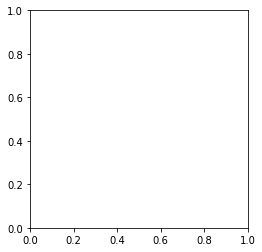

In [ ]:
for idx in test_indices:
    plt.figure()
    plt.imshow(trainset[idx]['image'])
    plt.show()

    image_norm = val_loader[idx] / 255.0
    image_norm = (torch.from_numpy(image_norm).view(1, 3, image_norm.shape[0], image_norm.shape[1]).float())

    model.eval()
    age, gender, mask = model(image_norm.to(device=device))

    predicted_age = int(age.squeeze(0).item())

    print("Age:", str(trainset[idx]['age']), "| Predicted:", str(int(predicted_age)))

    sigmoid = nn.Sigmoid()
    out_gender = int(torch.round(sigmoid(gender)).item())
    gender_classes = ["male", "female"]
    print("Gender:", str(trainset[idx]['gender']), "| Predicted:", str(gender_classes[out_gender]))

    out_mask = torch.argmax(F.softmax(mask, dim=1)).item()
    mask_classes = ["normal", "incorrect", "mask"]
    print("Mask:", str(trainset[idx]['mask']), "| Predicted:", str(mask_classes[out_mask]))
    print('\n')

TypeError: Invalid shape (3, 224, 224) for image data

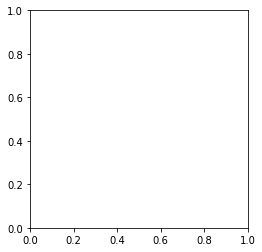

In [ ]:
for idx in test_indices:
    plt.figure()
    plt.imshow(trainset[idx]['image'])
    plt.show()

    image_norm = val_loader[idx] / 255.0
    image_norm = (torch.from_numpy(image_norm).view(1, 3, image_norm.shape[0], image_norm.shape[1]).float())

    model.eval()
    age, gender, mask = model(image_norm.to(device=device))

    predicted_age = int(age.squeeze(0).item())

    print("Age:", str(trainset[idx]['age']), "| Predicted:", str(int(predicted_age)))

    sigmoid = nn.Sigmoid()
    out_gender = int(torch.round(sigmoid(gender)).item())
    gender_classes = ["male", "female"]
    print("Gender:", str(trainset[idx]['gender']), "| Predicted:", str(gender_classes[out_gender]))

    out_mask = torch.argmax(F.softmax(mask, dim=1)).item()
    mask_classes = ["normal", "incorrect", "mask"]
    print("Mask:", str(trainset[idx]['mask']), "| Predicted:", str(mask_classes[out_mask]))
    print('\n')